# Import

## packages

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

import pandas as pd
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('ticks')

In [ ]:
from signature_validation.ssgsea_calc.ssgsea_calc import detect_fges_source
from signature_validation.utils.utils import median_scale, read_dataset
from signature_validation.plotting.plotting import default_cmap

## functions

In [ ]:
controls_order_short = [
    "T_cells",
    "CD4_T_cells",
    "Th1_cells",
    "Th2_cells",
    "Th17_cells",
    "Follicular_T_helper_tonsil",
    "Tregs",
    "CD8_T_cells",
    "NK_cells",
    "B_cells",
    "Plasma_B_cells",
    "Plasmablasts",
    "Neutrophils",
    "Eosinophils",
    "Mast_cells",
    "Monocytes",
    "Macrophages",
    "Macrophages_M1",
    "Macrophages_M2",
    "Endothelium",
    "Endothelium_lymph",
    "Other_controls",
]

## data

In [ ]:
p = Path("./data/")
with open(p / "mapping_ssgseas.pkl", "rb") as handle:
    mapping_ssgseas = pickle.load(handle)
for key in mapping_ssgseas.keys():
    for i in mapping_ssgseas[key]["Goi"].keys():
        print(key, "\t", i, "\t", mapping_ssgseas[key]["Goi"][i].shape)

Main4_Th1_signature 	 Th1_cells 	 (20, 65)
Main4_CD8_T_cells 	 CD8_T_cells 	 (453, 269)
Main4_Treg 	 Tregs 	 (73, 168)
Main4_Neutrophil_signature 	 Neutrophils 	 (199, 107)
Main4_Mast_cell_signature 	 Mast_cells 	 (51, 53)
Main4_Effector_cells 	 CD8_T_cells 	 (453, 386)
Main4_Effector_cells 	 NK_cells 	 (202, 386)
Main4_Eosinophil_signature 	 Eosinophils 	 (12, 39)
Main4_Follicular_helper_T_cells 	 Follicular_T_helper_tonsil 	 (24, 50)
Main4_B_cells 	 B_cells 	 (504, 378)
Main4_Endothelium 	 Endothelium 	 (322, 98)
Main4_Pan_macrophage_signature 	 Macrophages 	 (527, 261)
Main4_NK_cells 	 NK_cells 	 (202, 108)
Main4_M2_signature 	 Macrophages_M2 	 (23, 20)
Main4_T_cells 	 T_cells 	 (164, 155)
Main4_CD4_T_cells 	 CD4_T_cells 	 (1699, 423)
Main4_CD4_T_cells 	 CD4_T_helpers 	 (73, 423)
Main4_Lymphatic_endothelium 	 Endothelium_lymph 	 (89, 26)
Main4_Th17_signature 	 Th17_cells 	 (19, 54)
Main4_Plasma_cells 	 Plasma_B_cells 	 (11, 45)
Main4_Plasma_cells 	 Plasmablasts 	 (14, 45)
Main4_Mono

In [ ]:
with open(p / "msigdb_gmt.pkl", "rb") as handle:
    msigdb_gmt = pickle.load(handle)

In [ ]:
public_cells_annot = read_dataset(
    "/internal_data/public_cells_annot.tsv.gz"
)  # Sharing by request
public_cells_annot = public_cells_annot[~public_cells_annot.index.duplicated()]

In [ ]:
with open(p / "fges_metrics_controls_goi_wo_bootstrap.pkl", "rb") as handle:
    fges_metrics = pickle.load(handle)

In [ ]:
df = []
for sign in mapping_ssgseas.keys():
    control_and_goi = []
    for group in mapping_ssgseas[sign].keys():
        data = pd.concat([x for x in mapping_ssgseas[sign][group].values()])
        control_and_goi.append(data)
    control_and_goi = pd.concat(control_and_goi)
    control_and_goi = control_and_goi[~control_and_goi.index.duplicated(keep="first")]
    df.append(control_and_goi)
df = pd.concat(df, axis=1)

# Plotting

In [ ]:
labels = public_cells_annot["Cell_type"].copy()
labels = pd.concat(
    [
        labels[labels.isin(controls_order_short)],
        pd.Series(
            index=labels[~labels.isin(controls_order_short)].index,
            data="Other_controls",
        ),
    ]
)

In [ ]:
p = Path("./plots/")

## Basic Top10

Main4_Th17_signature


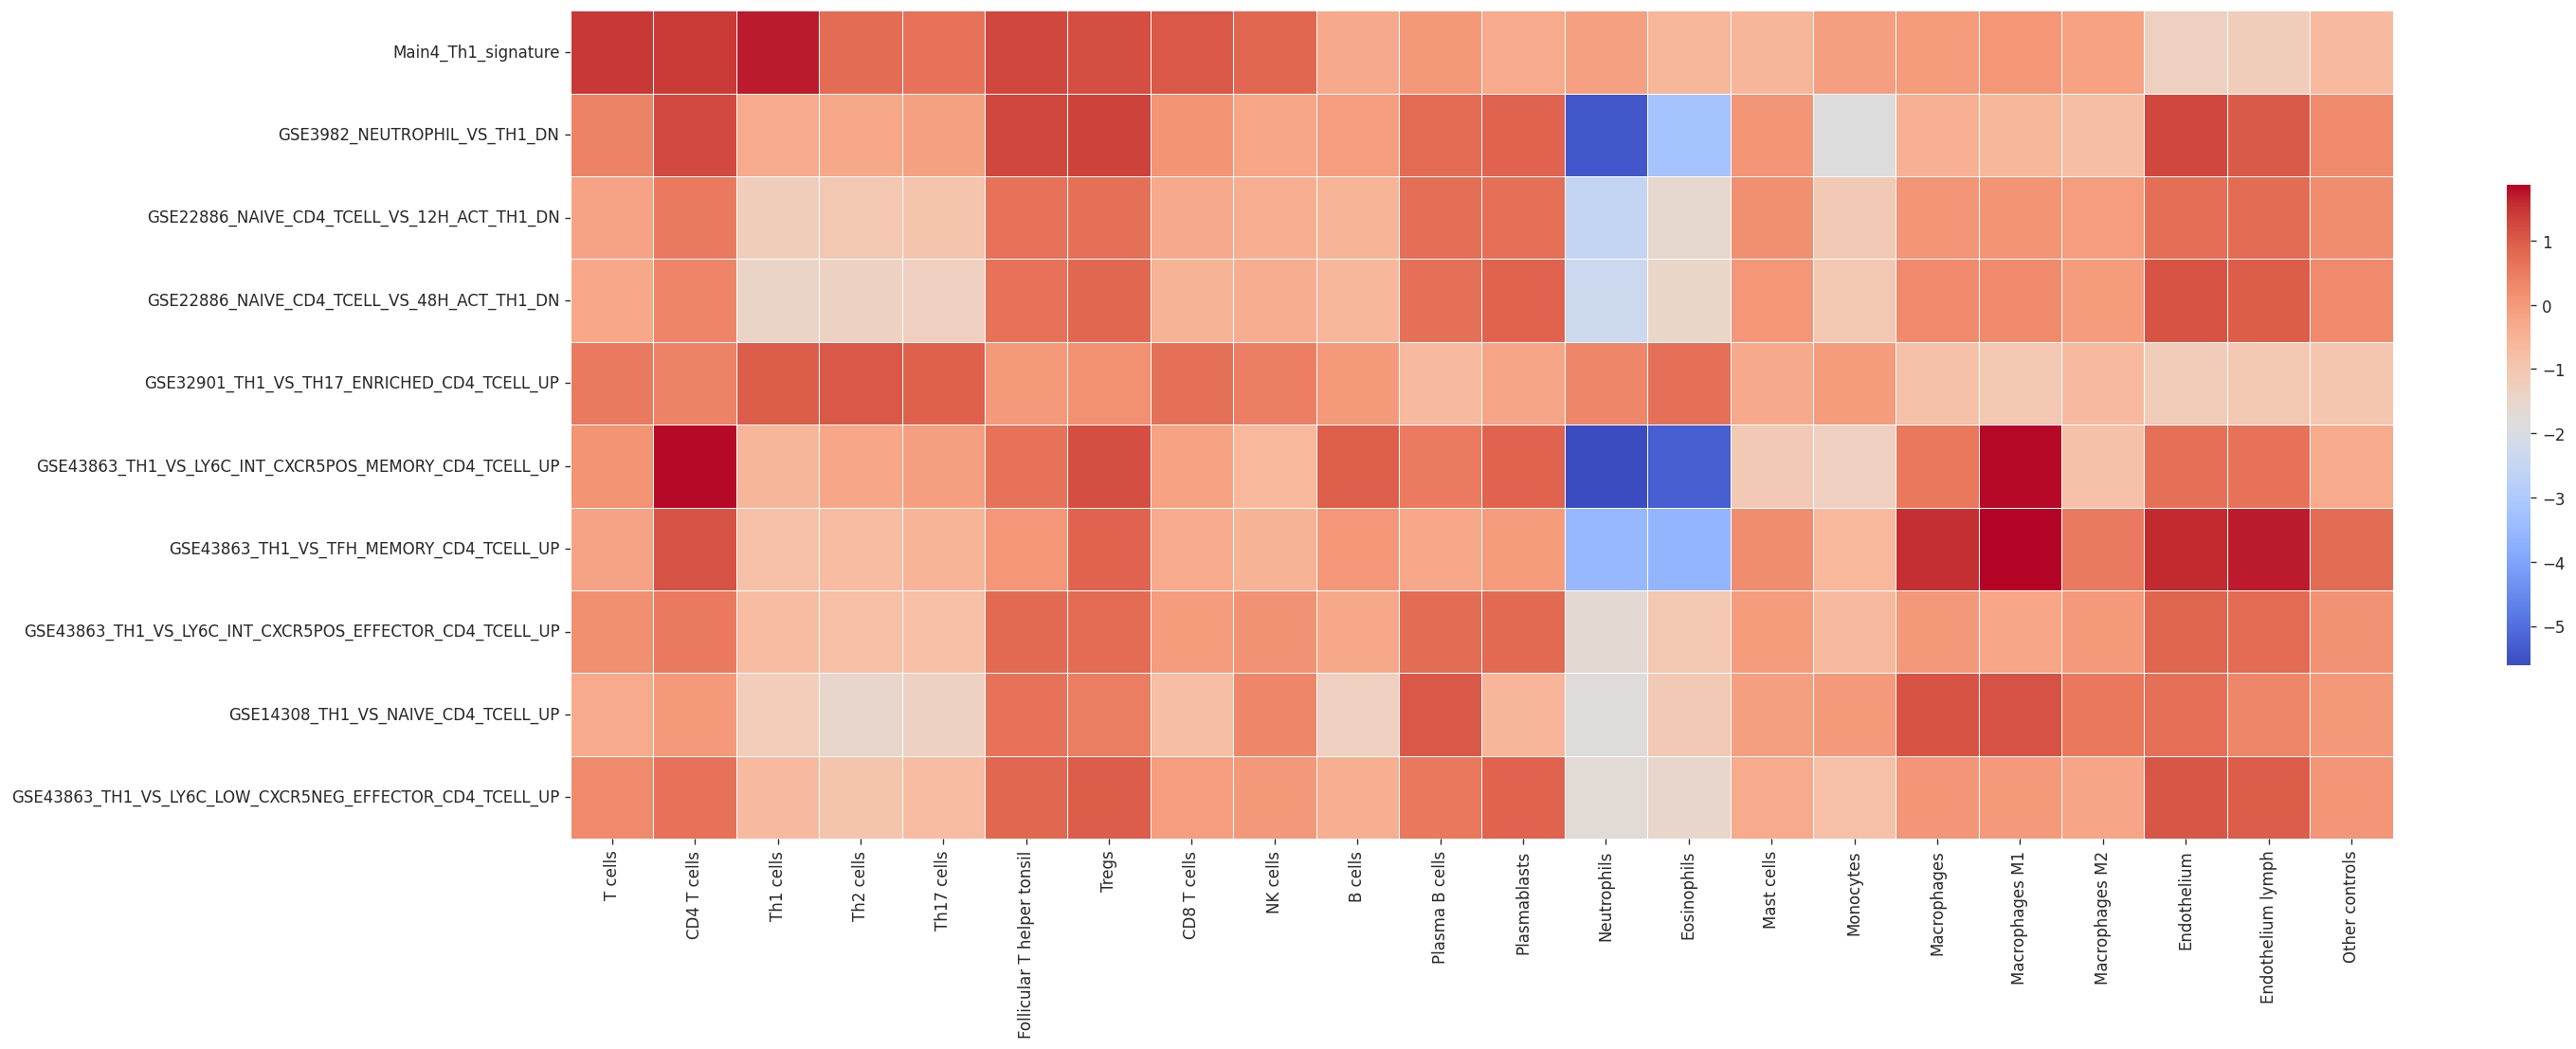

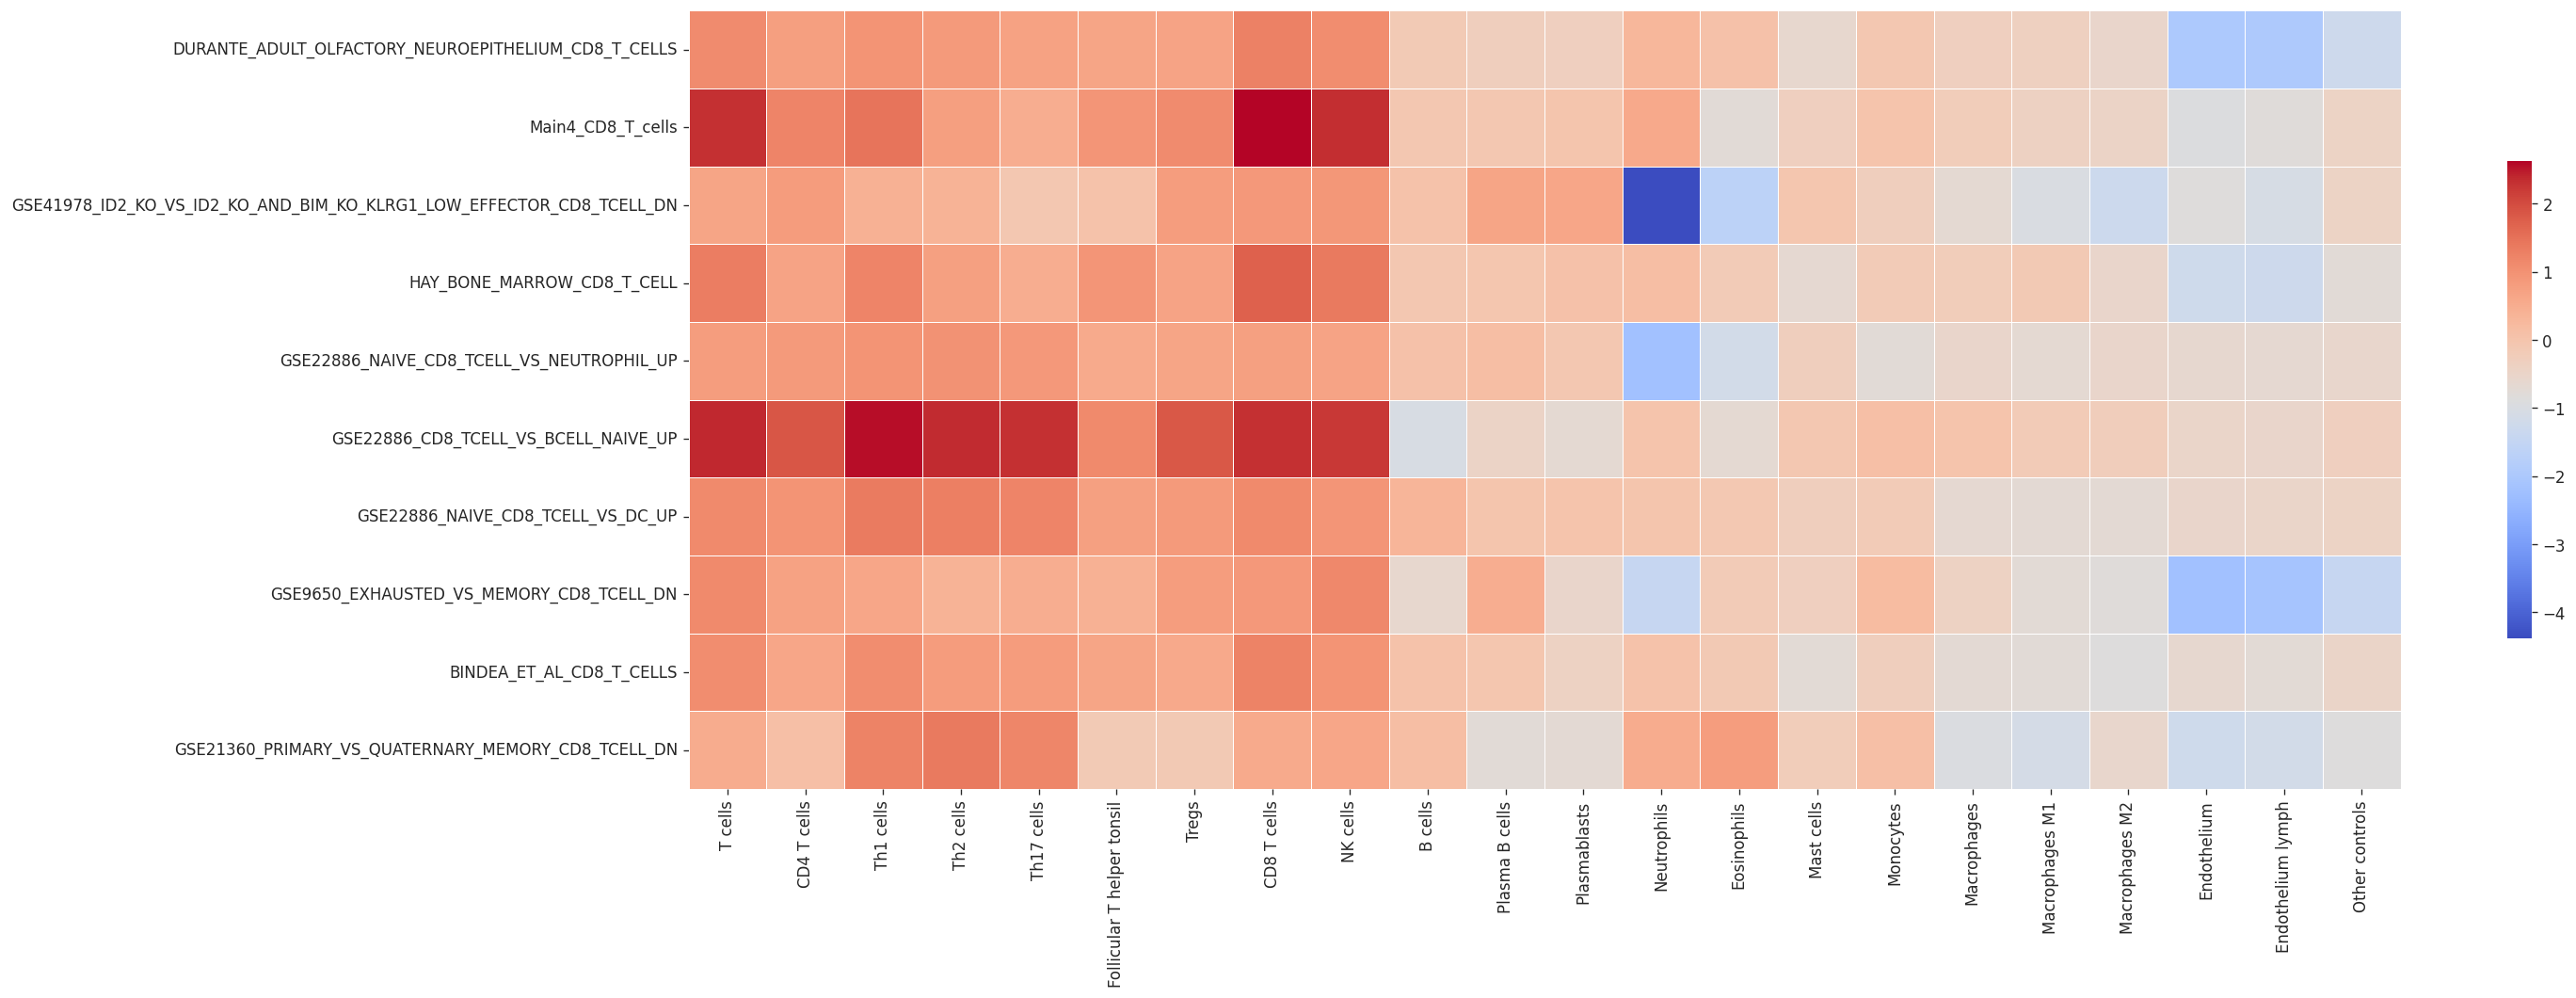

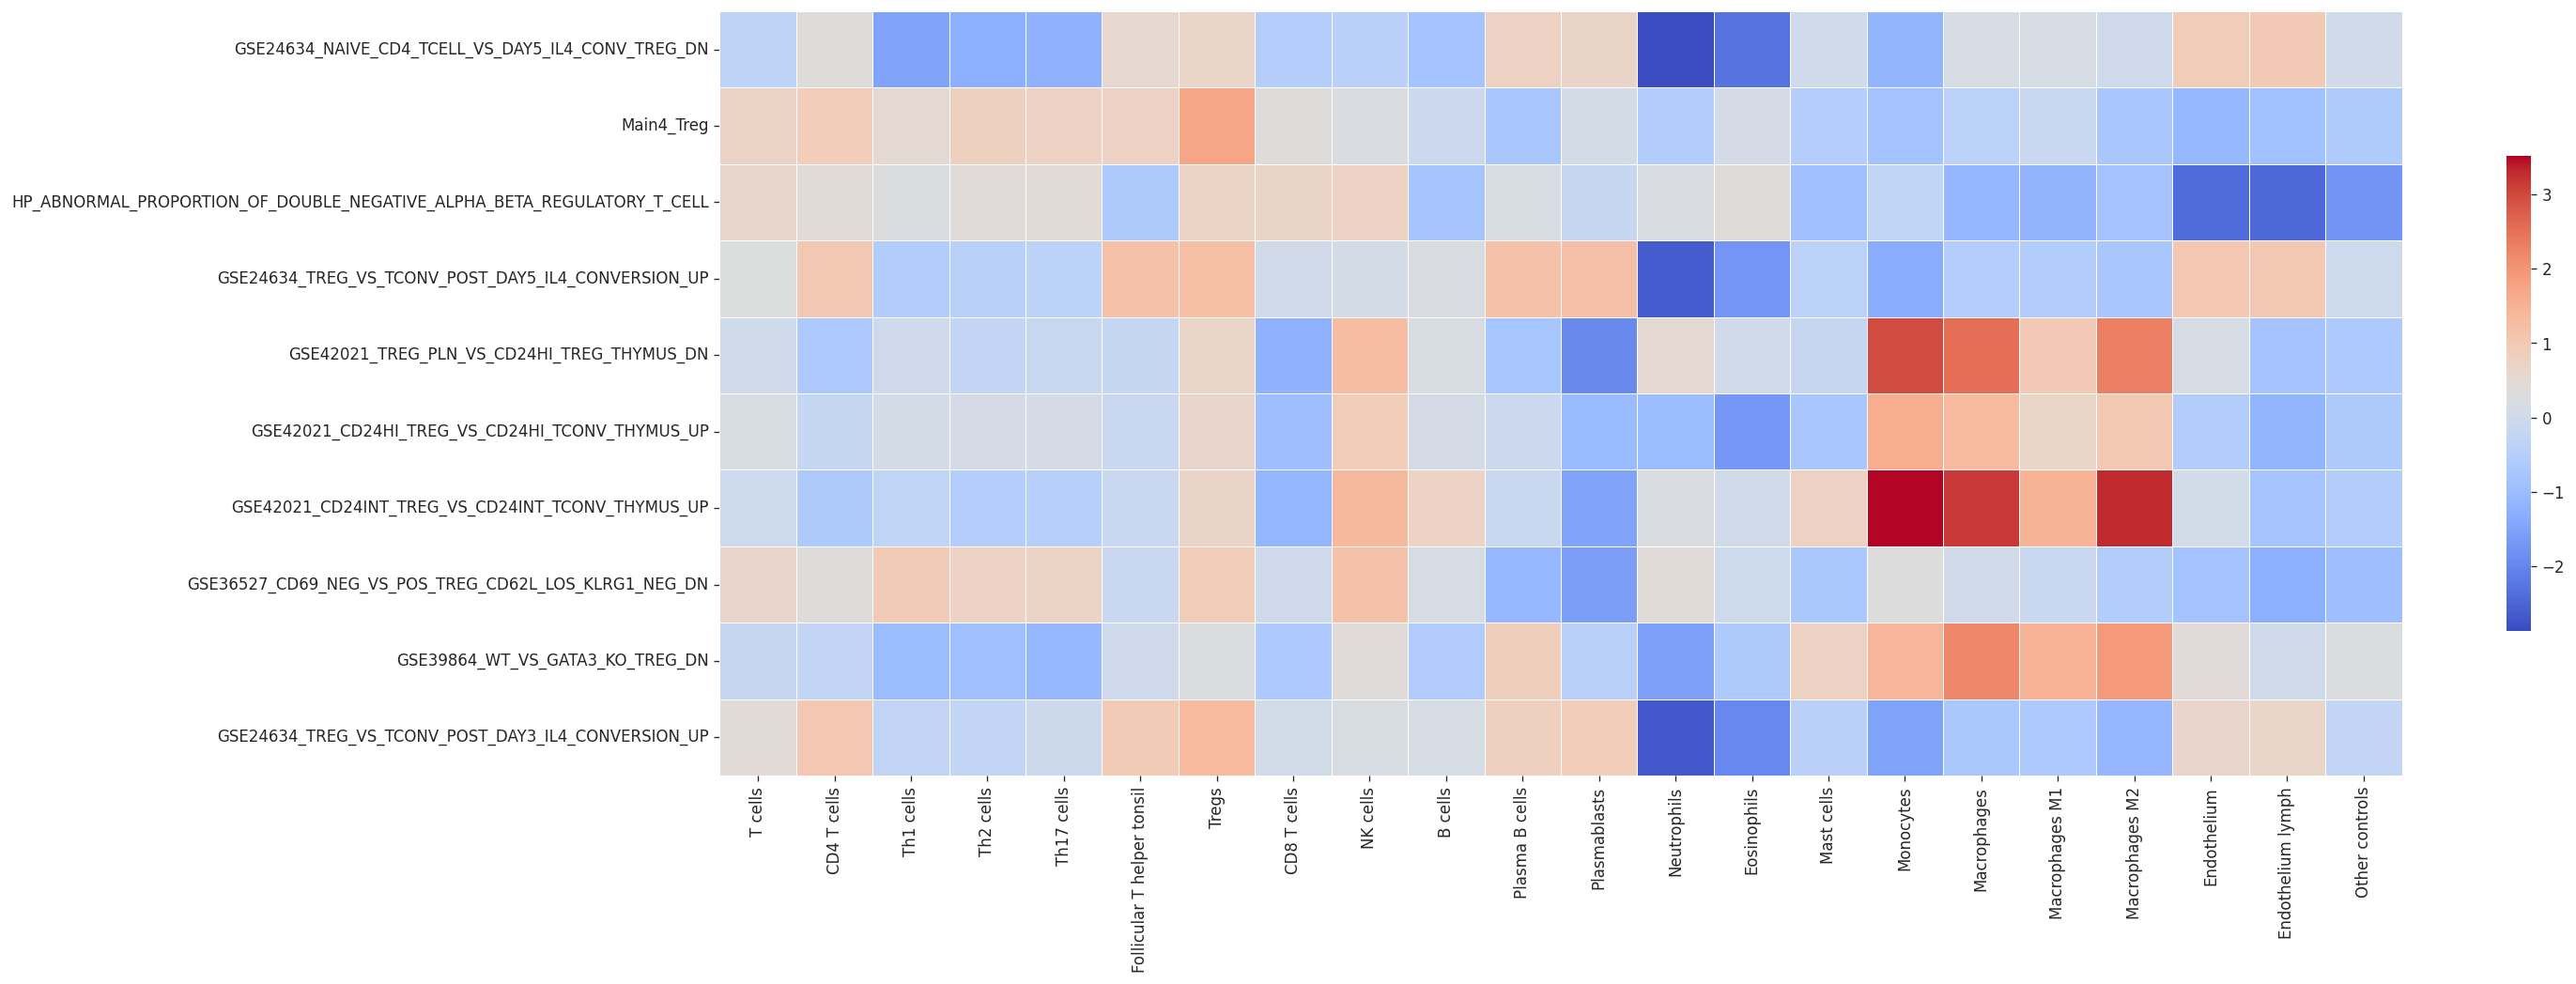

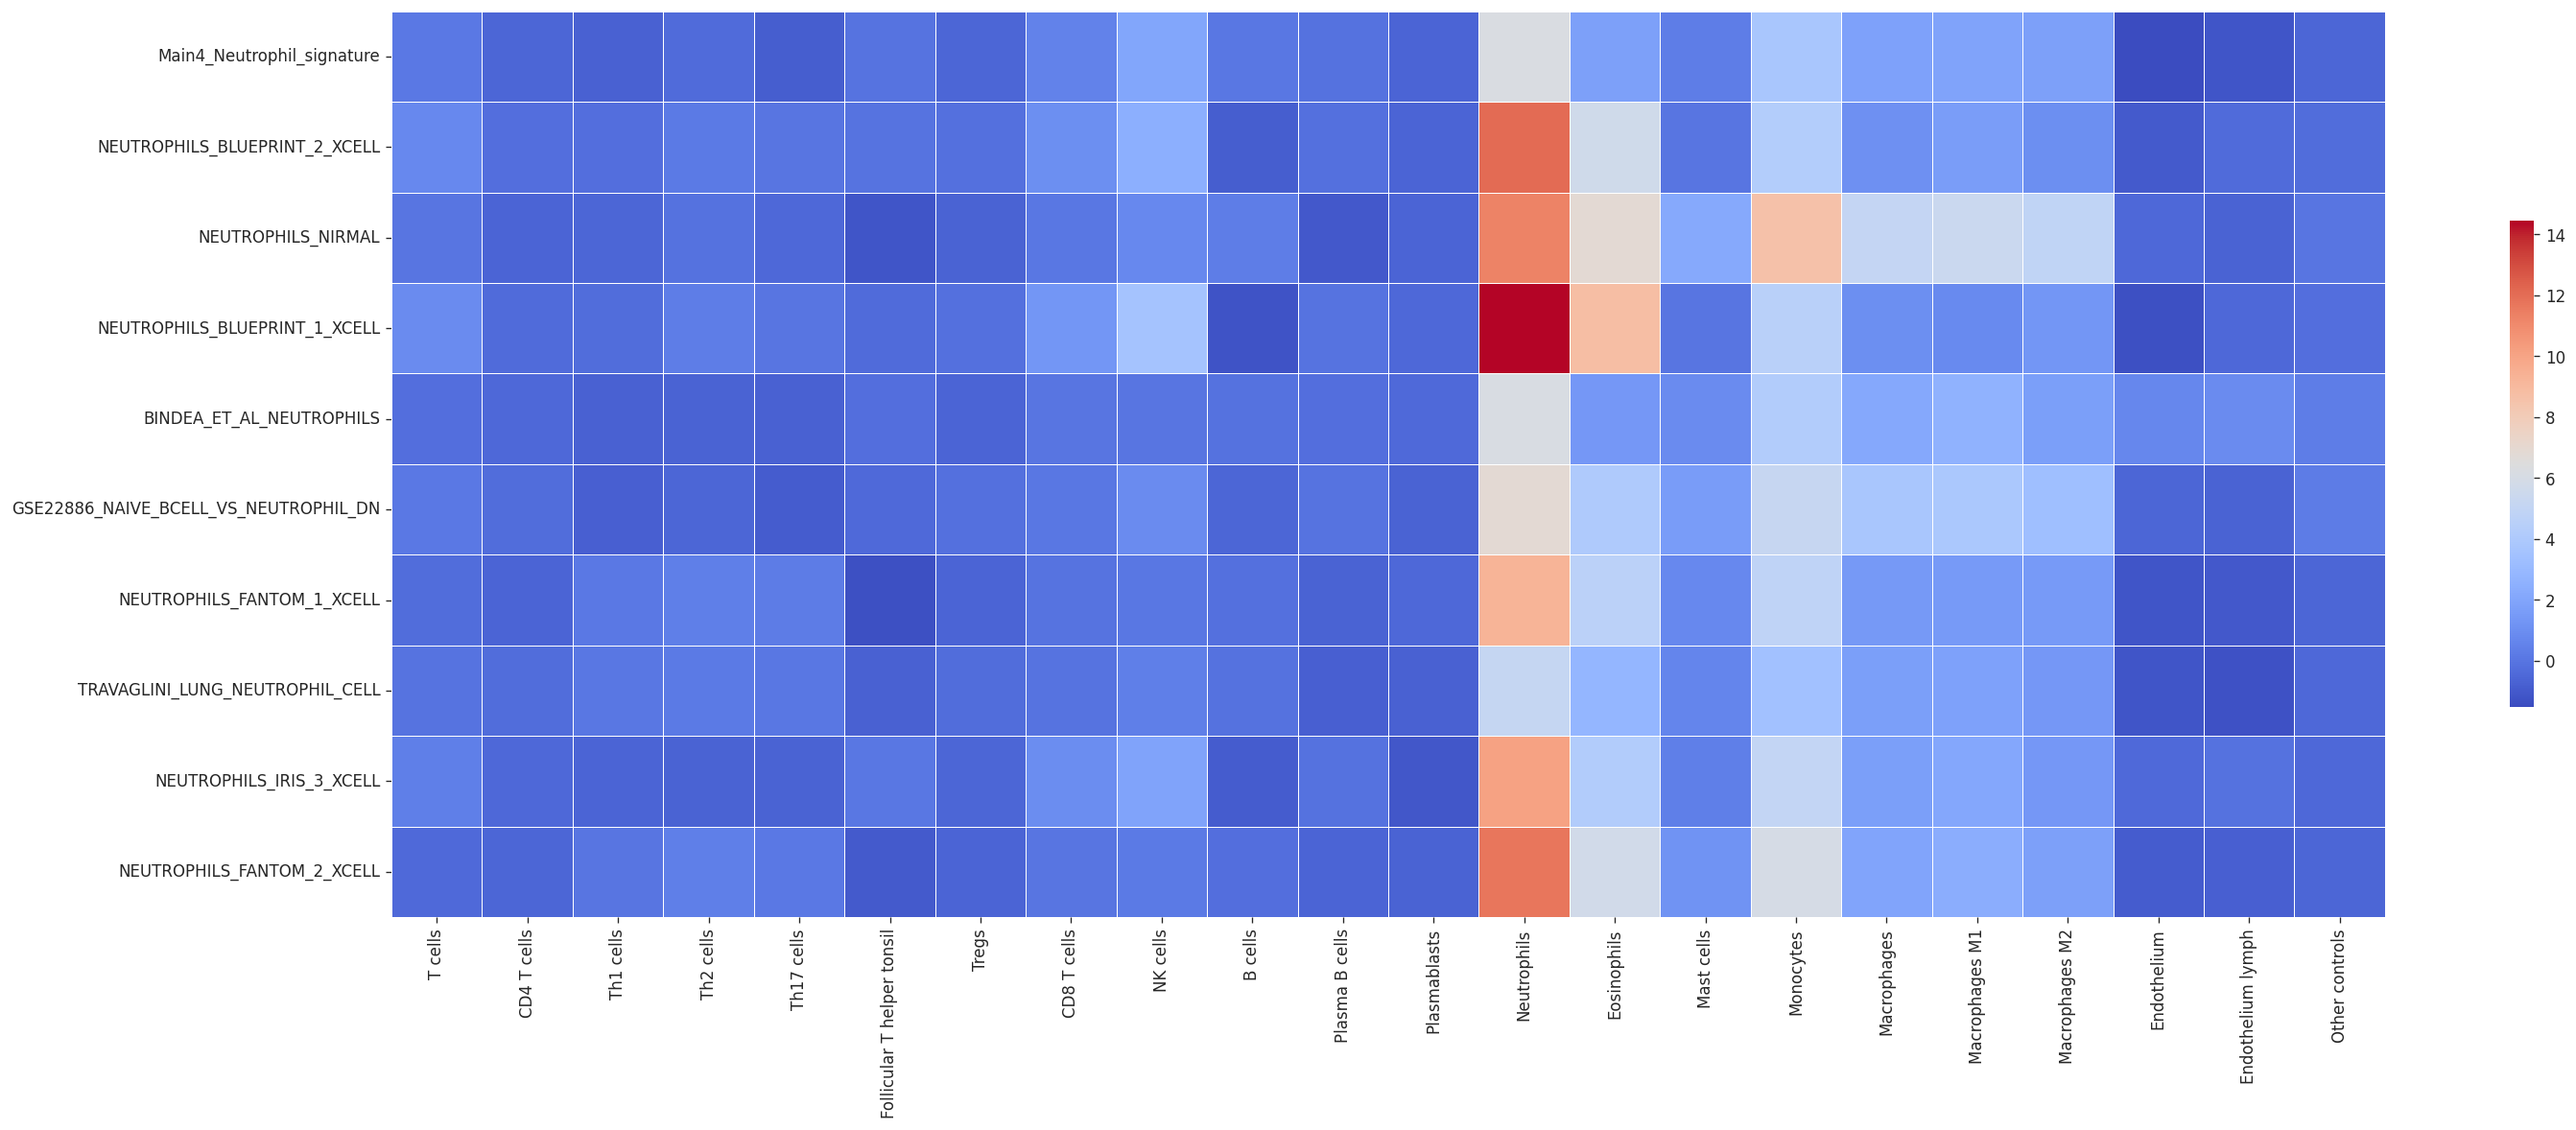

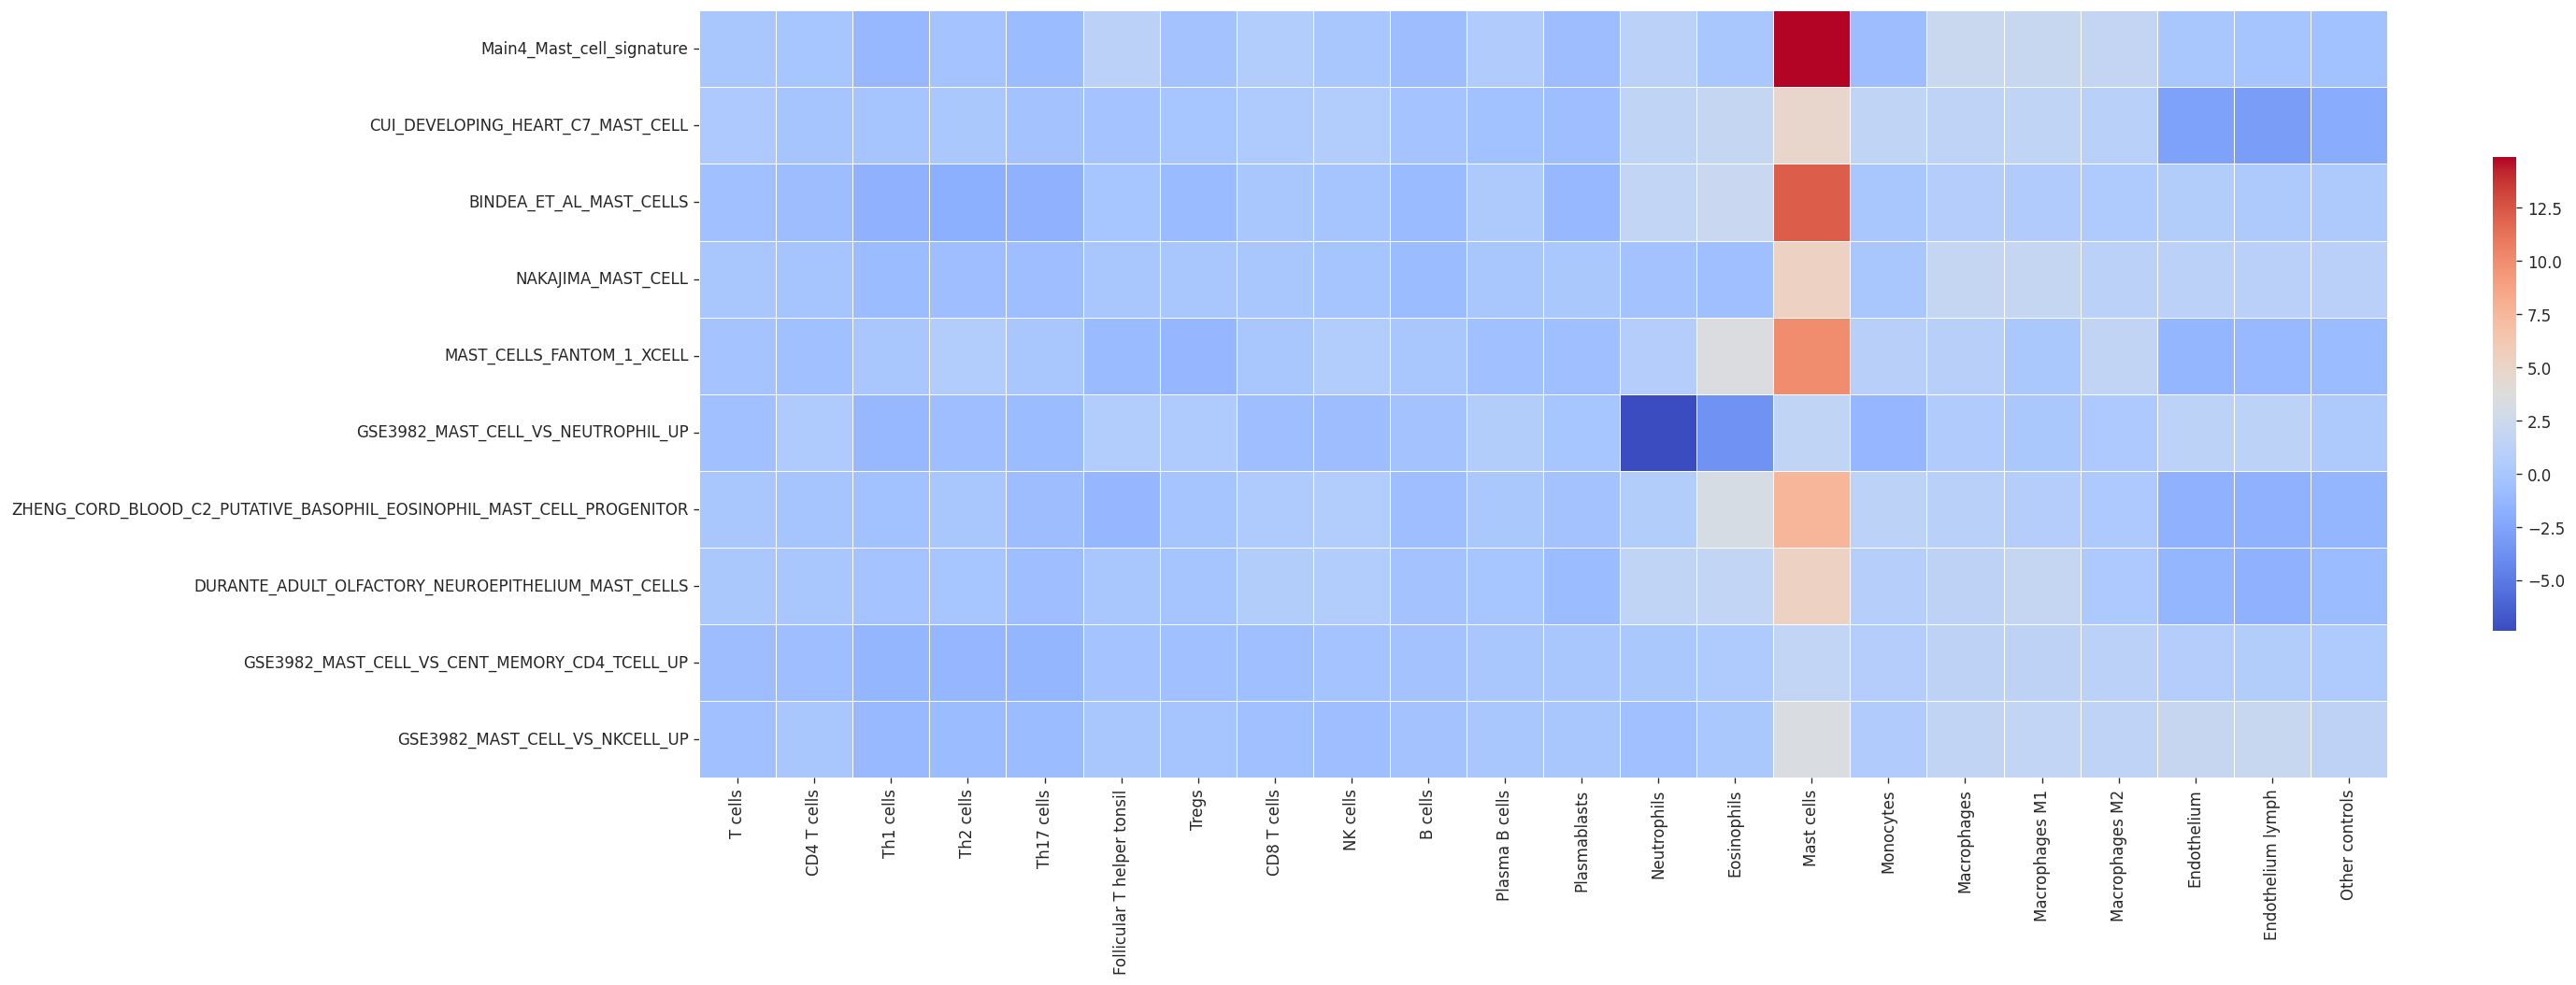

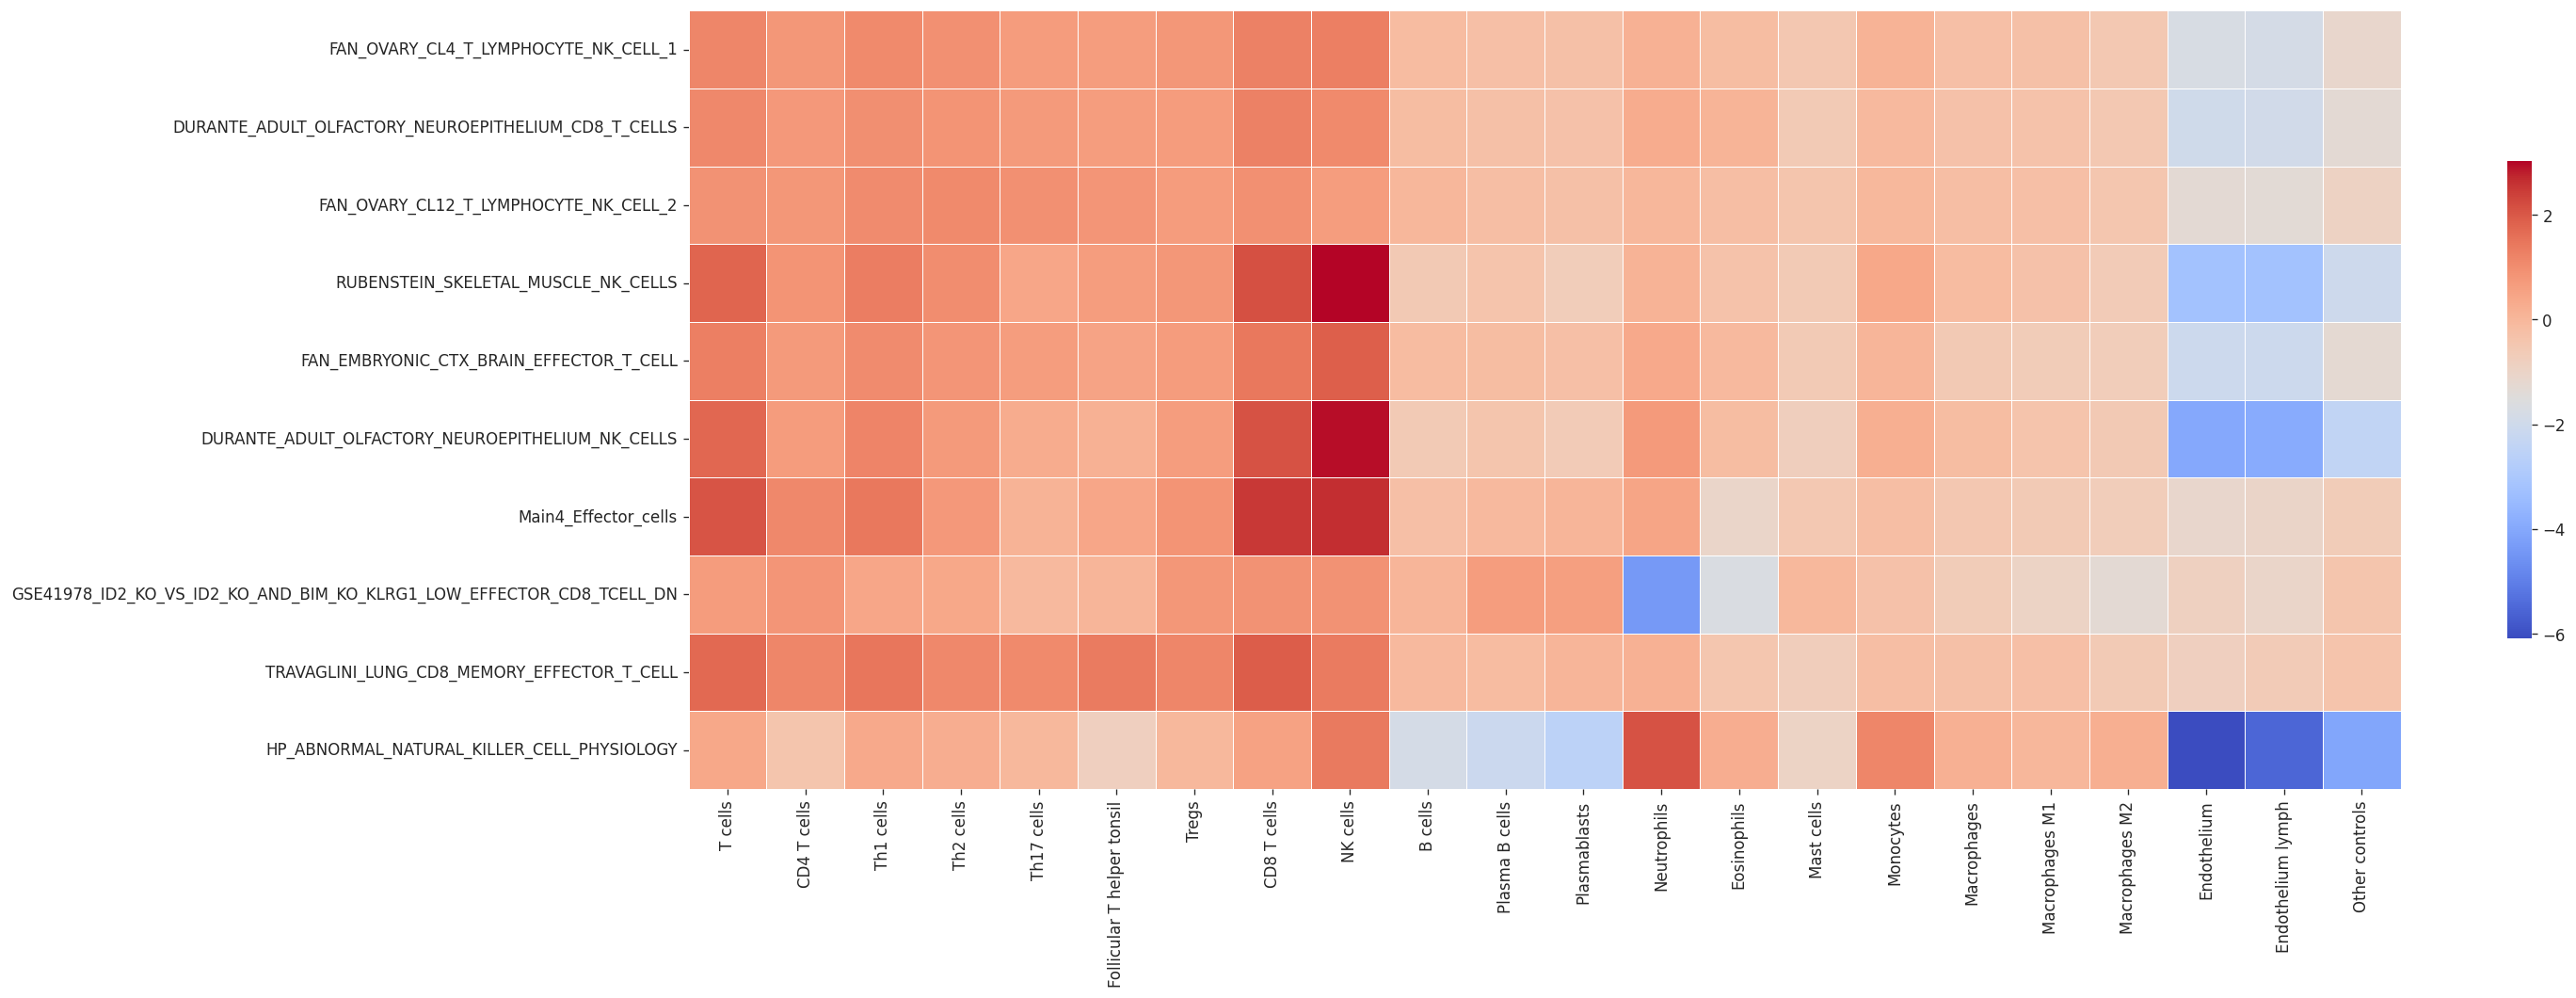

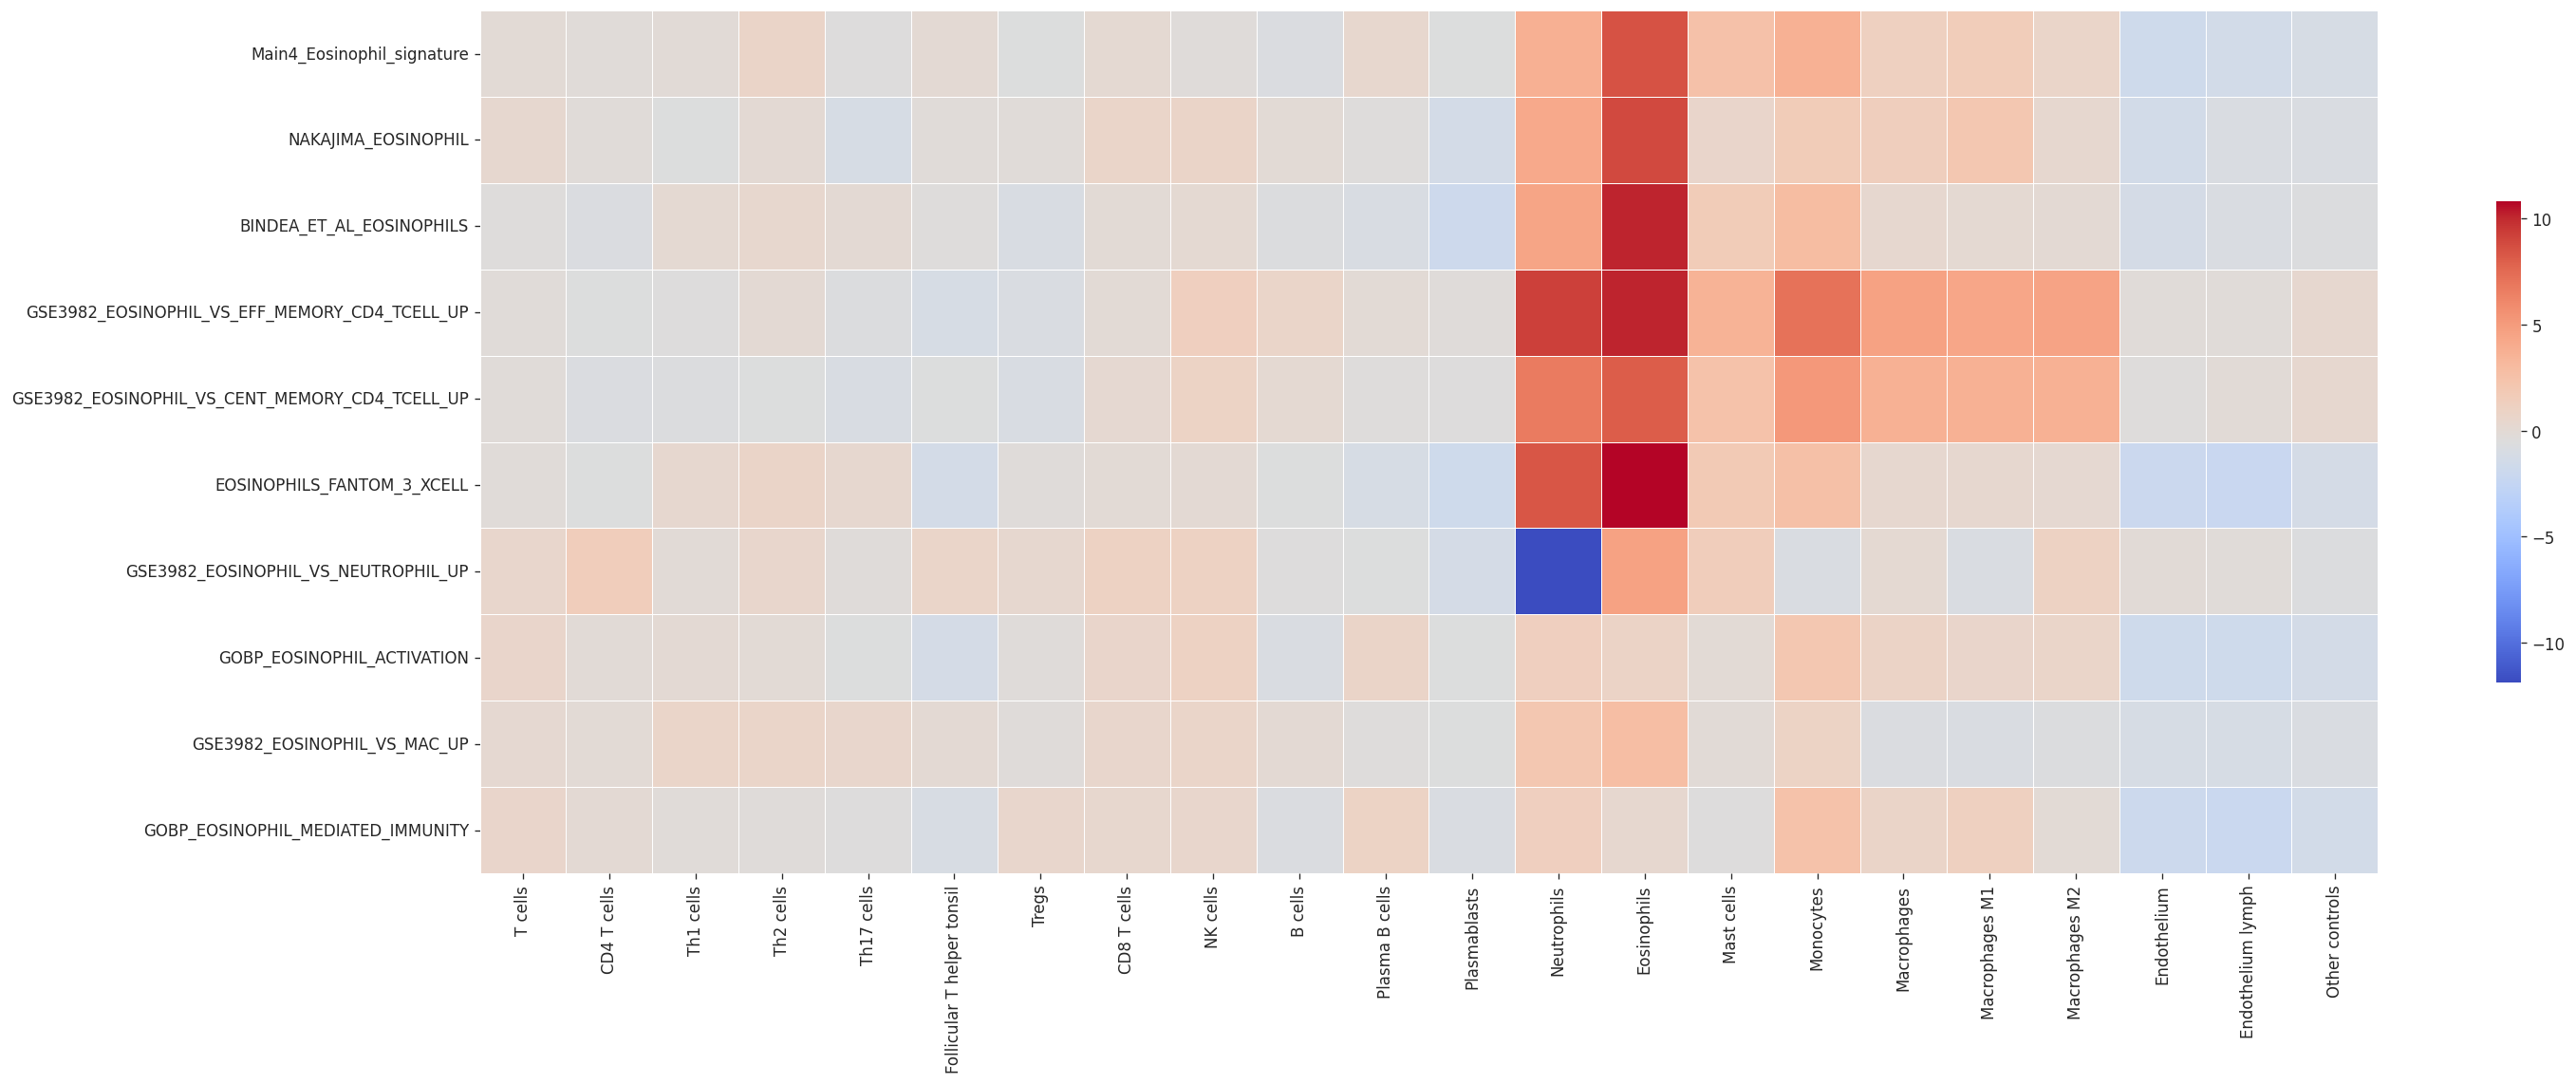

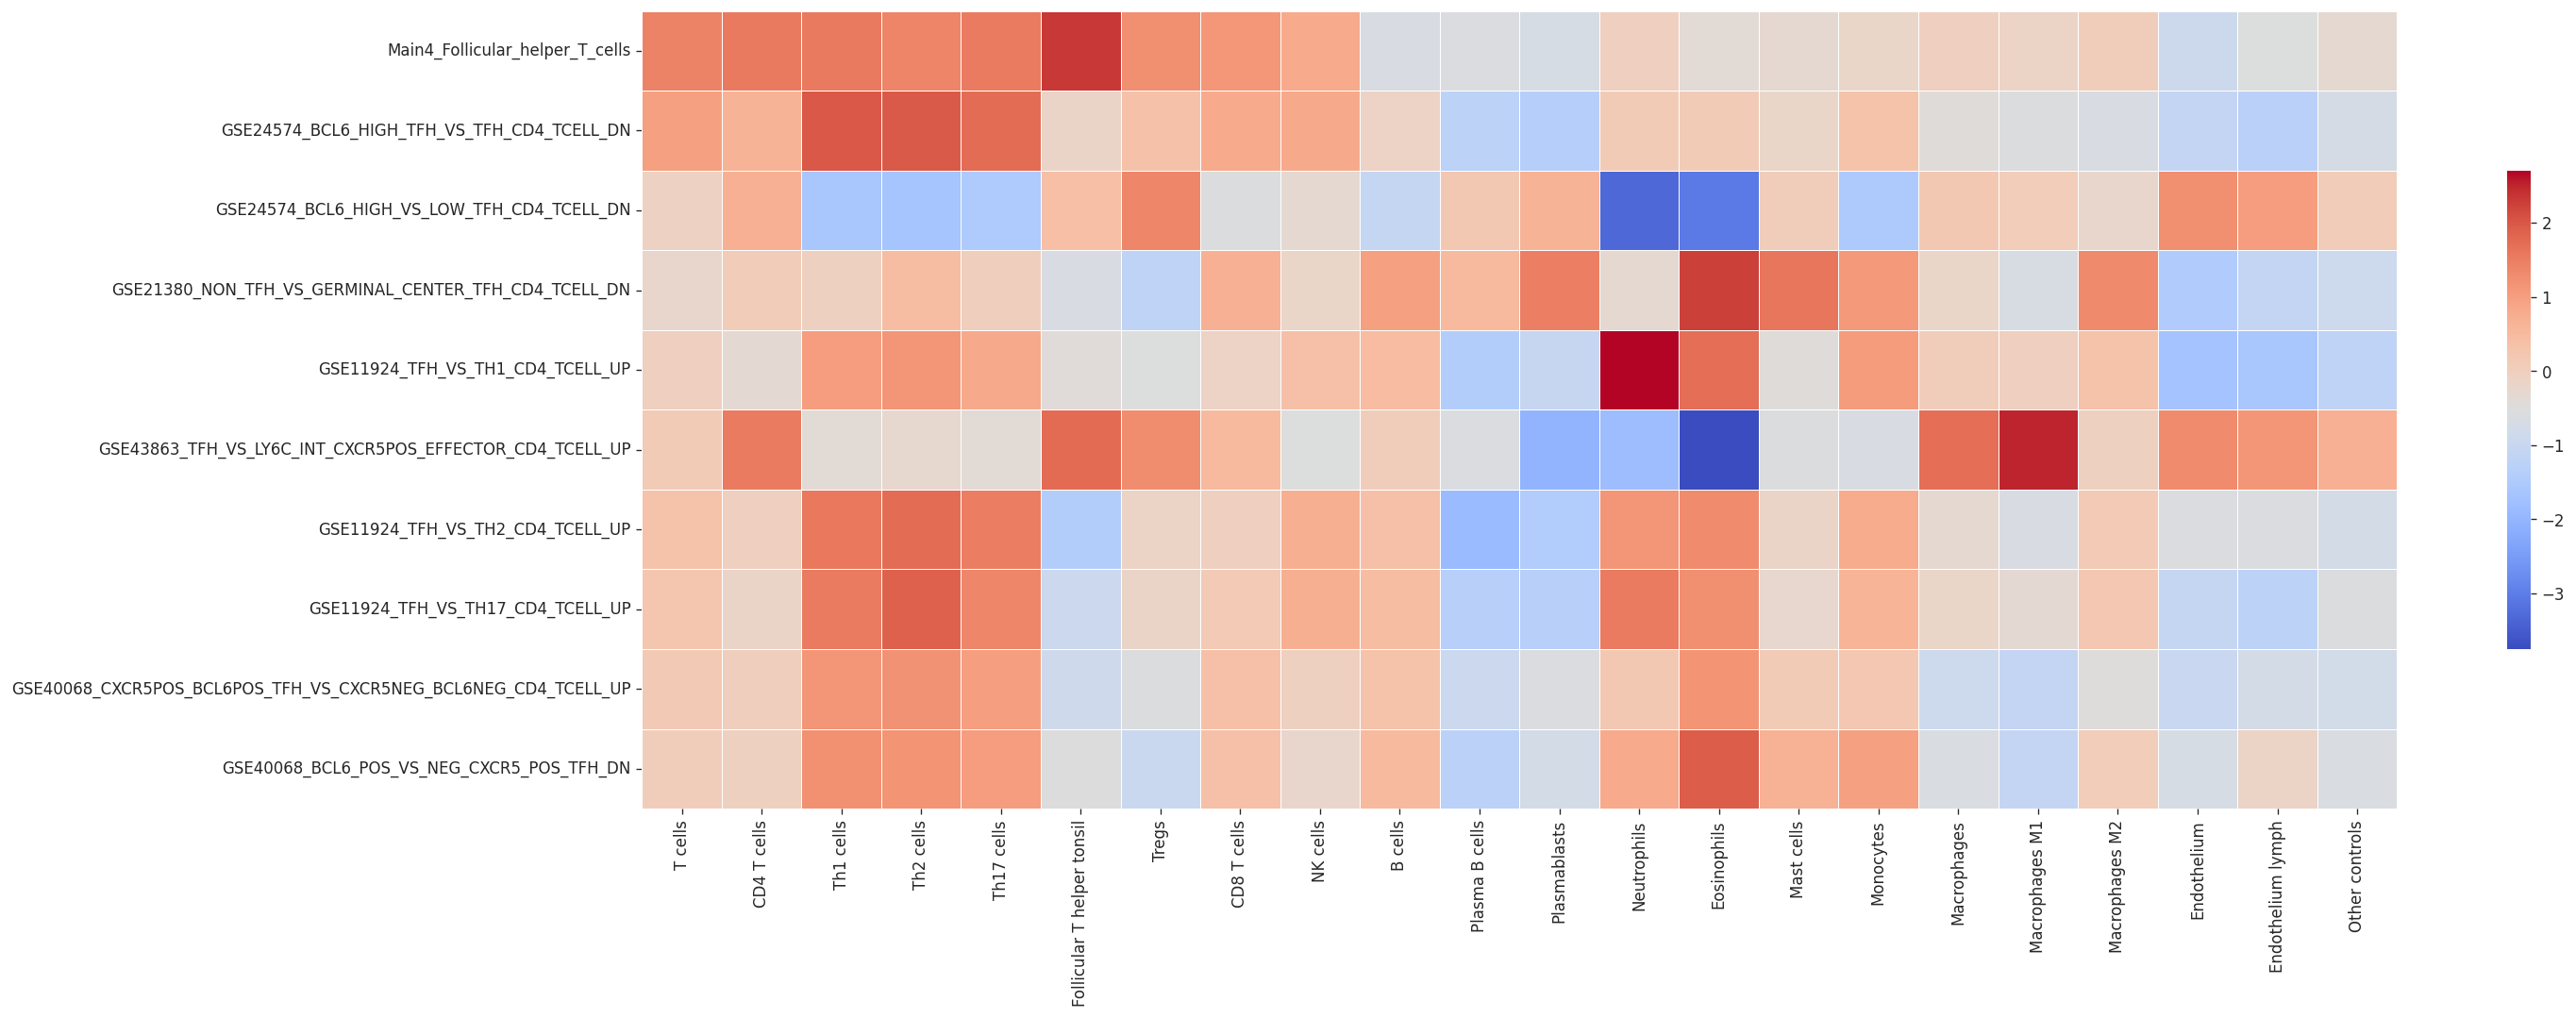

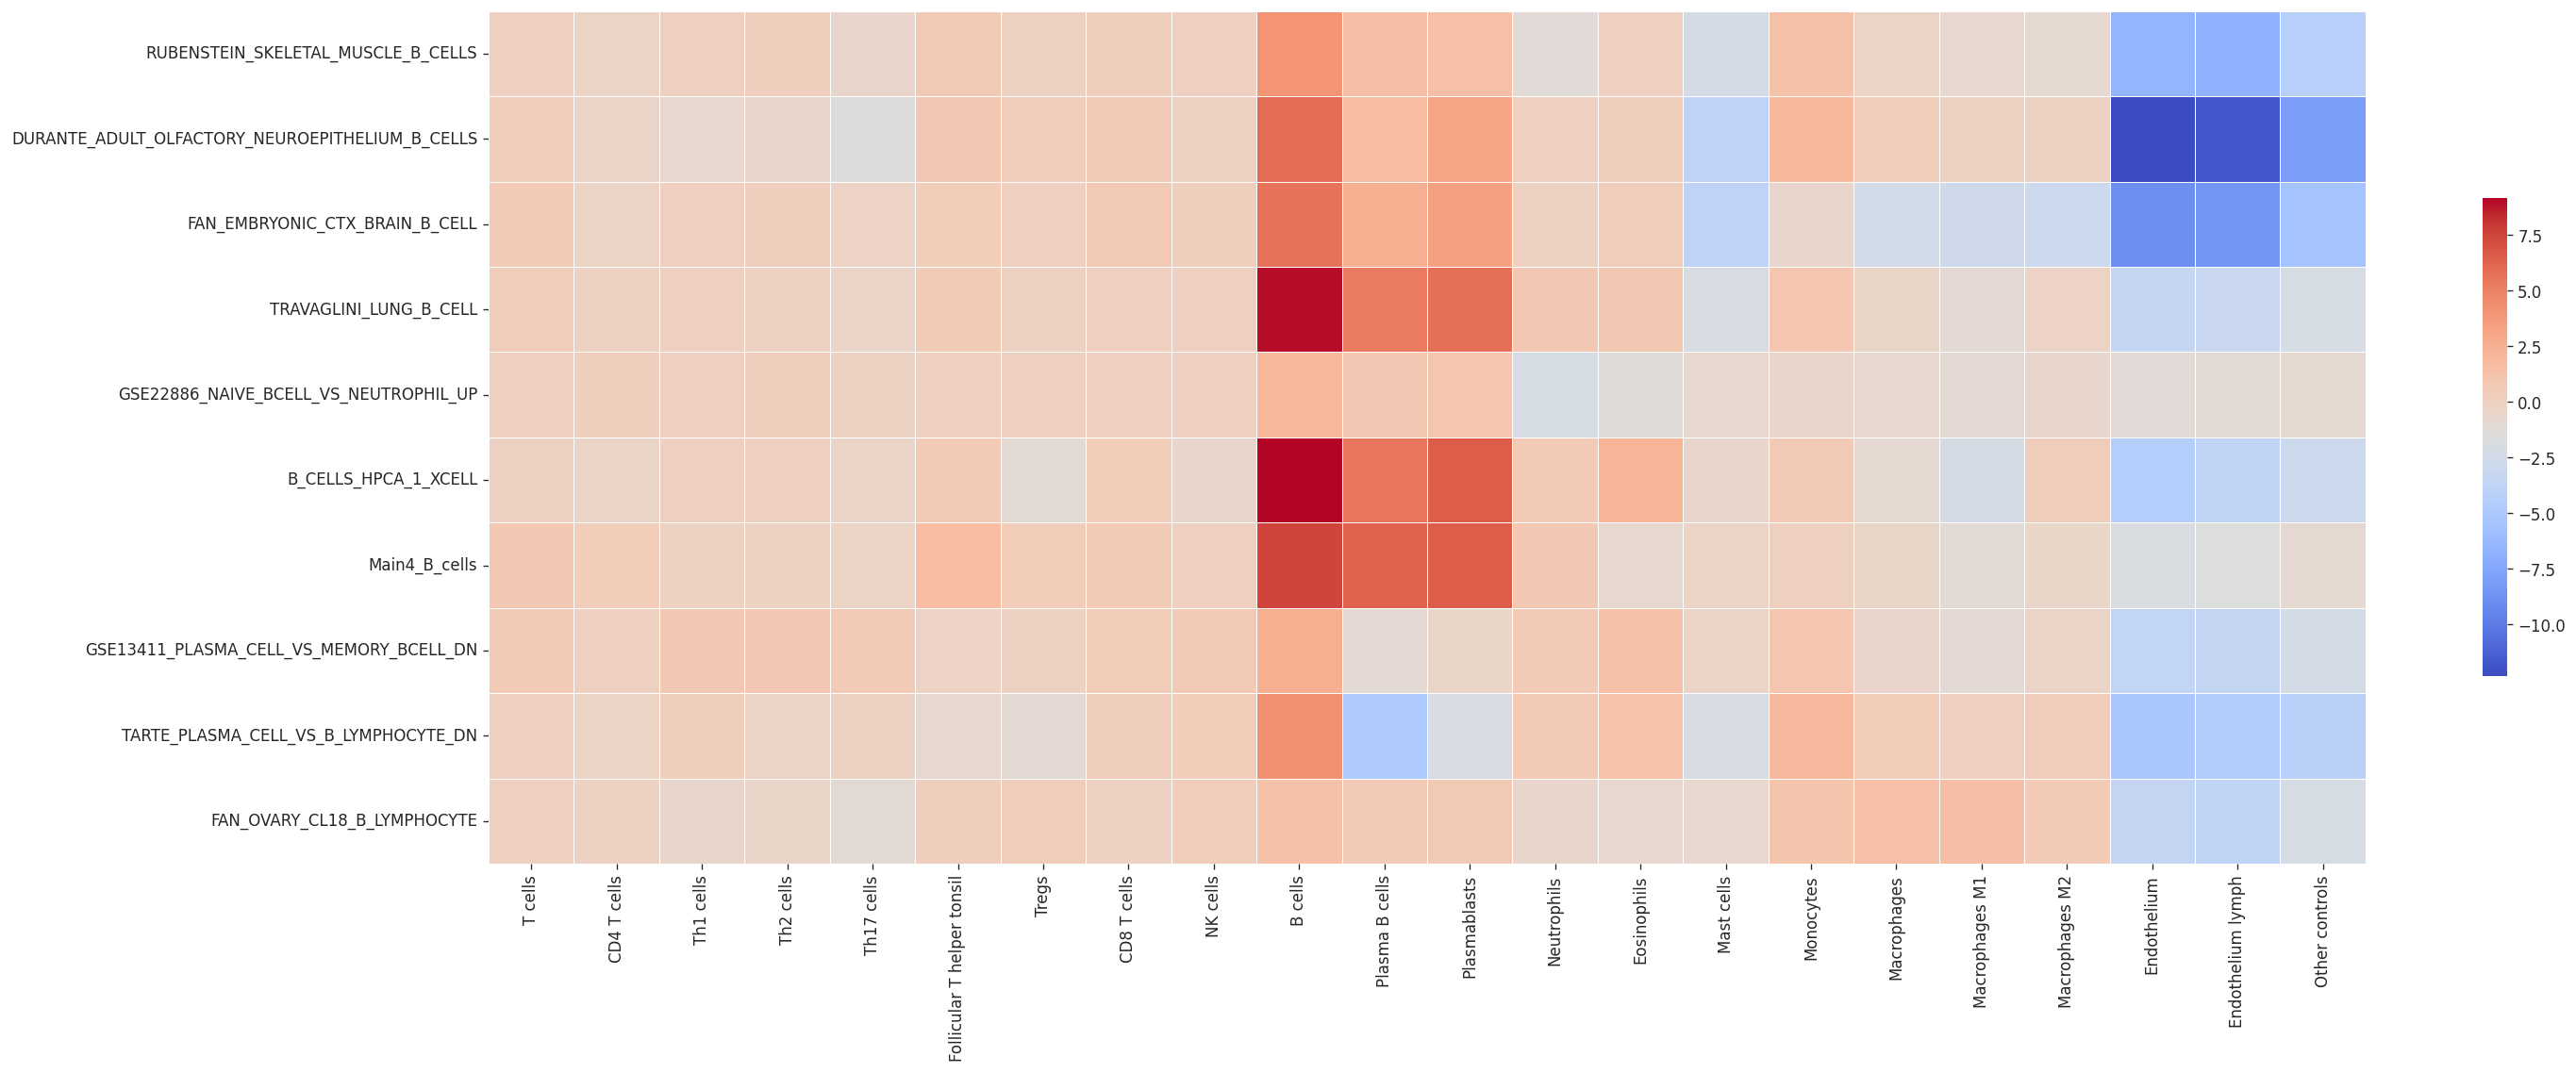

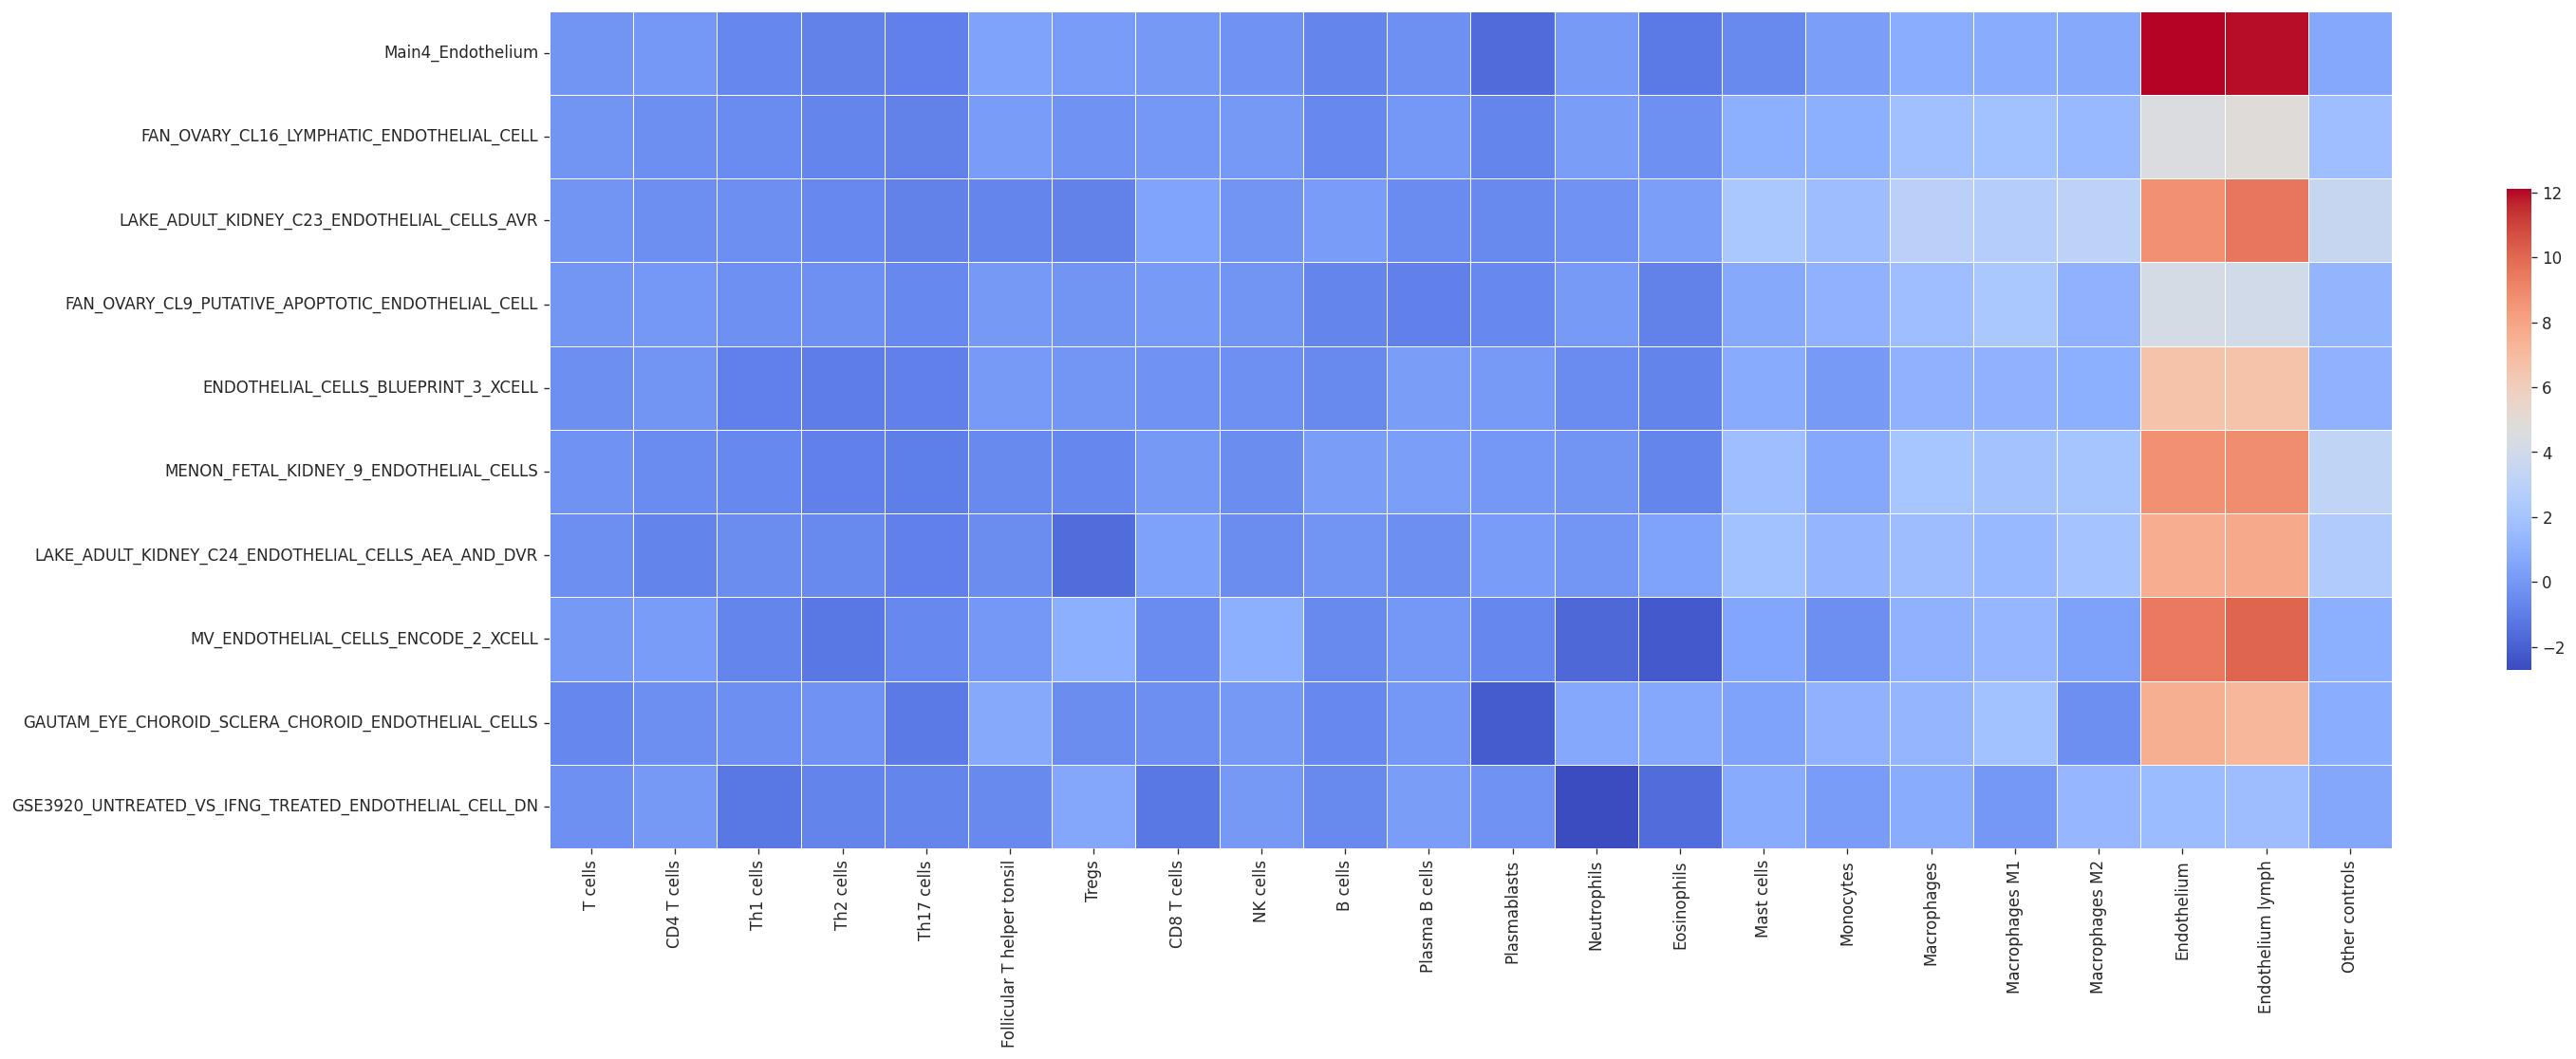

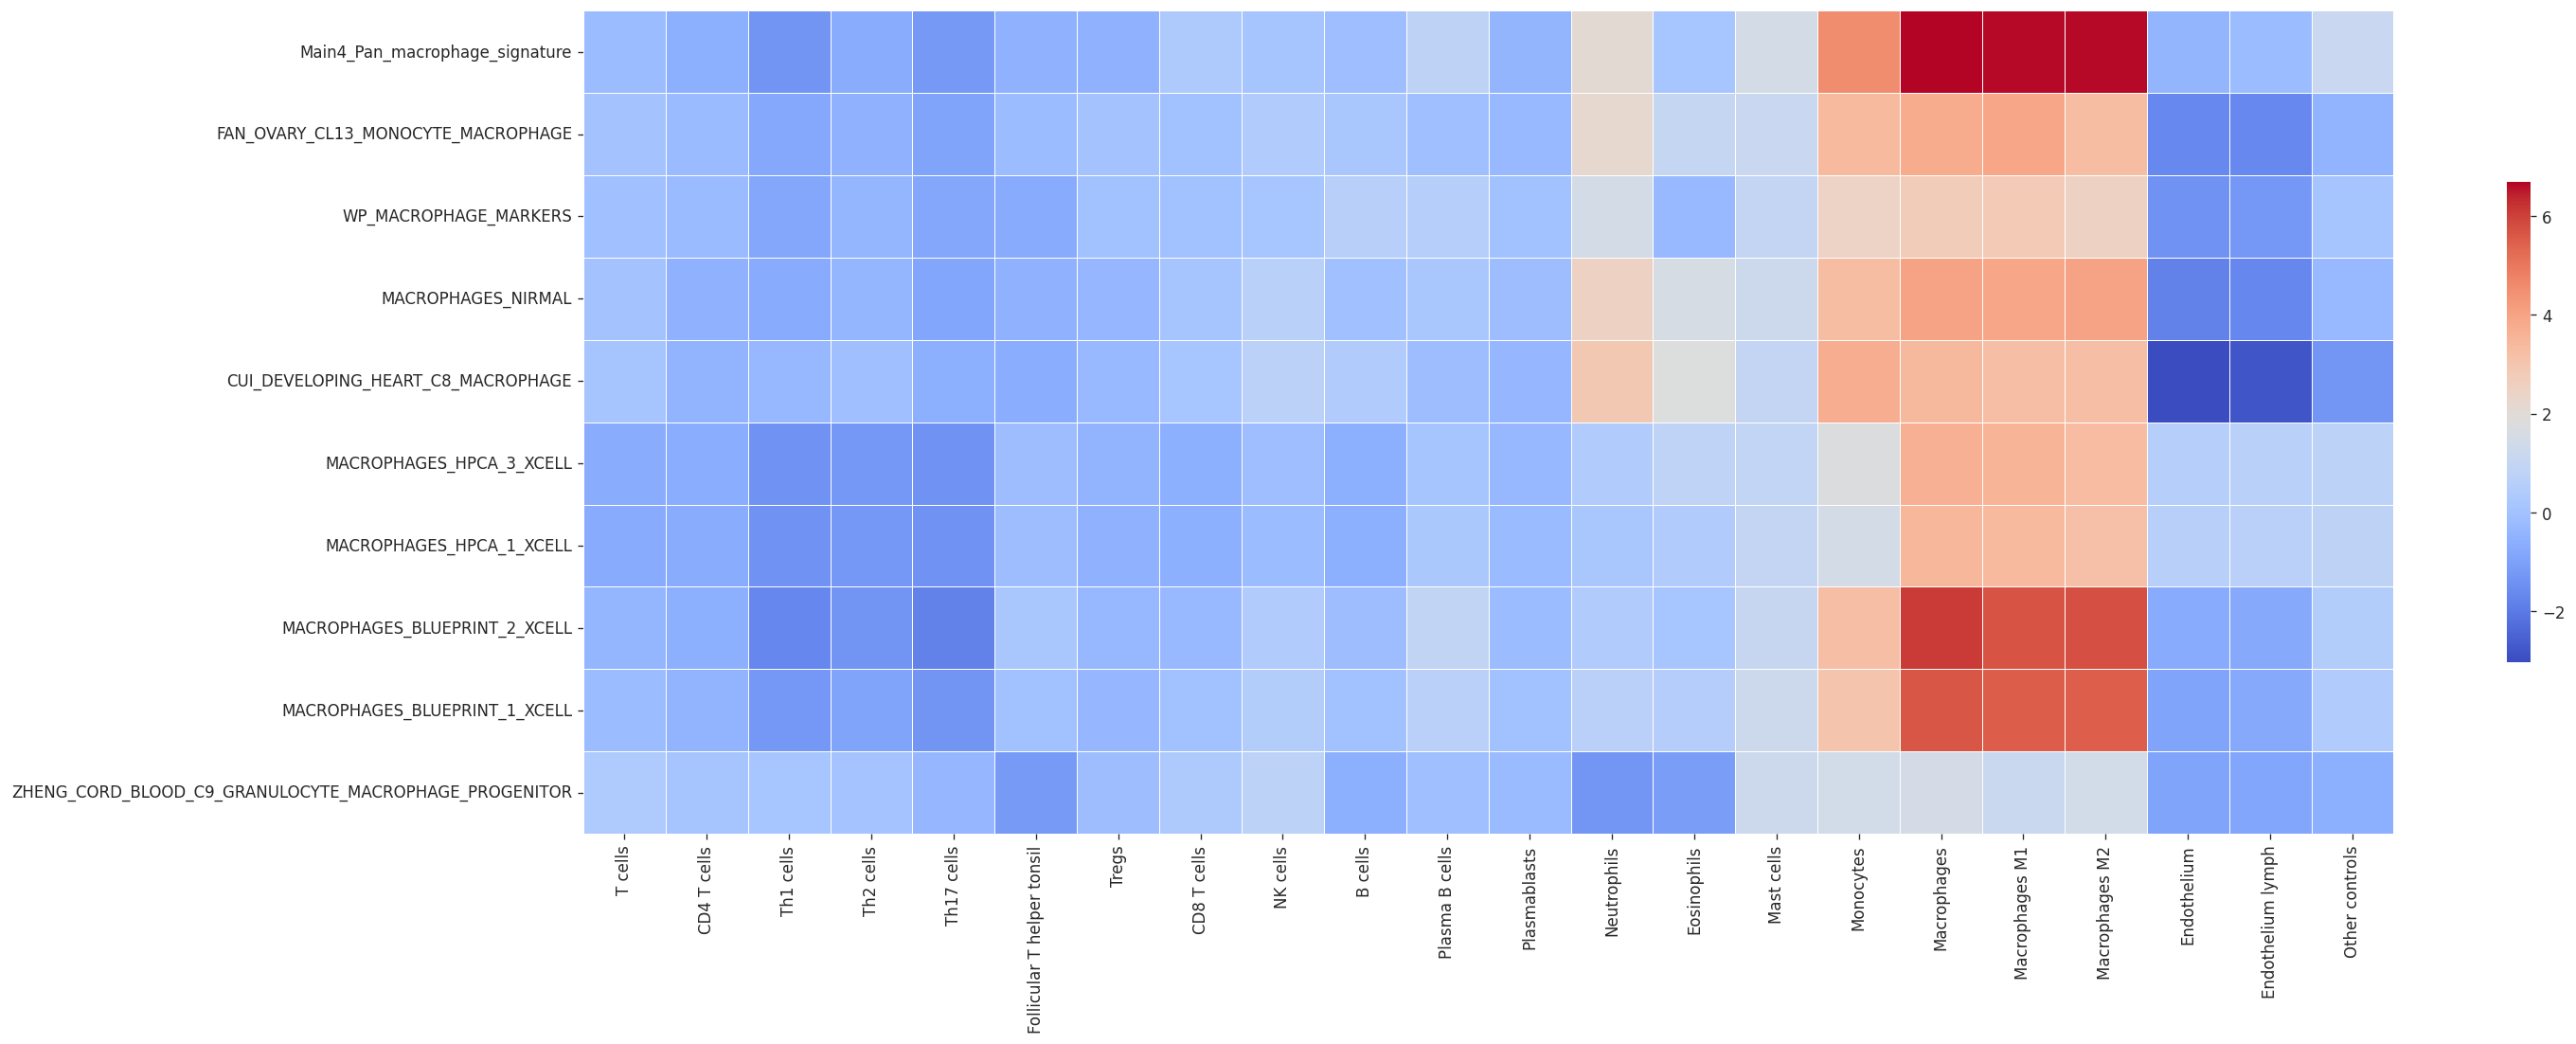

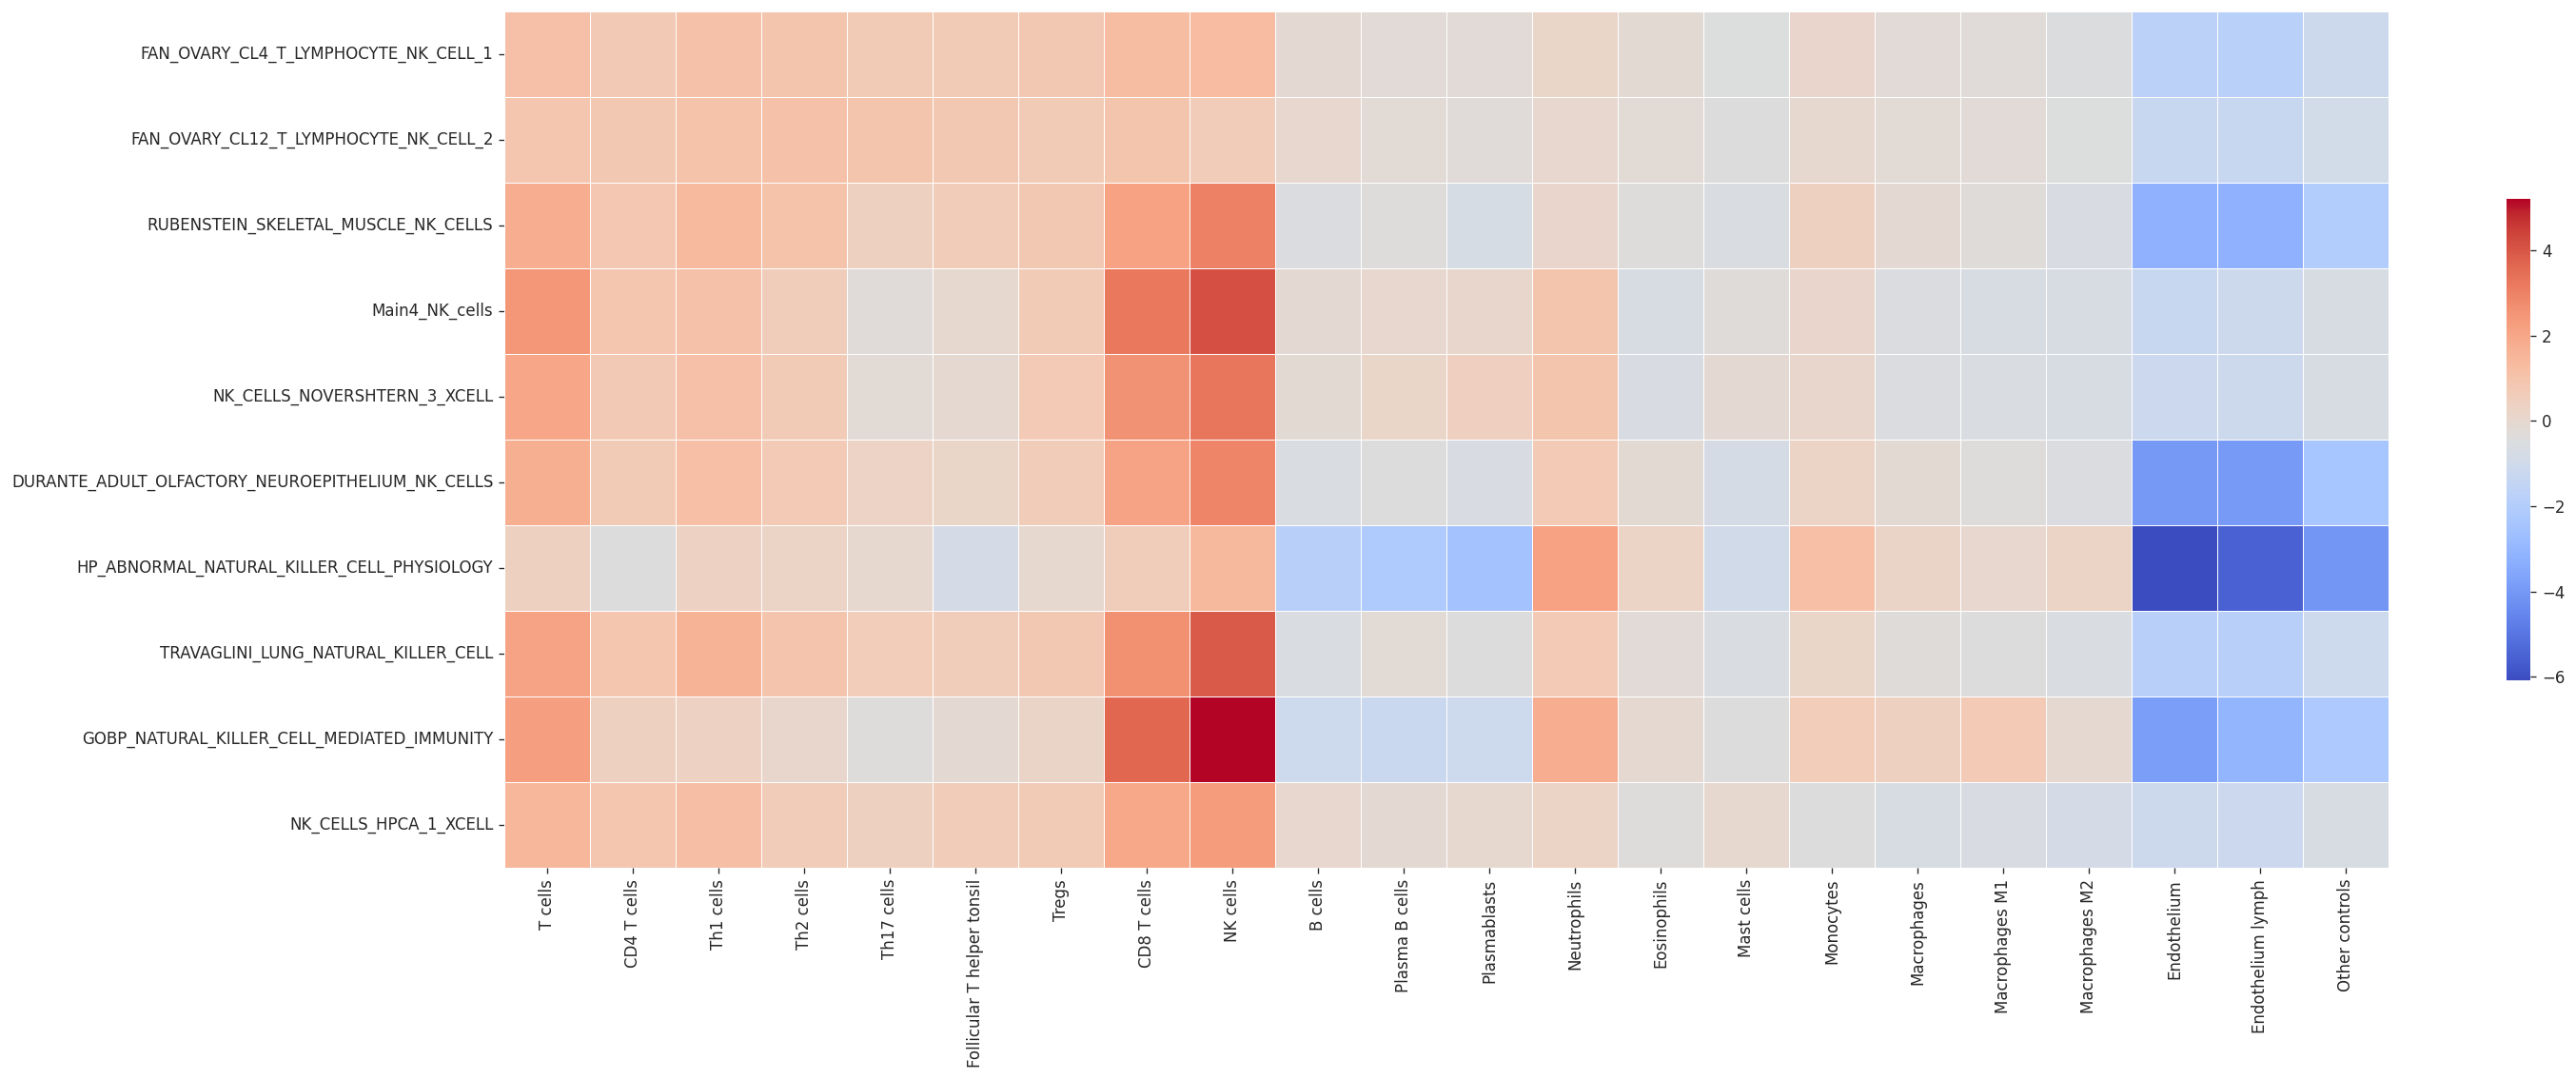

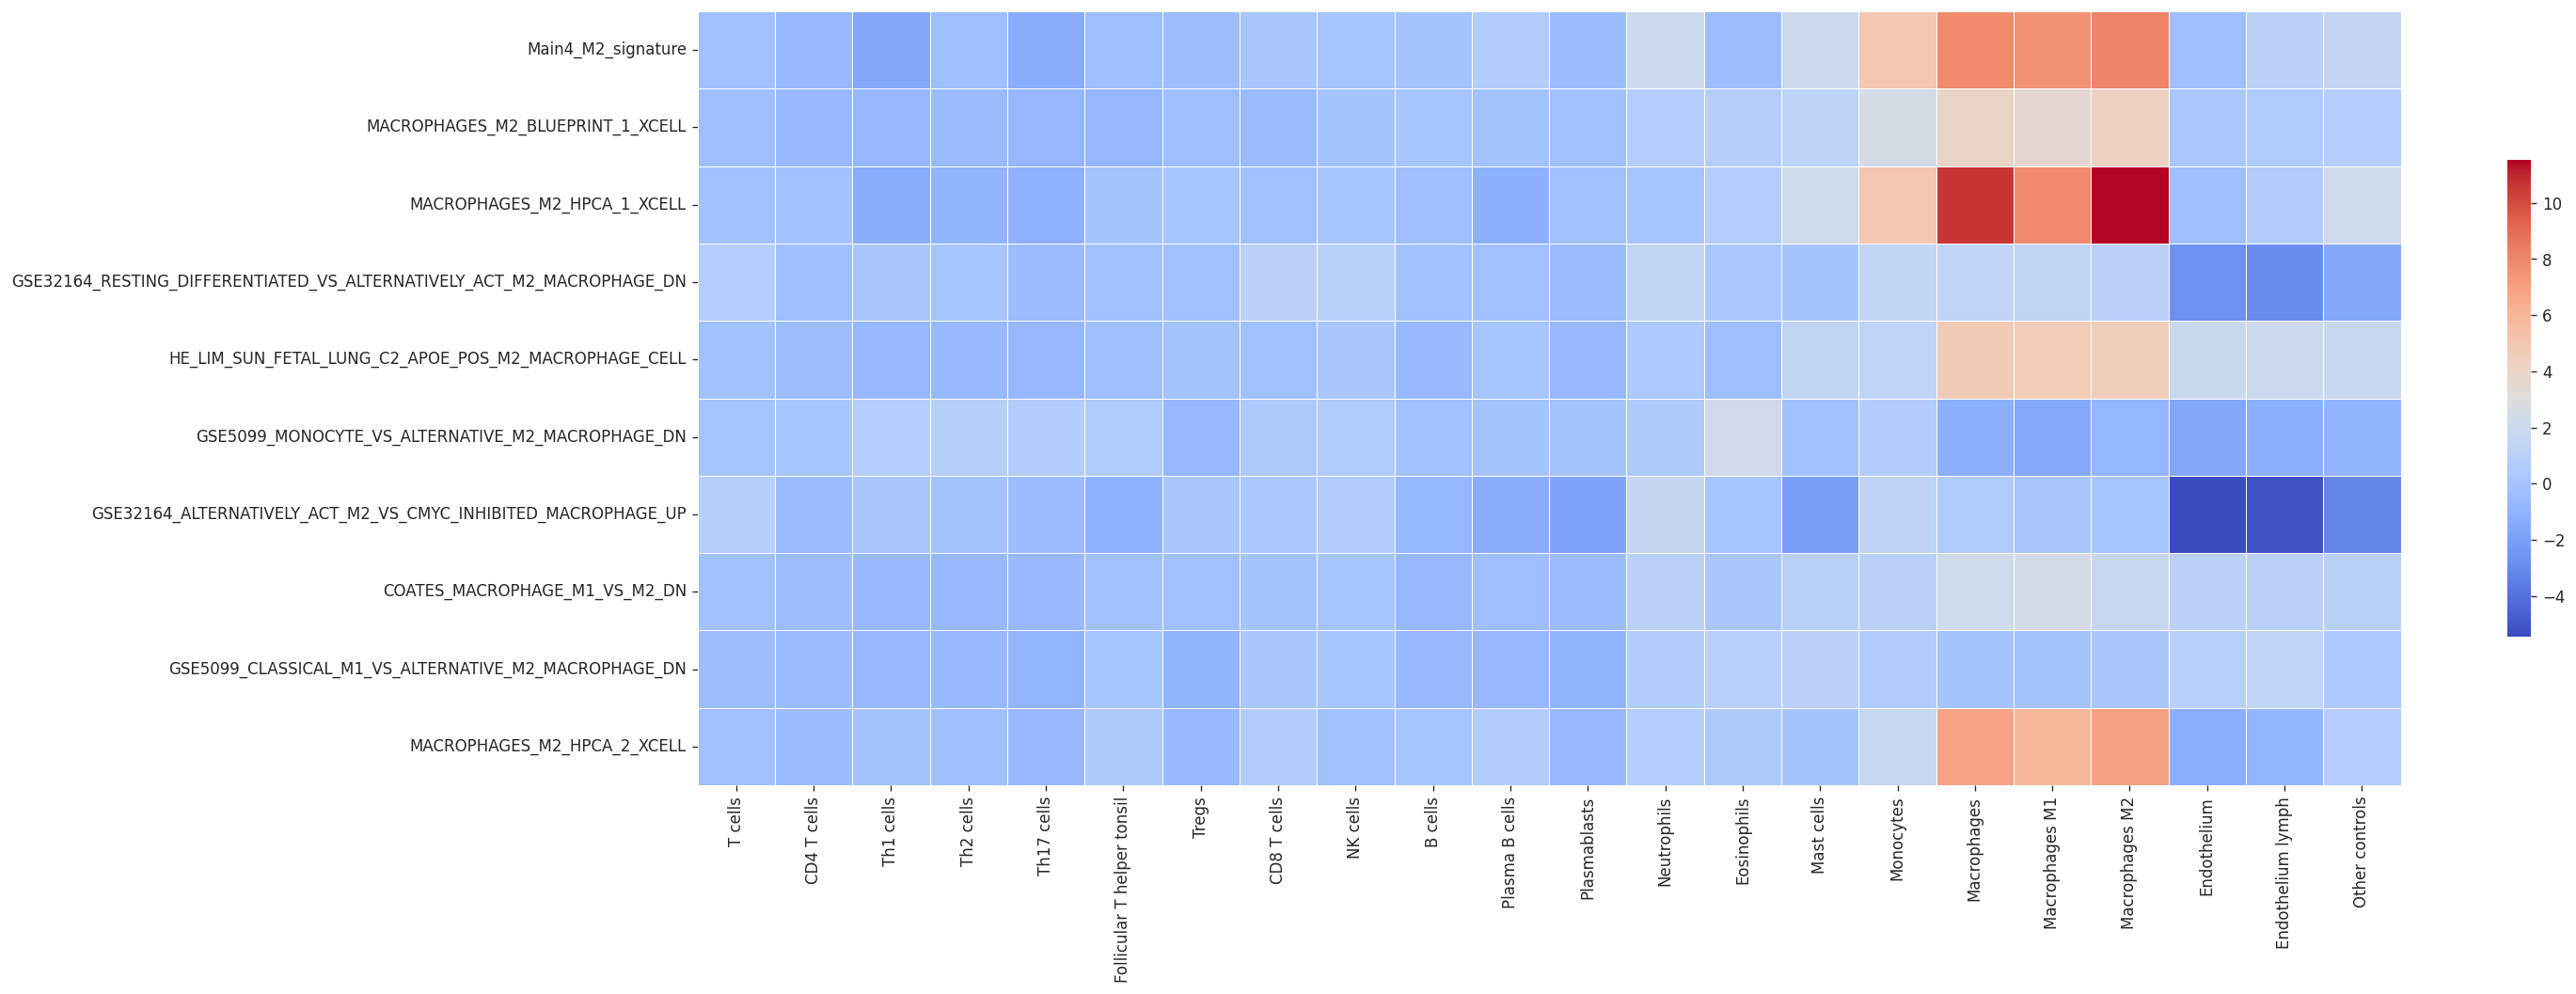

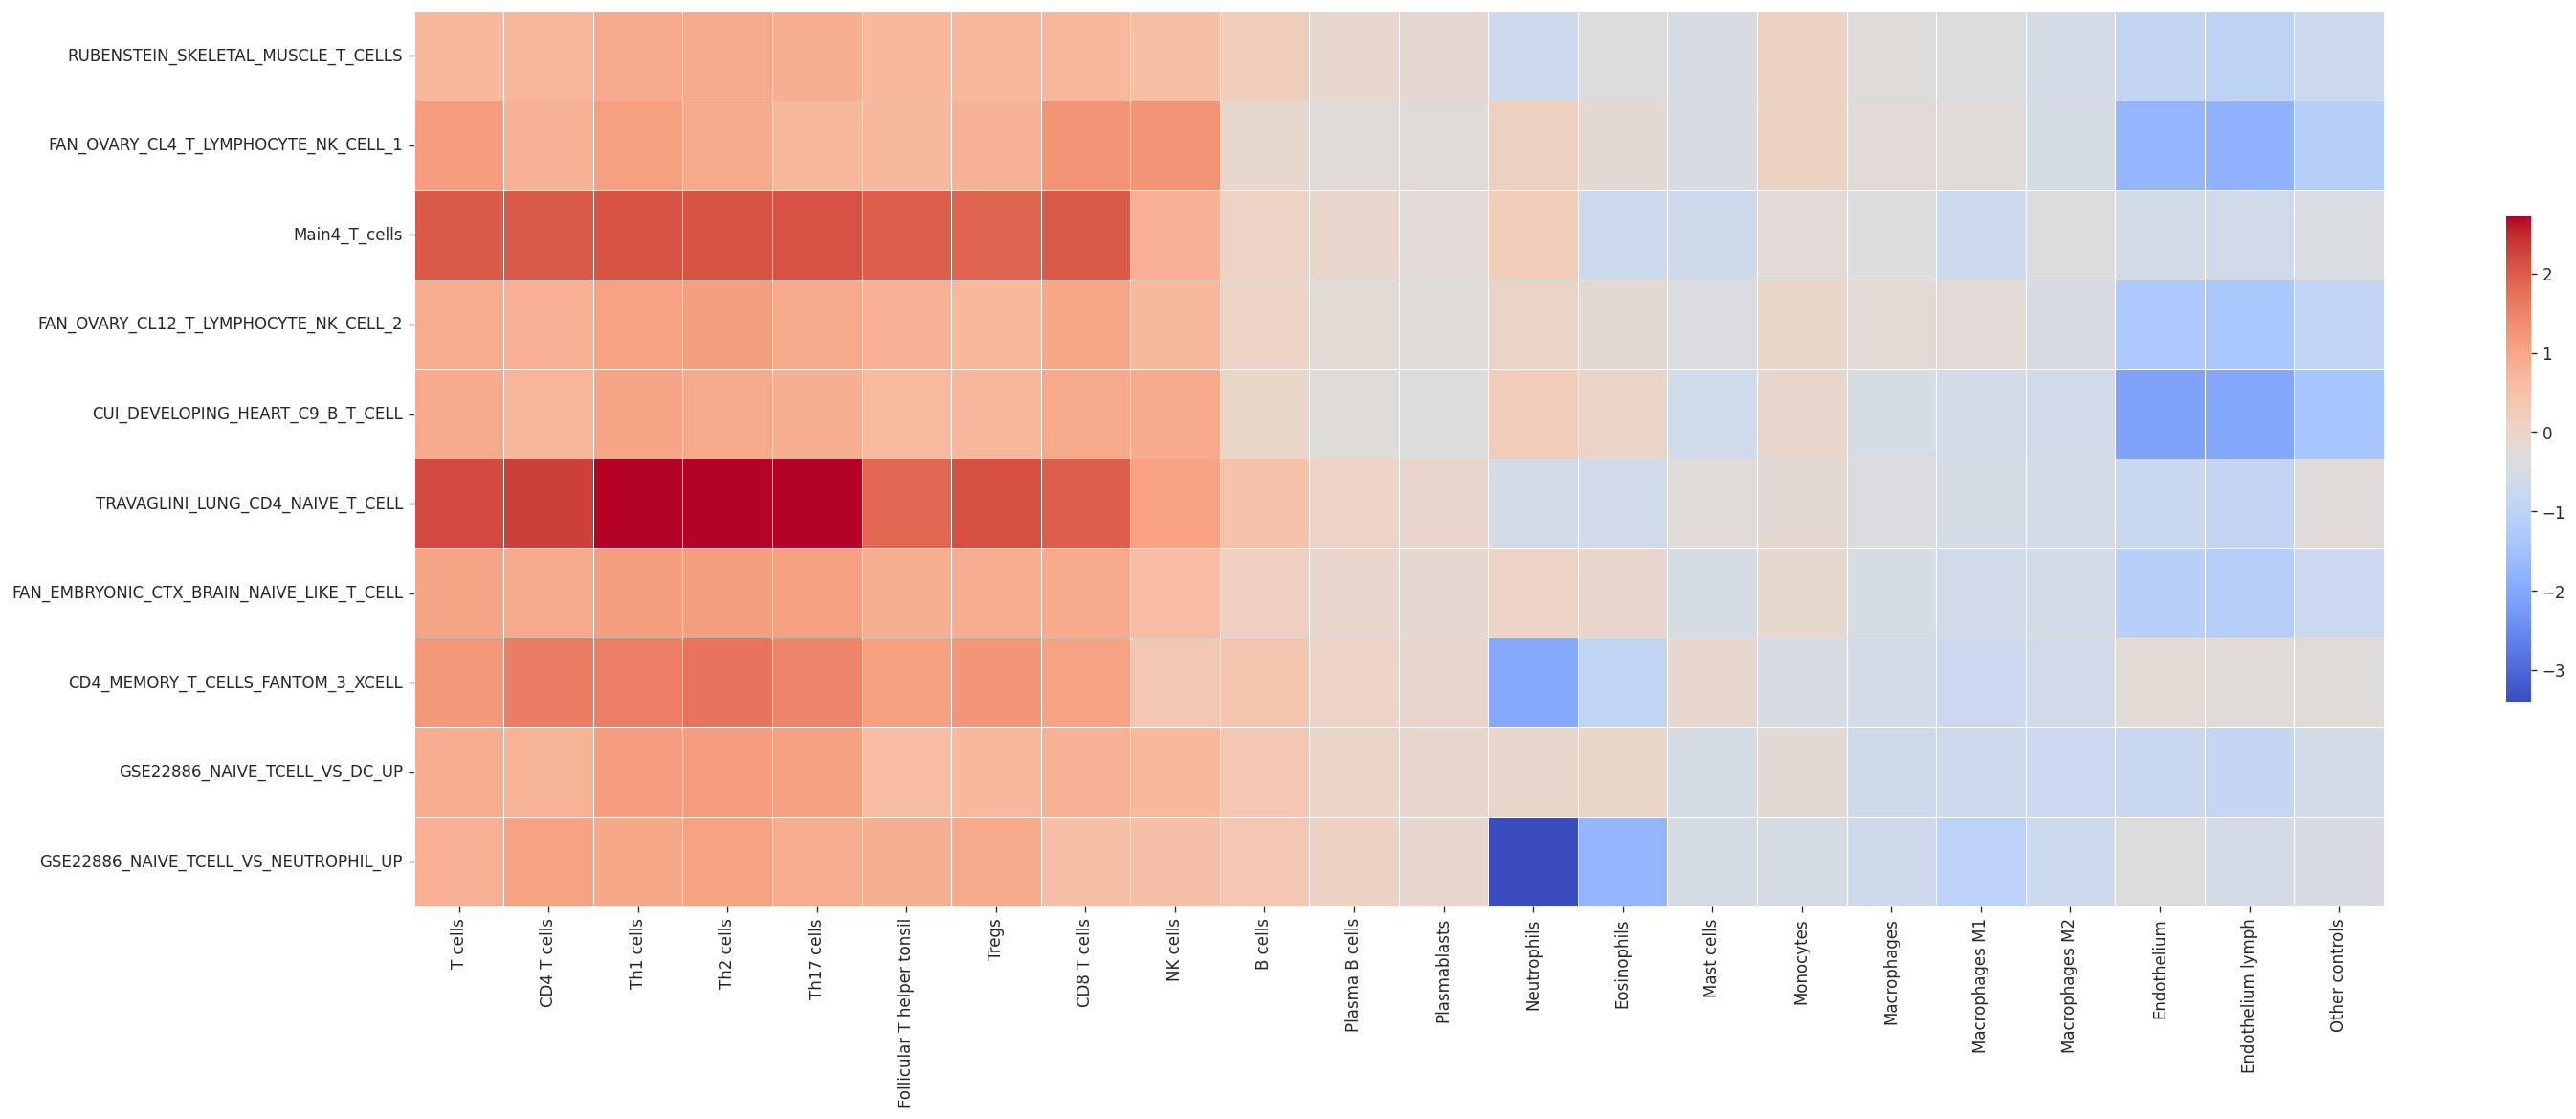

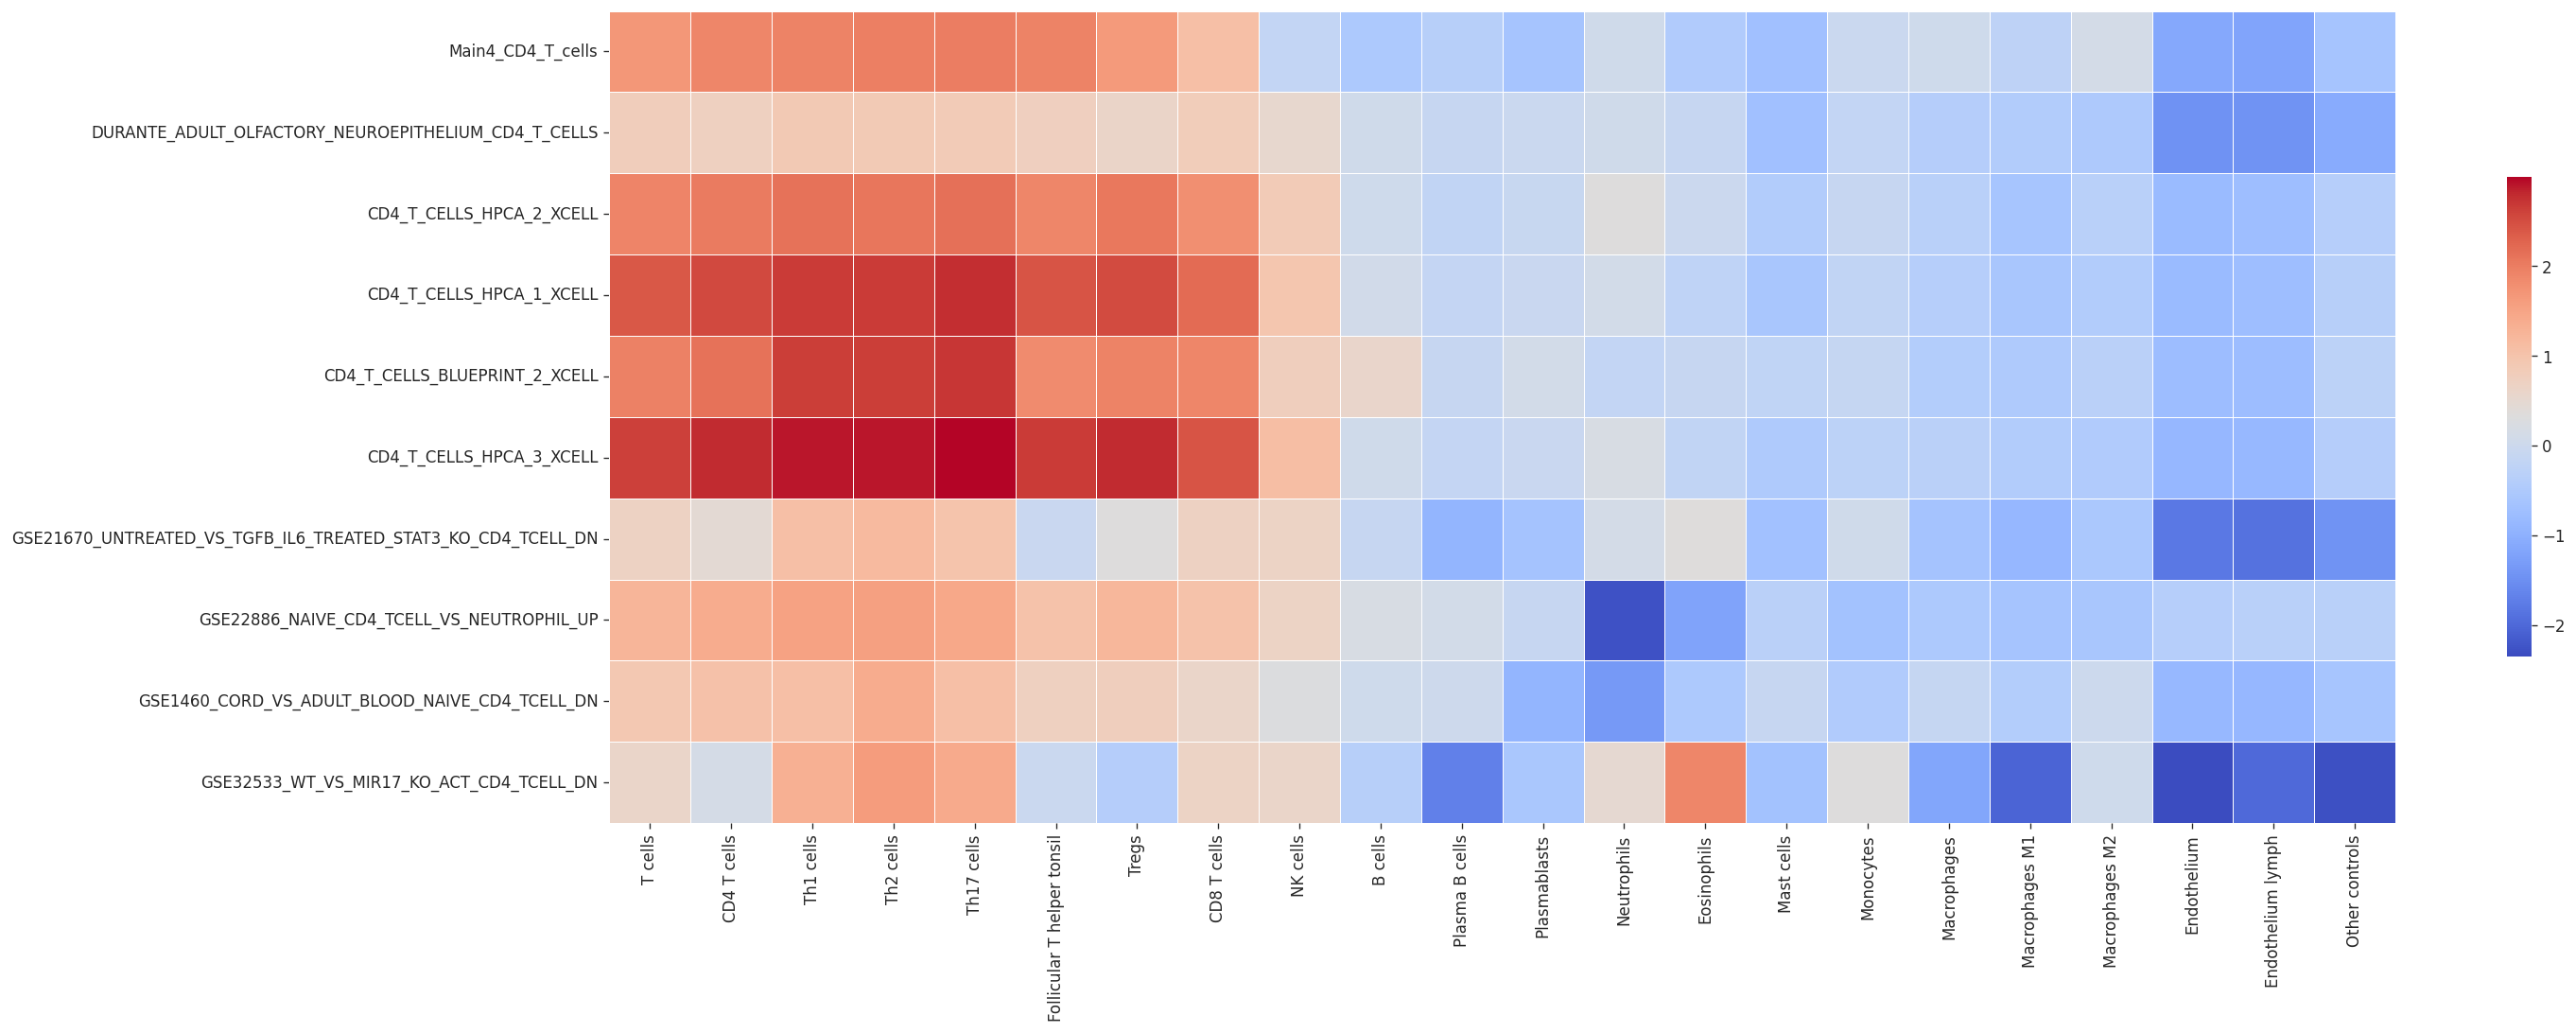

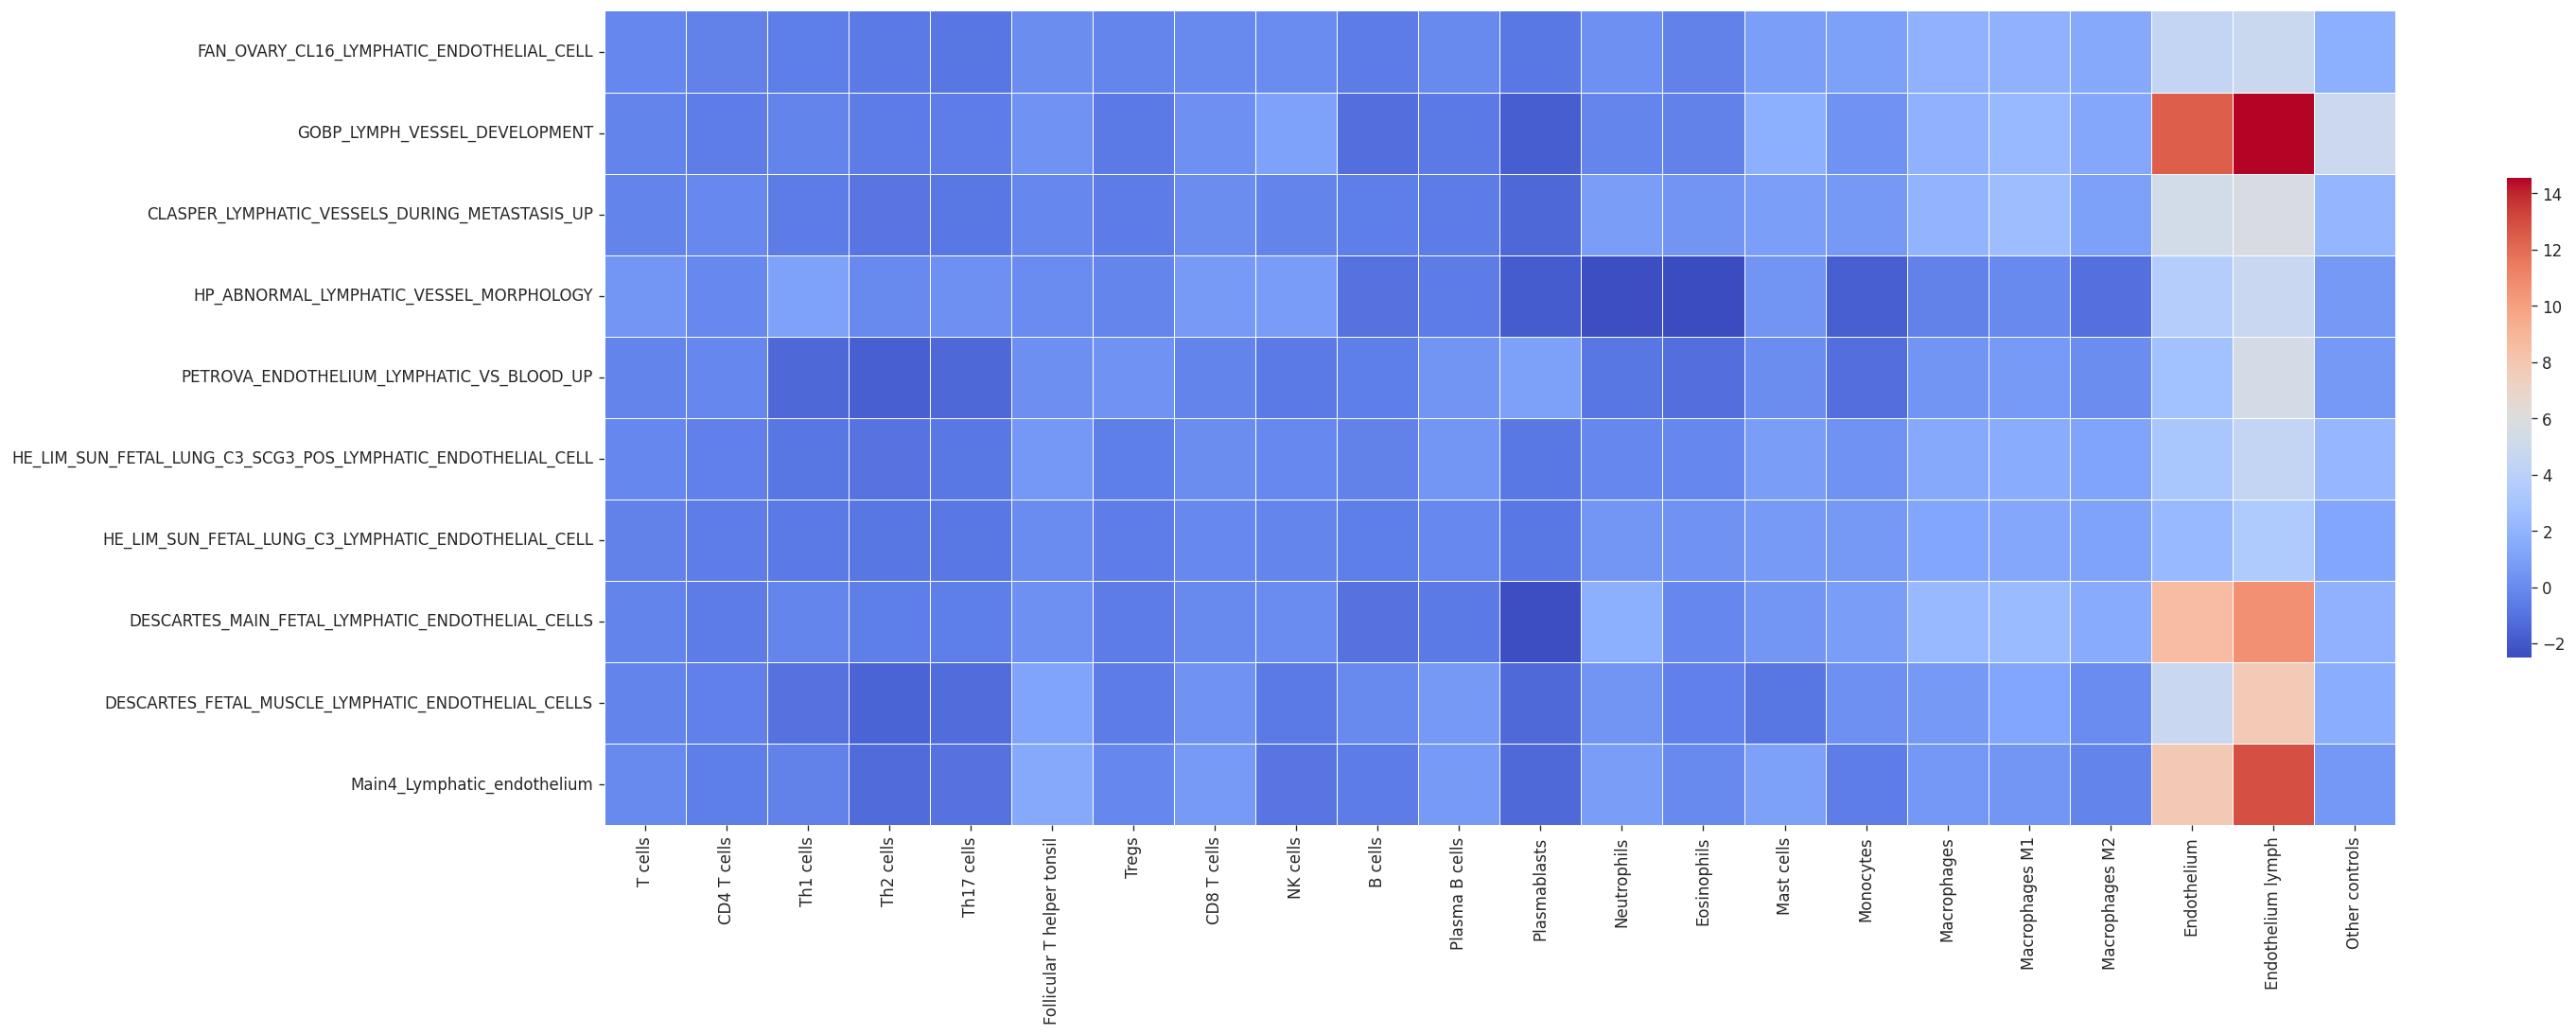

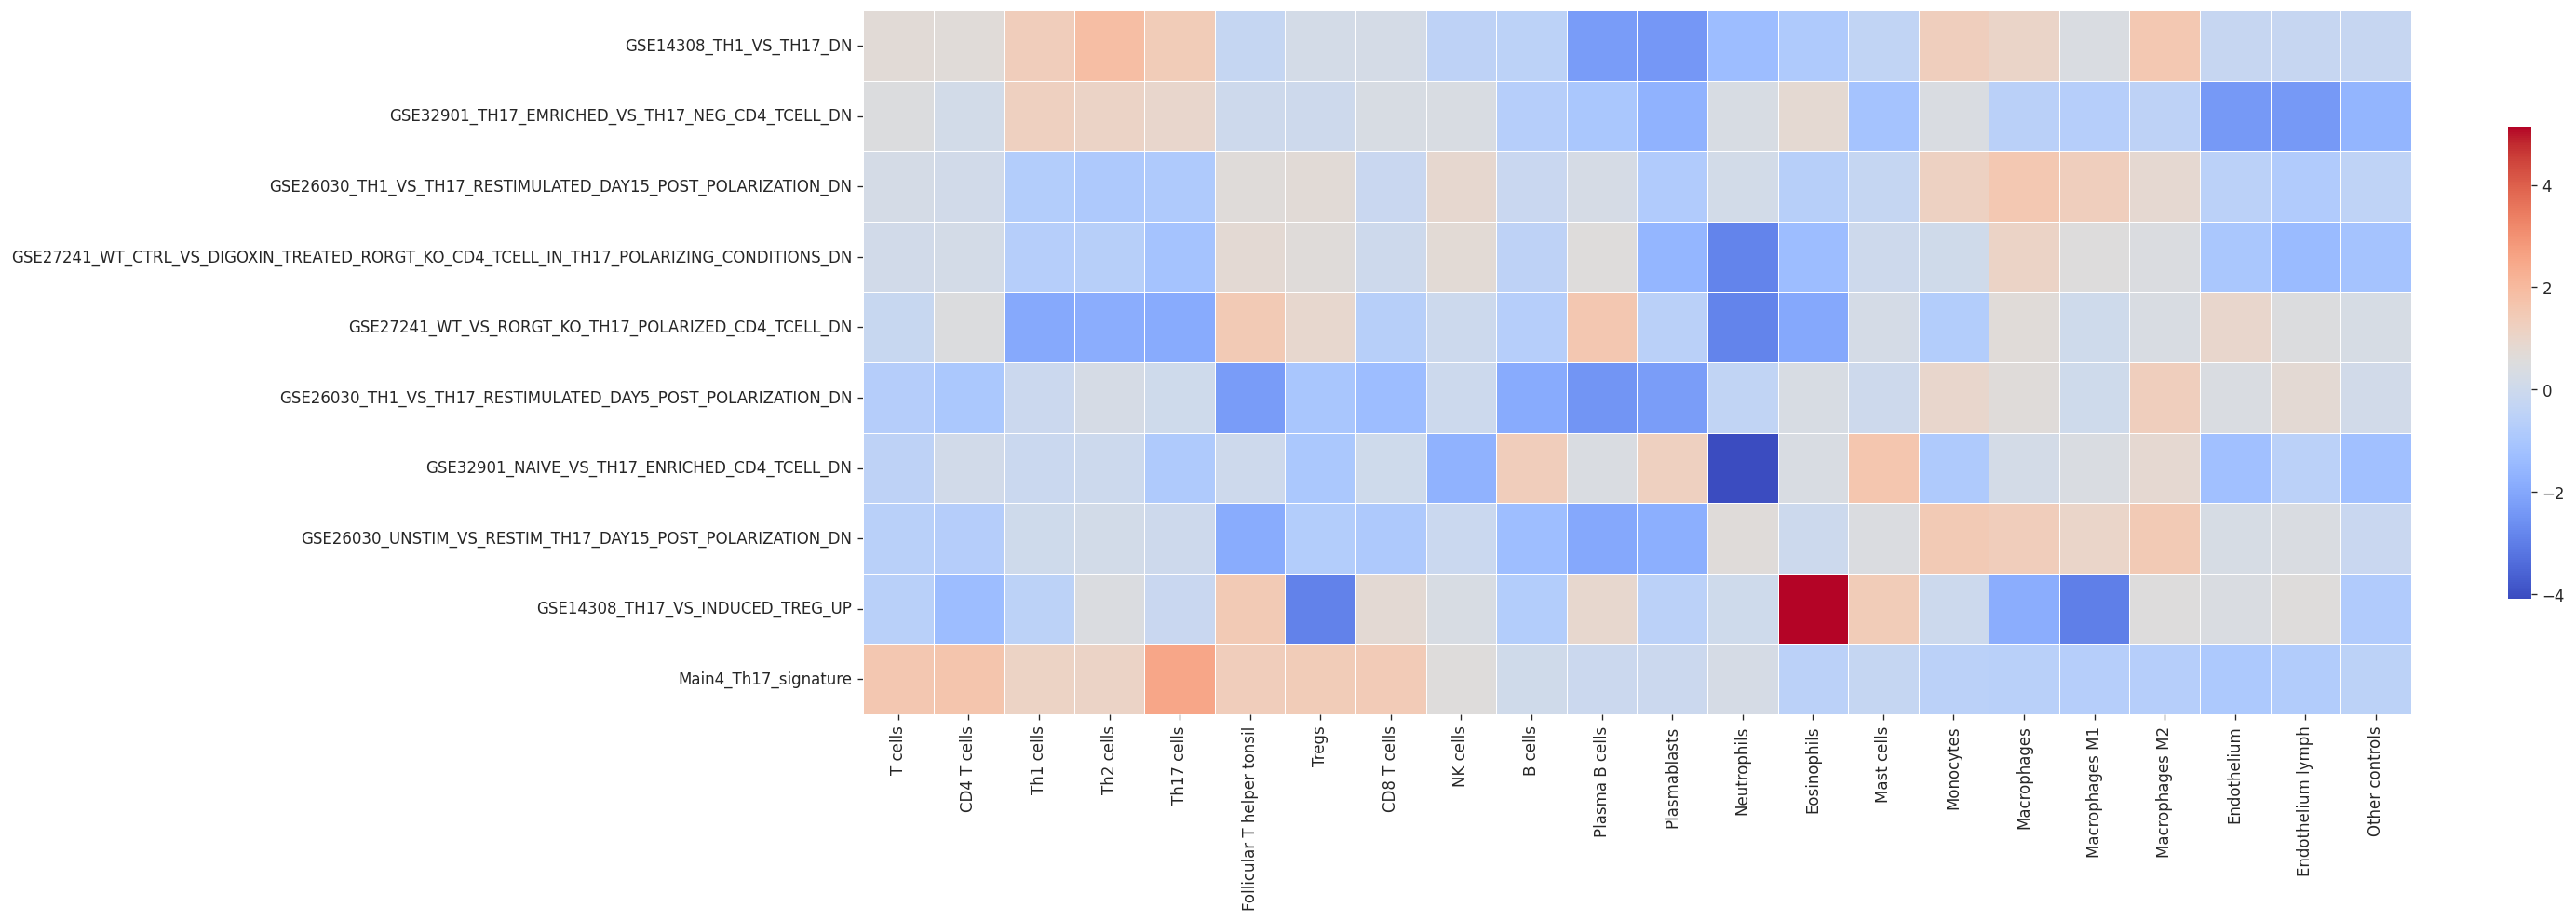

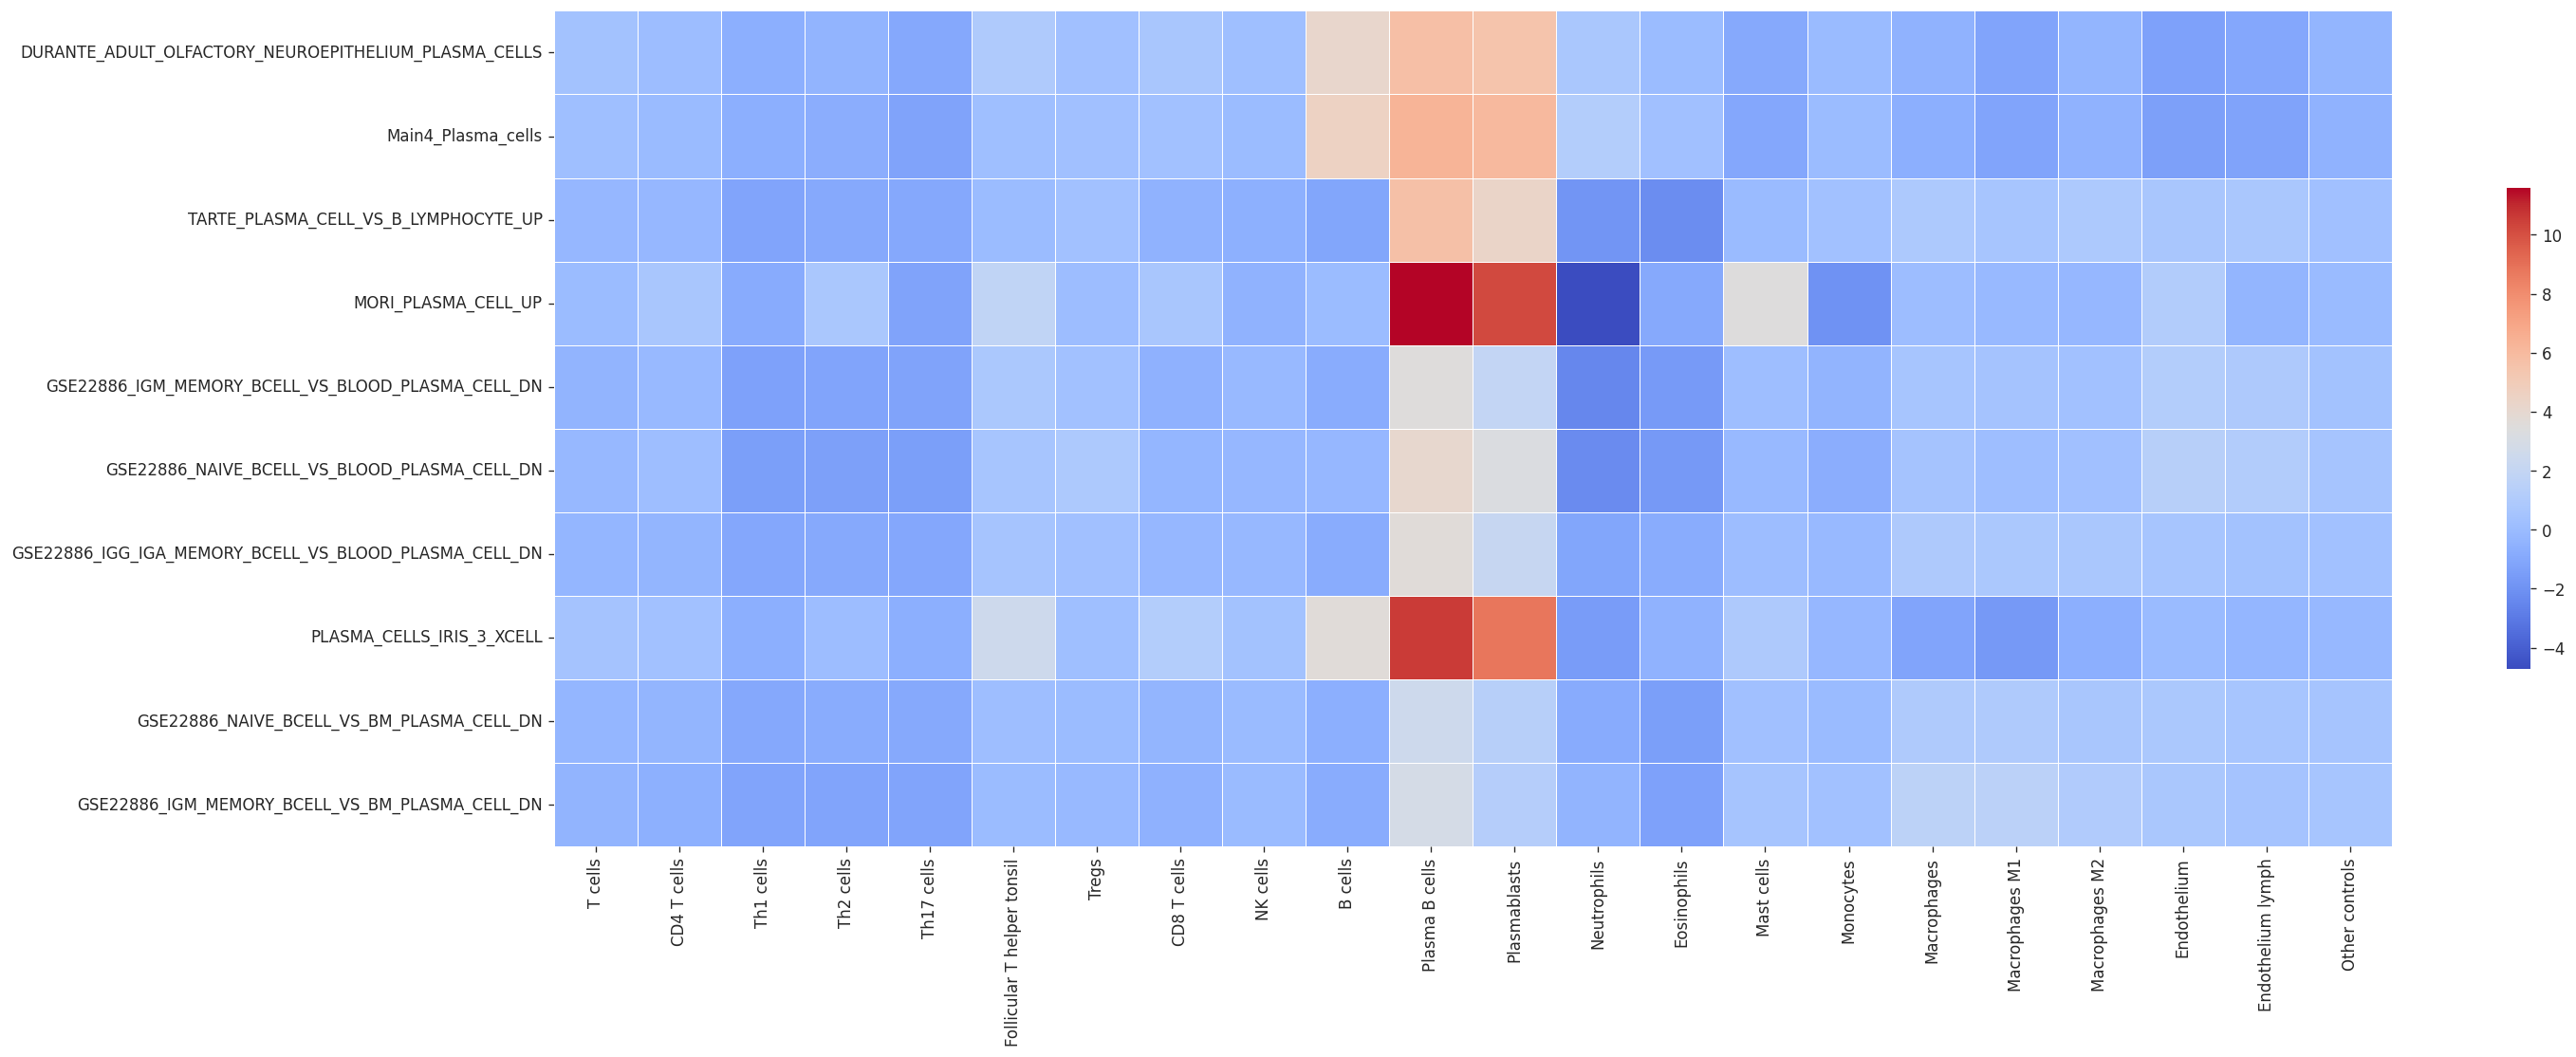

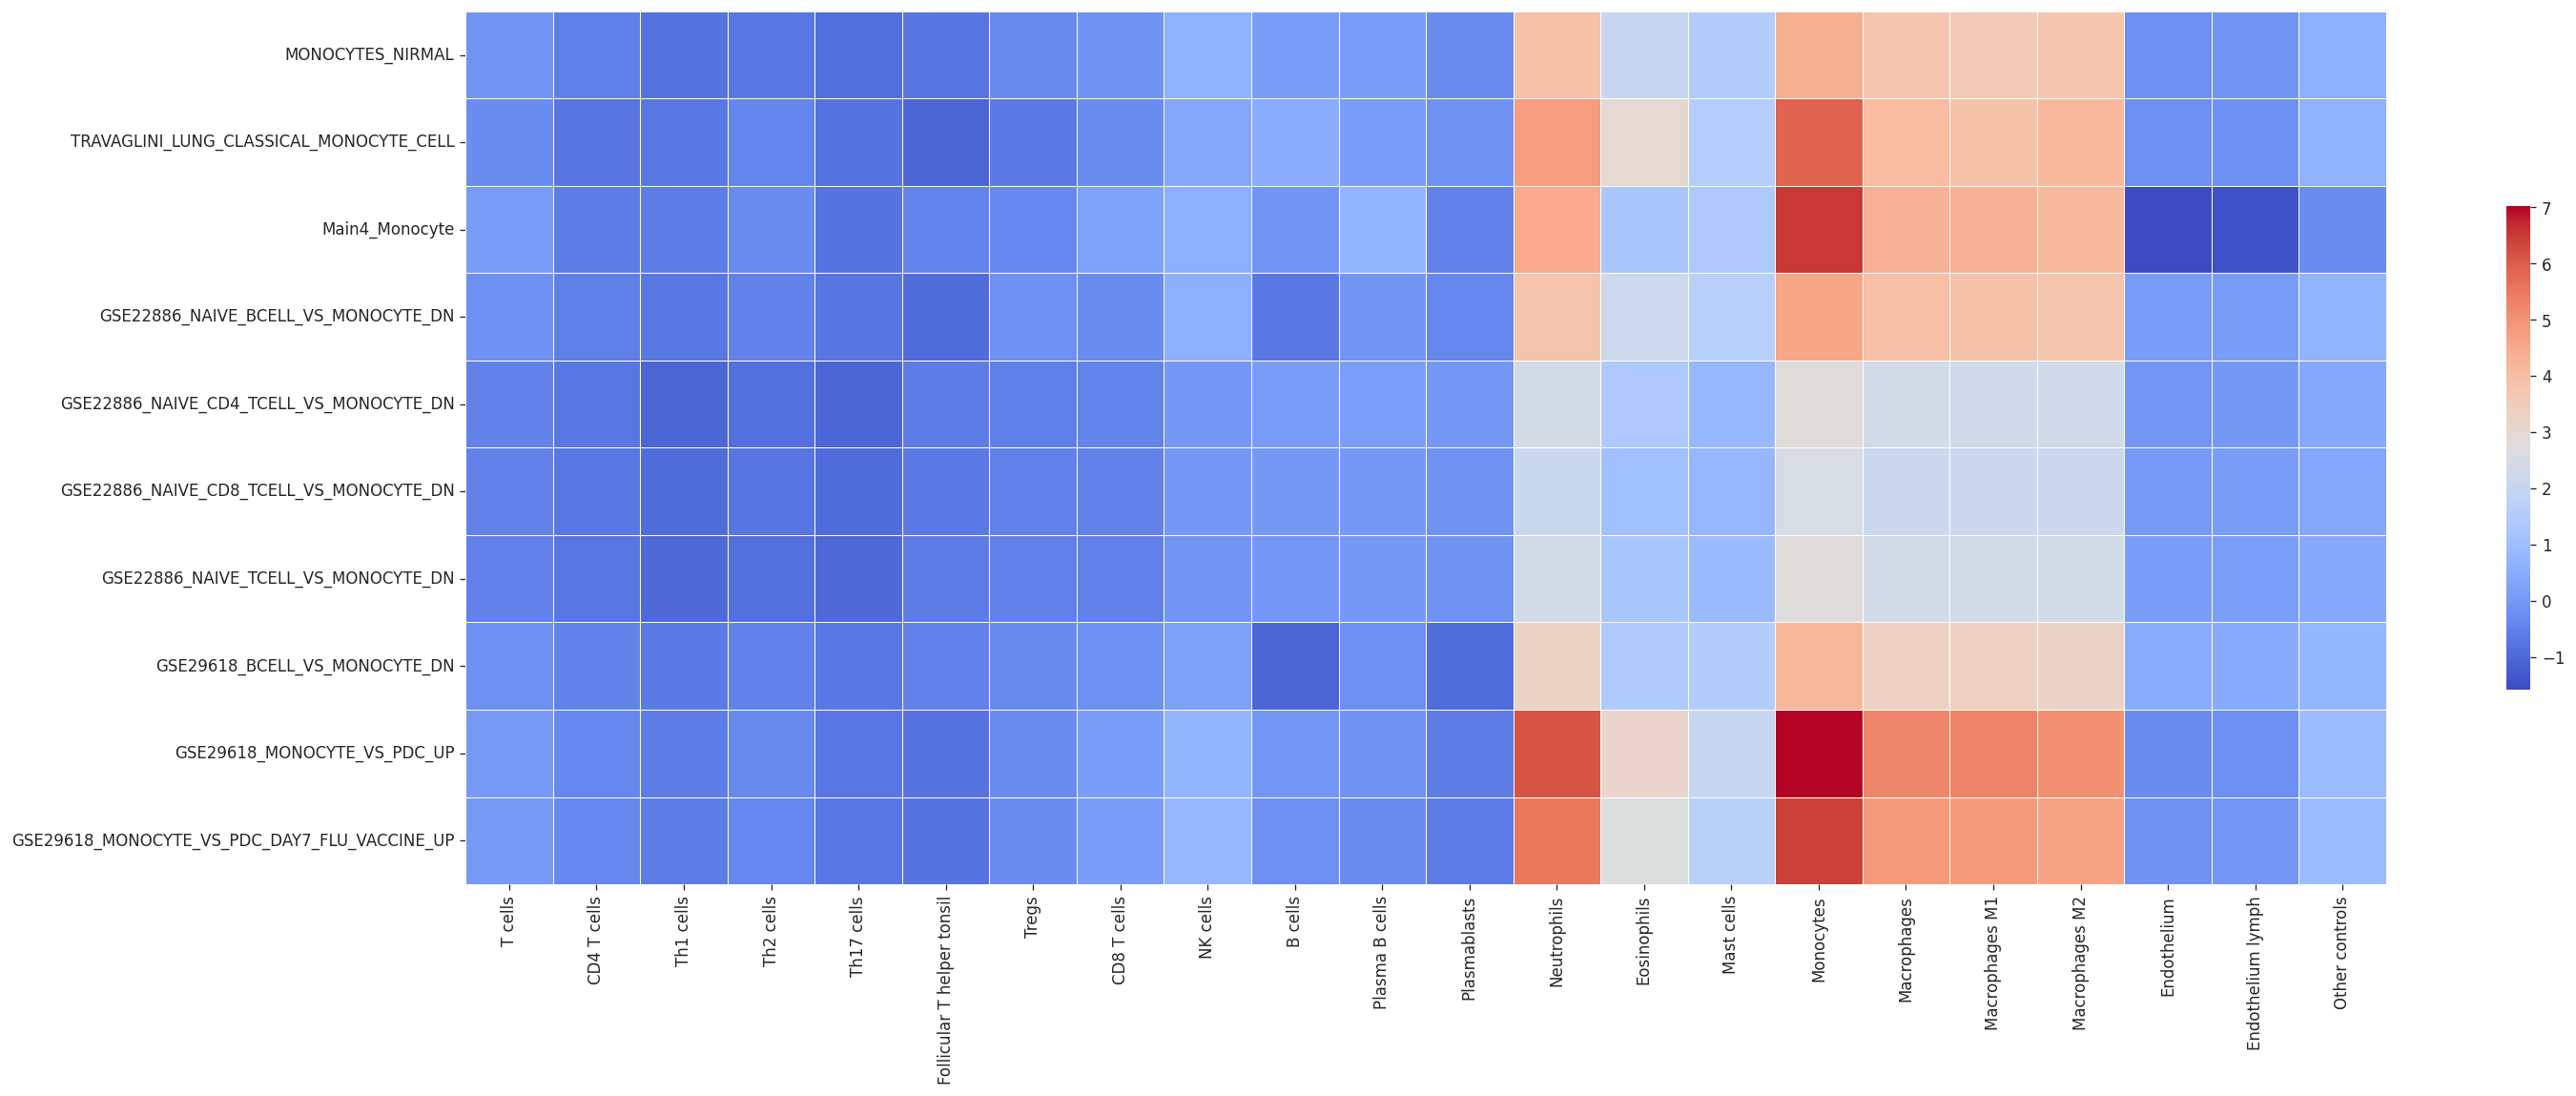

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
t = 10
for bg_sign in msigdb_gmt.keys():
    signs = msigdb_gmt[bg_sign].keys()
    scores = pd.DataFrame({s: pd.DataFrame(fges_metrics[s]).T.mean() for s in signs}).T
    ind = scores.sort_values(
        by=["goi_cv", "F1", "control_cv"], ascending=[True, False, True]
    ).index
    ind = ind[~ind.duplicated()].to_list()
    ind = [i for i in ind if "RANDOM" not in i][:t]
    if bg_sign not in ind:
        ind = ind[: (t - 1)] + [bg_sign]
        print(bg_sign)
    data = df[ind].T
    data = data[~data.index.duplicated()]
    ls = labels.reindex(data.columns)
    data = data.T.groupby(ls).mean().T[controls_order_short]

    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(
        median_scale(data.T).T,
        cmap=default_cmap,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        cbar=True,
        annot=False,
        fmt=".1f",
        square=True,
        cbar_kws={"shrink": 0.5},
        linewidths=0.5,
    )
    ax.set_xticklabels([i.replace("_", " ") for i in controls_order_short], rotation=90)
    yticks = ind
    ax.set_yticklabels(yticks)
    plt.tight_layout(pad=0.2)
    plt.savefig(
        p / f"svg_pictures_median_heatmaps/top10_median_heatmap_for_{bg_sign}.svg",
        format="svg",
    )

Main4_Th17_signature


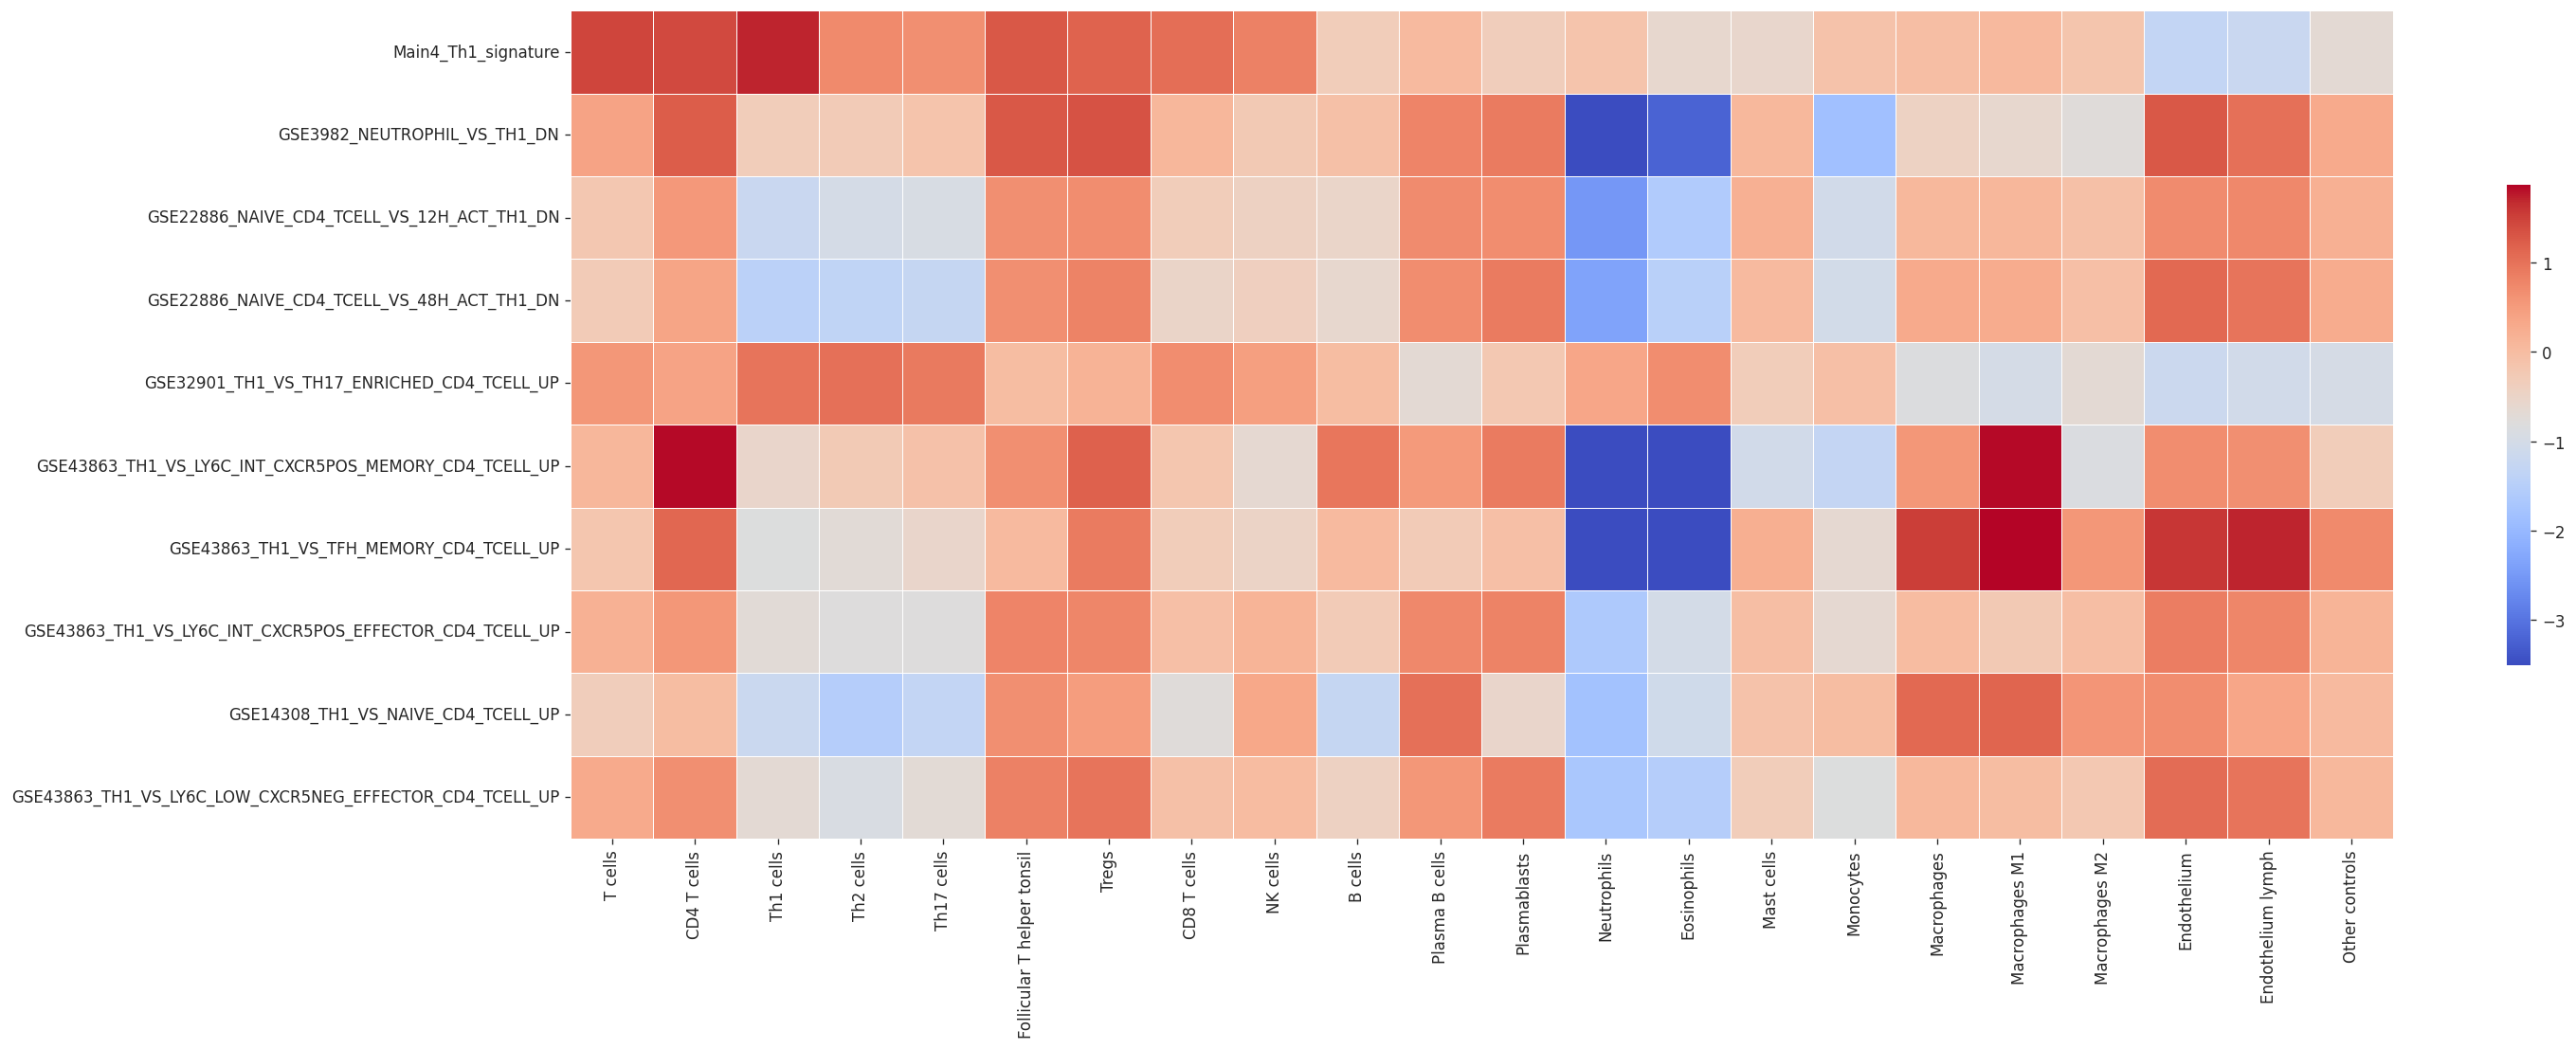

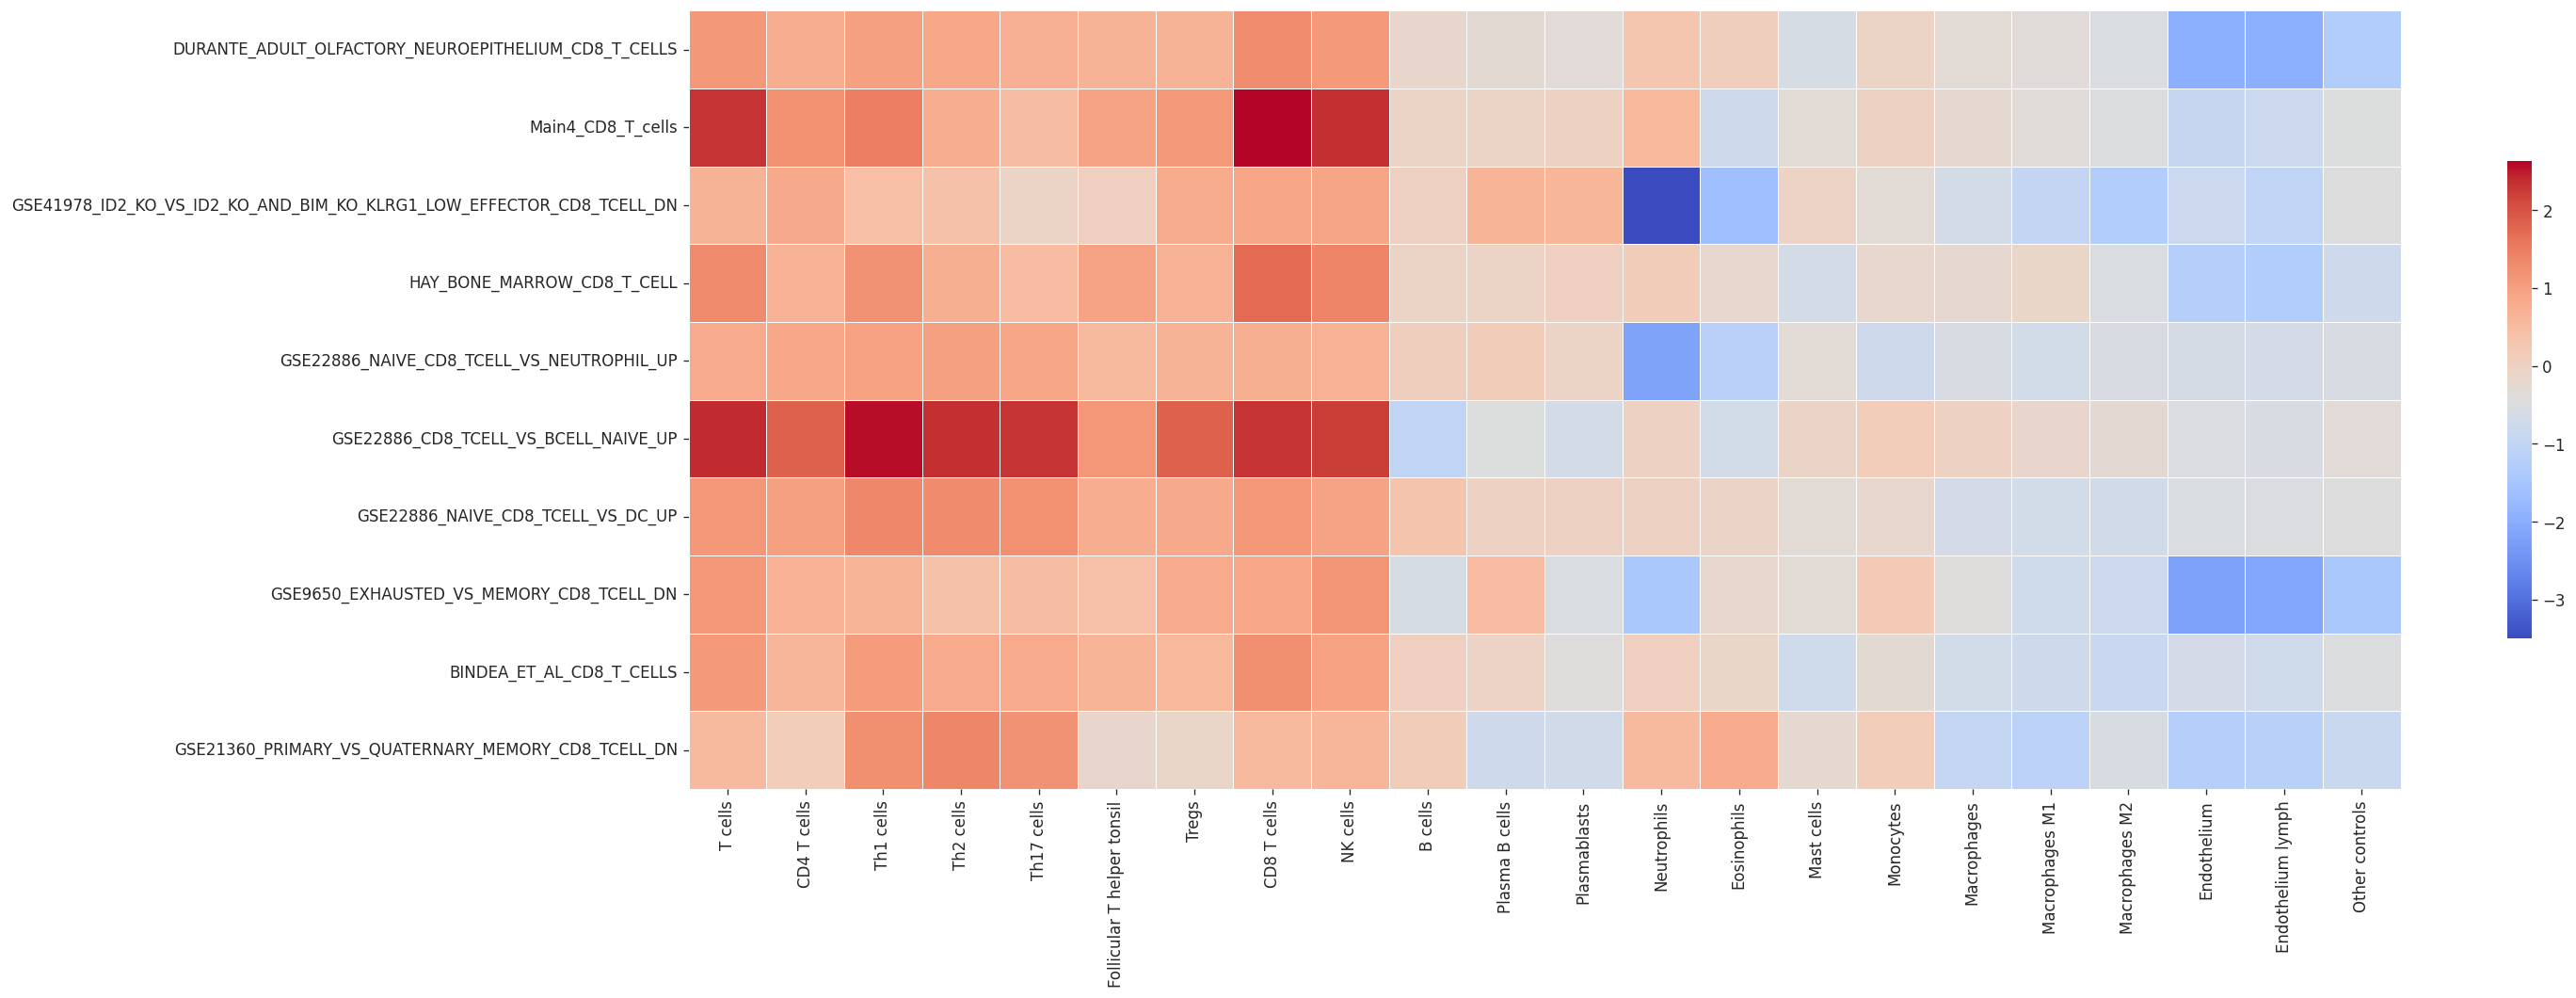

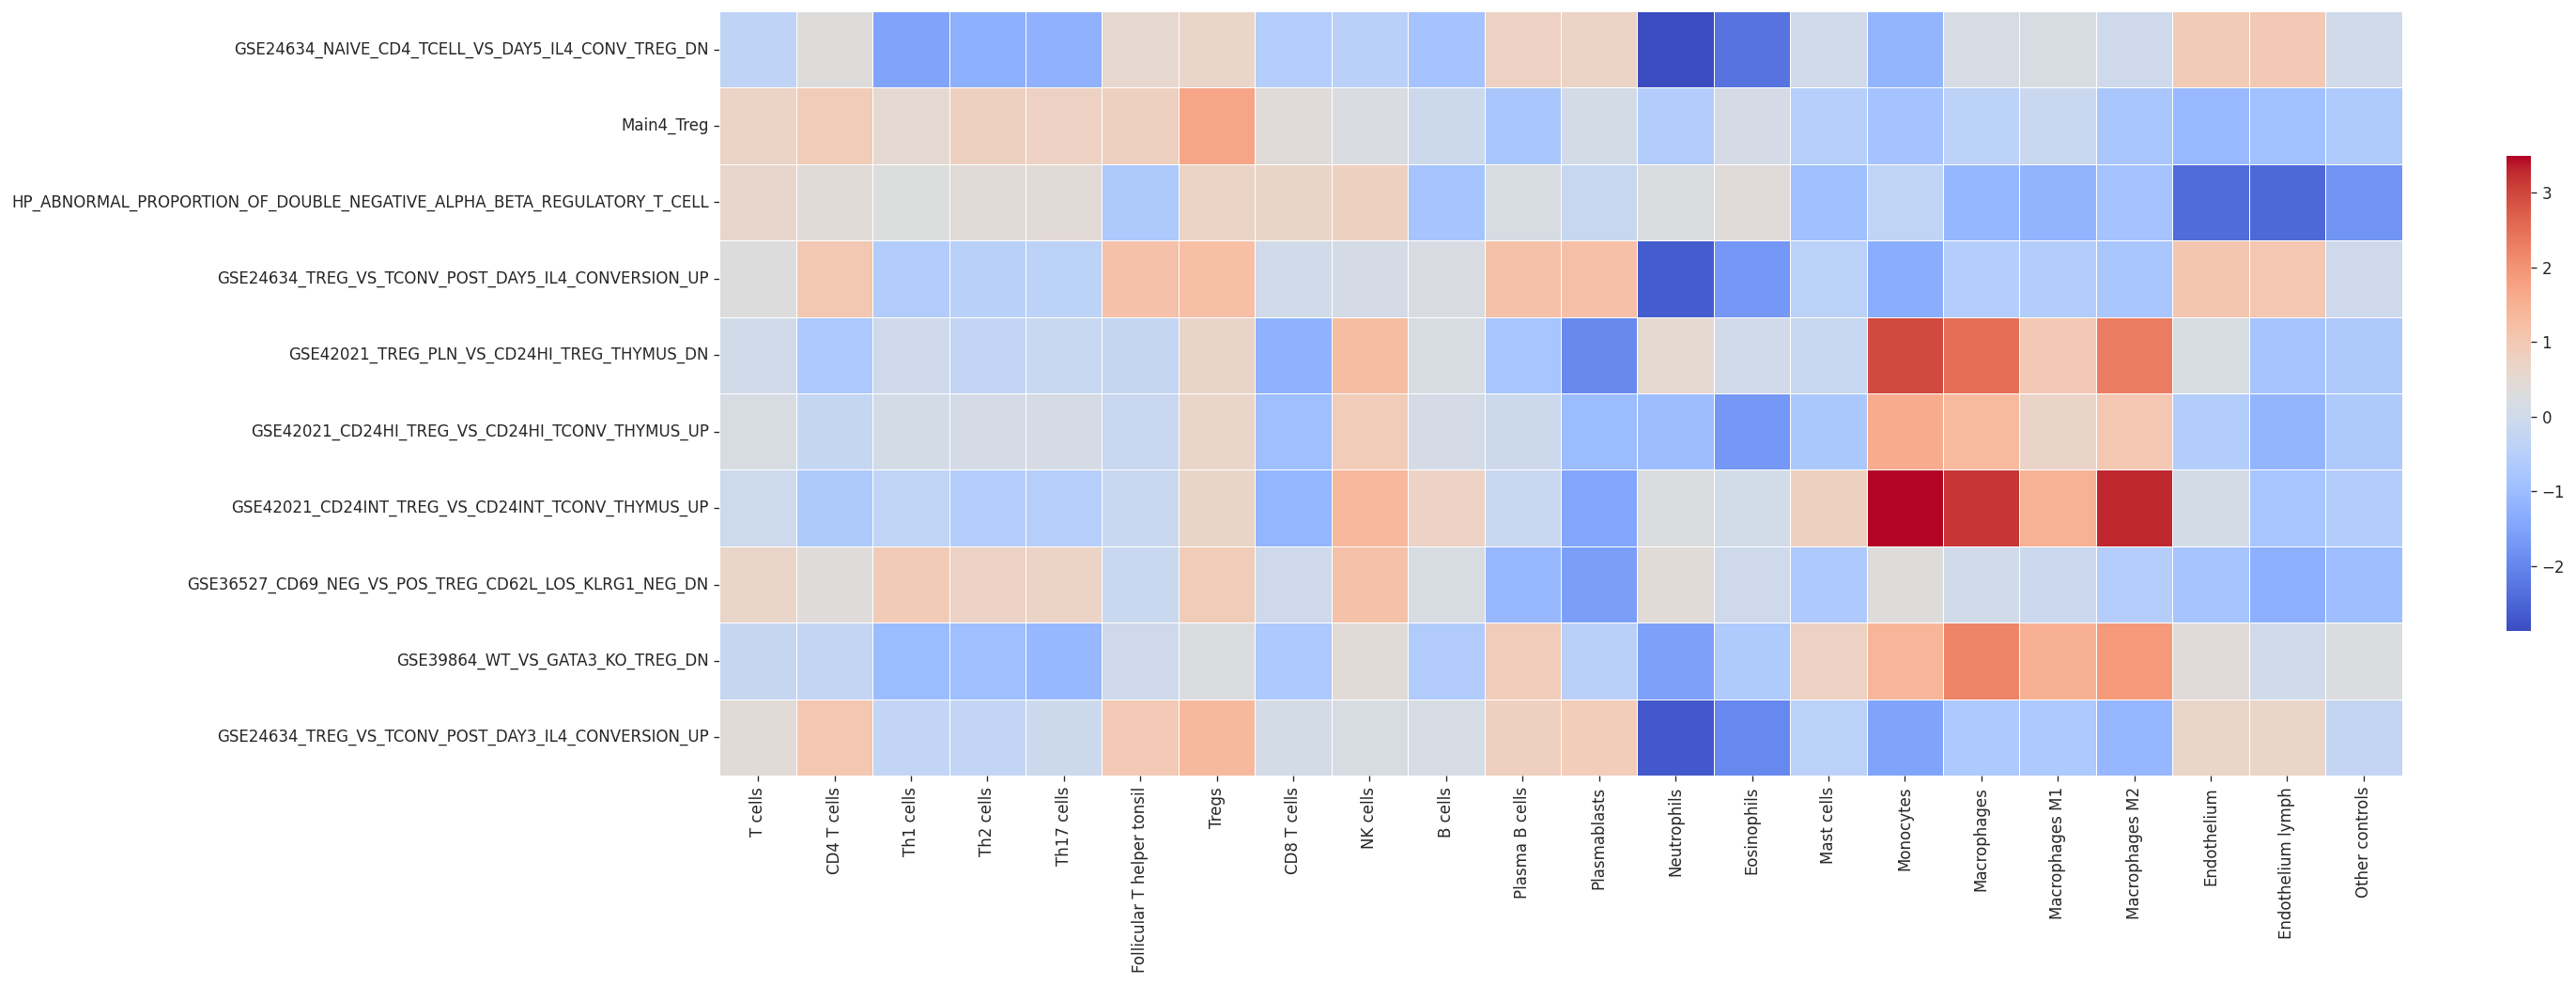

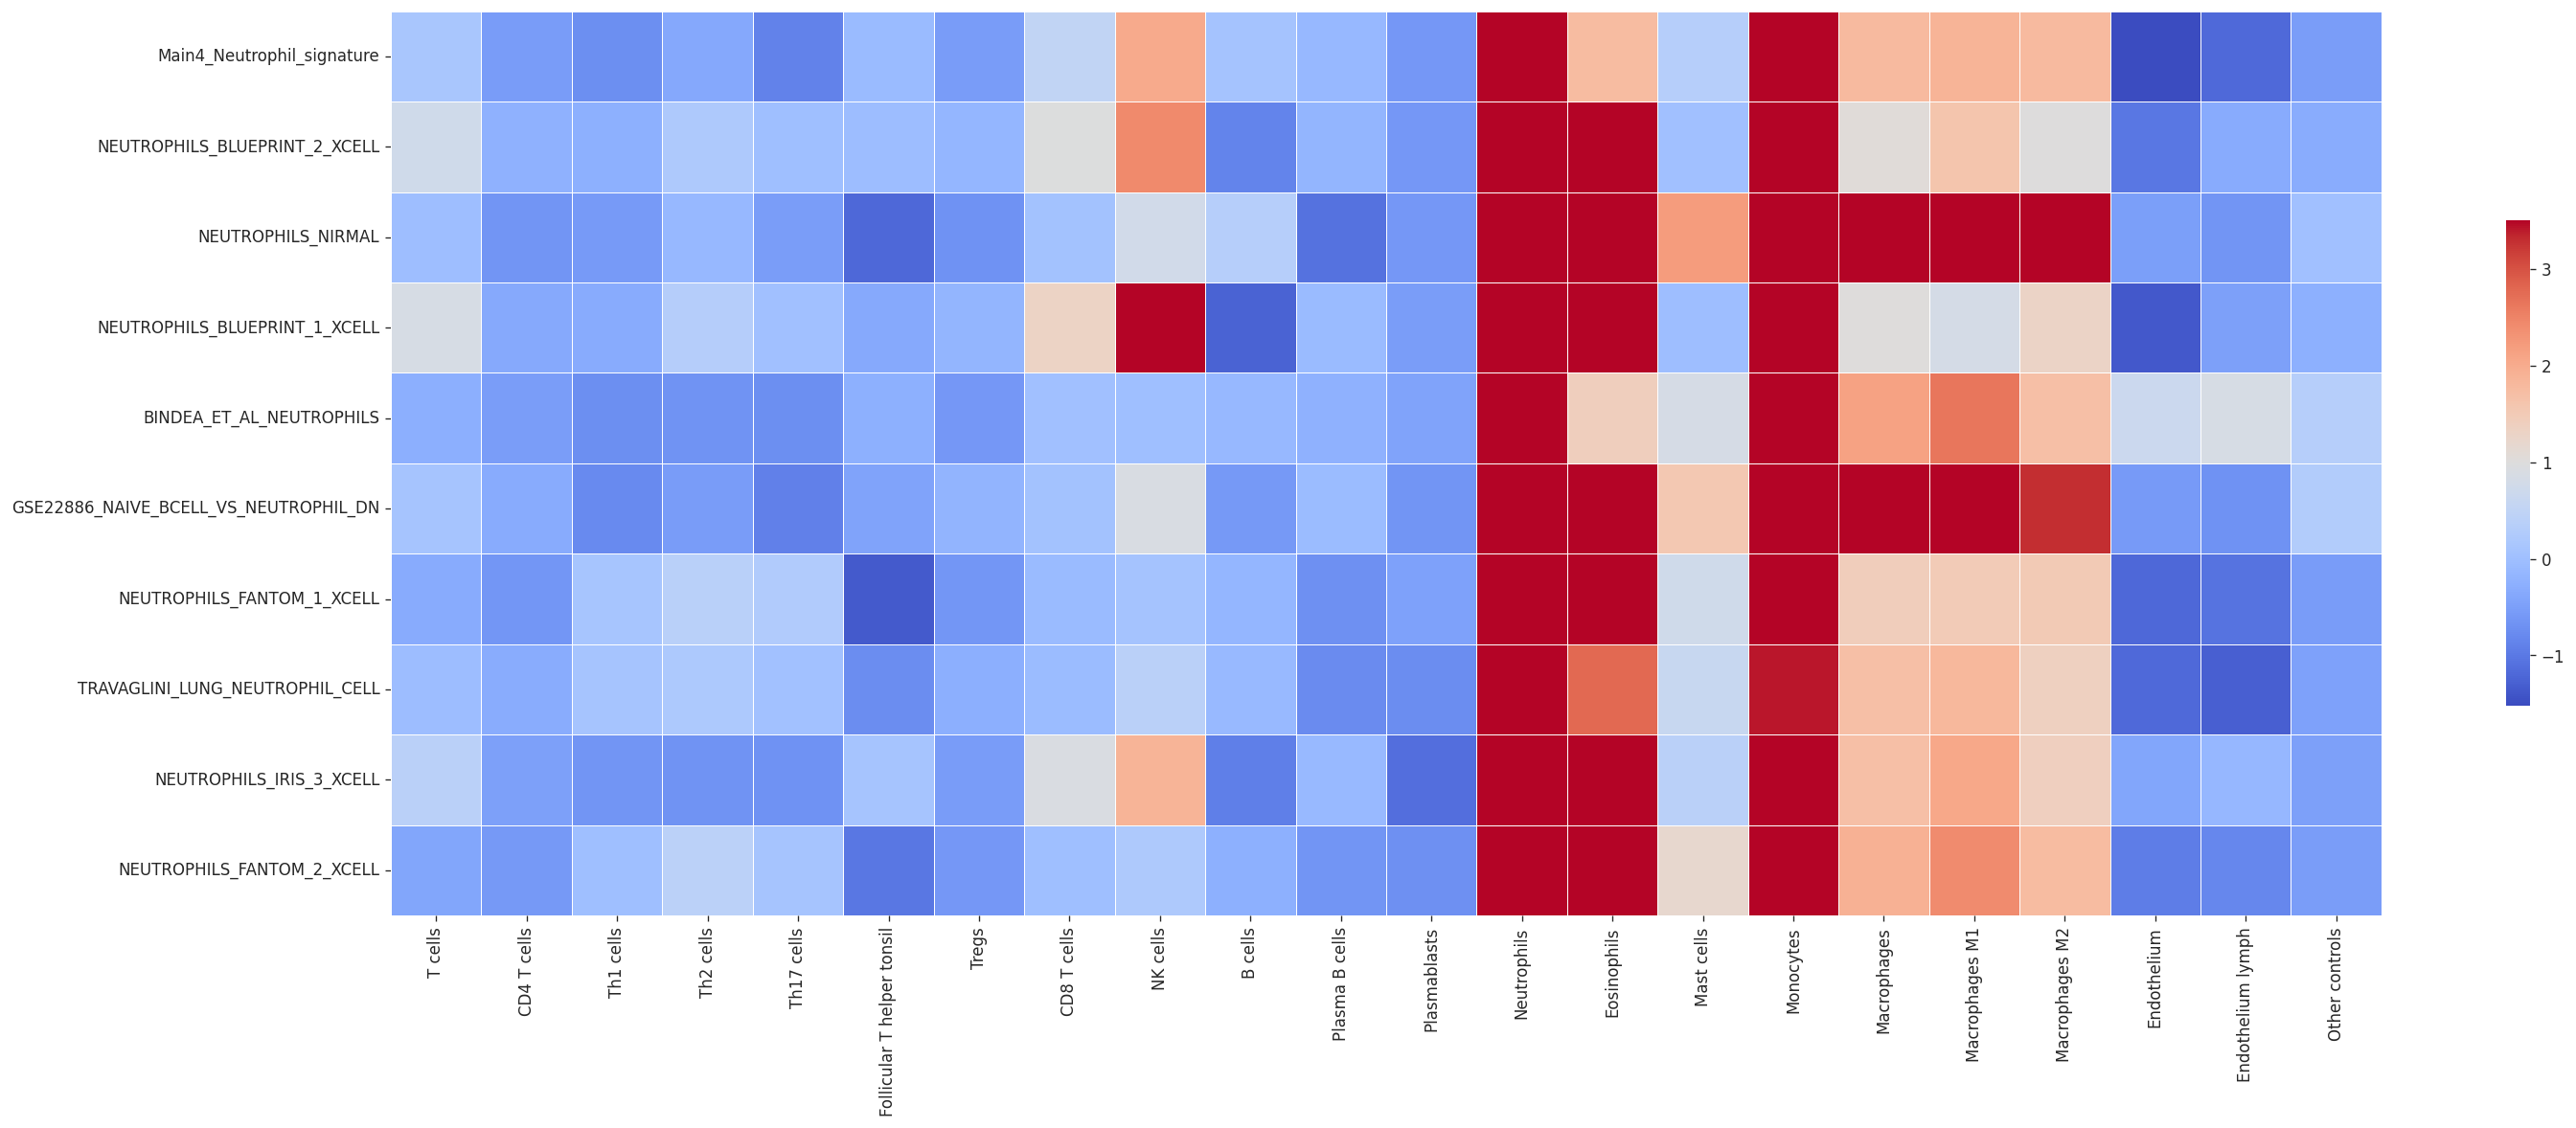

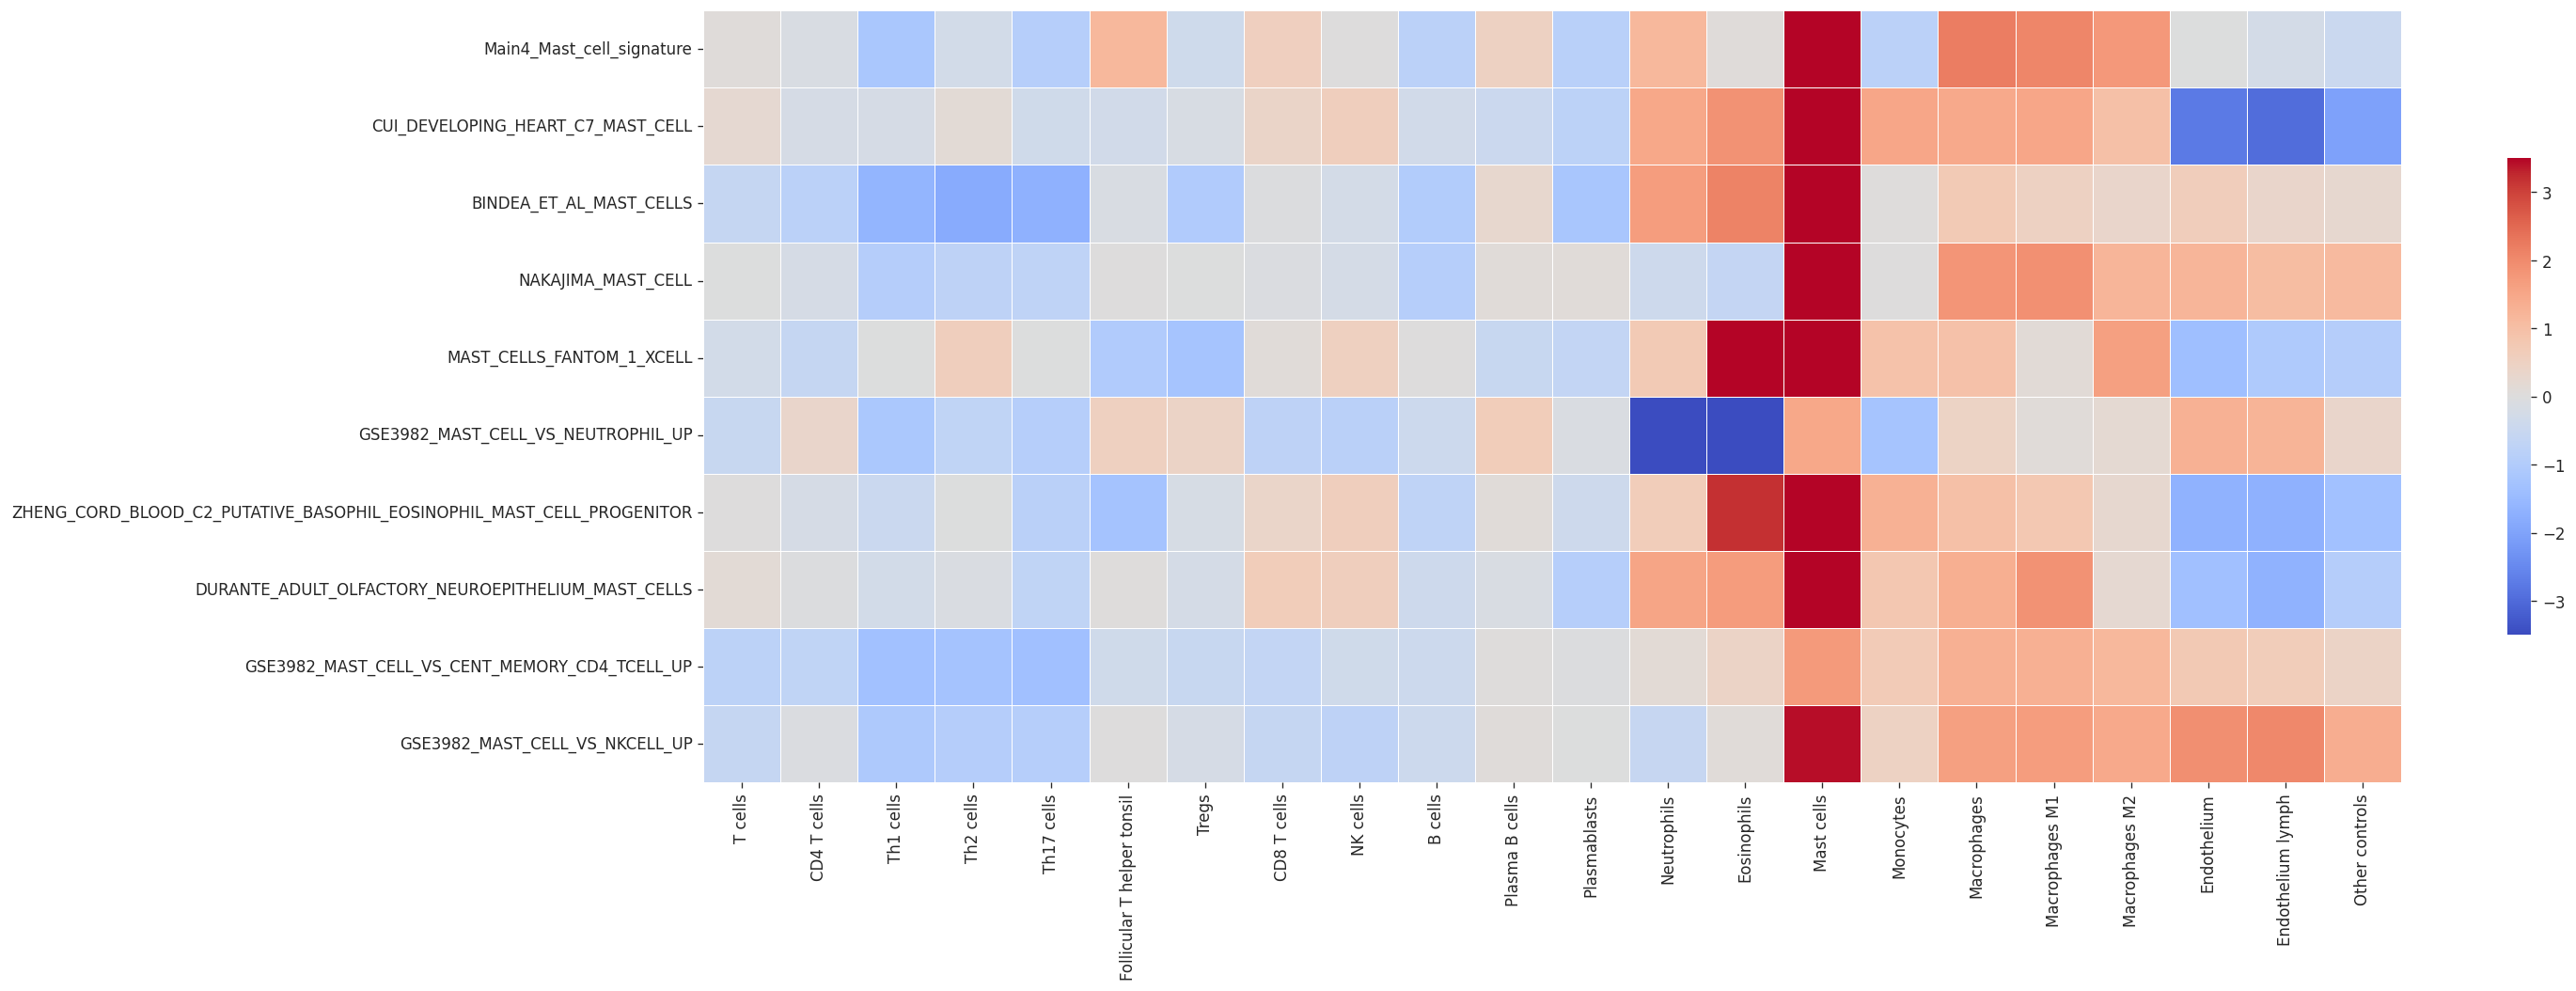

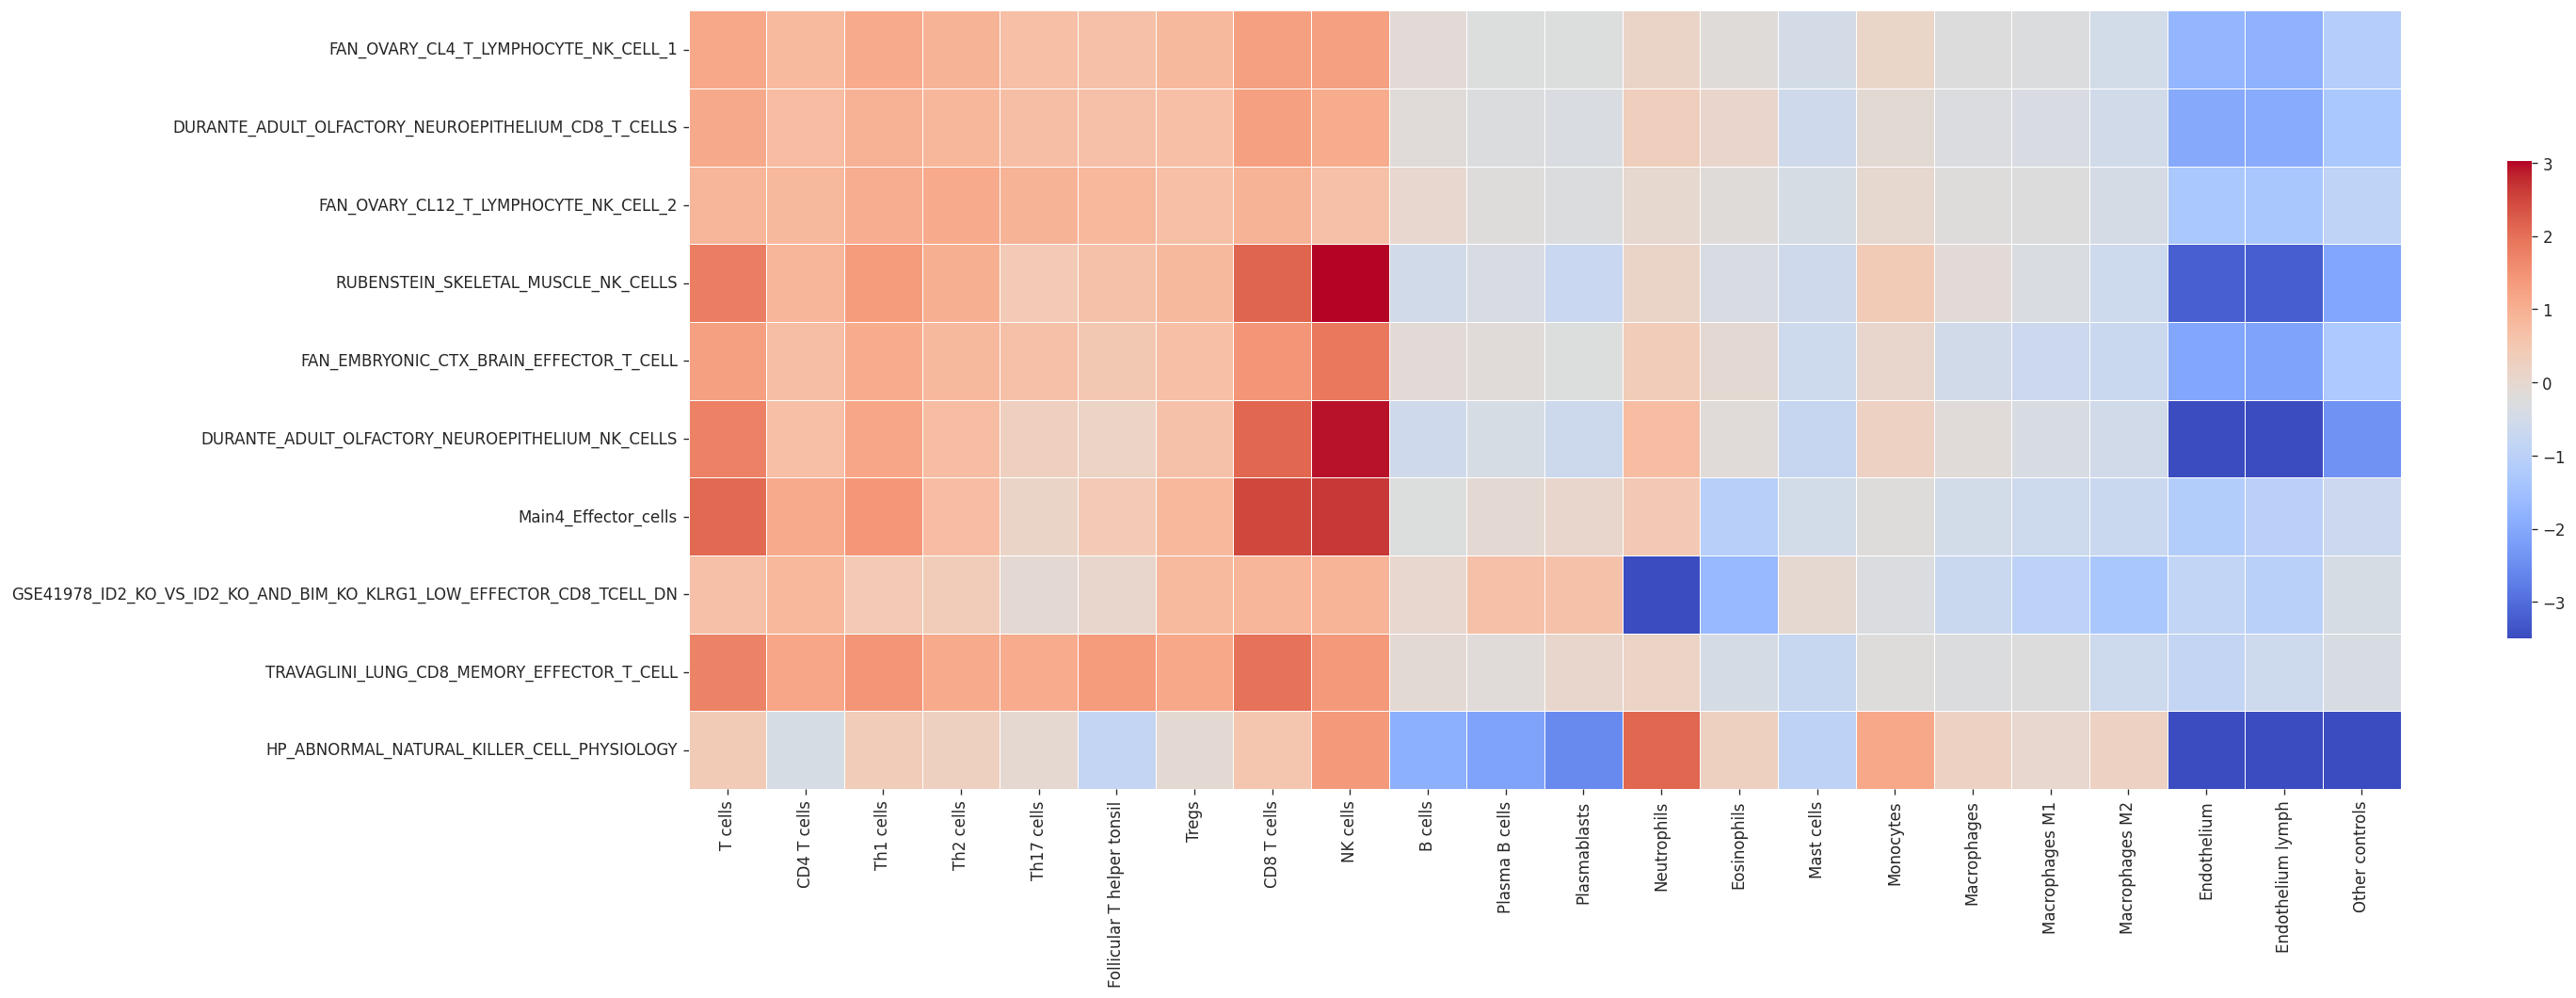

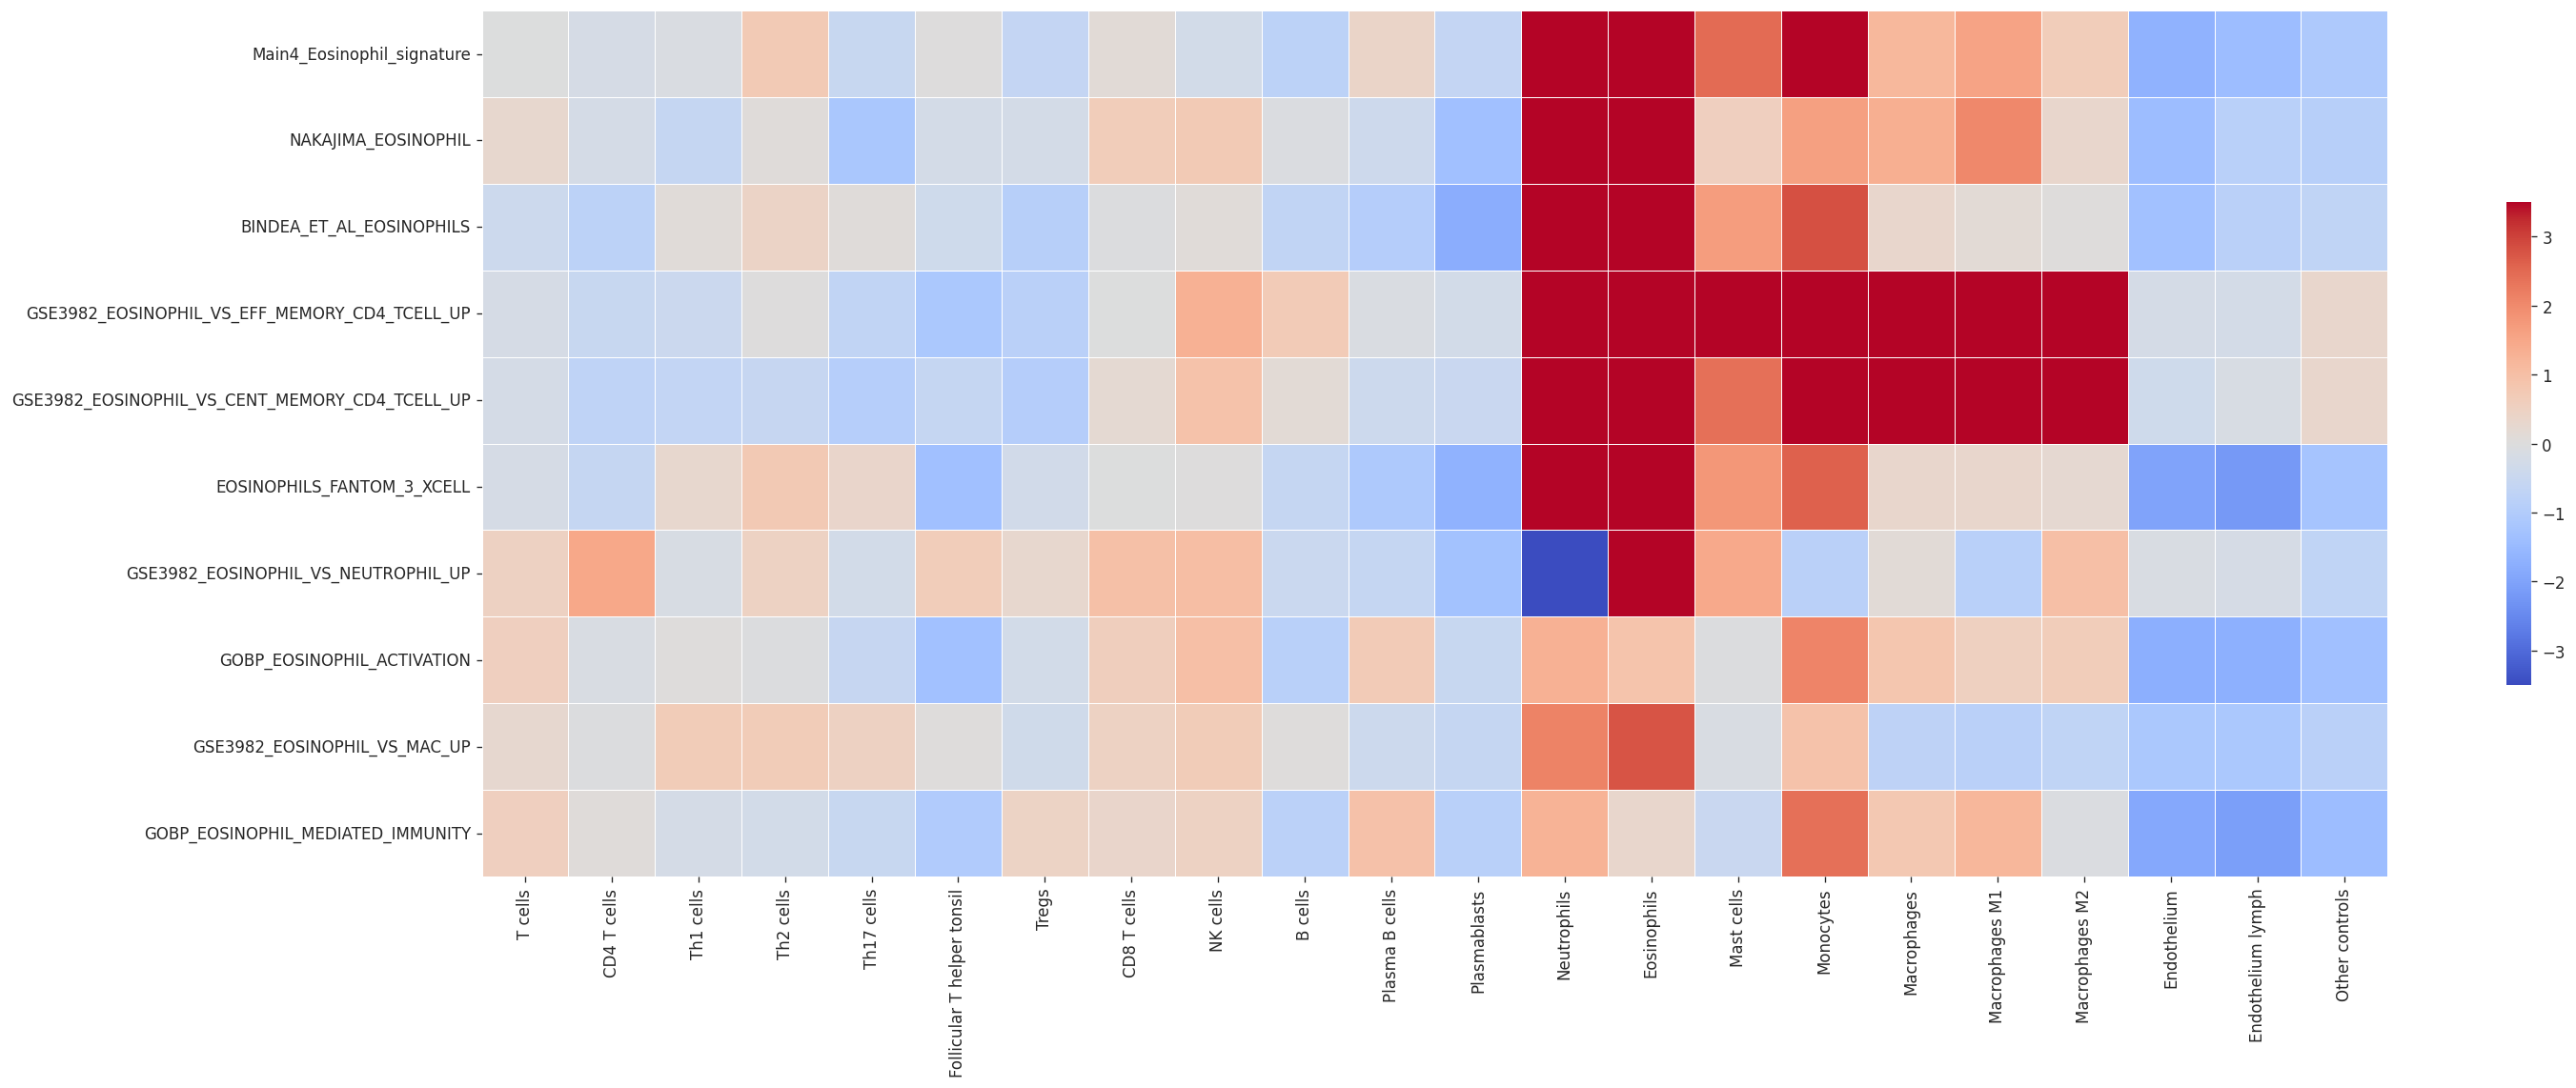

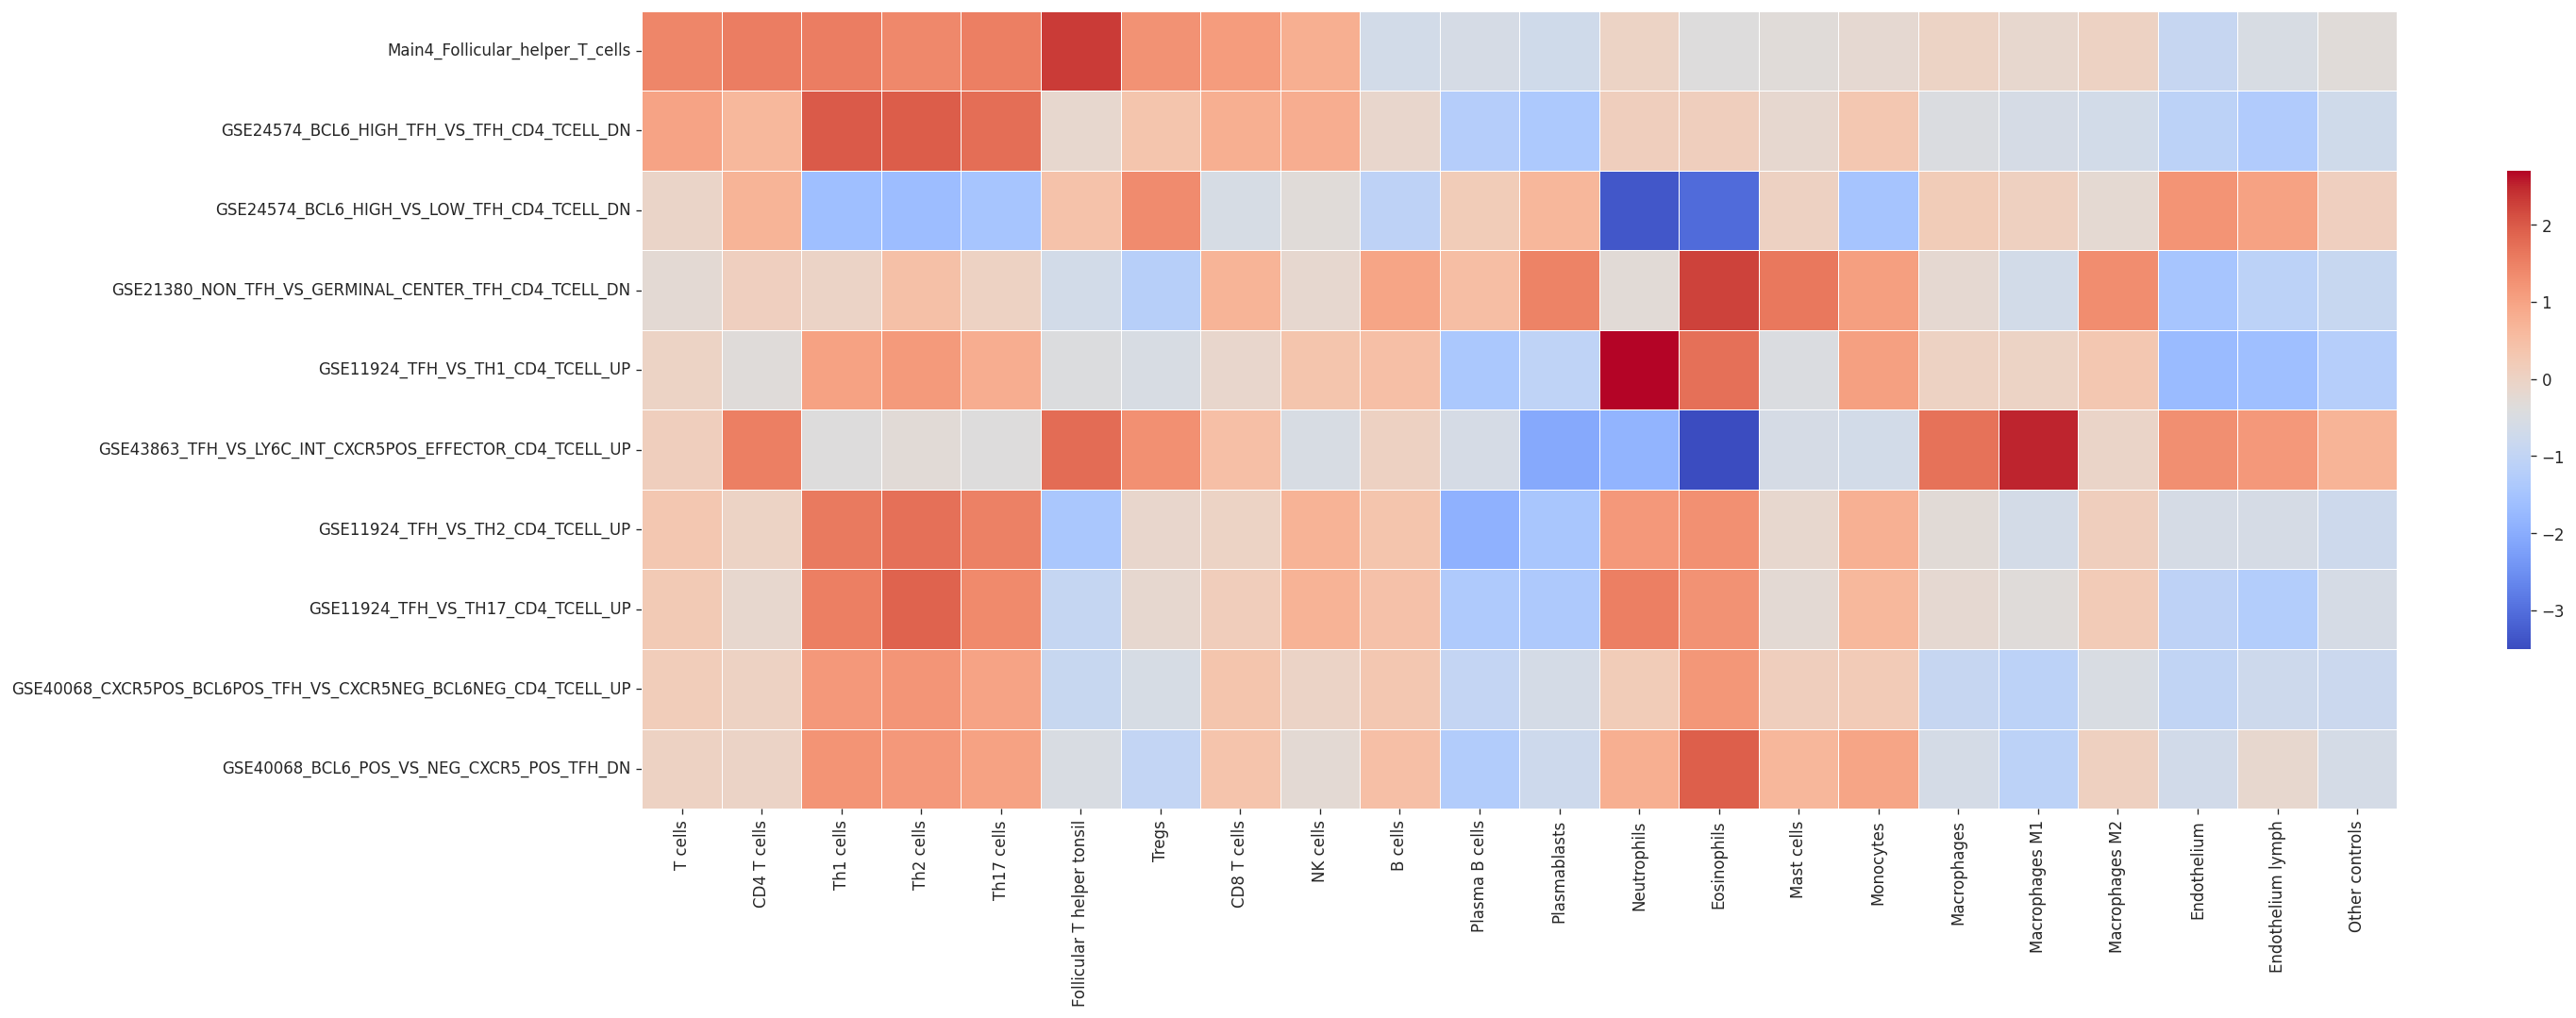

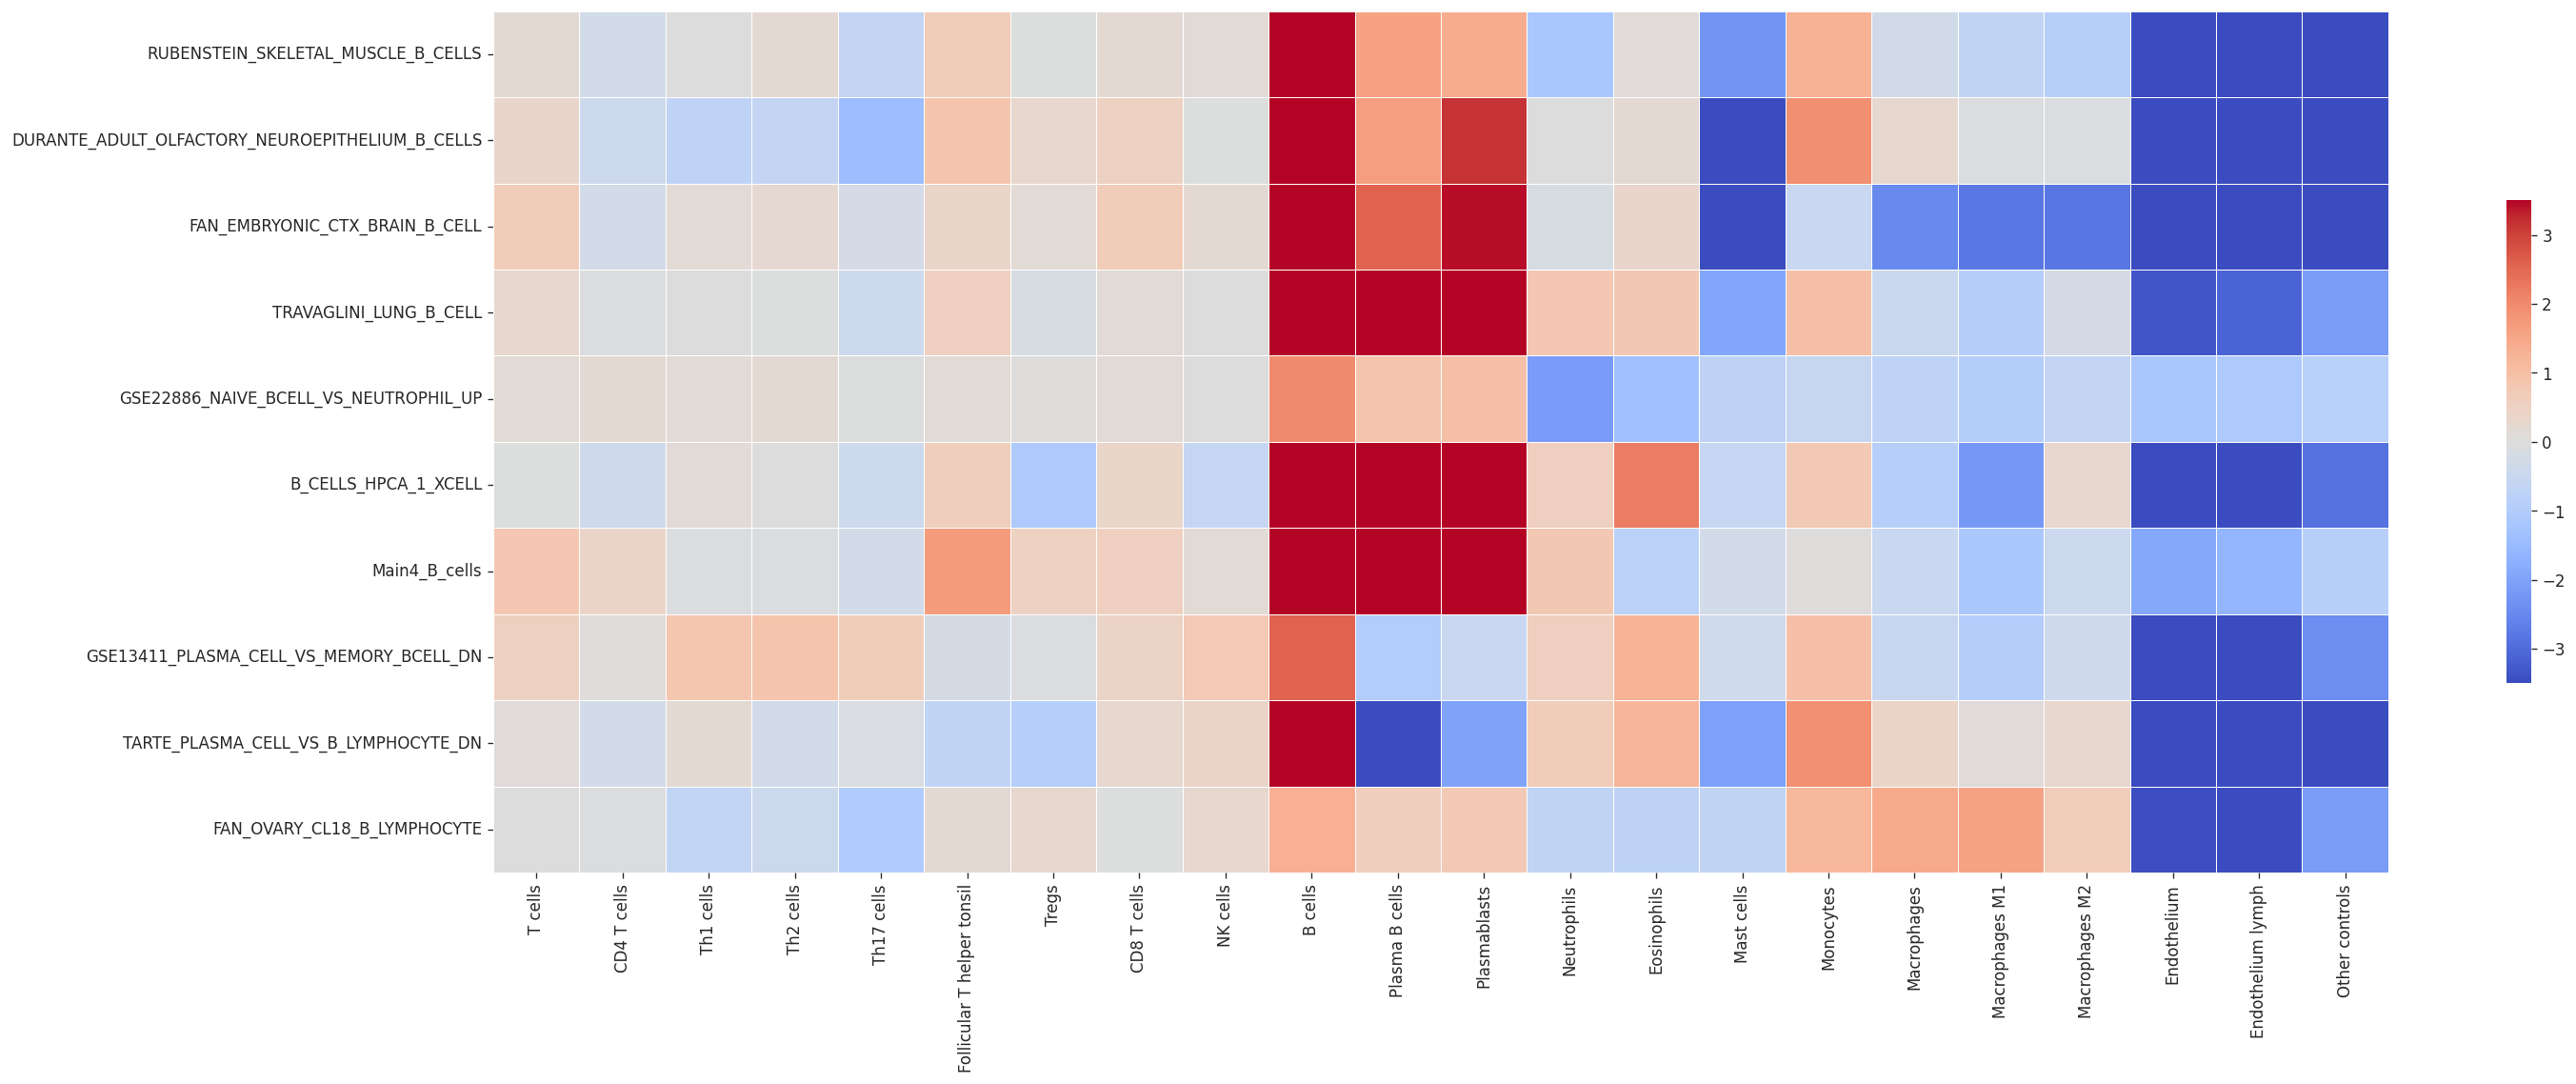

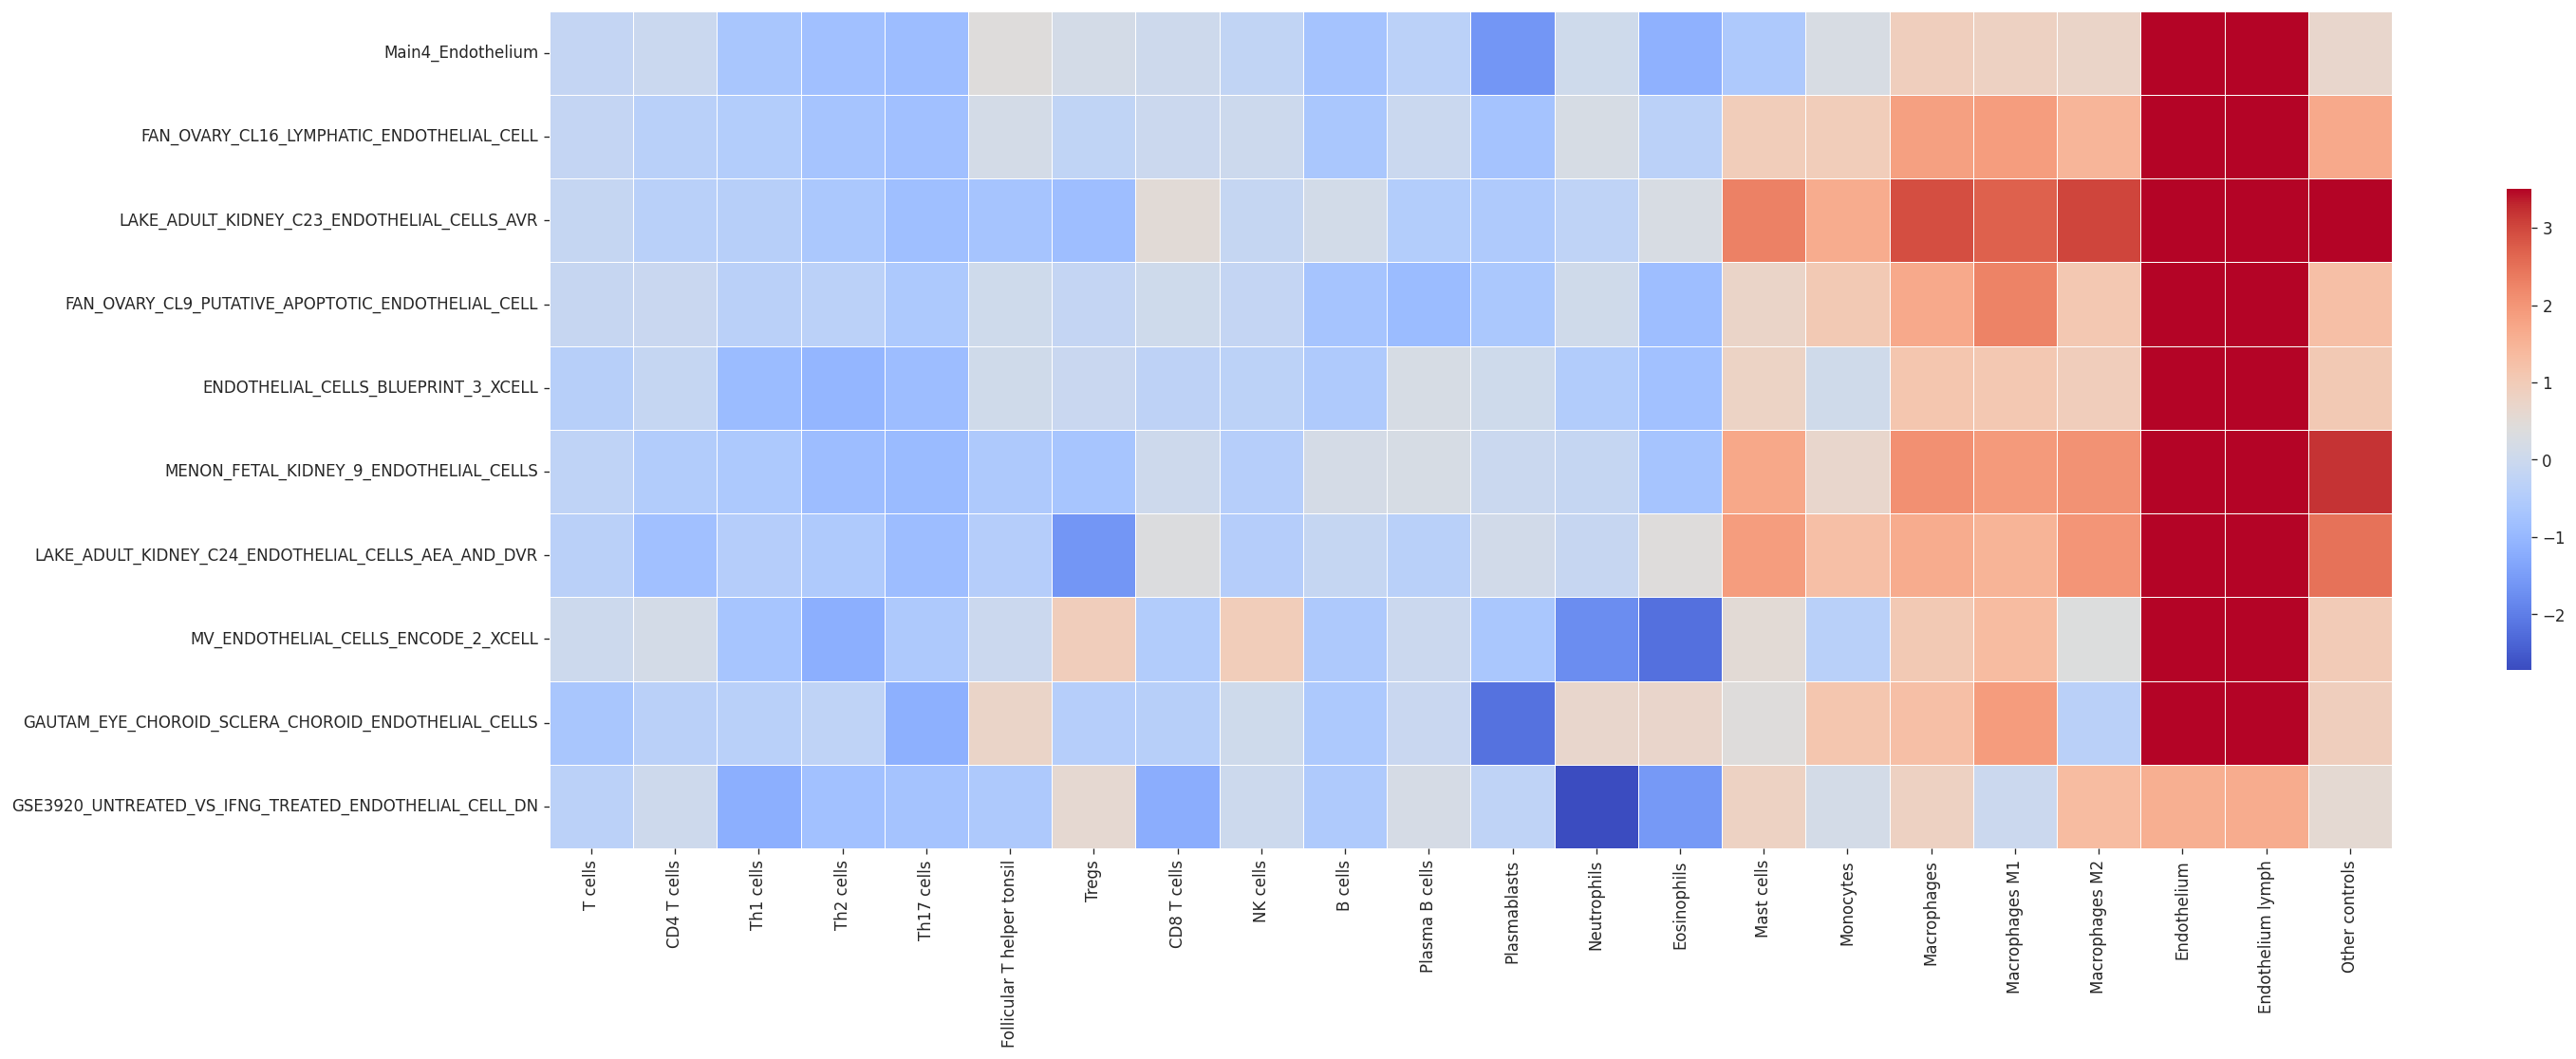

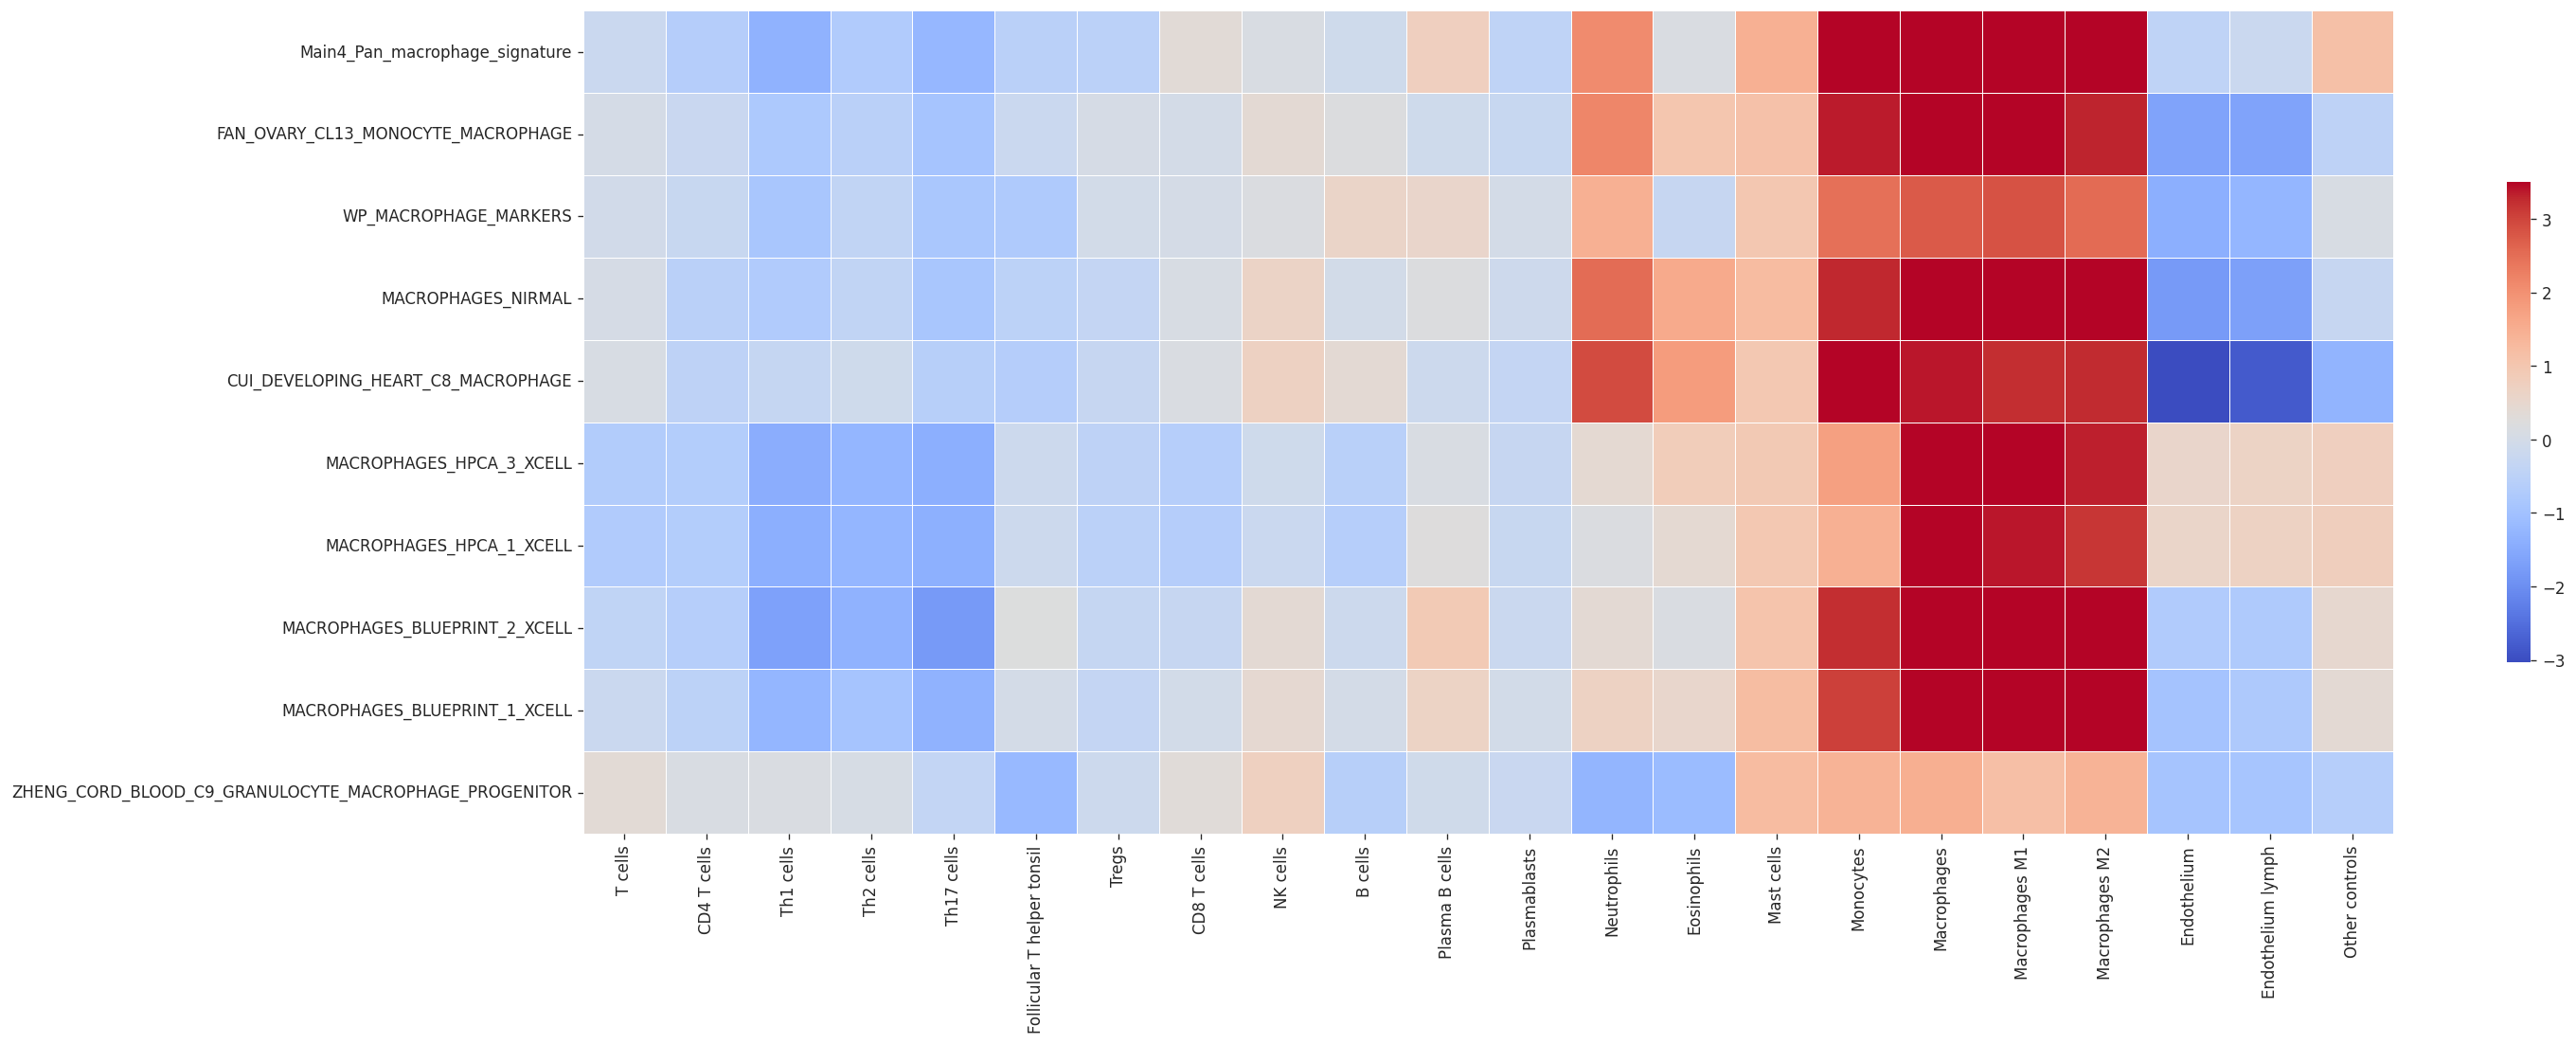

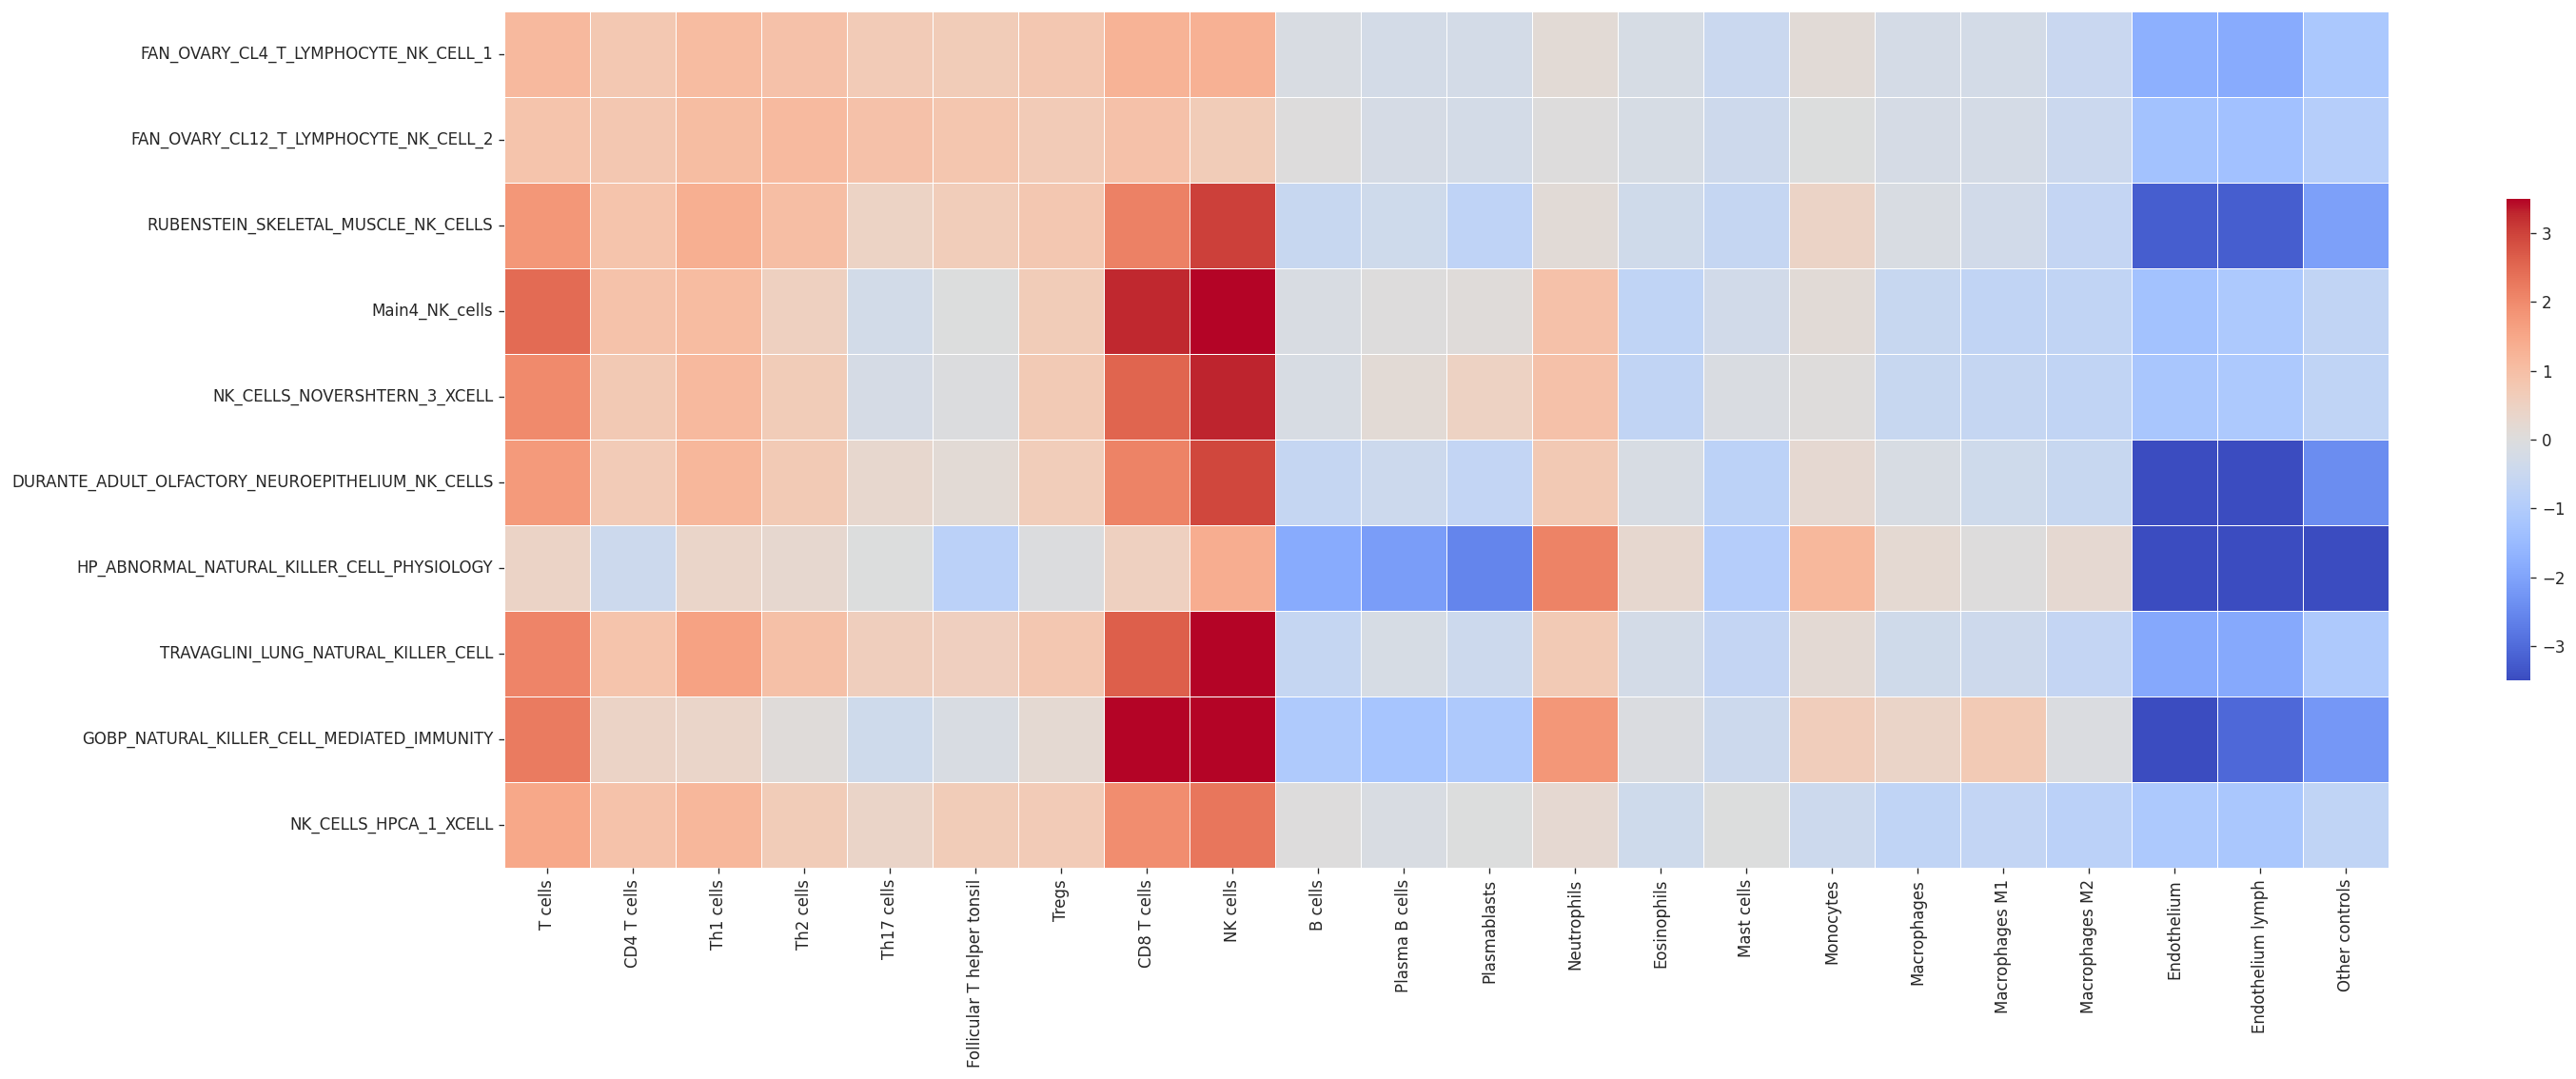

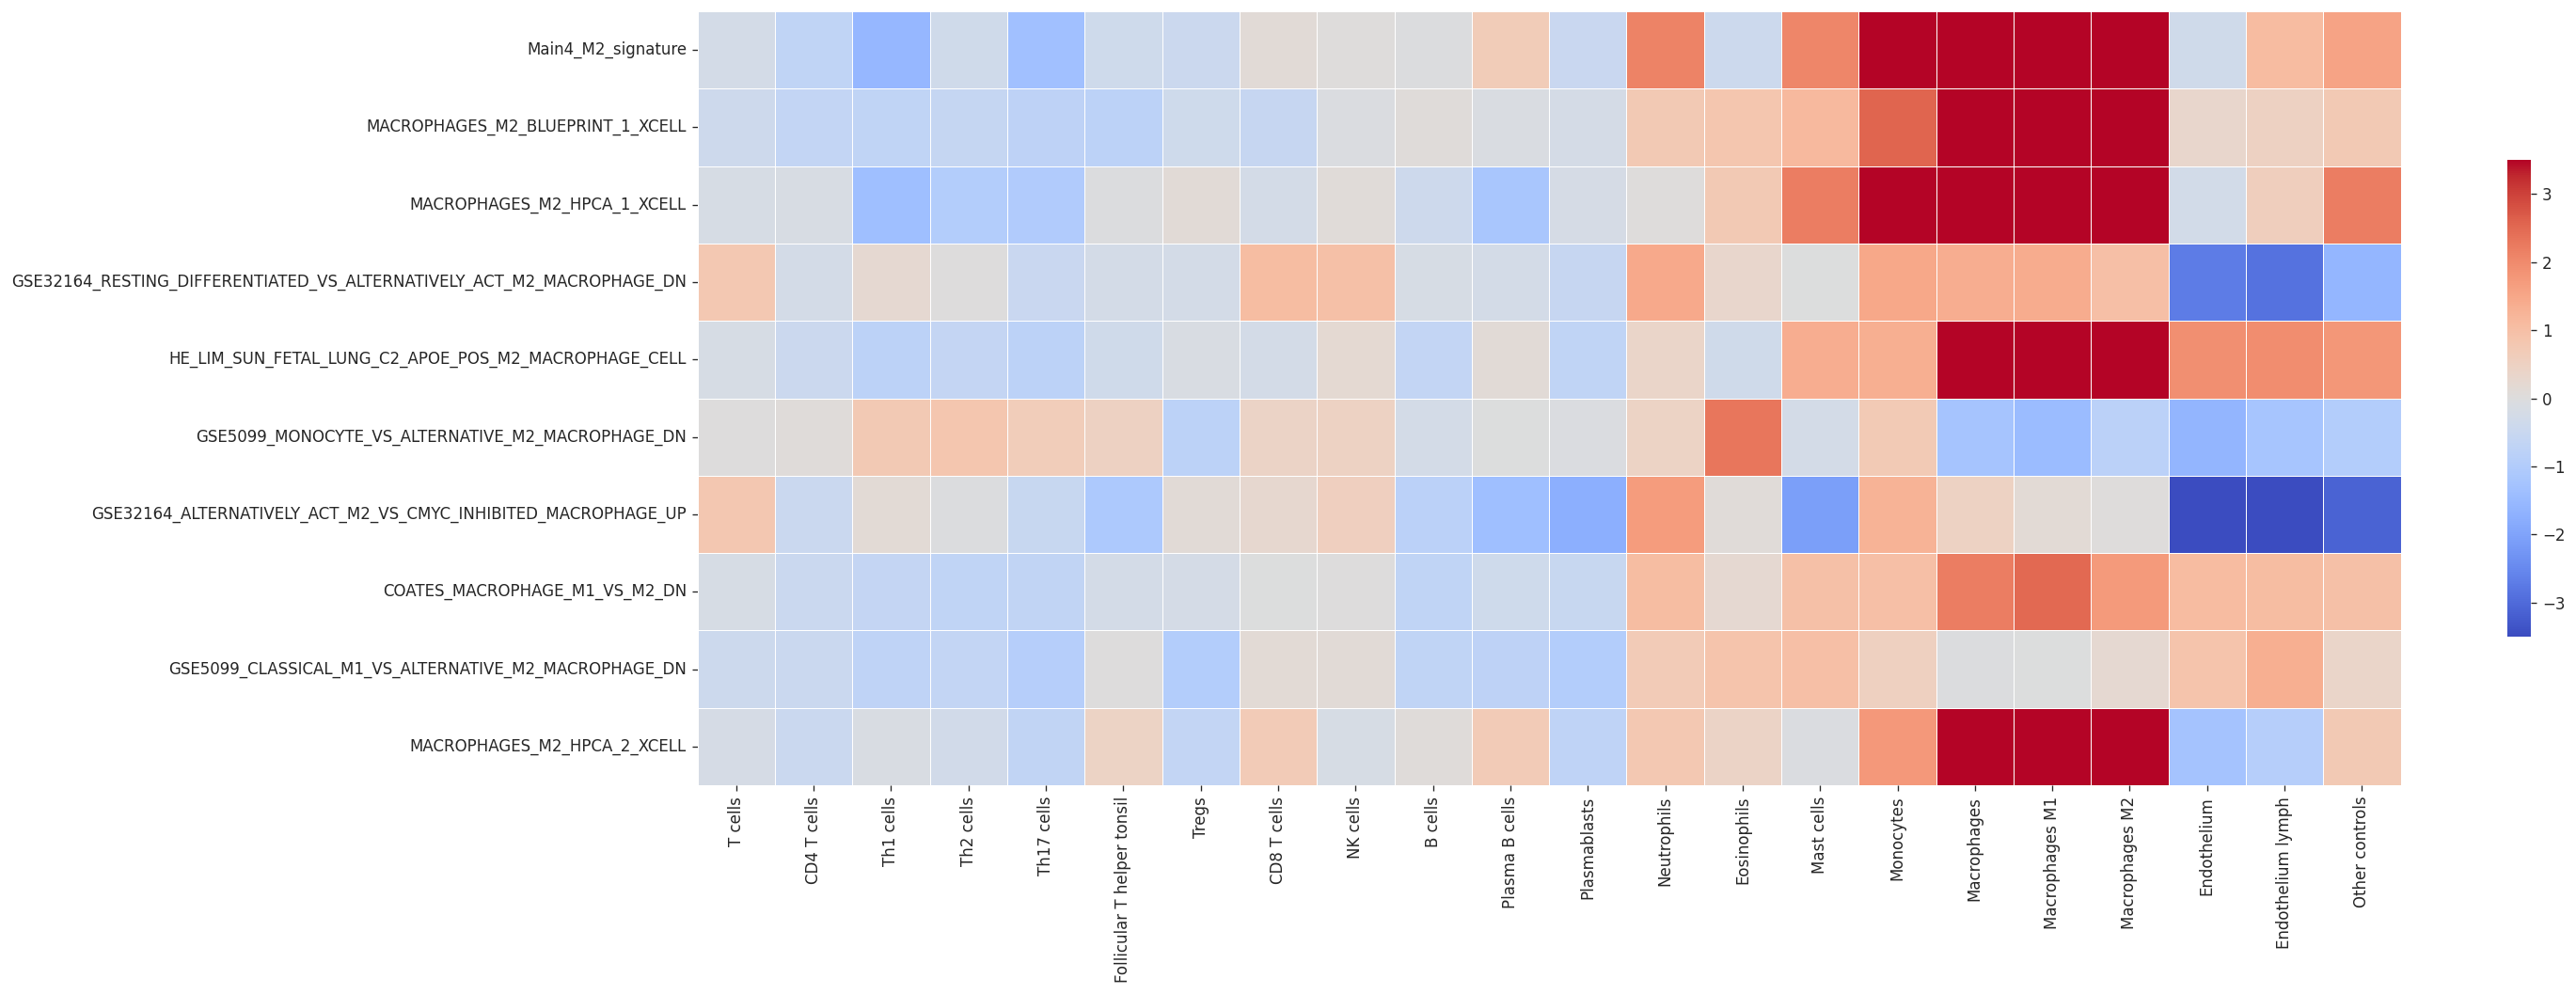

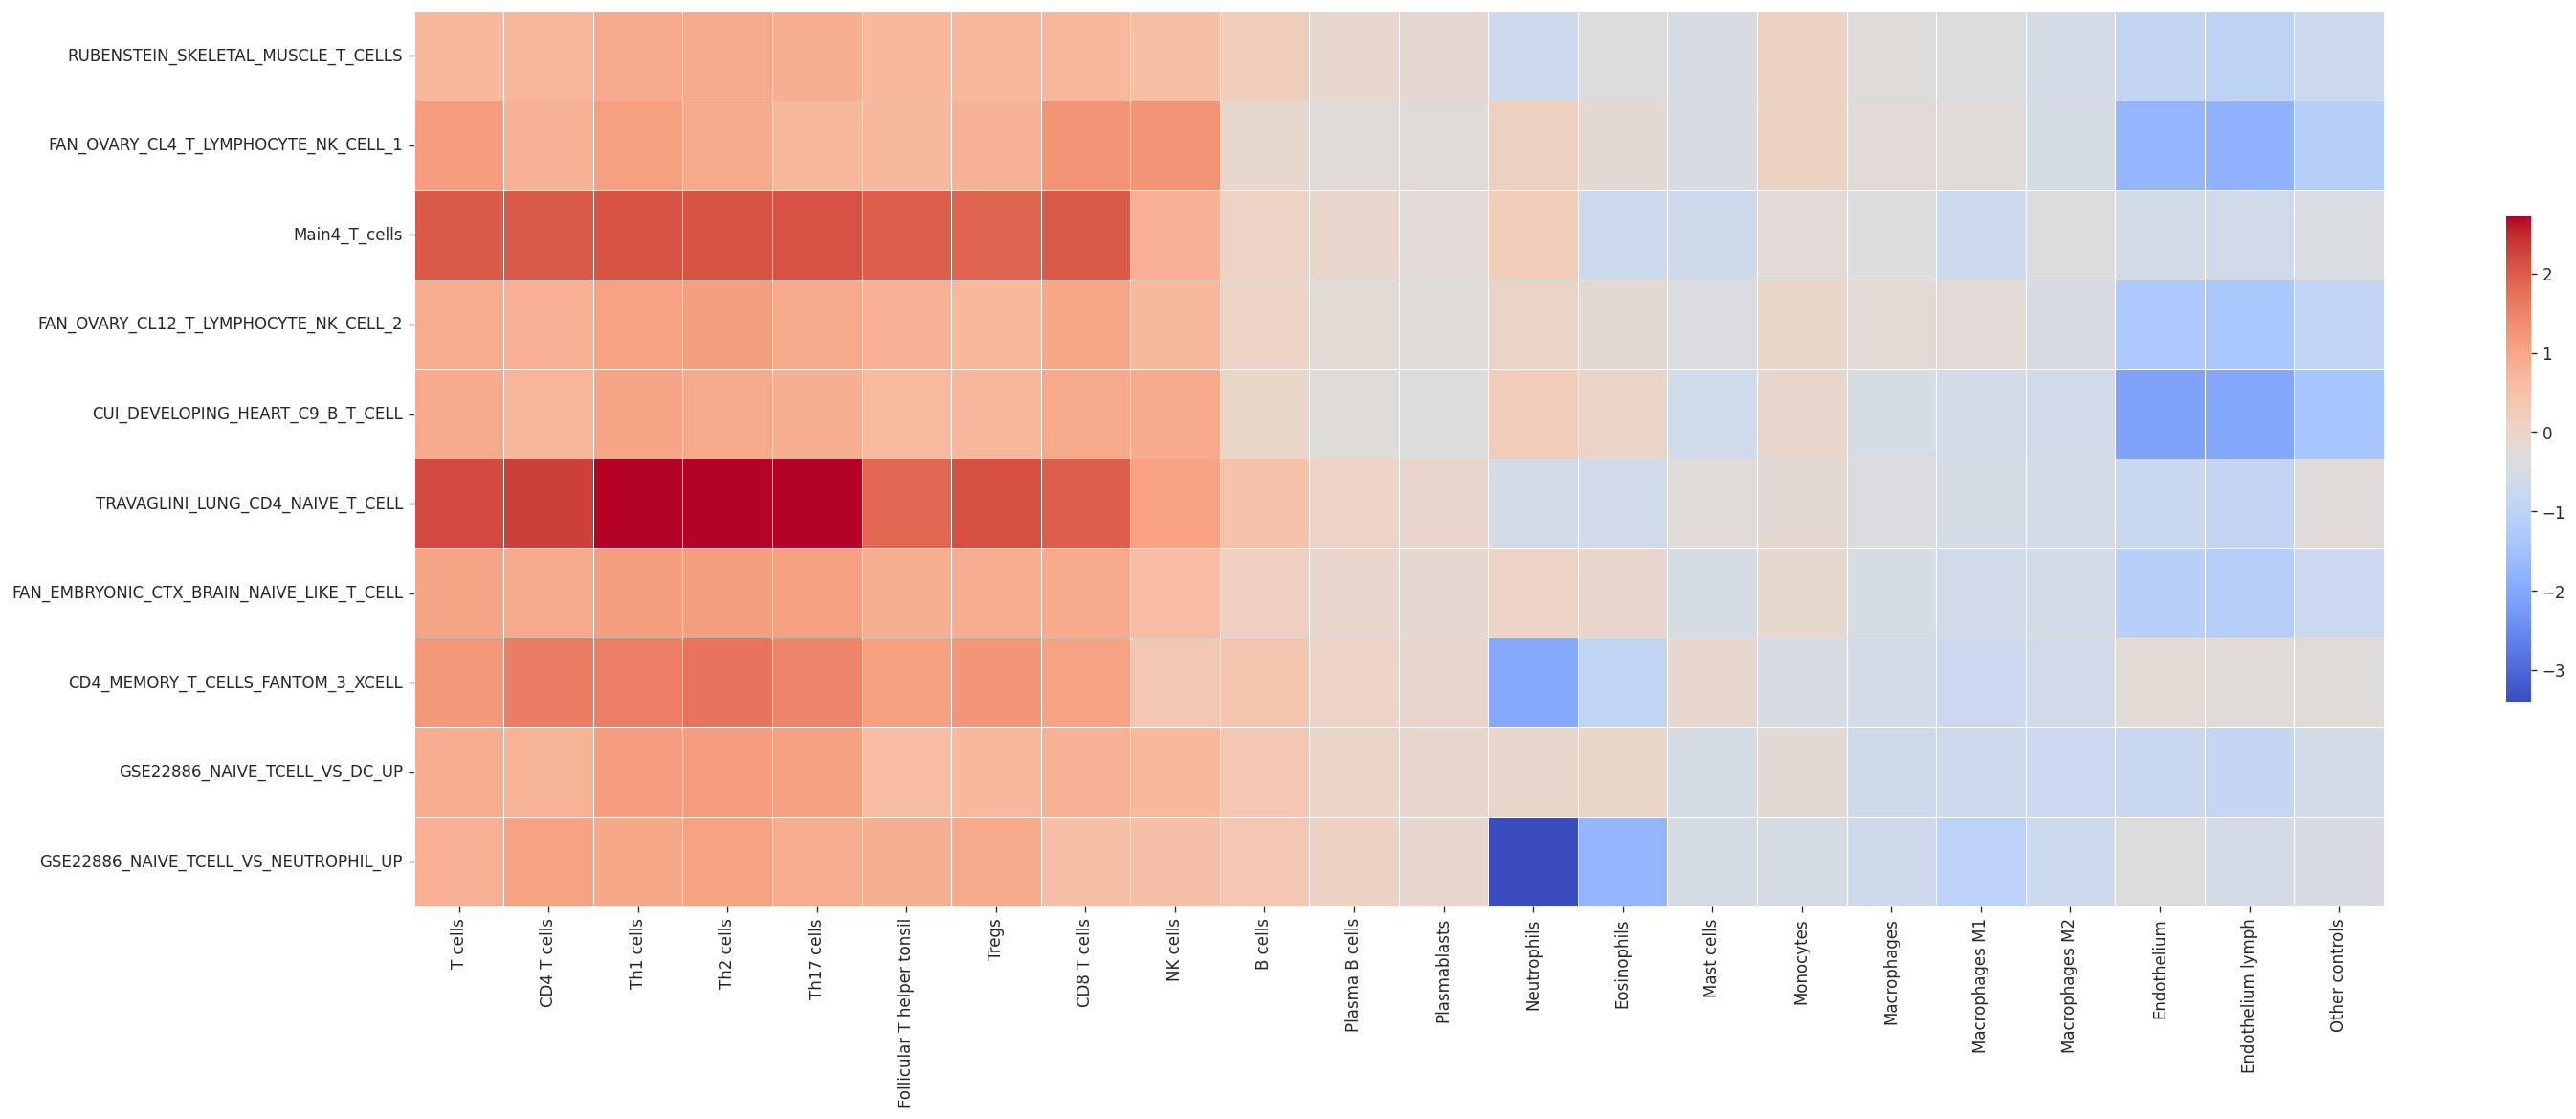

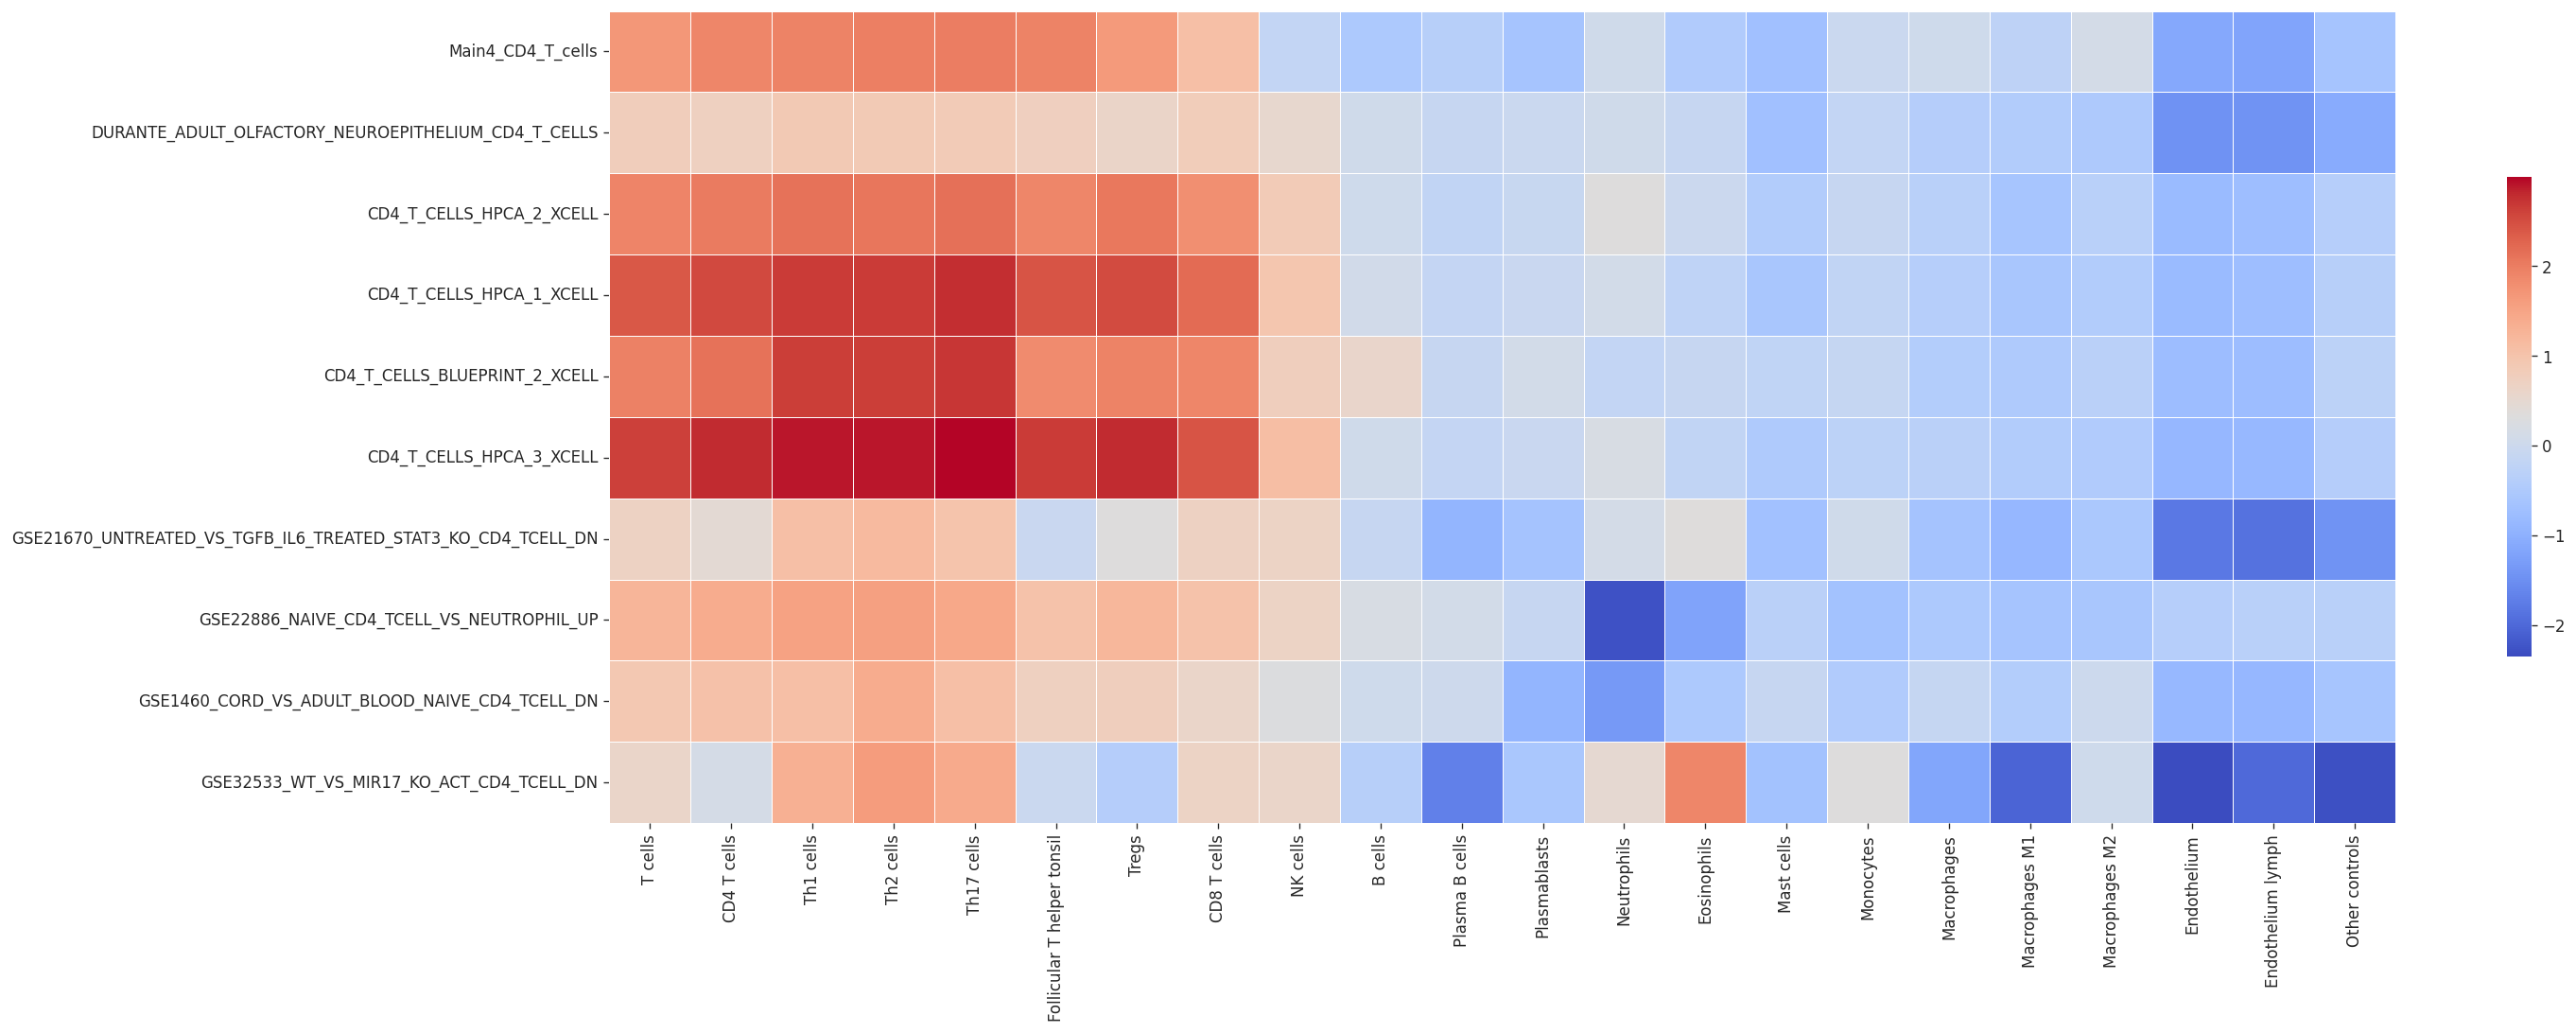

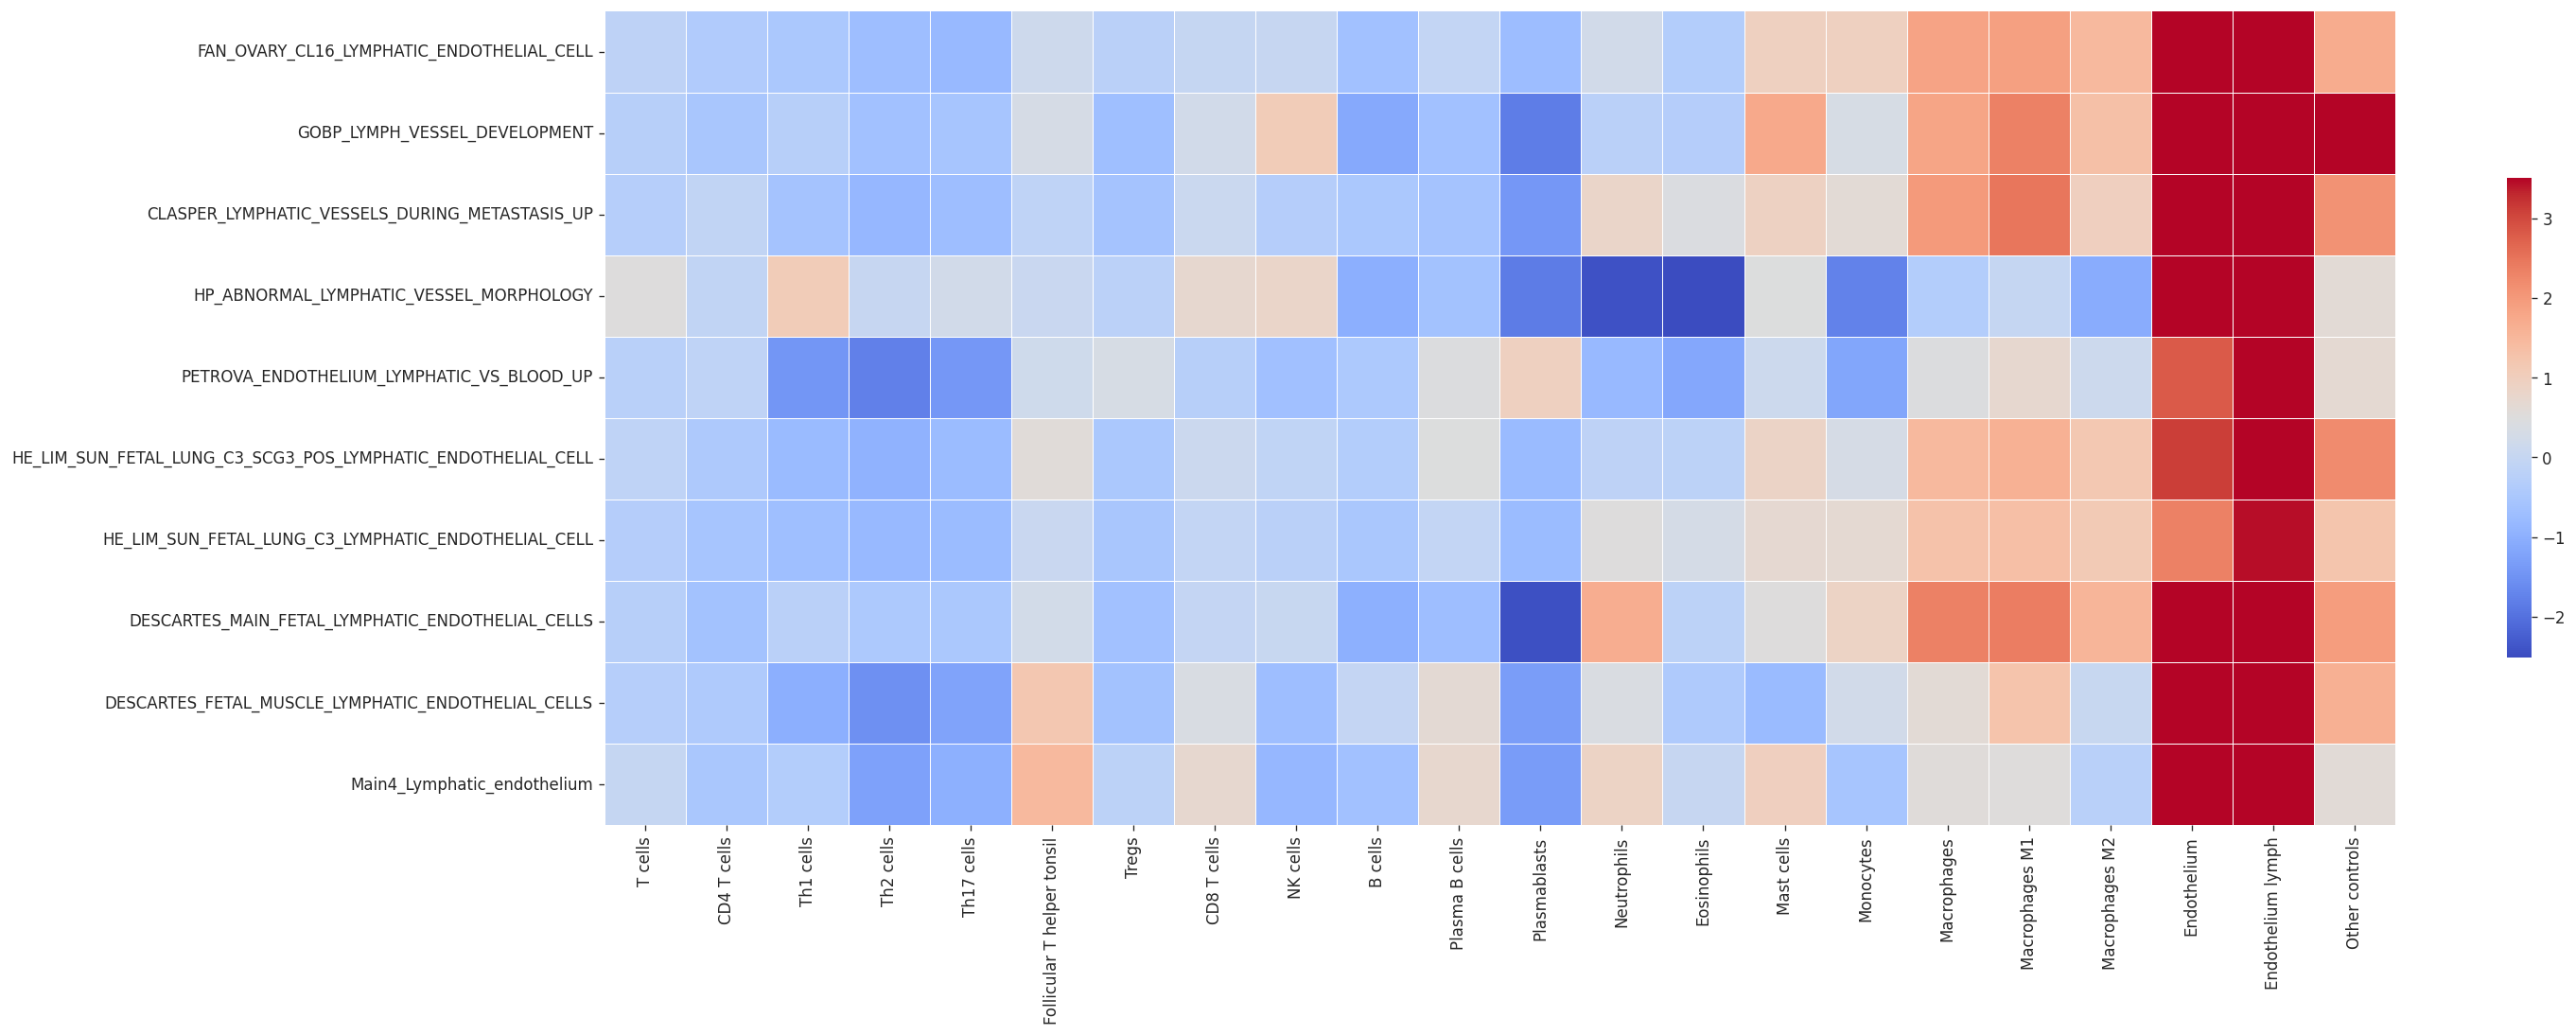

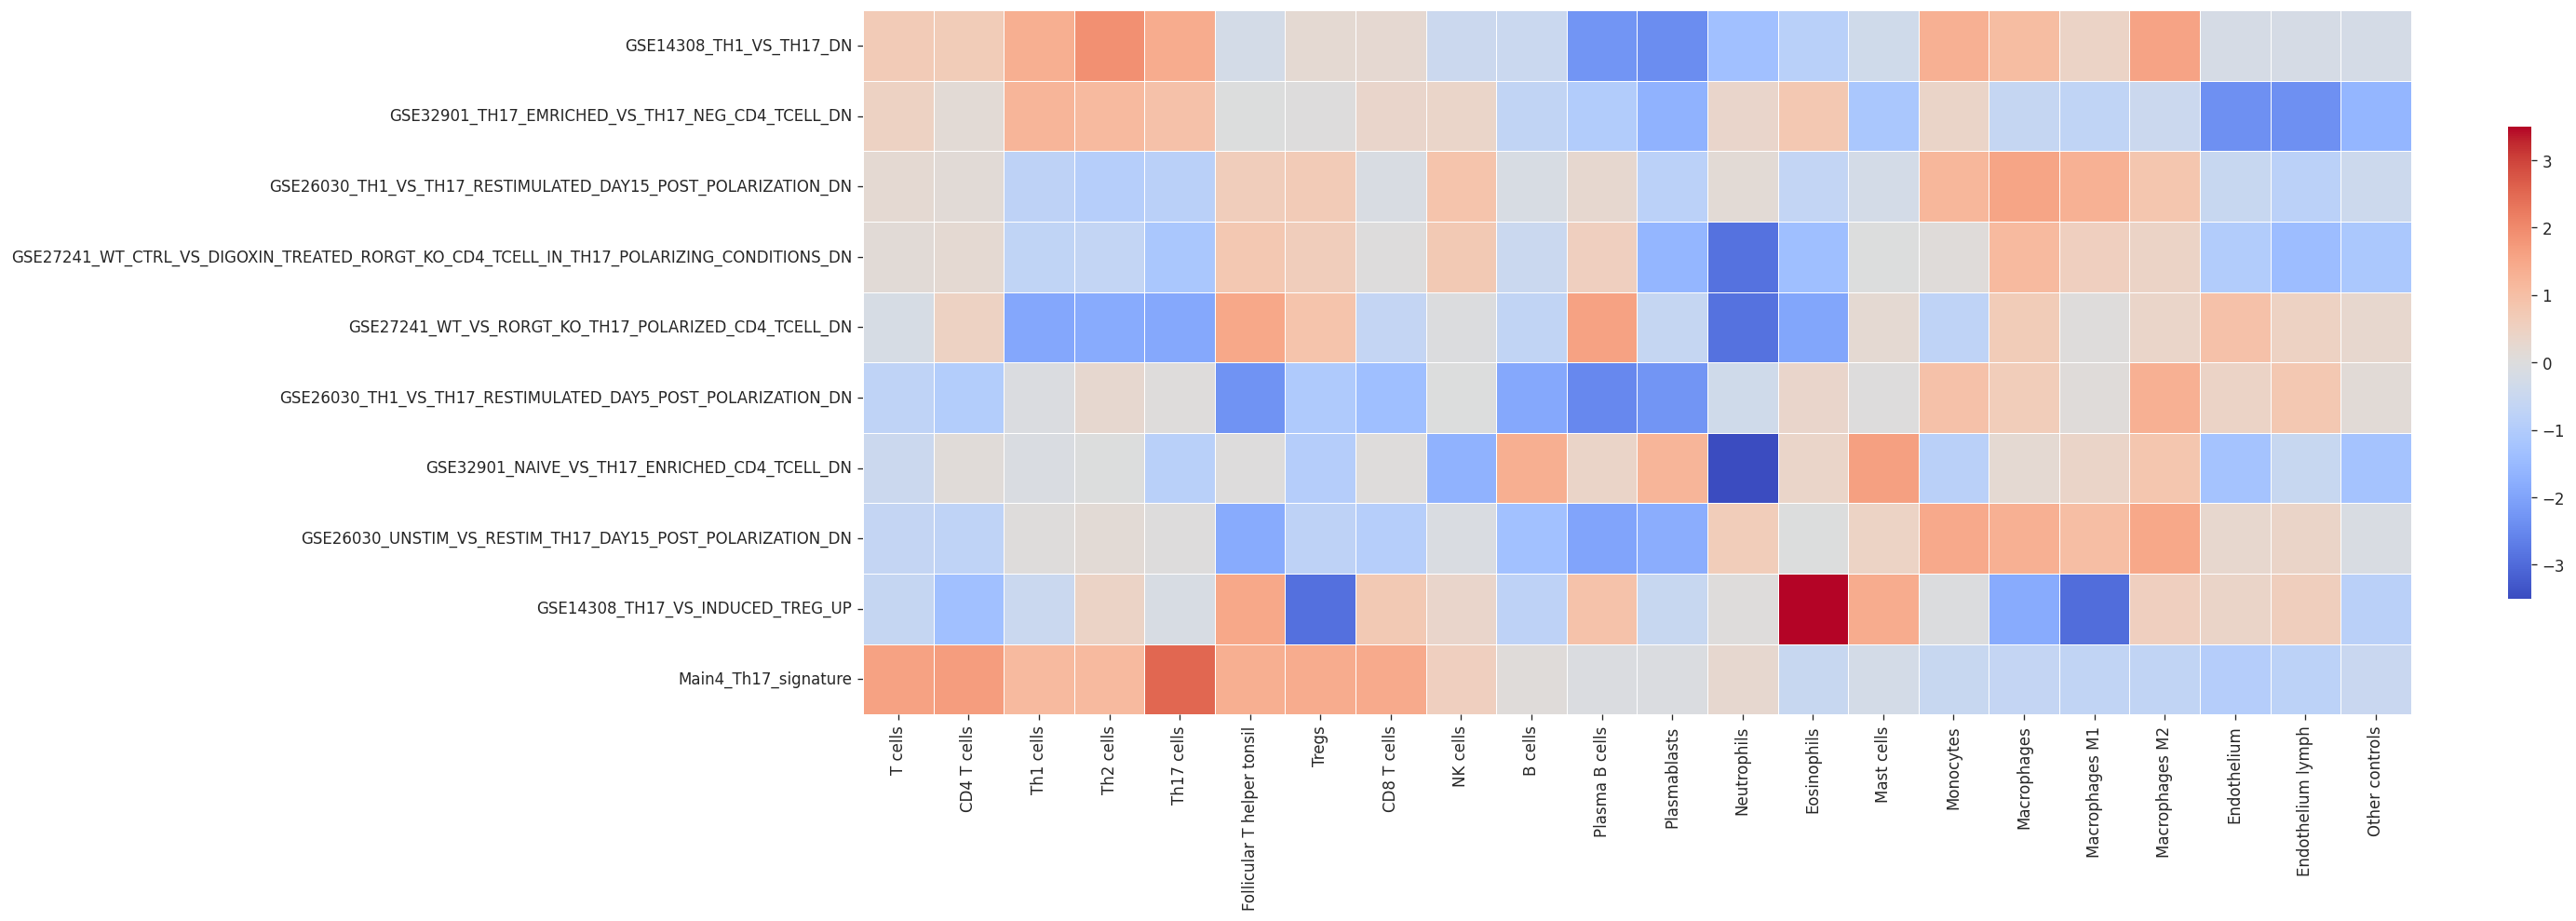

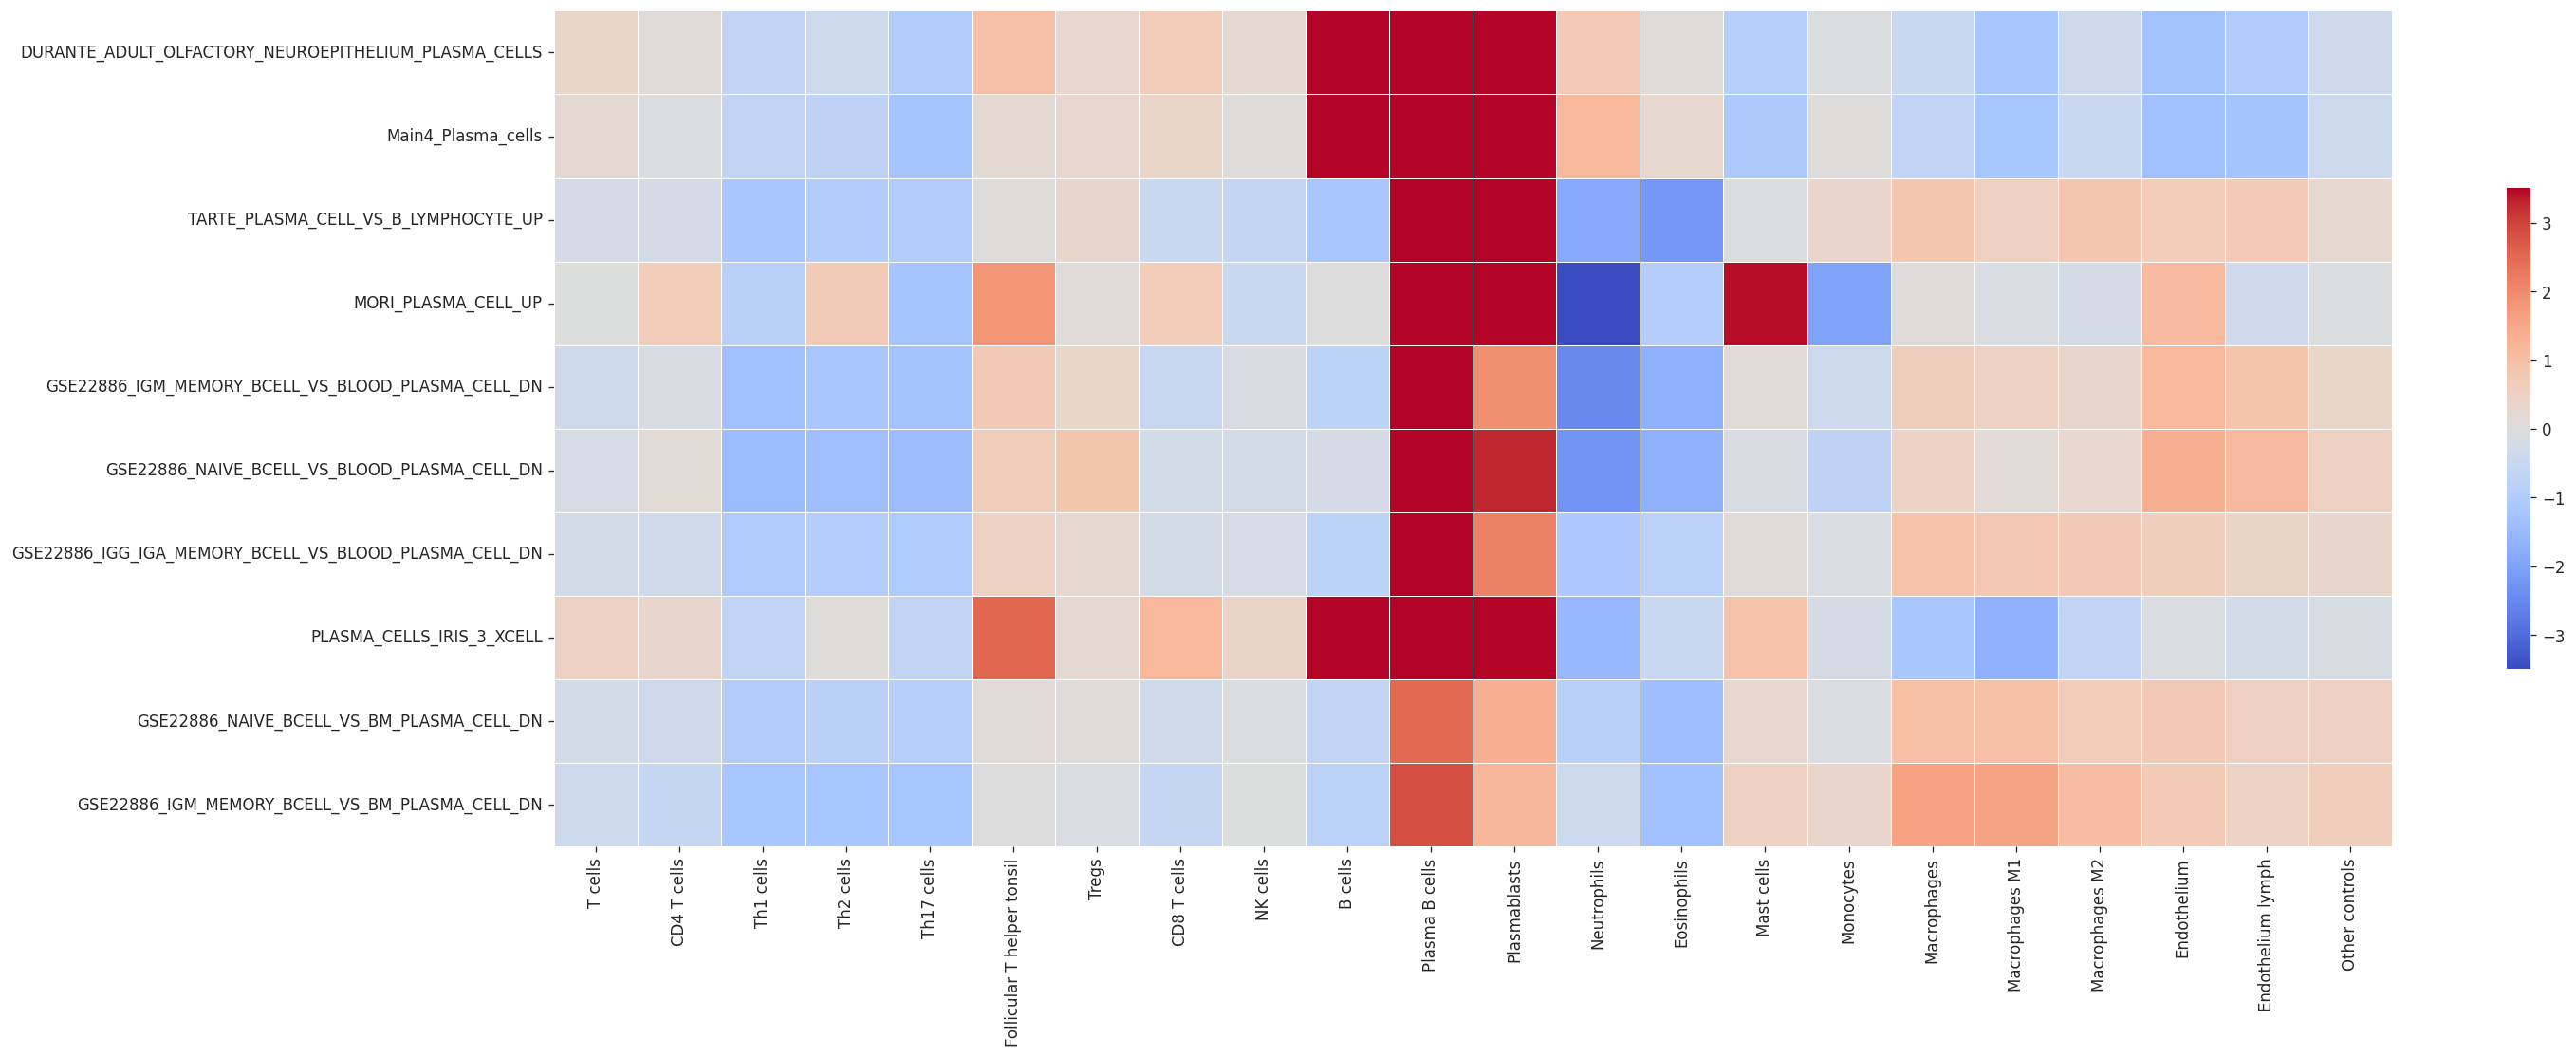

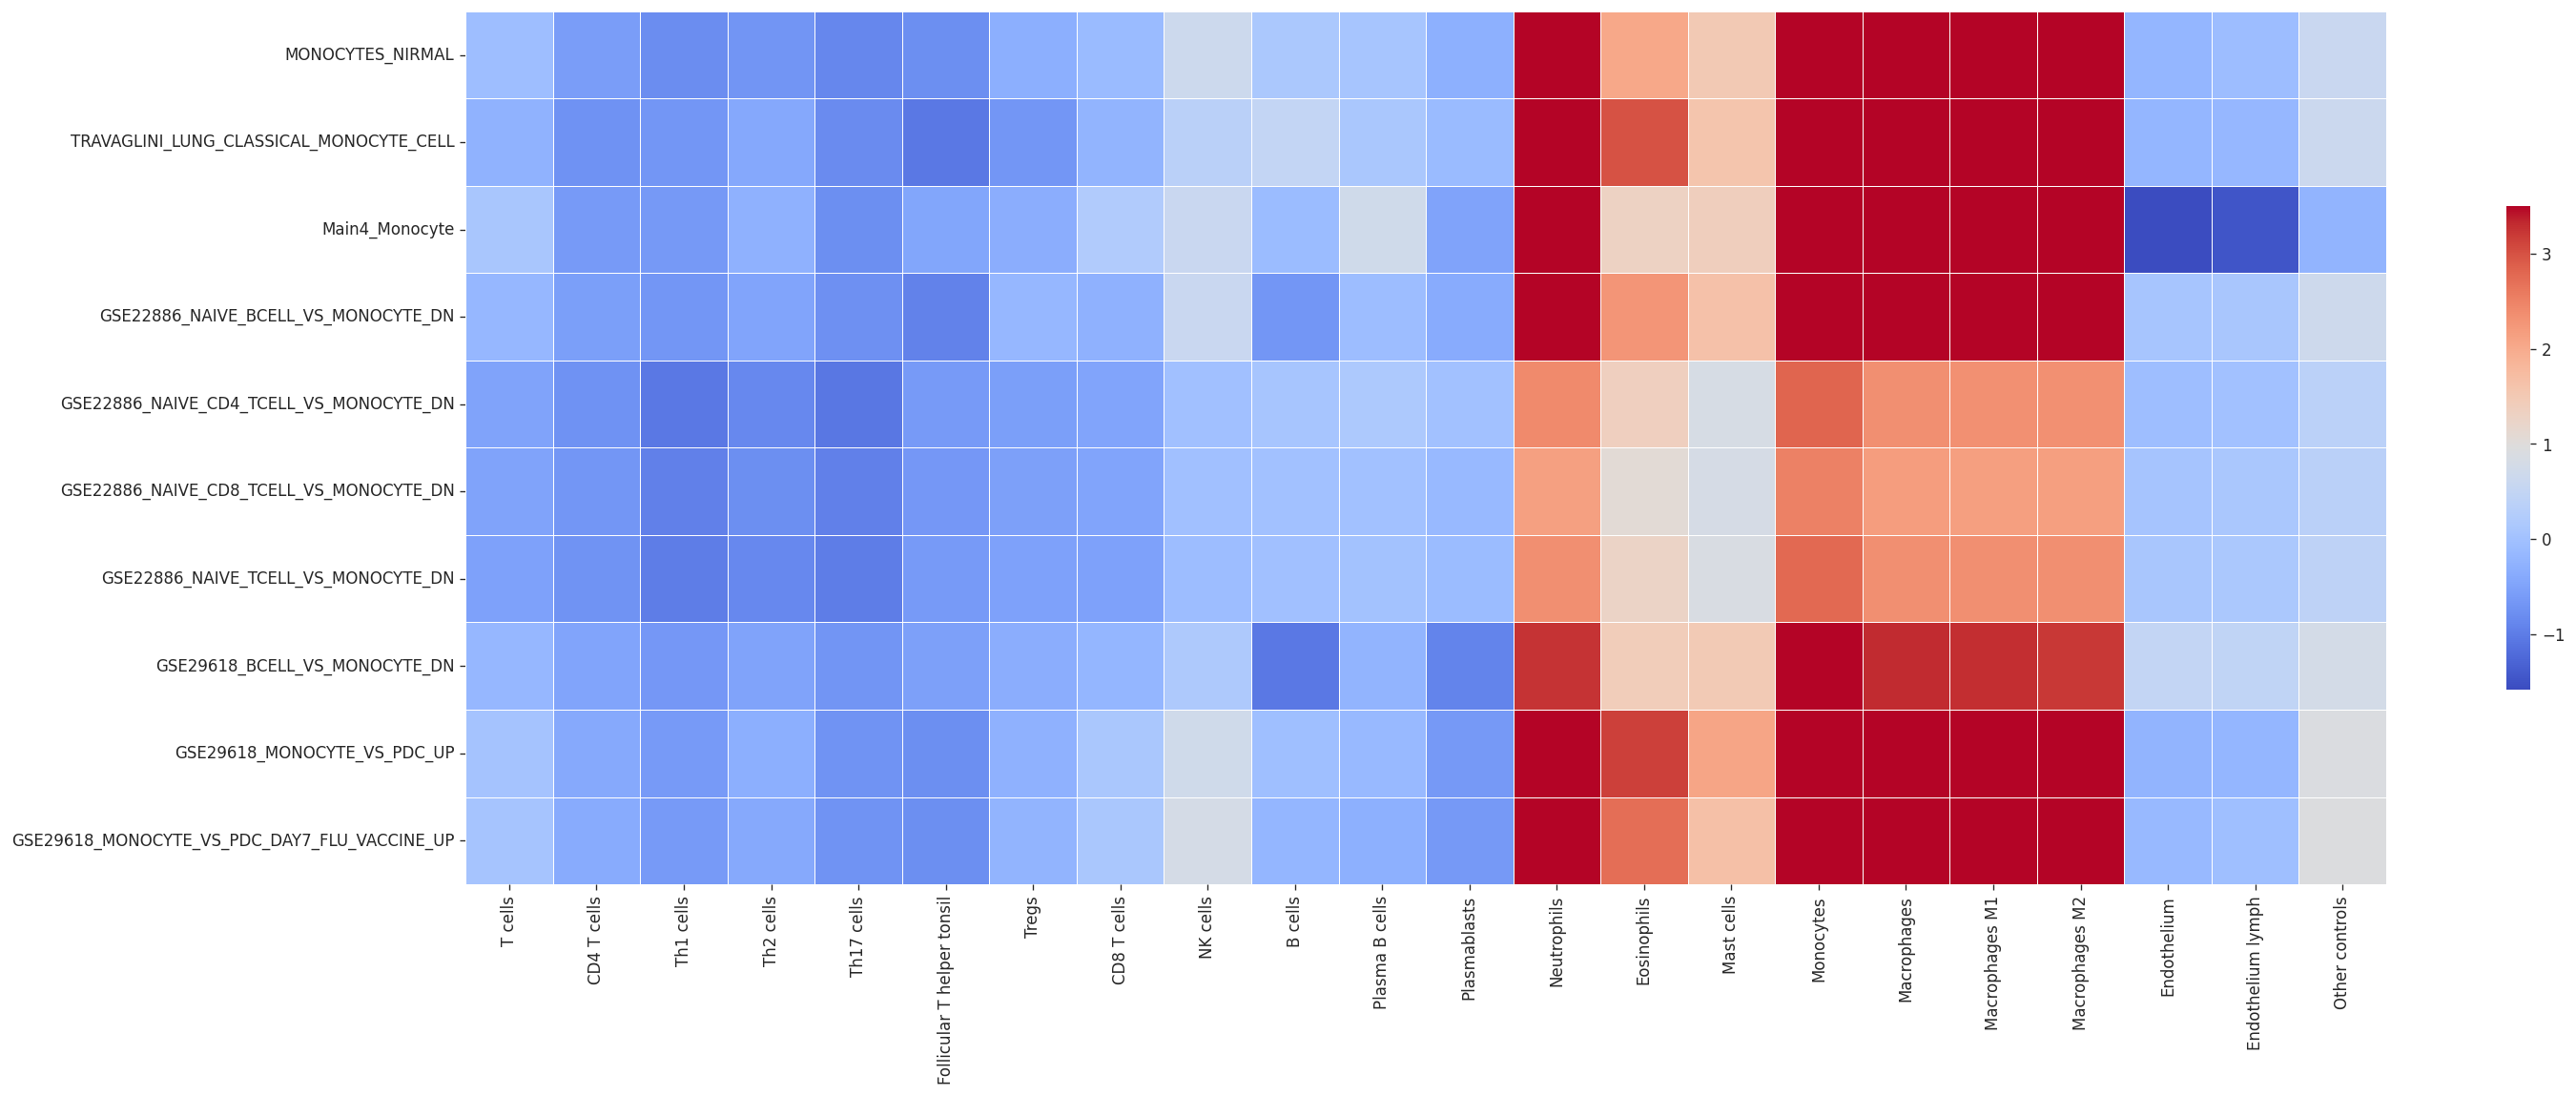

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
for bg_sign in msigdb_gmt.keys():
    signs = msigdb_gmt[bg_sign].keys()
    scores = pd.DataFrame({s: pd.DataFrame(fges_metrics[s]).T.mean() for s in signs}).T
    ind = scores.sort_values(
        by=["goi_cv", "F1", "control_cv"], ascending=[True, False, True]
    ).index
    ind = ind[~ind.duplicated()].to_list()
    ind = [i for i in ind if "RANDOM" not in i][:t]
    if bg_sign not in ind:
        ind = ind[: (t - 1)] + [bg_sign]
        print(bg_sign)
    data = df[ind].T
    data = data[~data.index.duplicated()]
    ls = labels.reindex(data.columns)
    data = data.T.groupby(ls).mean().T[controls_order_short]

    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(
        median_scale(data.T).T.clip(-3.5, 3.5),
        cmap=default_cmap,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        cbar=True,
        annot=False,
        fmt=".1f",
        square=True,
        cbar_kws={"shrink": 0.5},
        linewidths=0.5,
    )
    ax.set_xticklabels([i.replace("_", " ") for i in controls_order_short], rotation=90)
    yticks = ind
    ax.set_yticklabels(yticks)
    plt.tight_layout(pad=0.2)
    plt.savefig(
        p
        / f"svg_pictures_median_heatmaps/scaled_top10_median_heatmap_for_{bg_sign}.svg",
        format="svg",
    )

## Short ls top10

Main4_Mast_cell_signature
Main4_Effector_cells


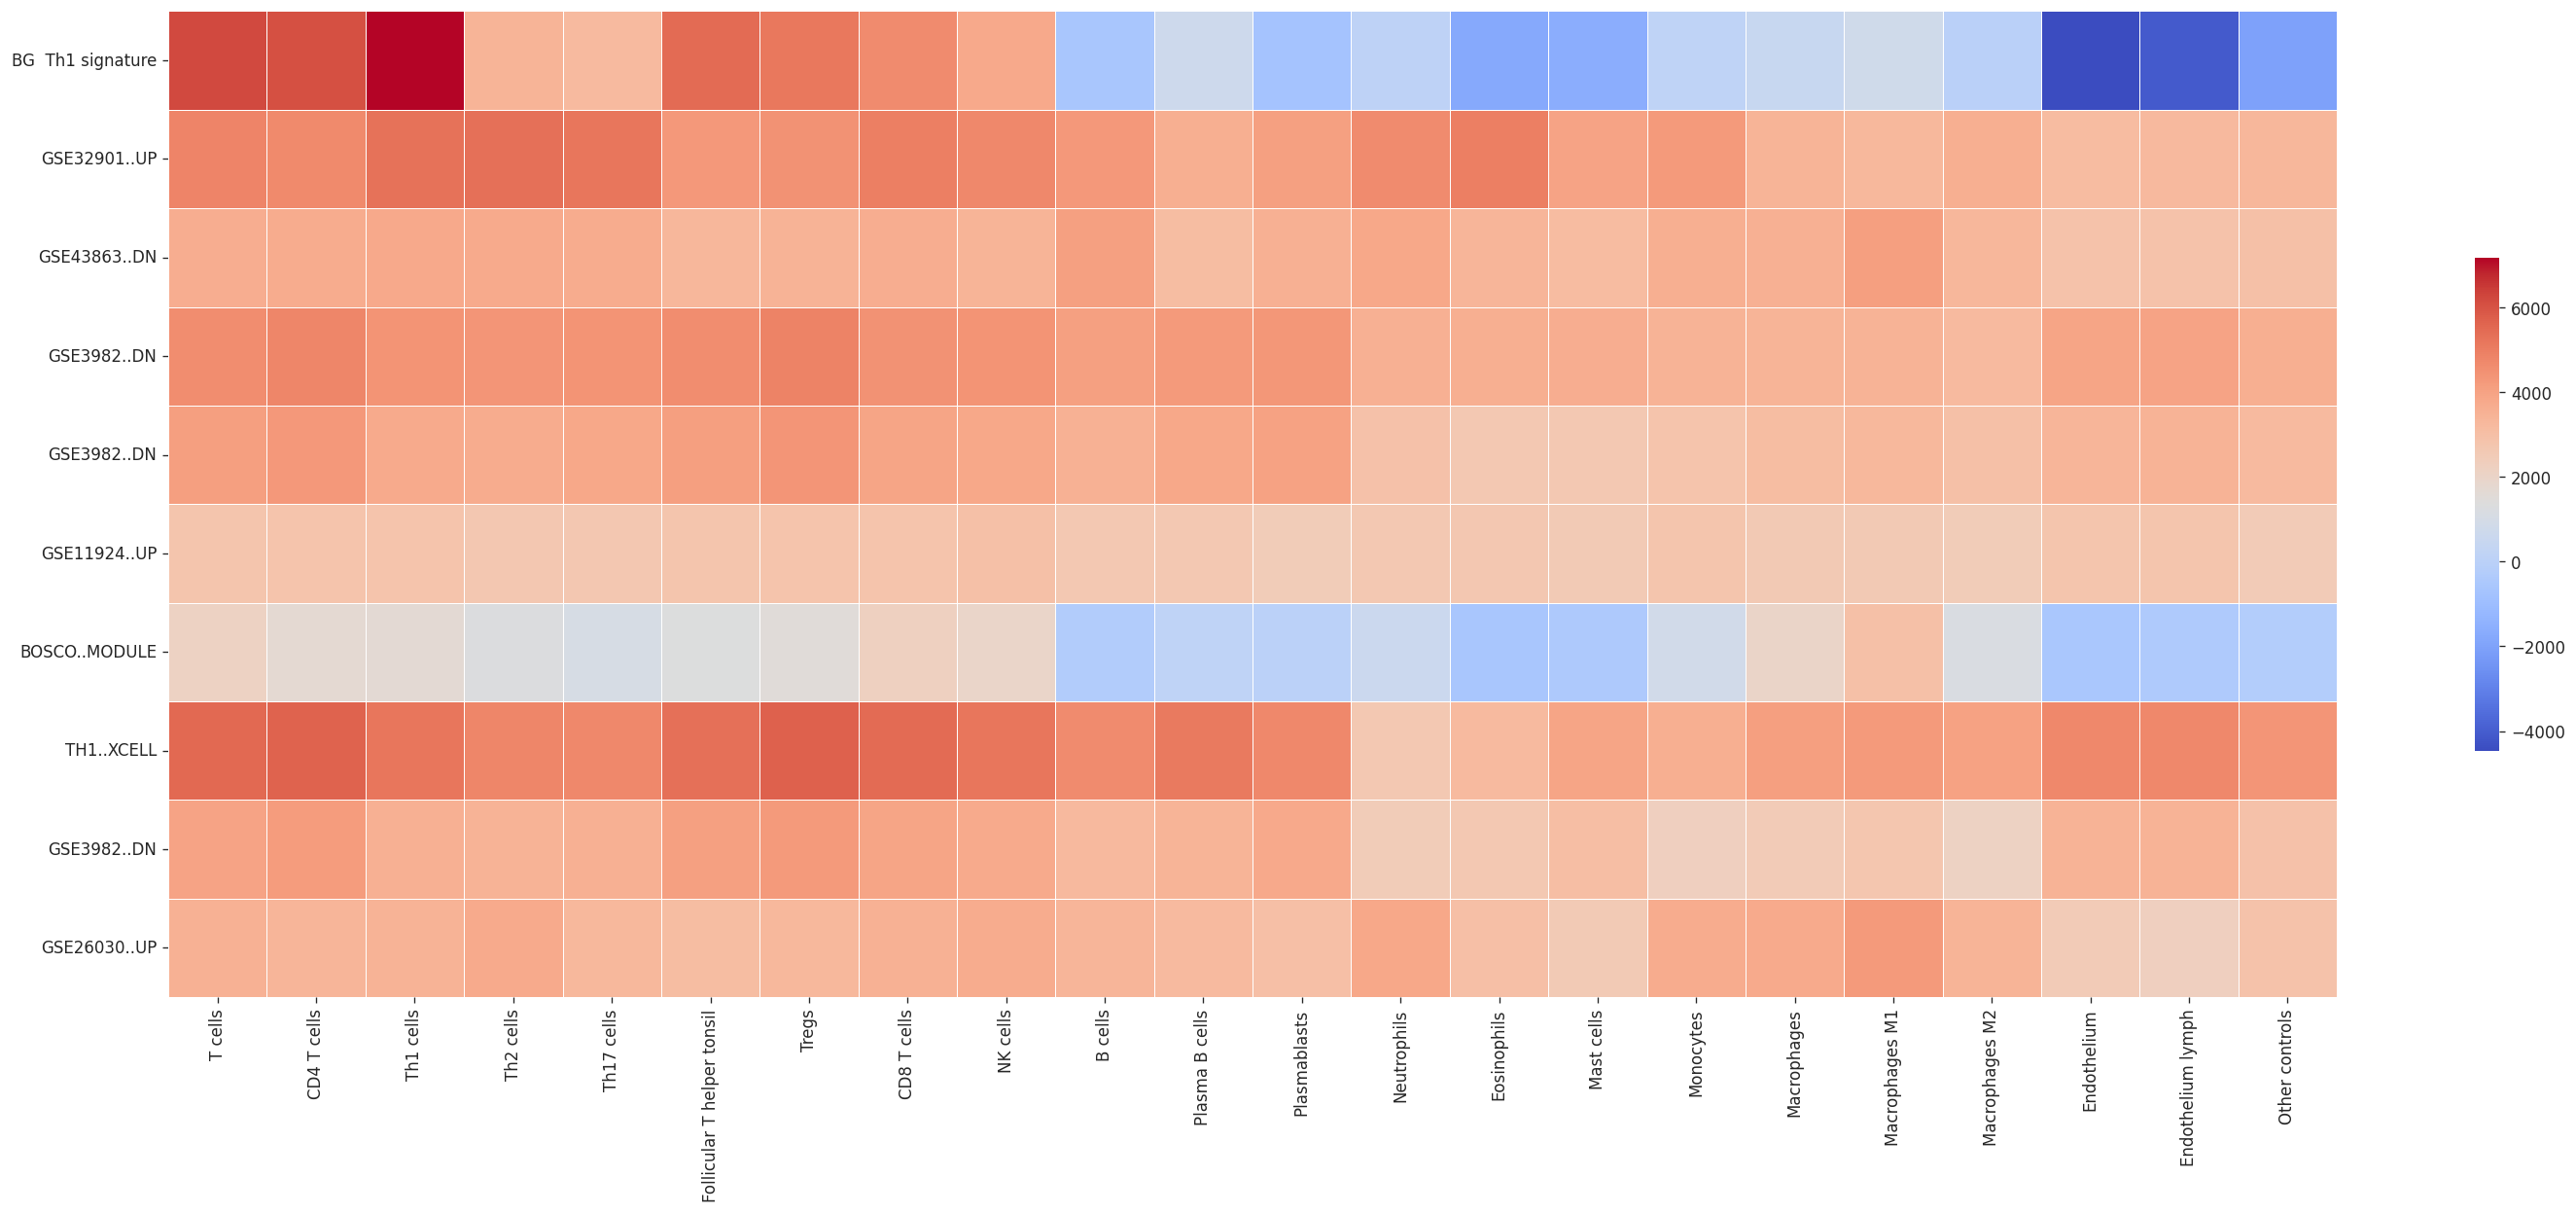

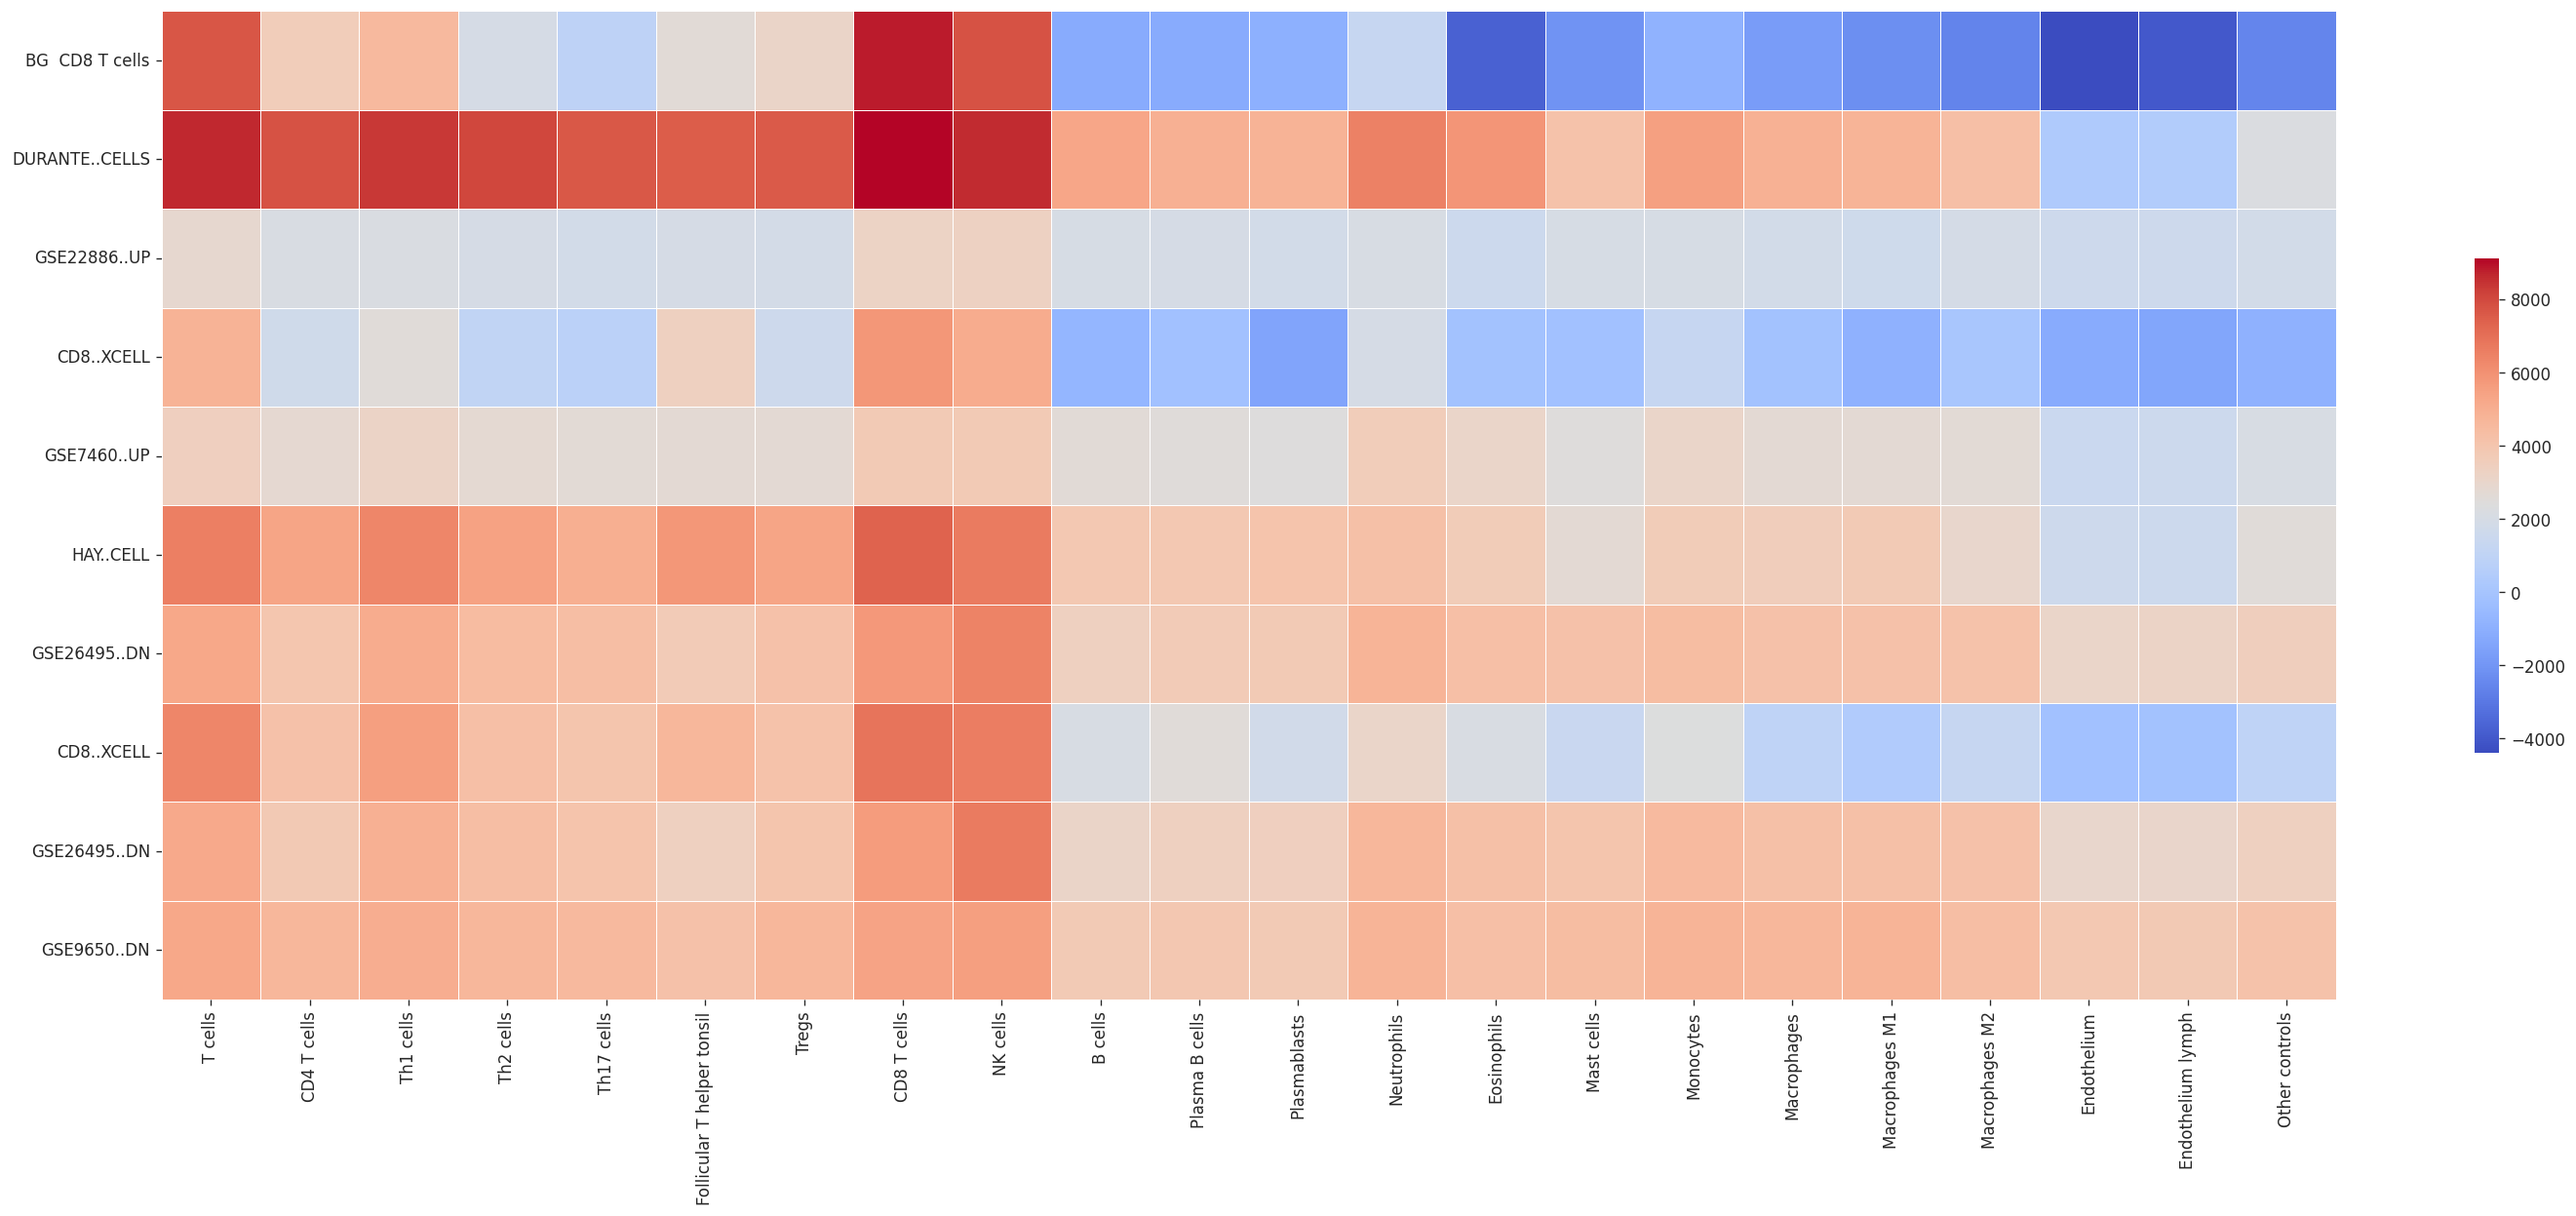

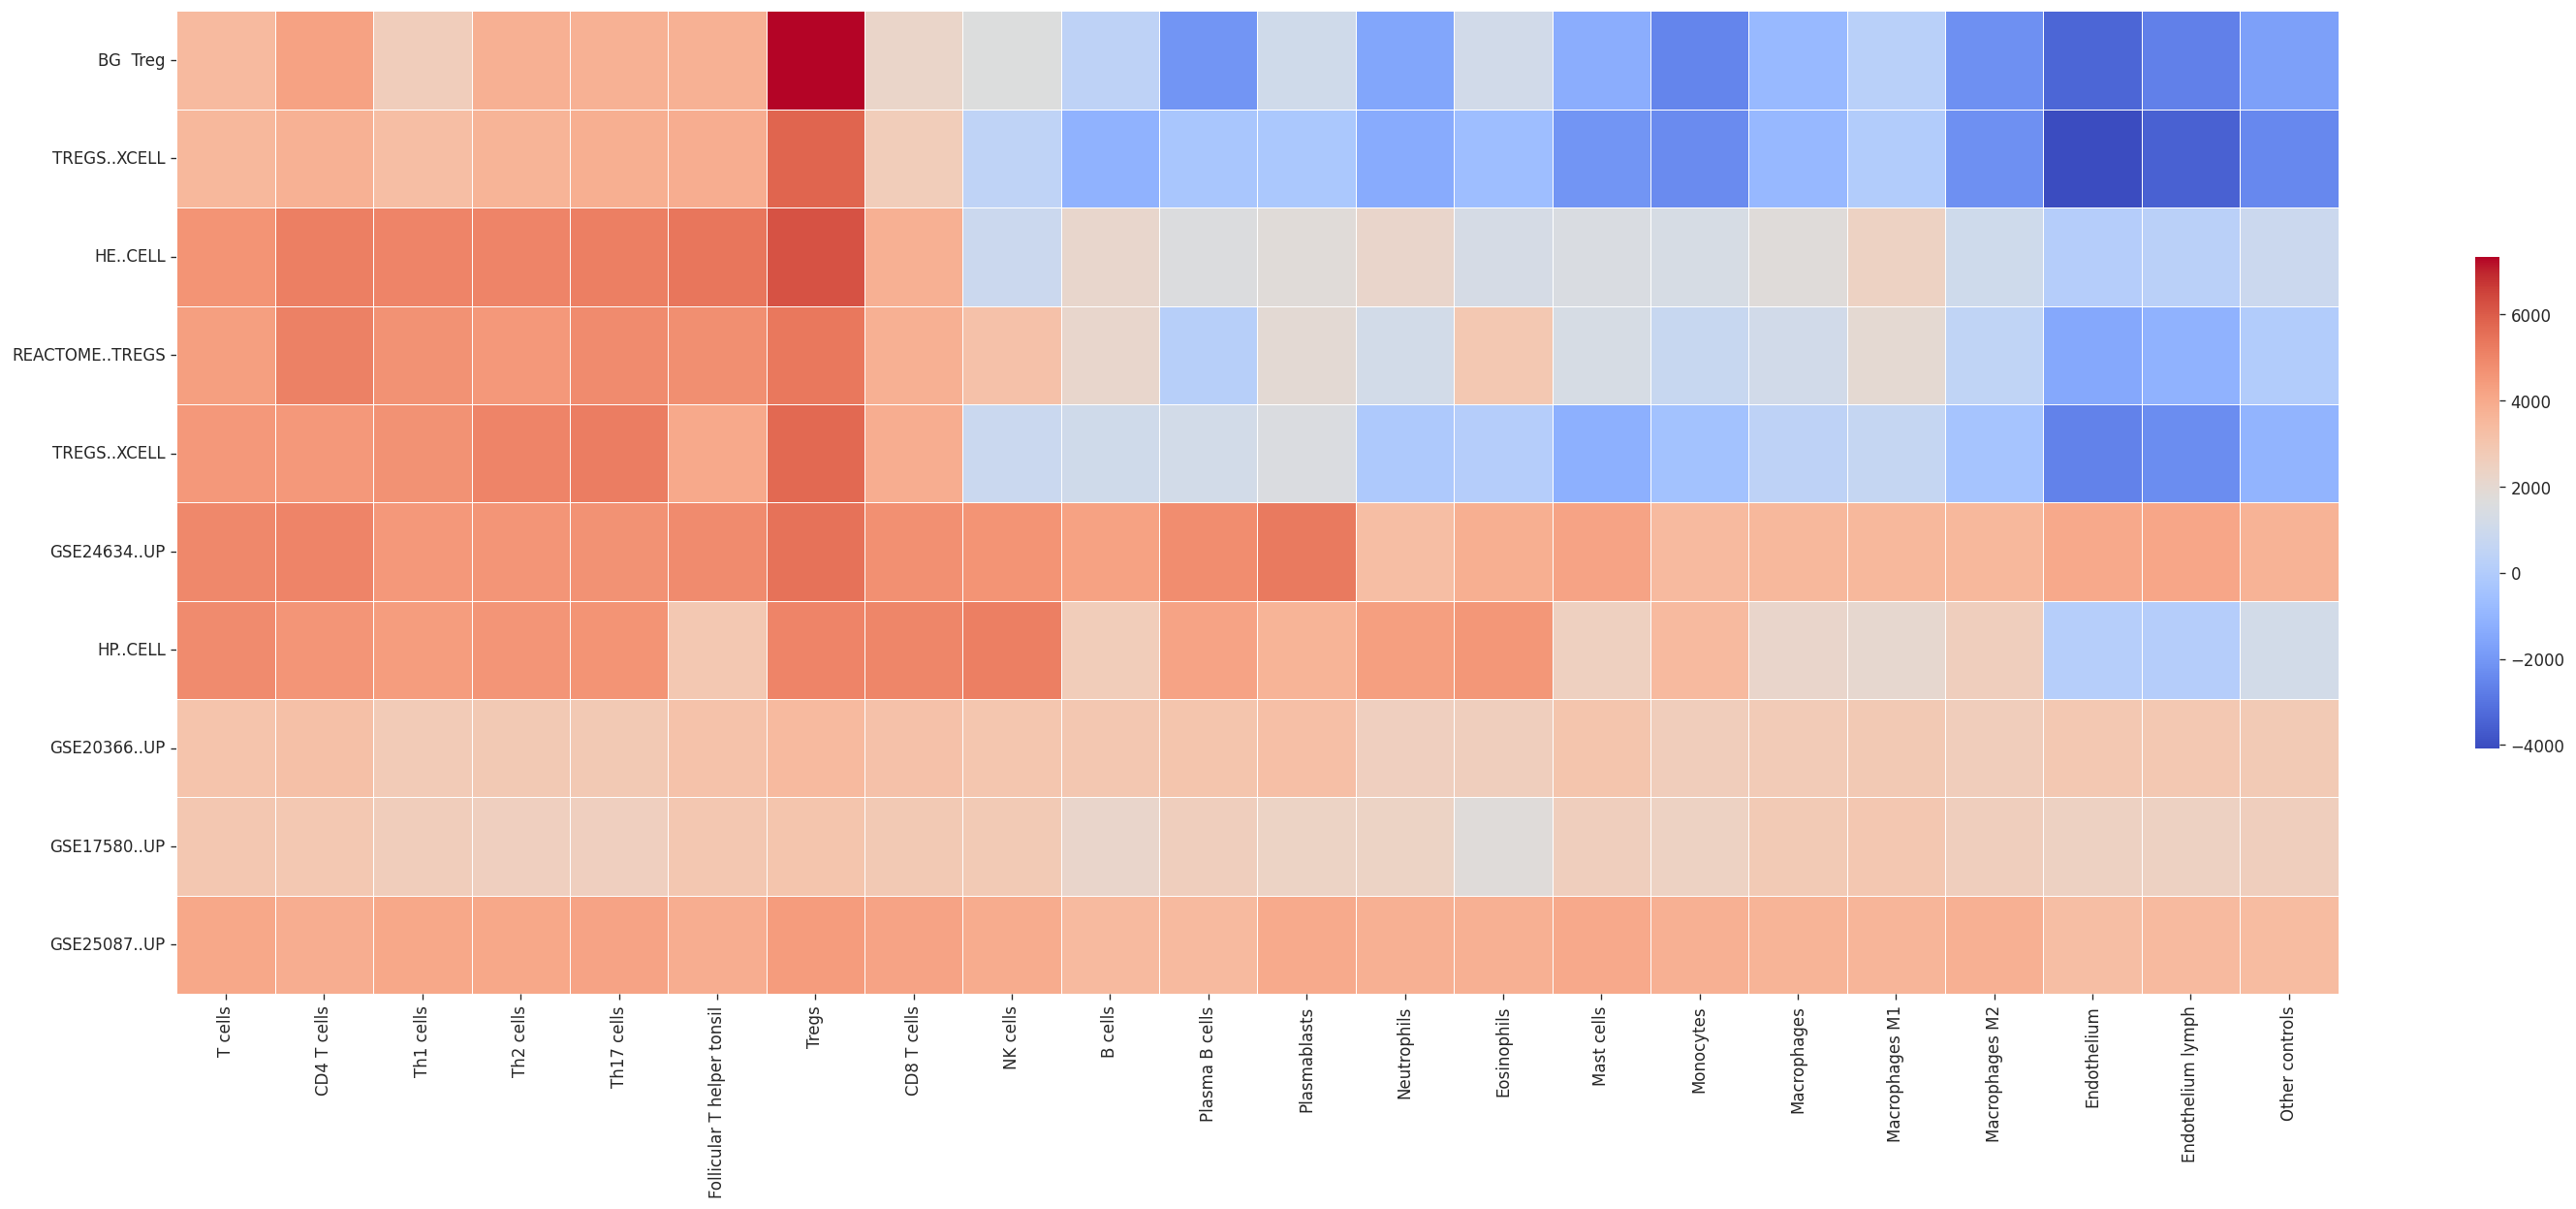

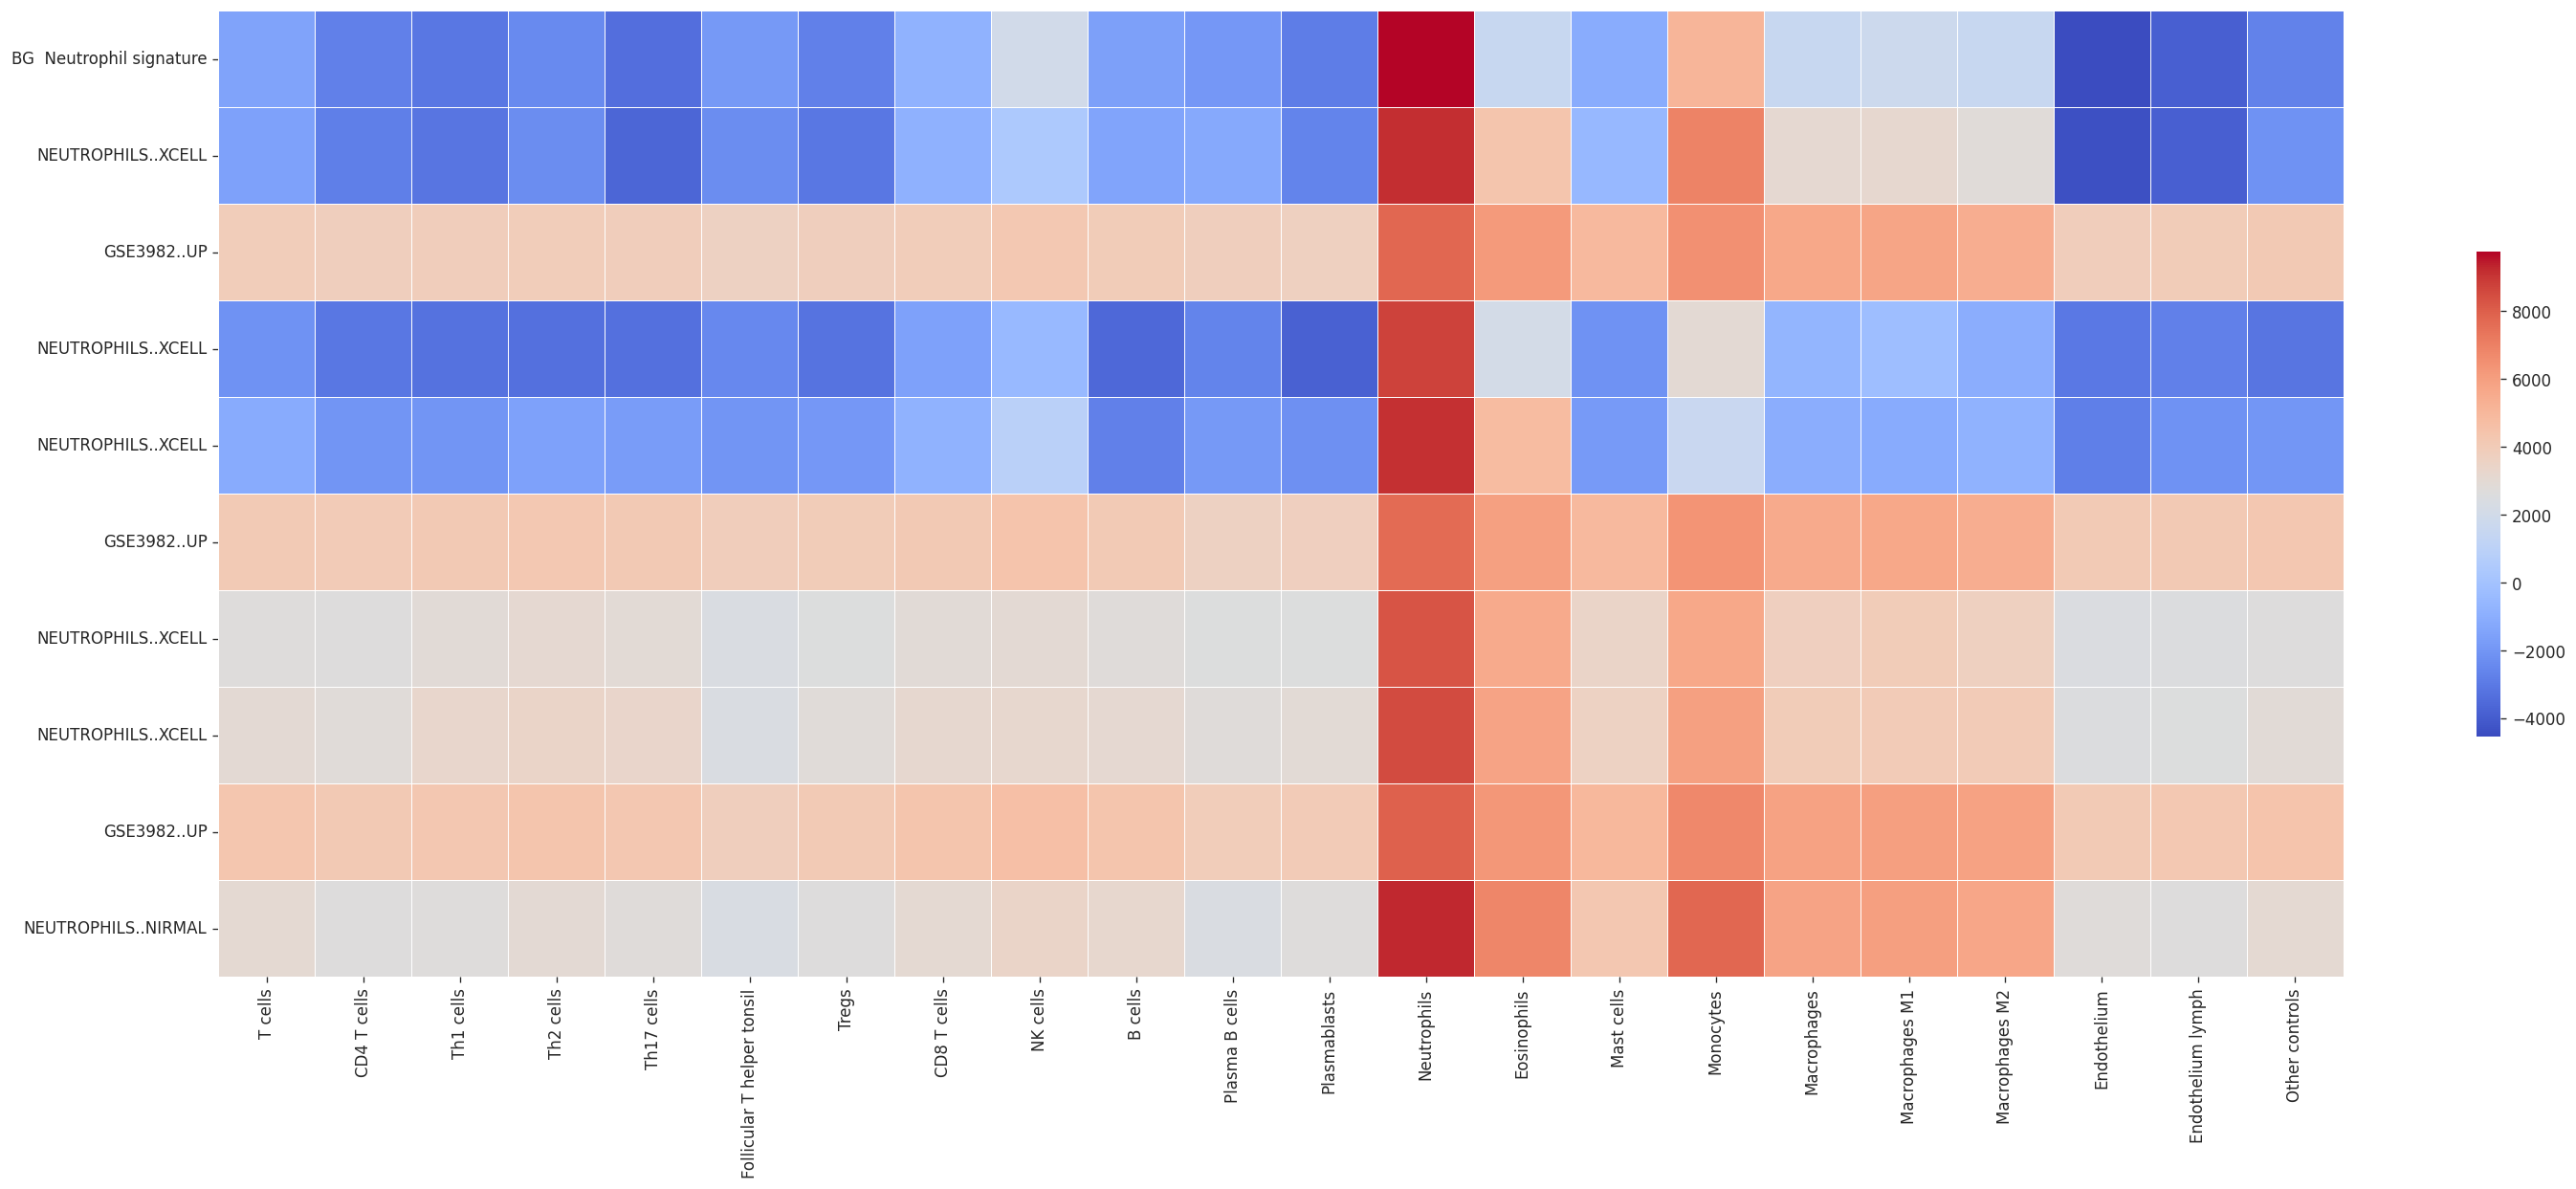

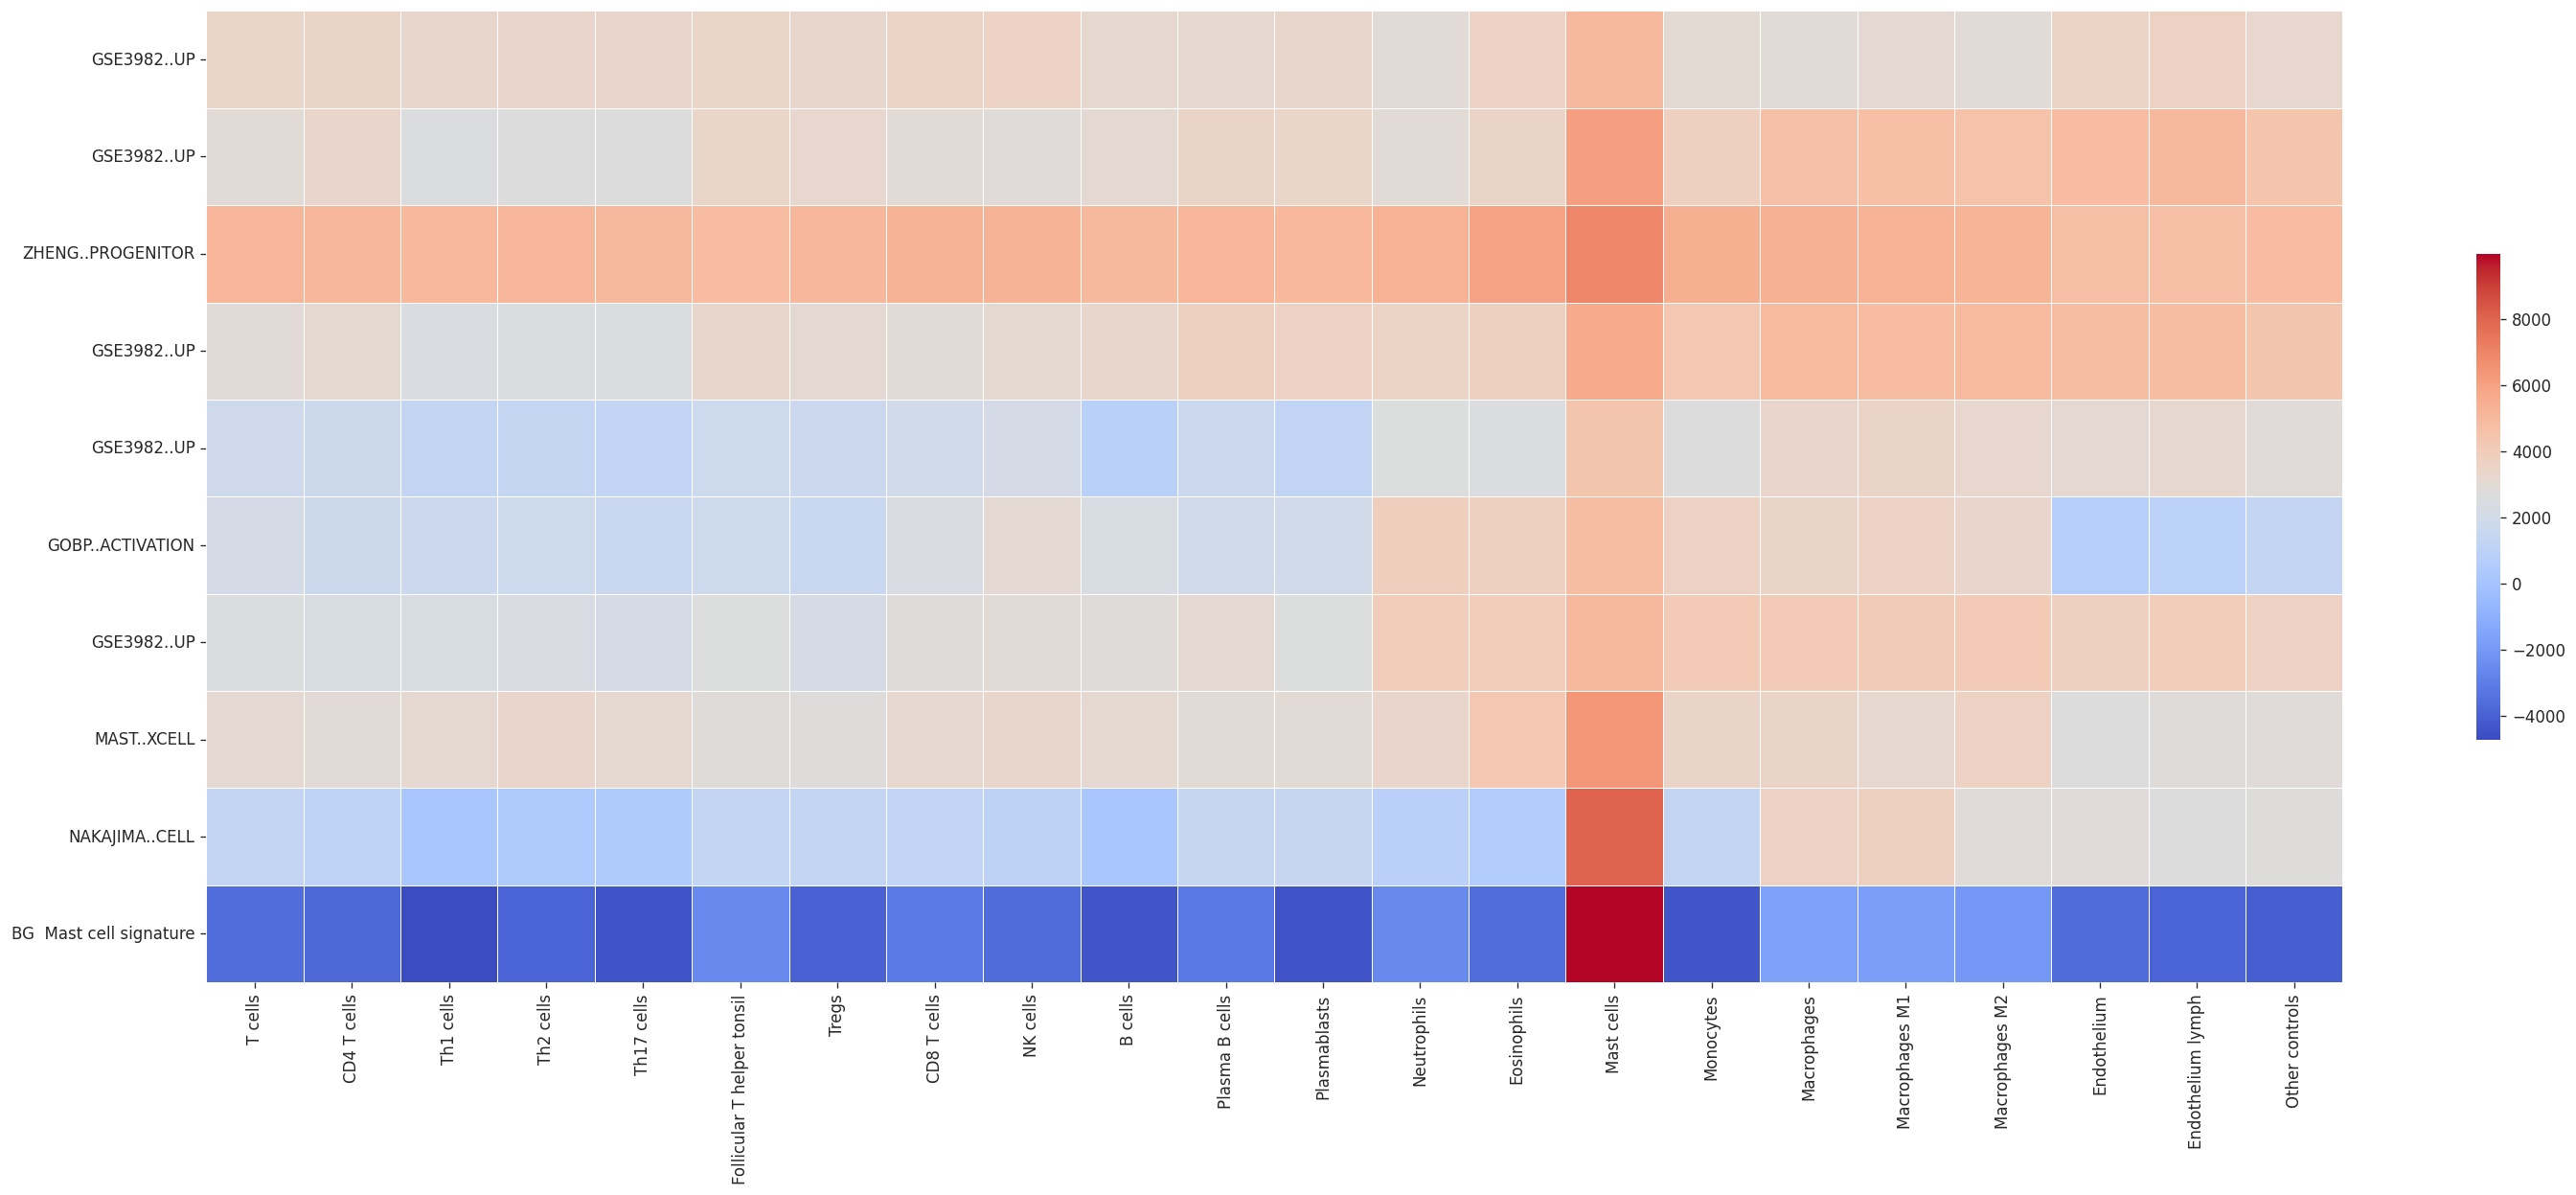

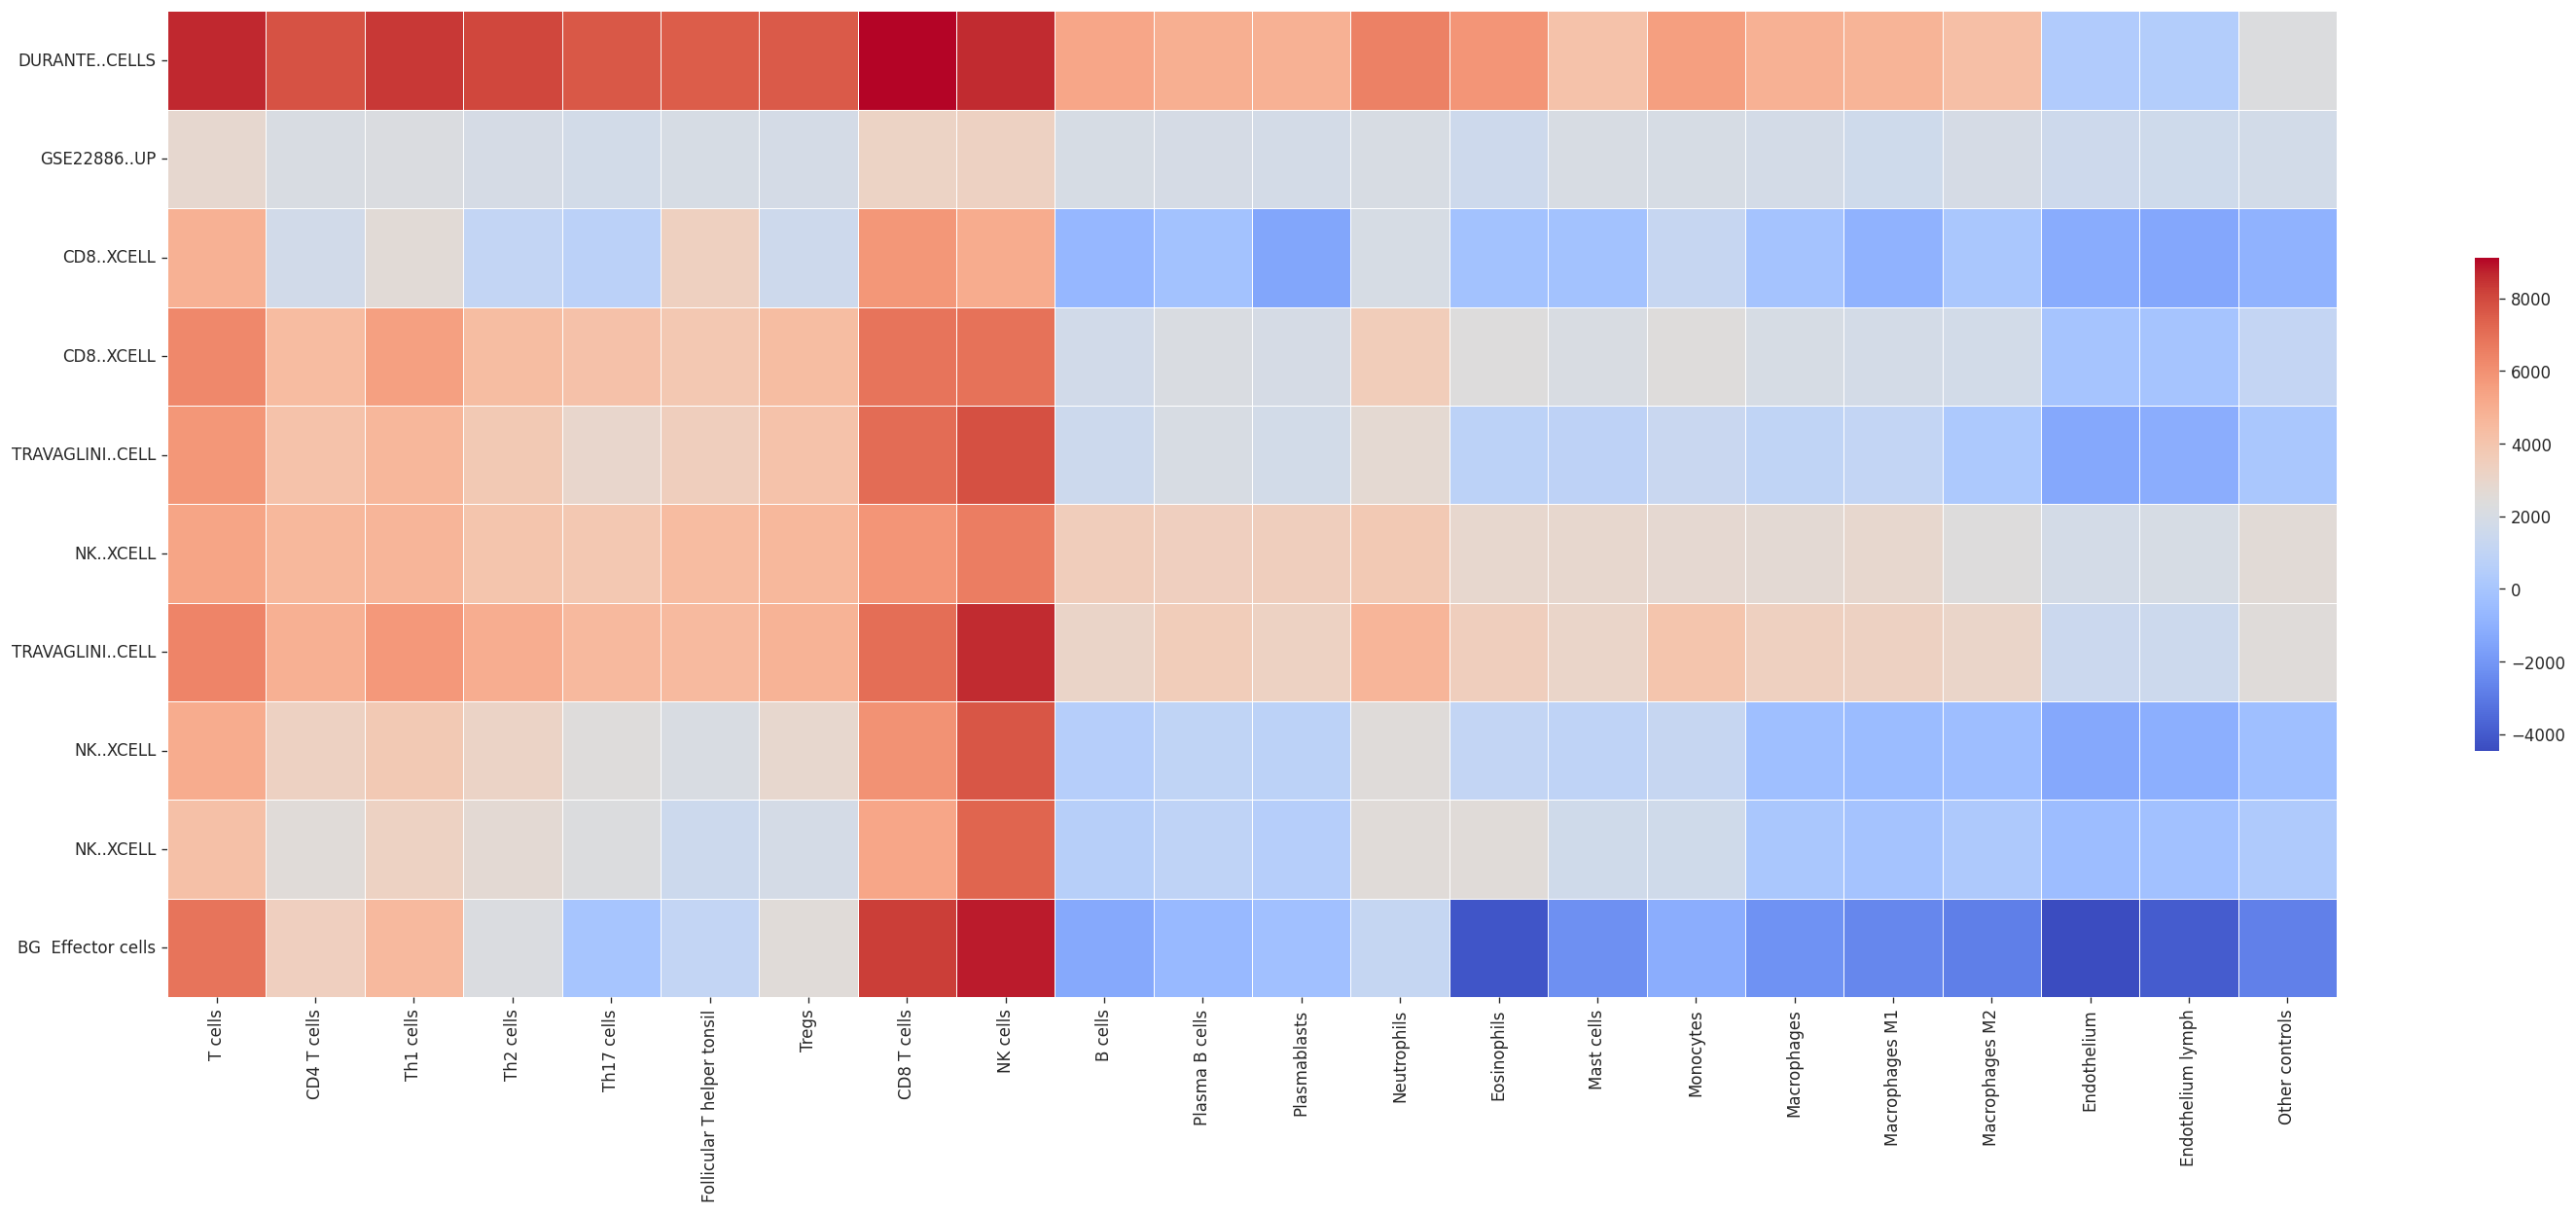

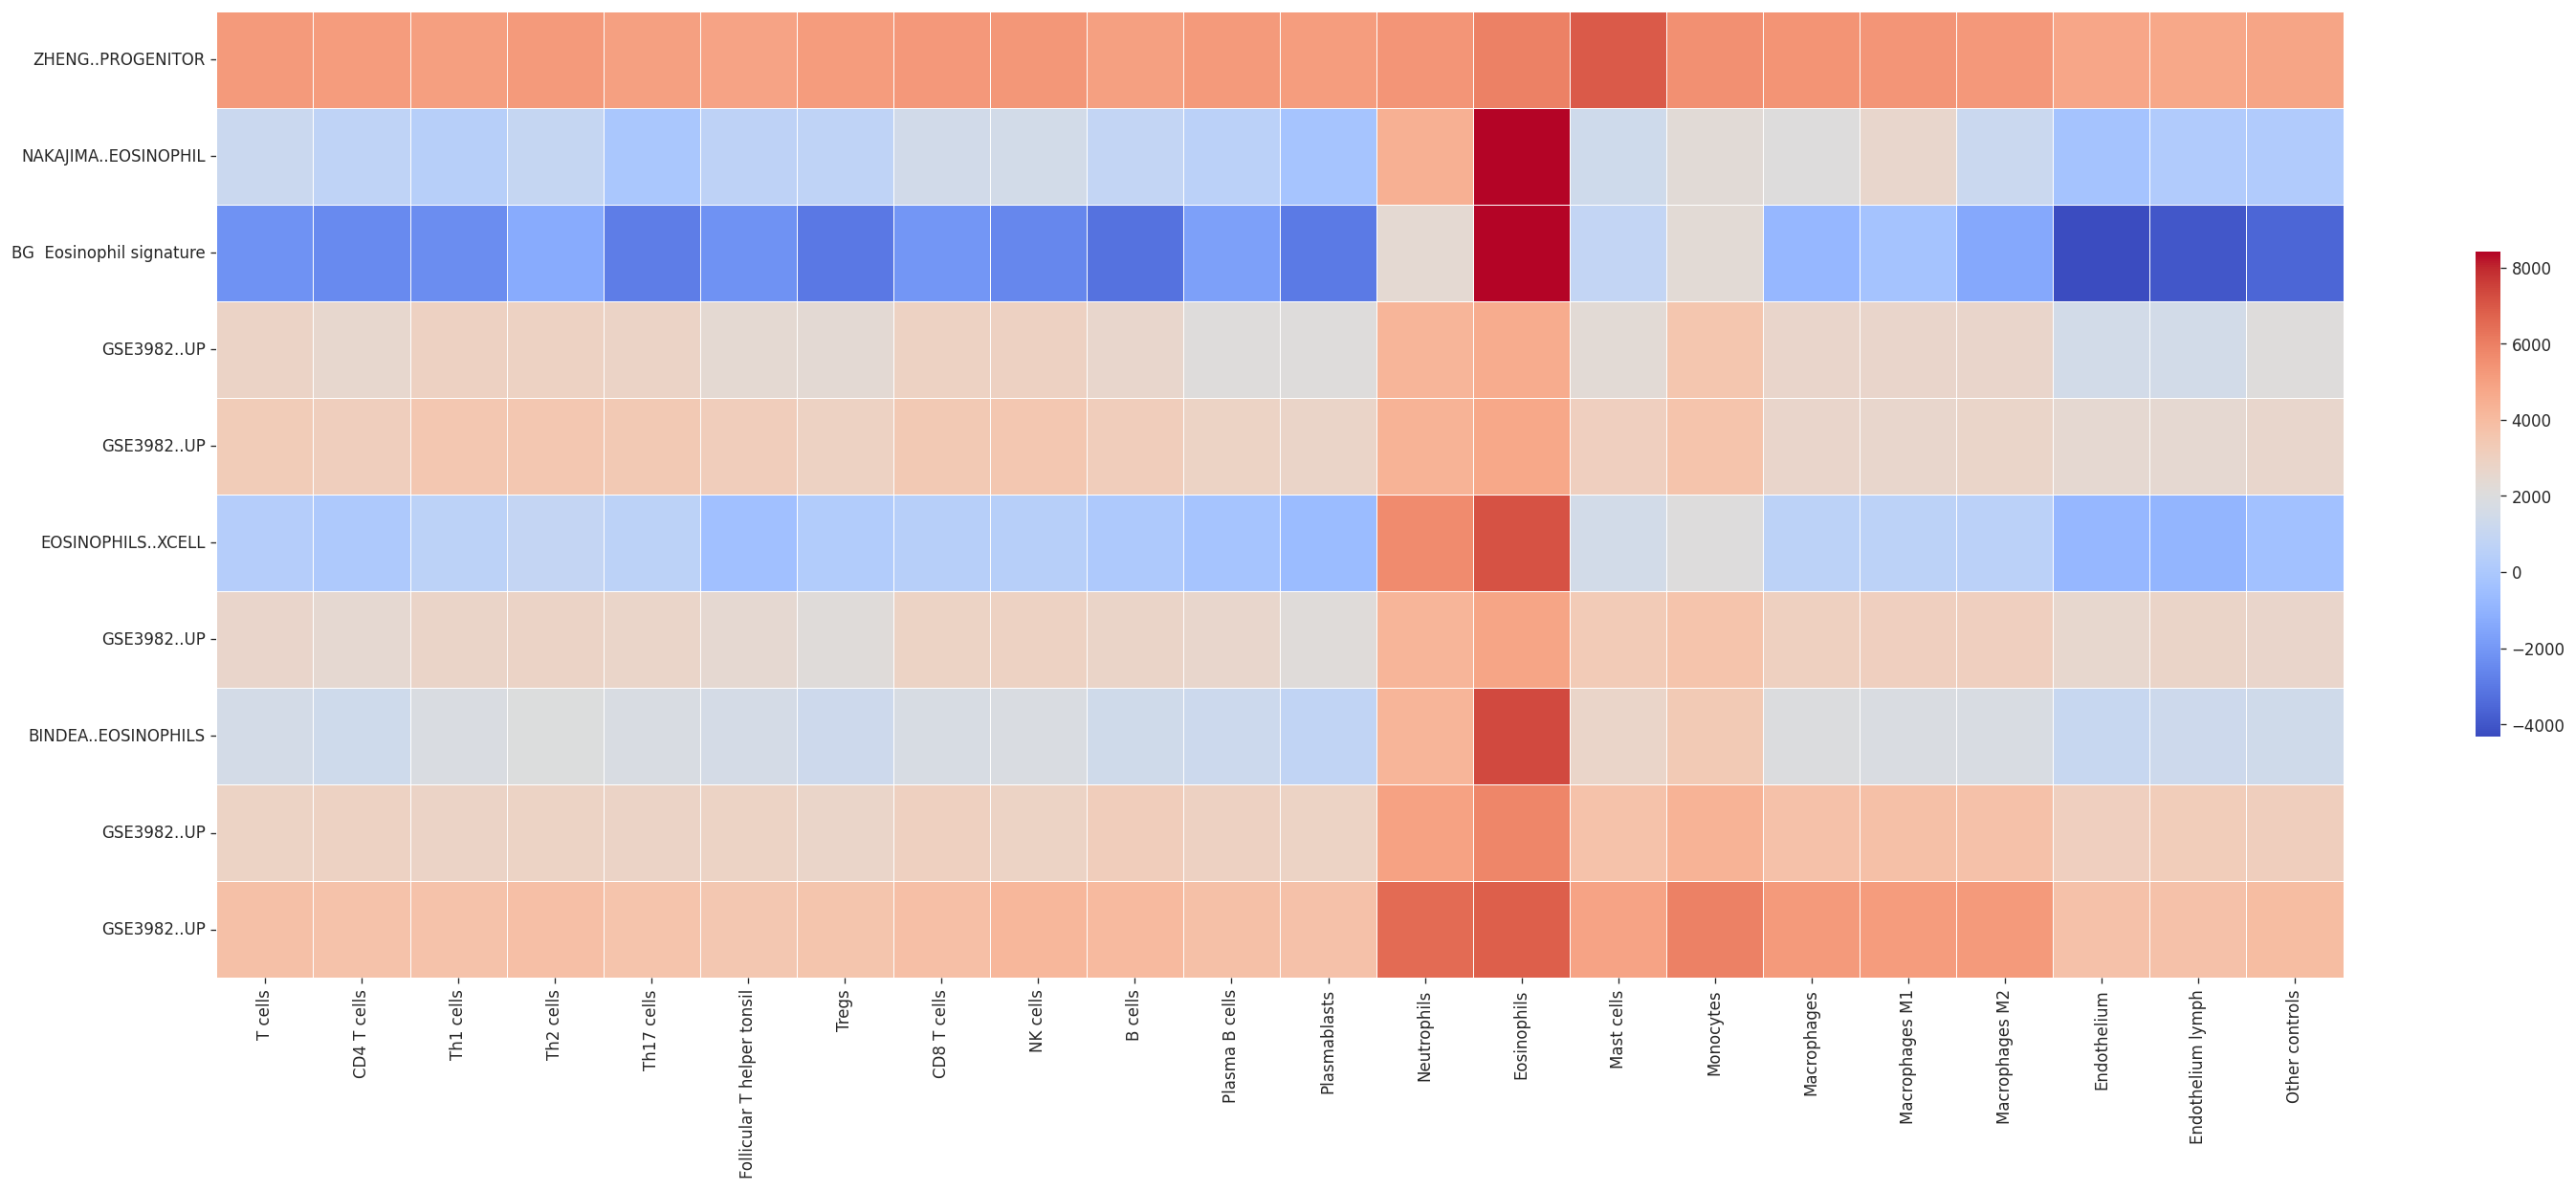

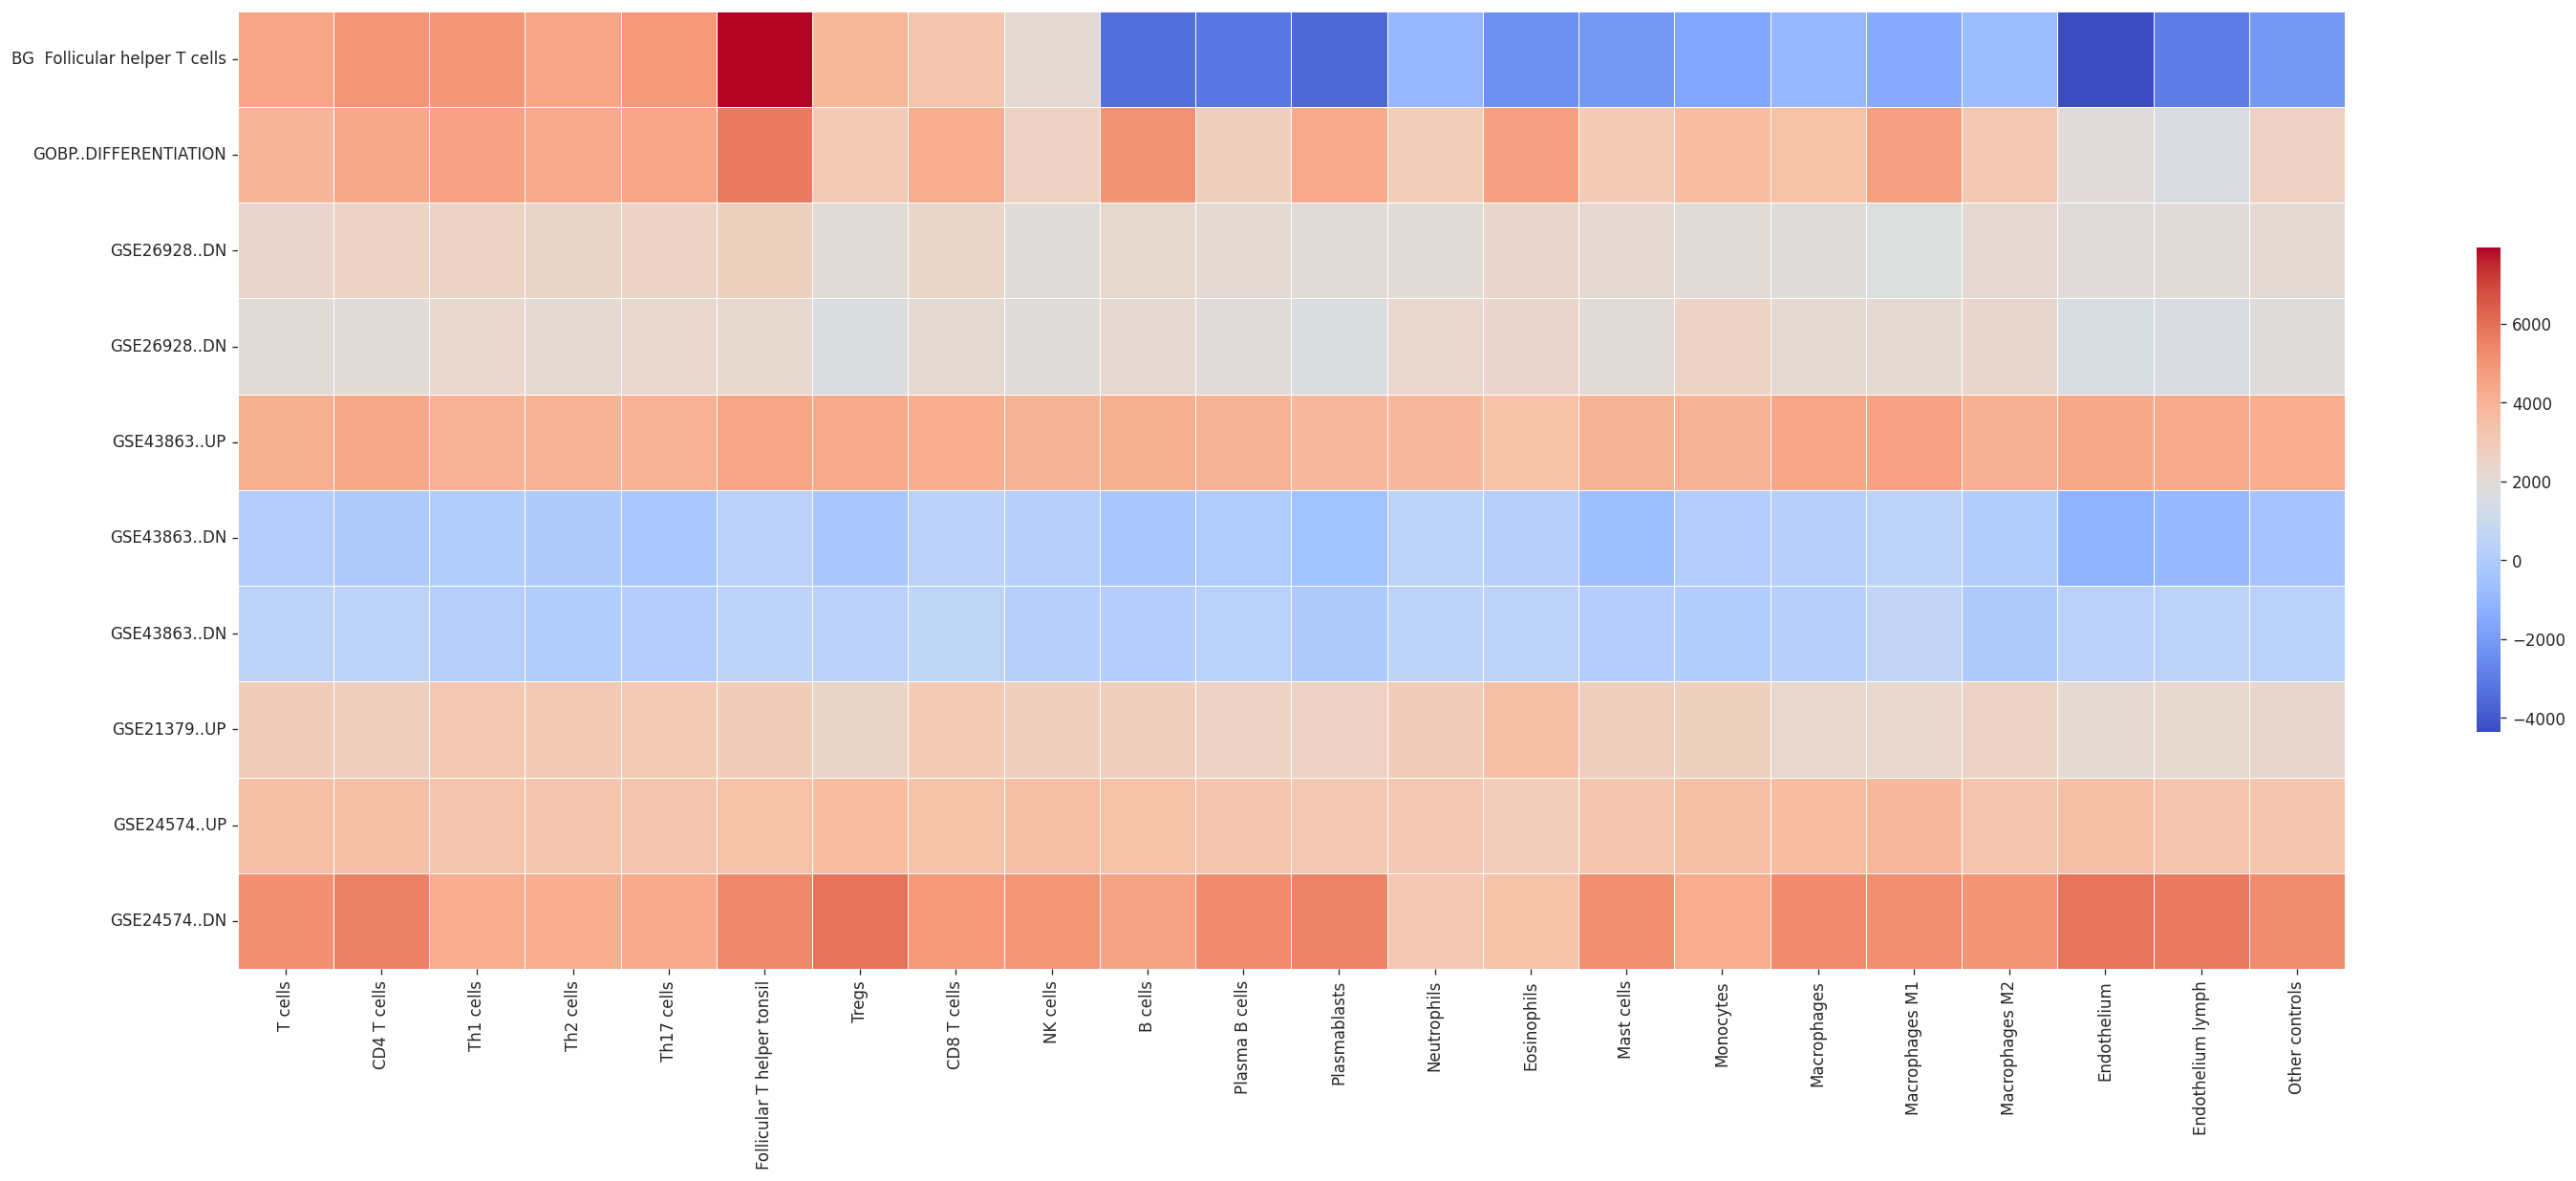

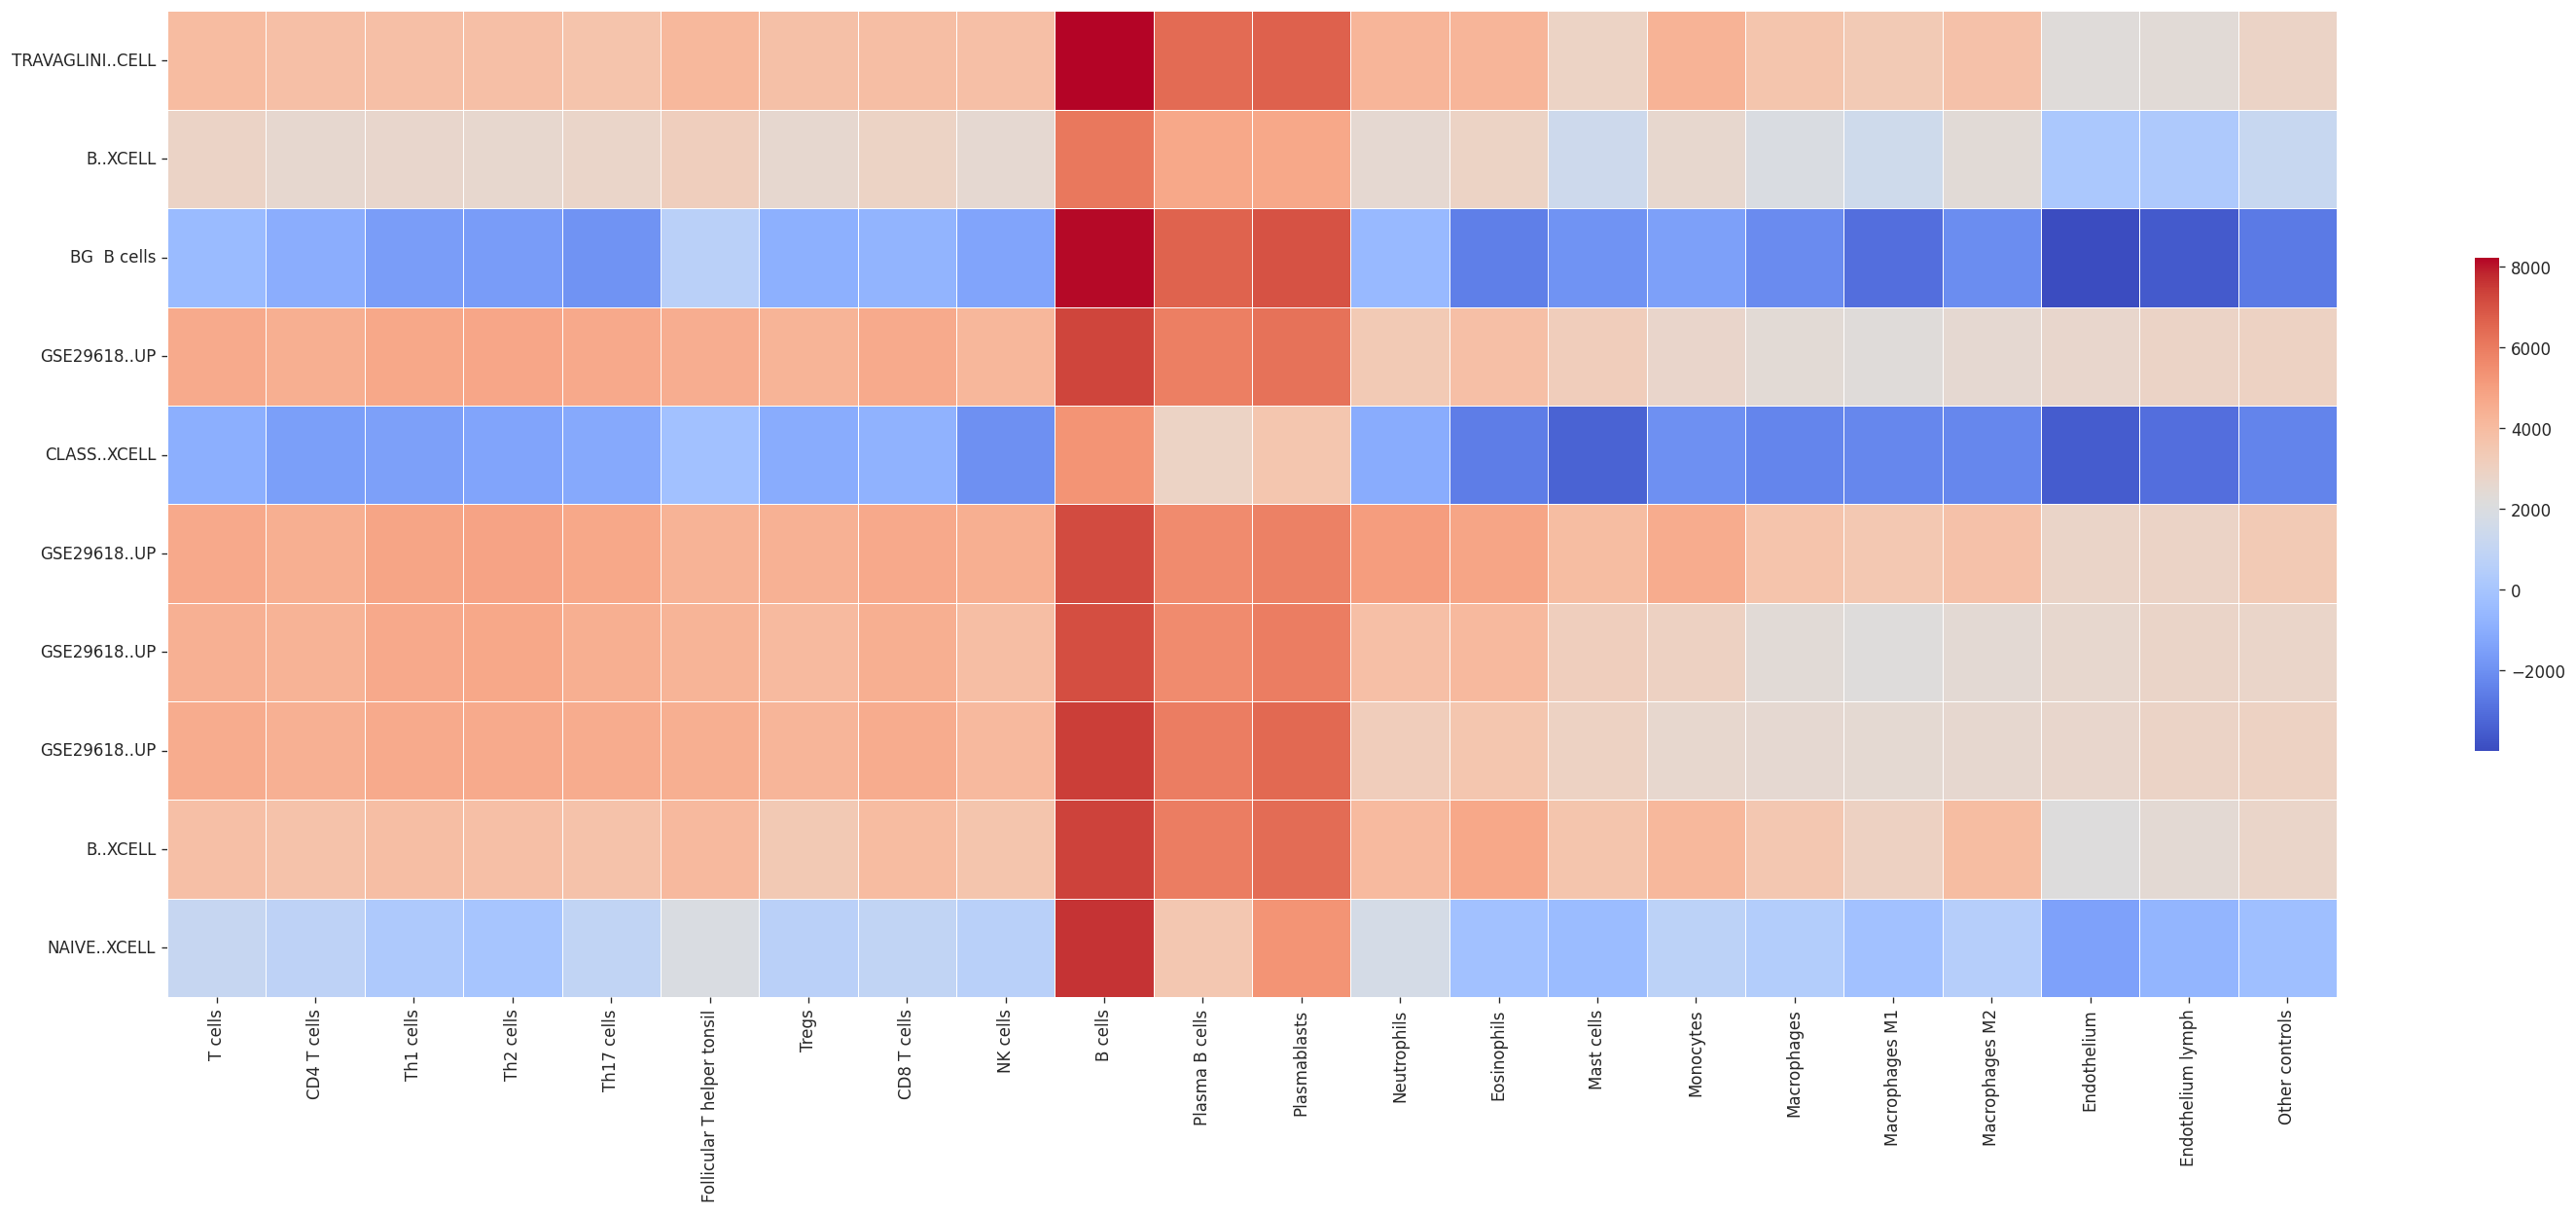

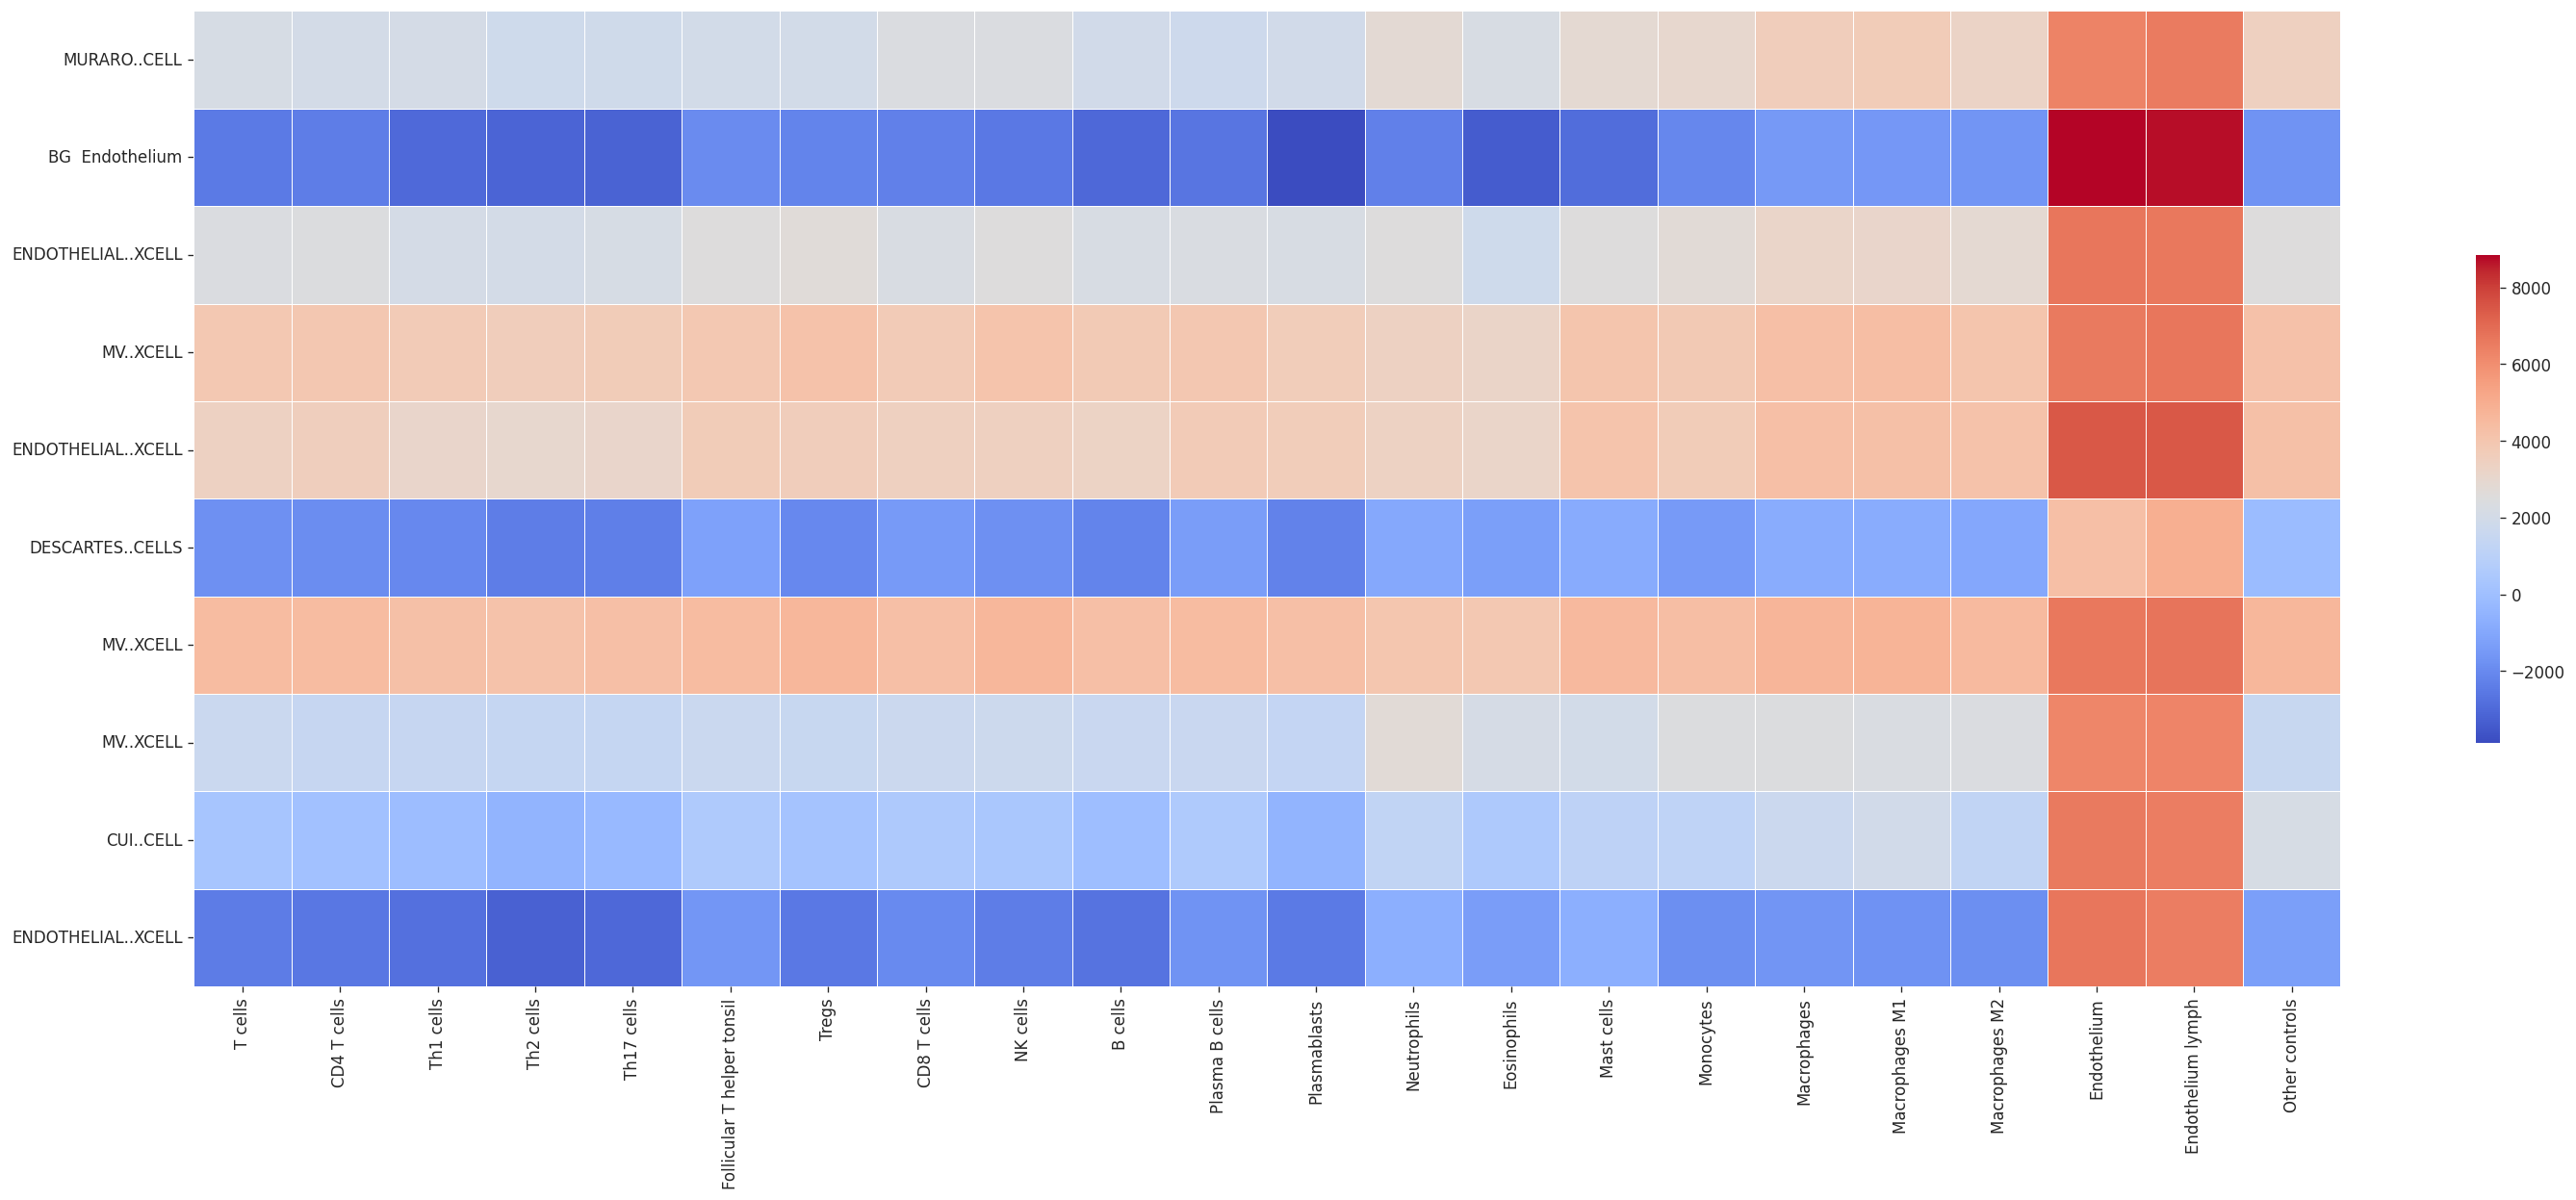

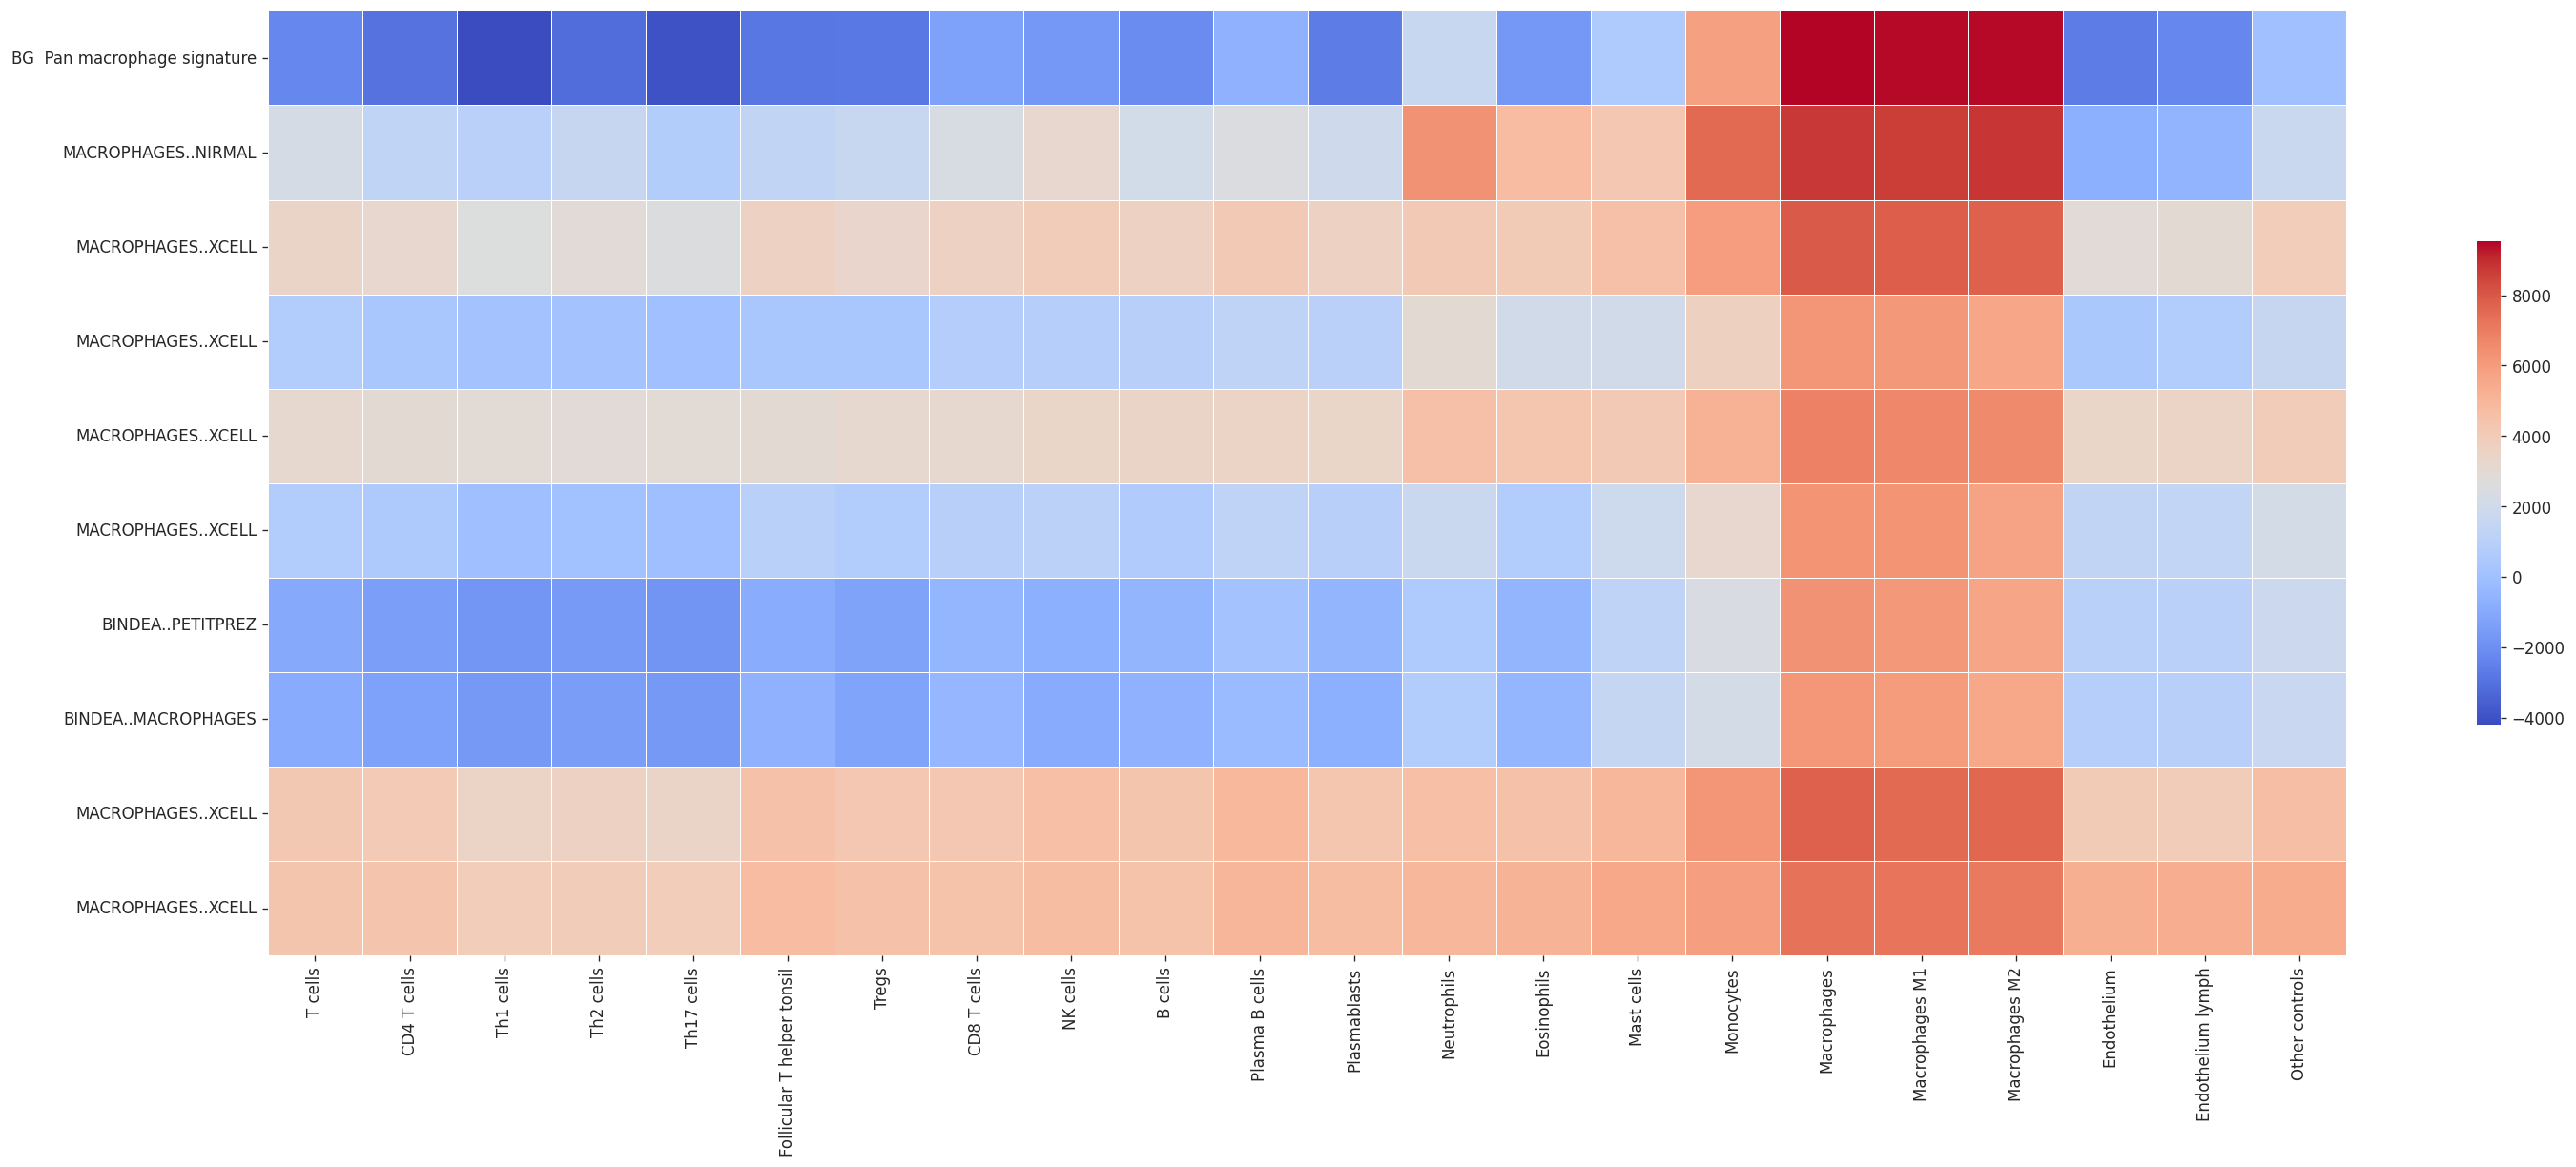

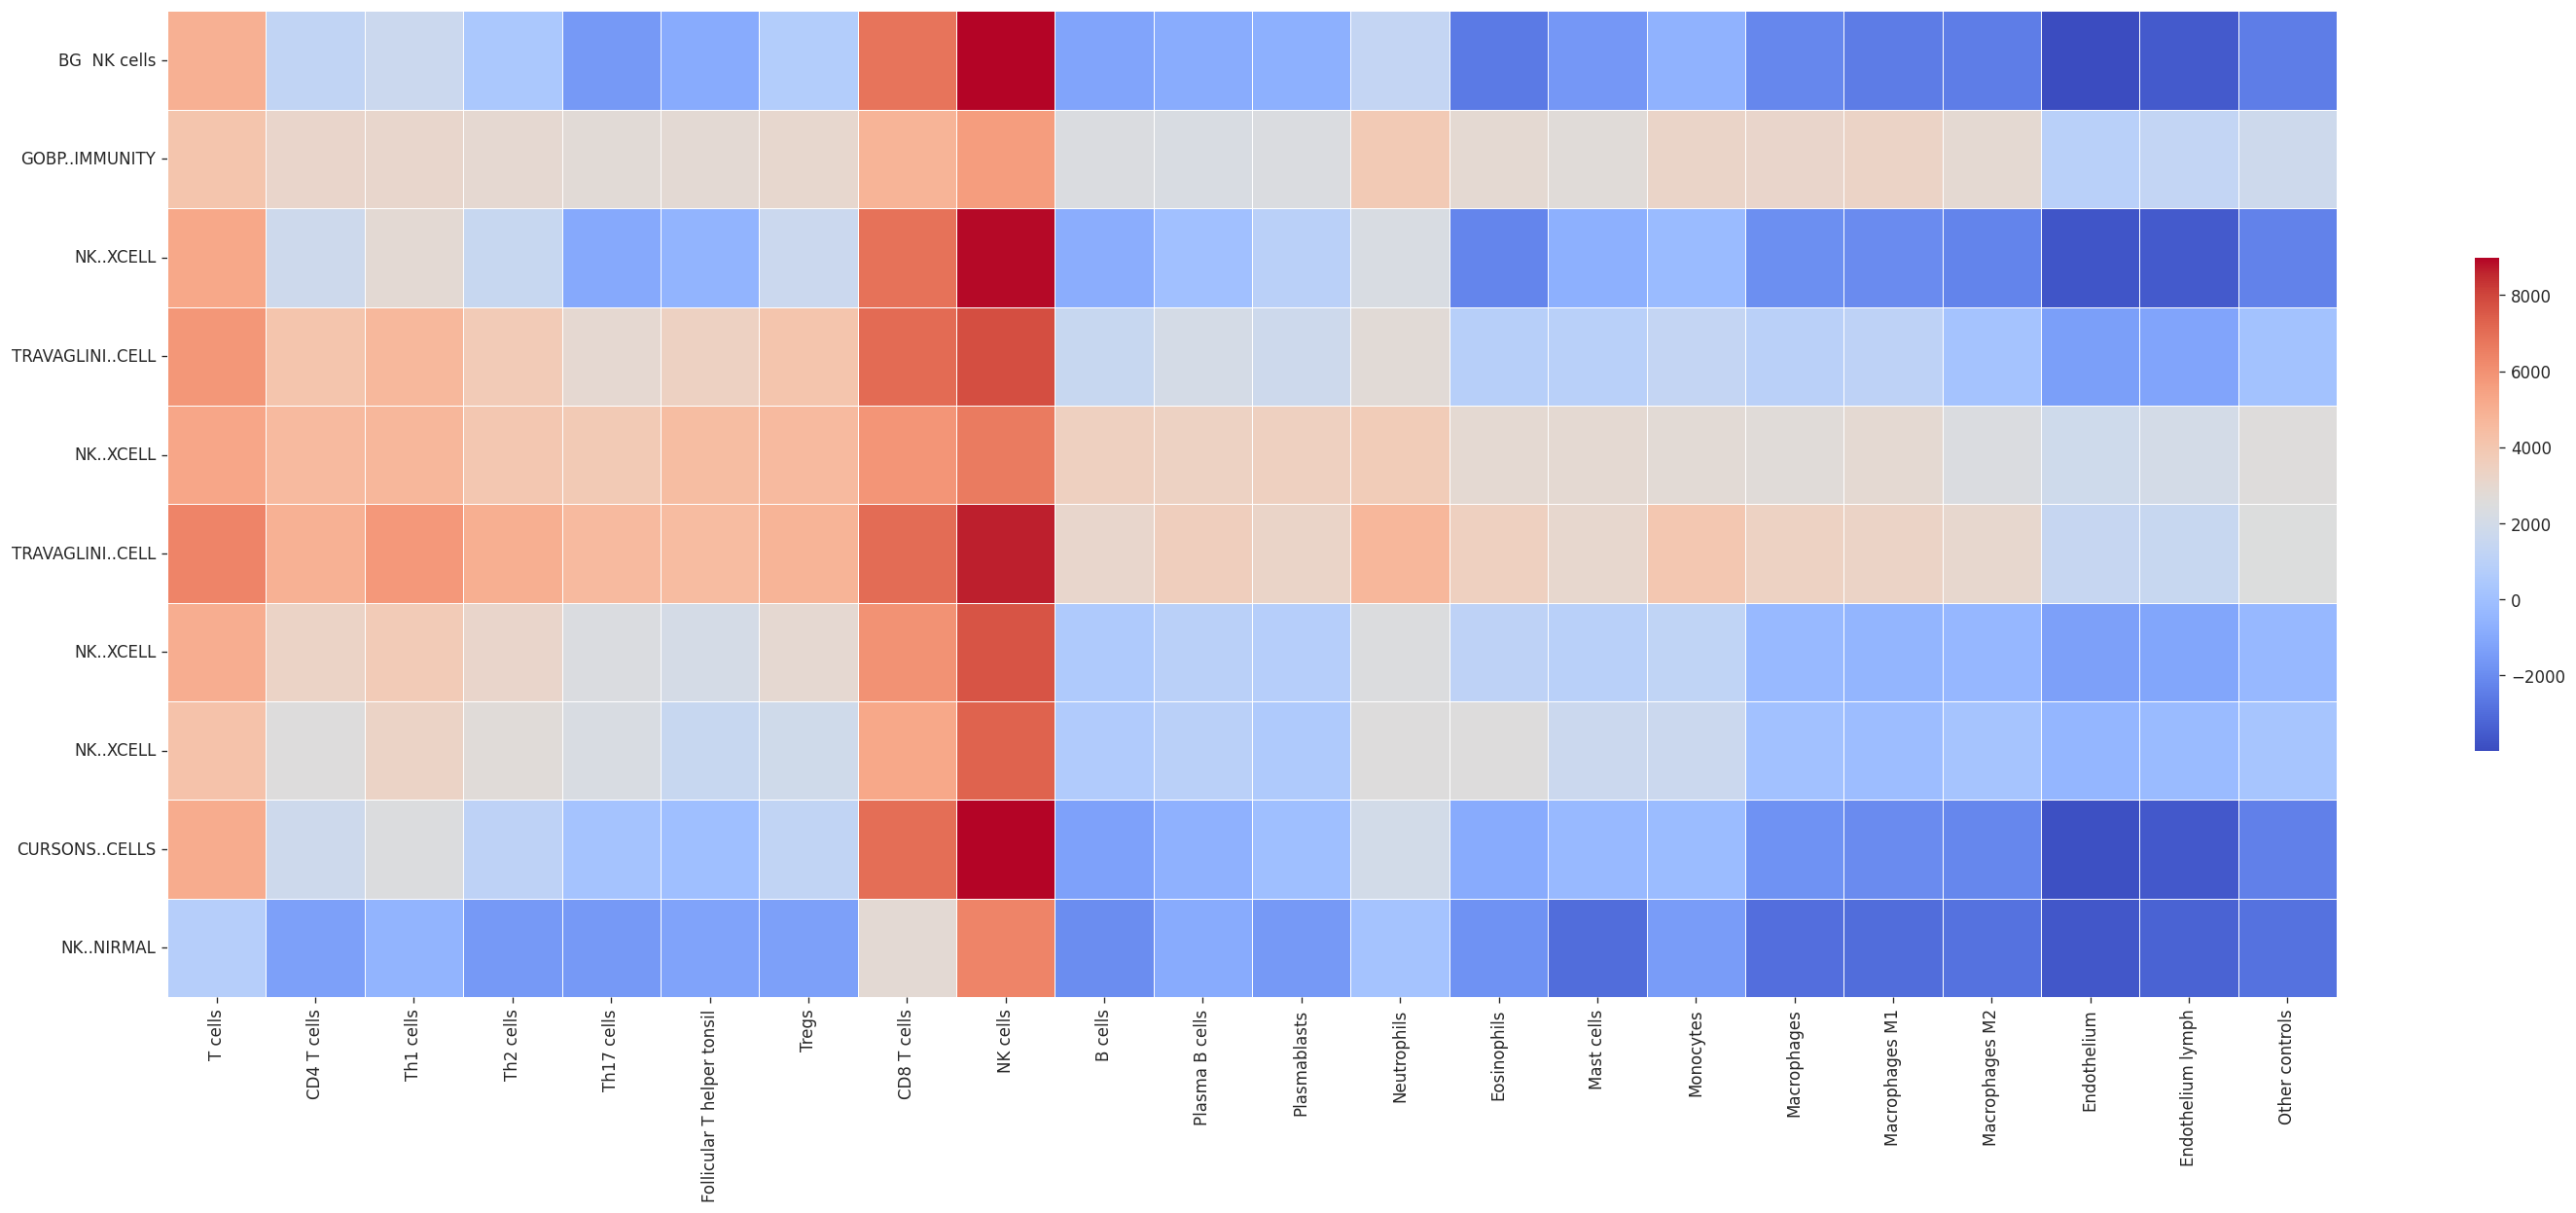

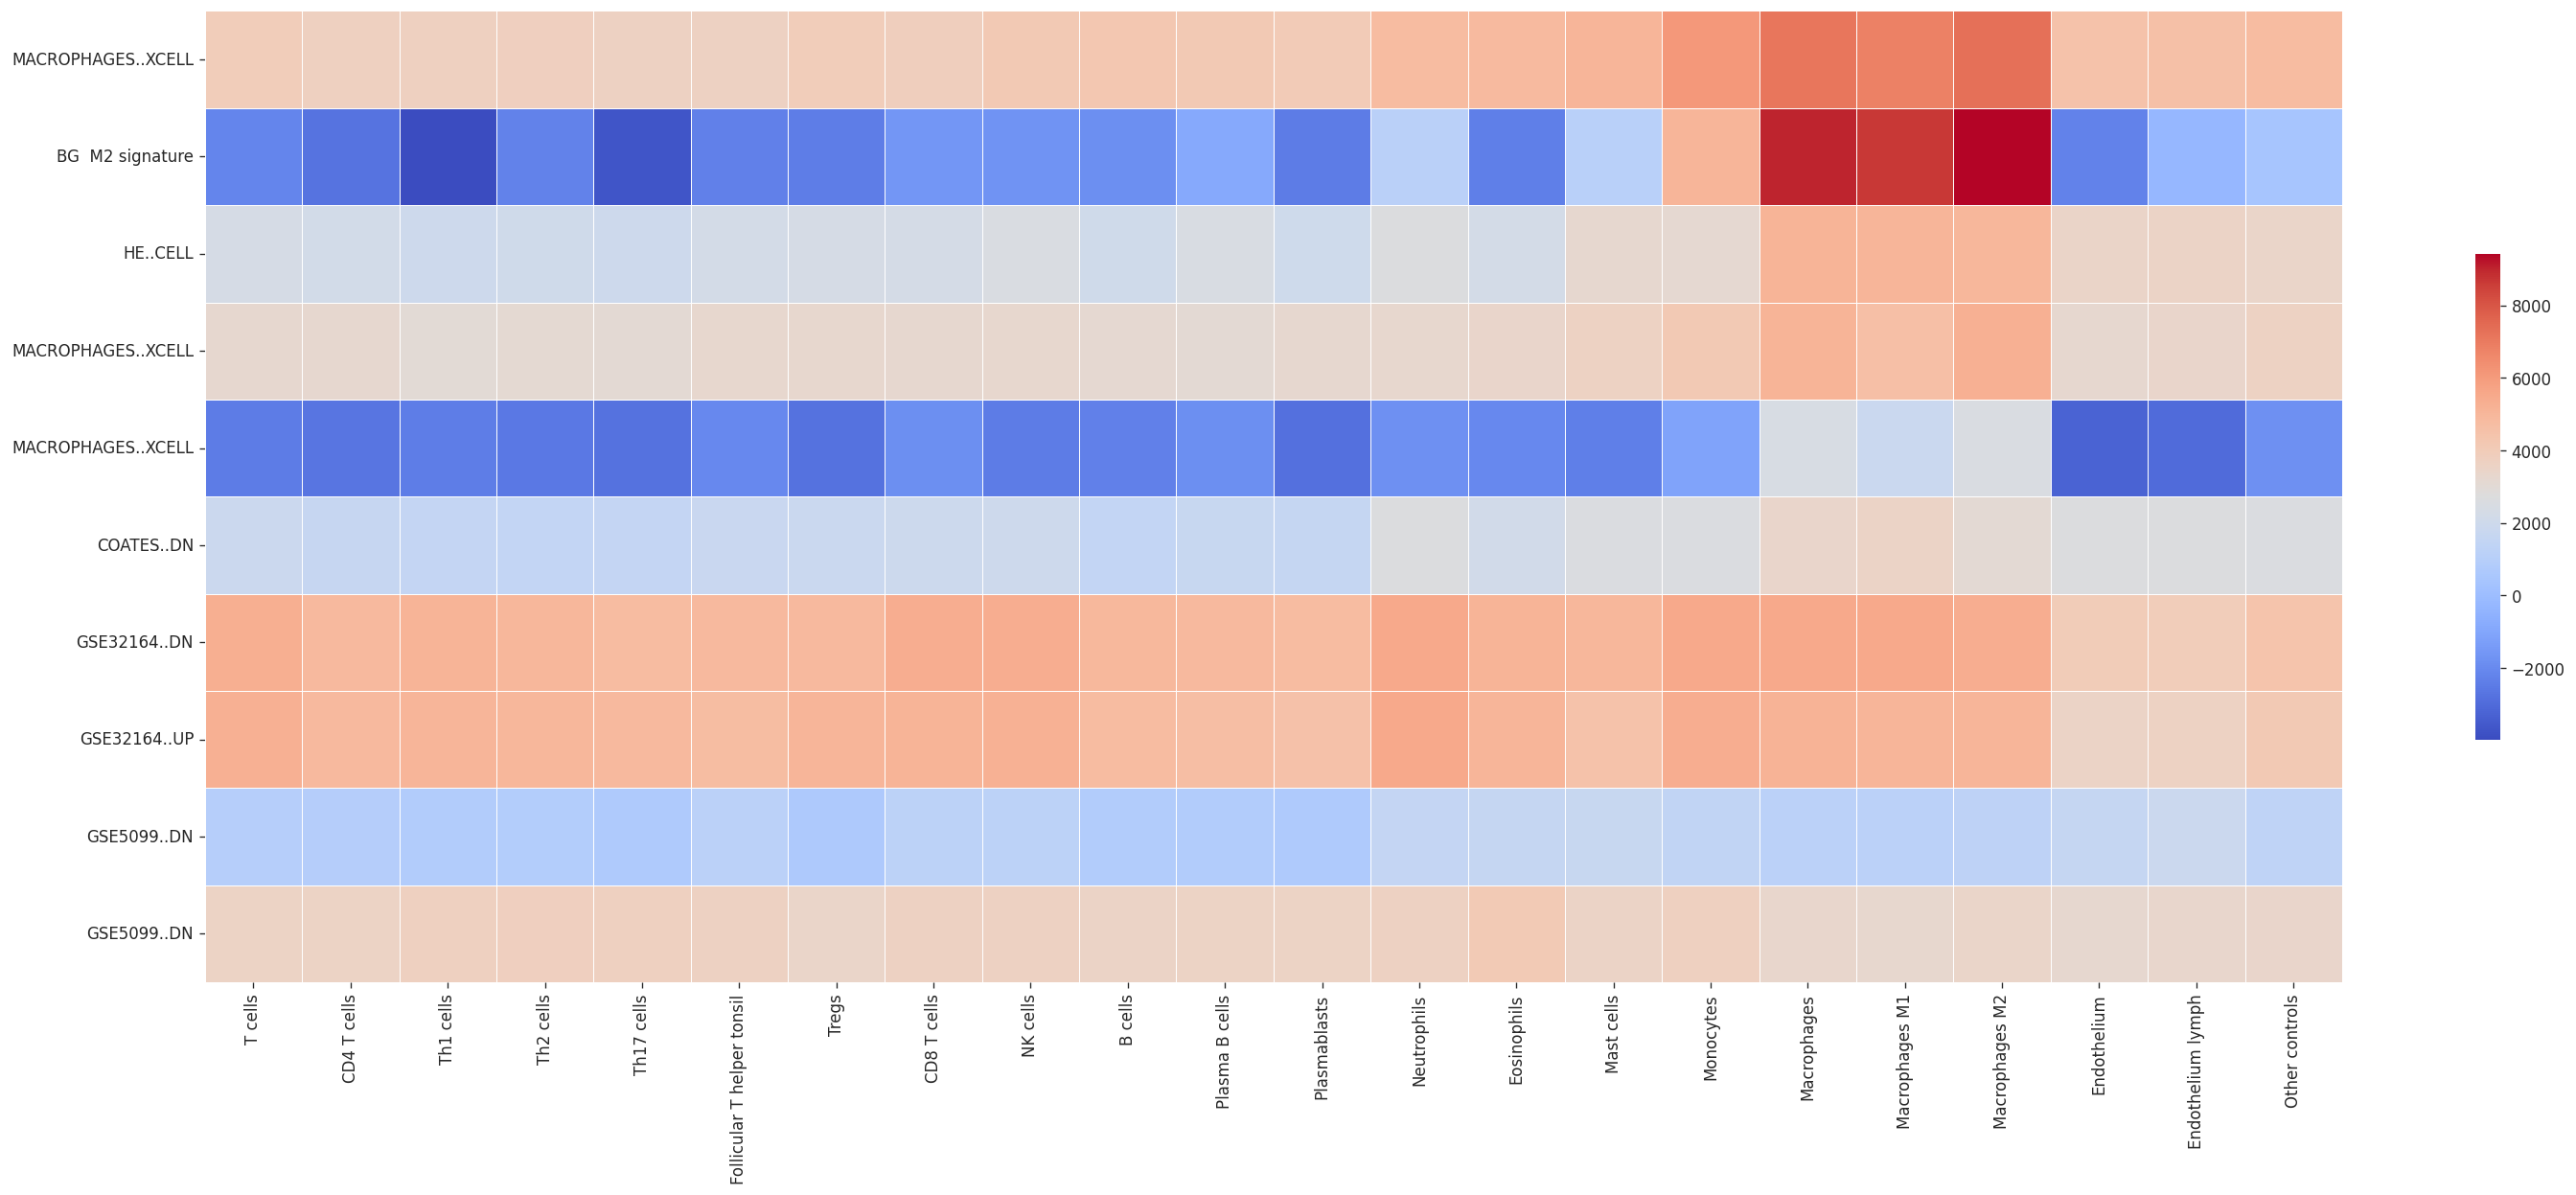

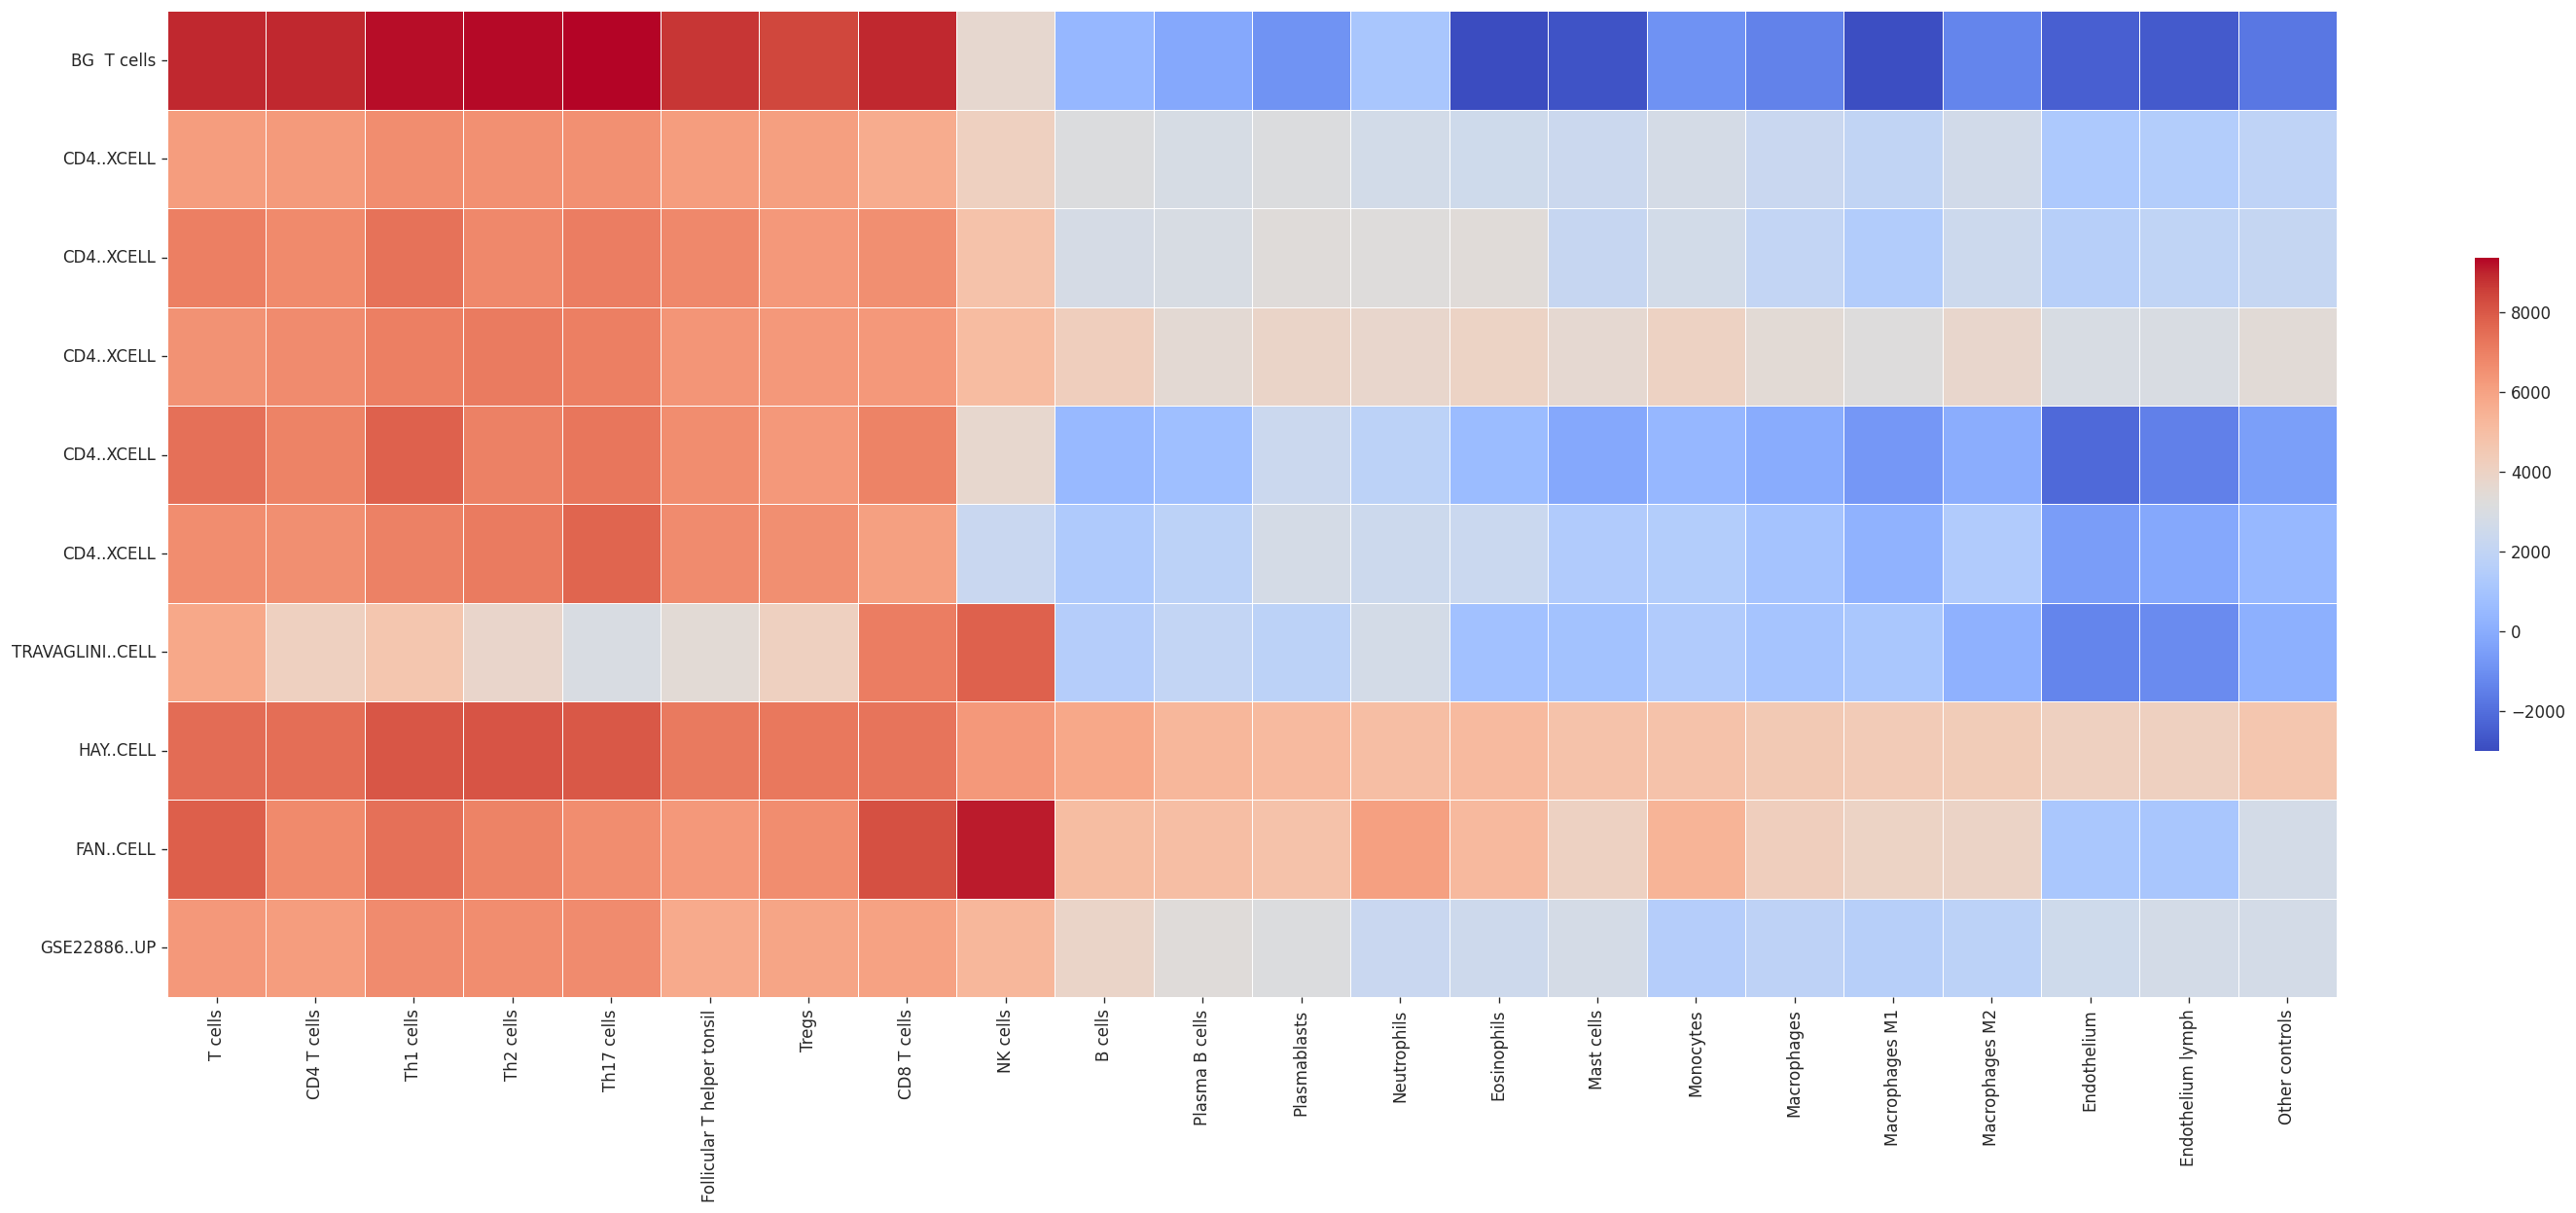

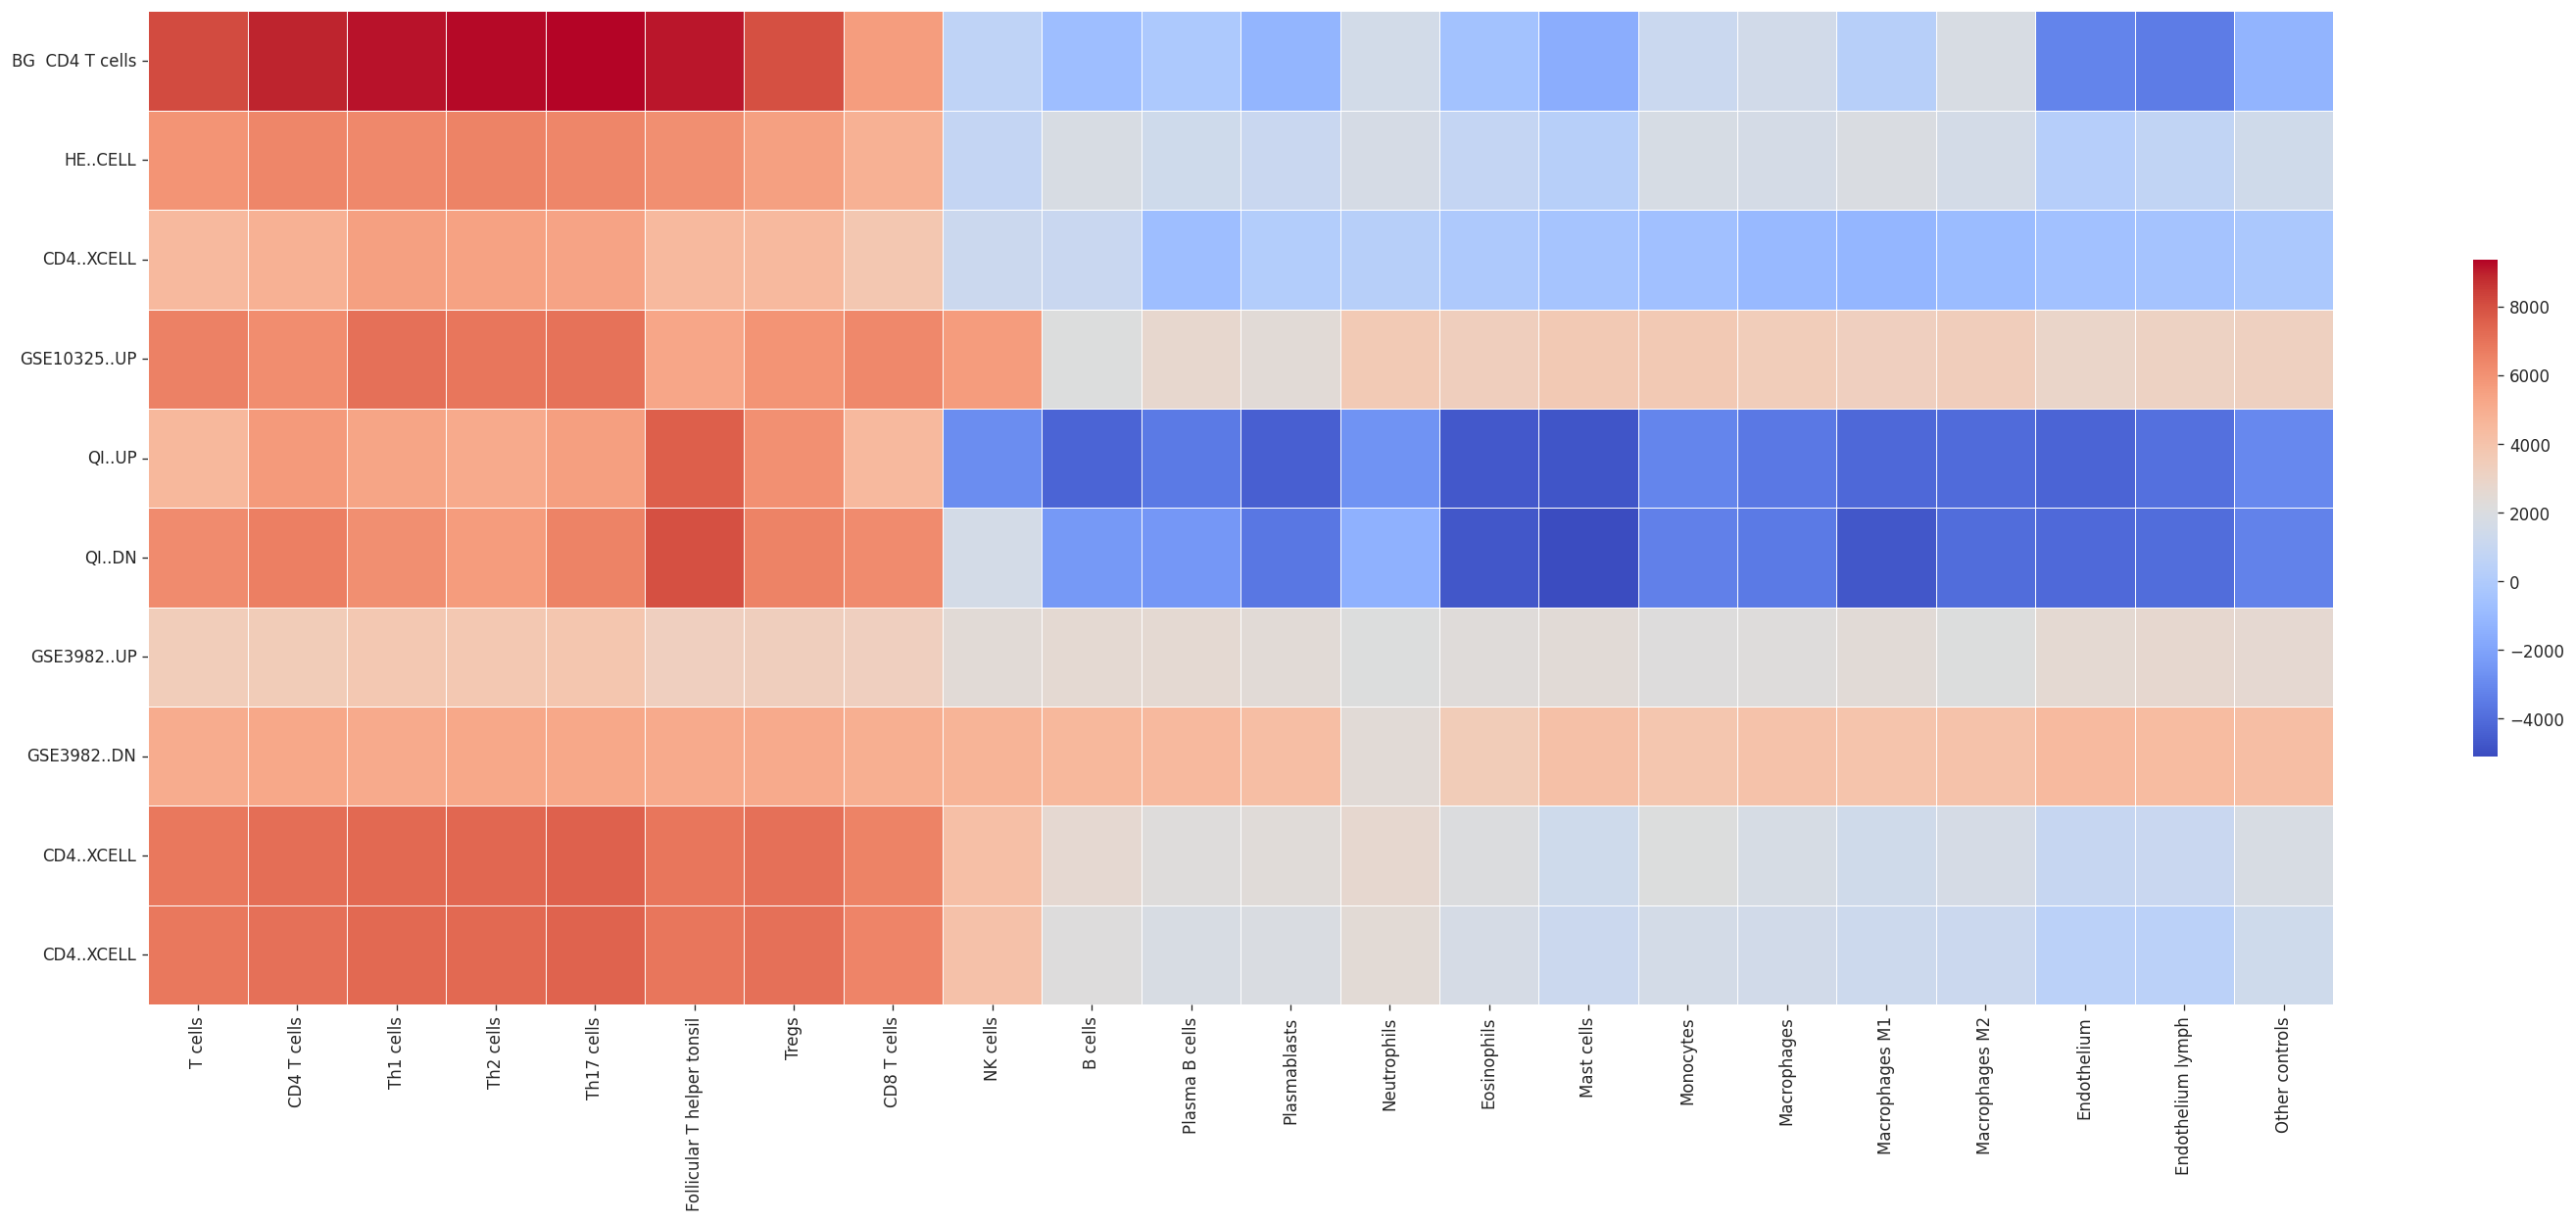

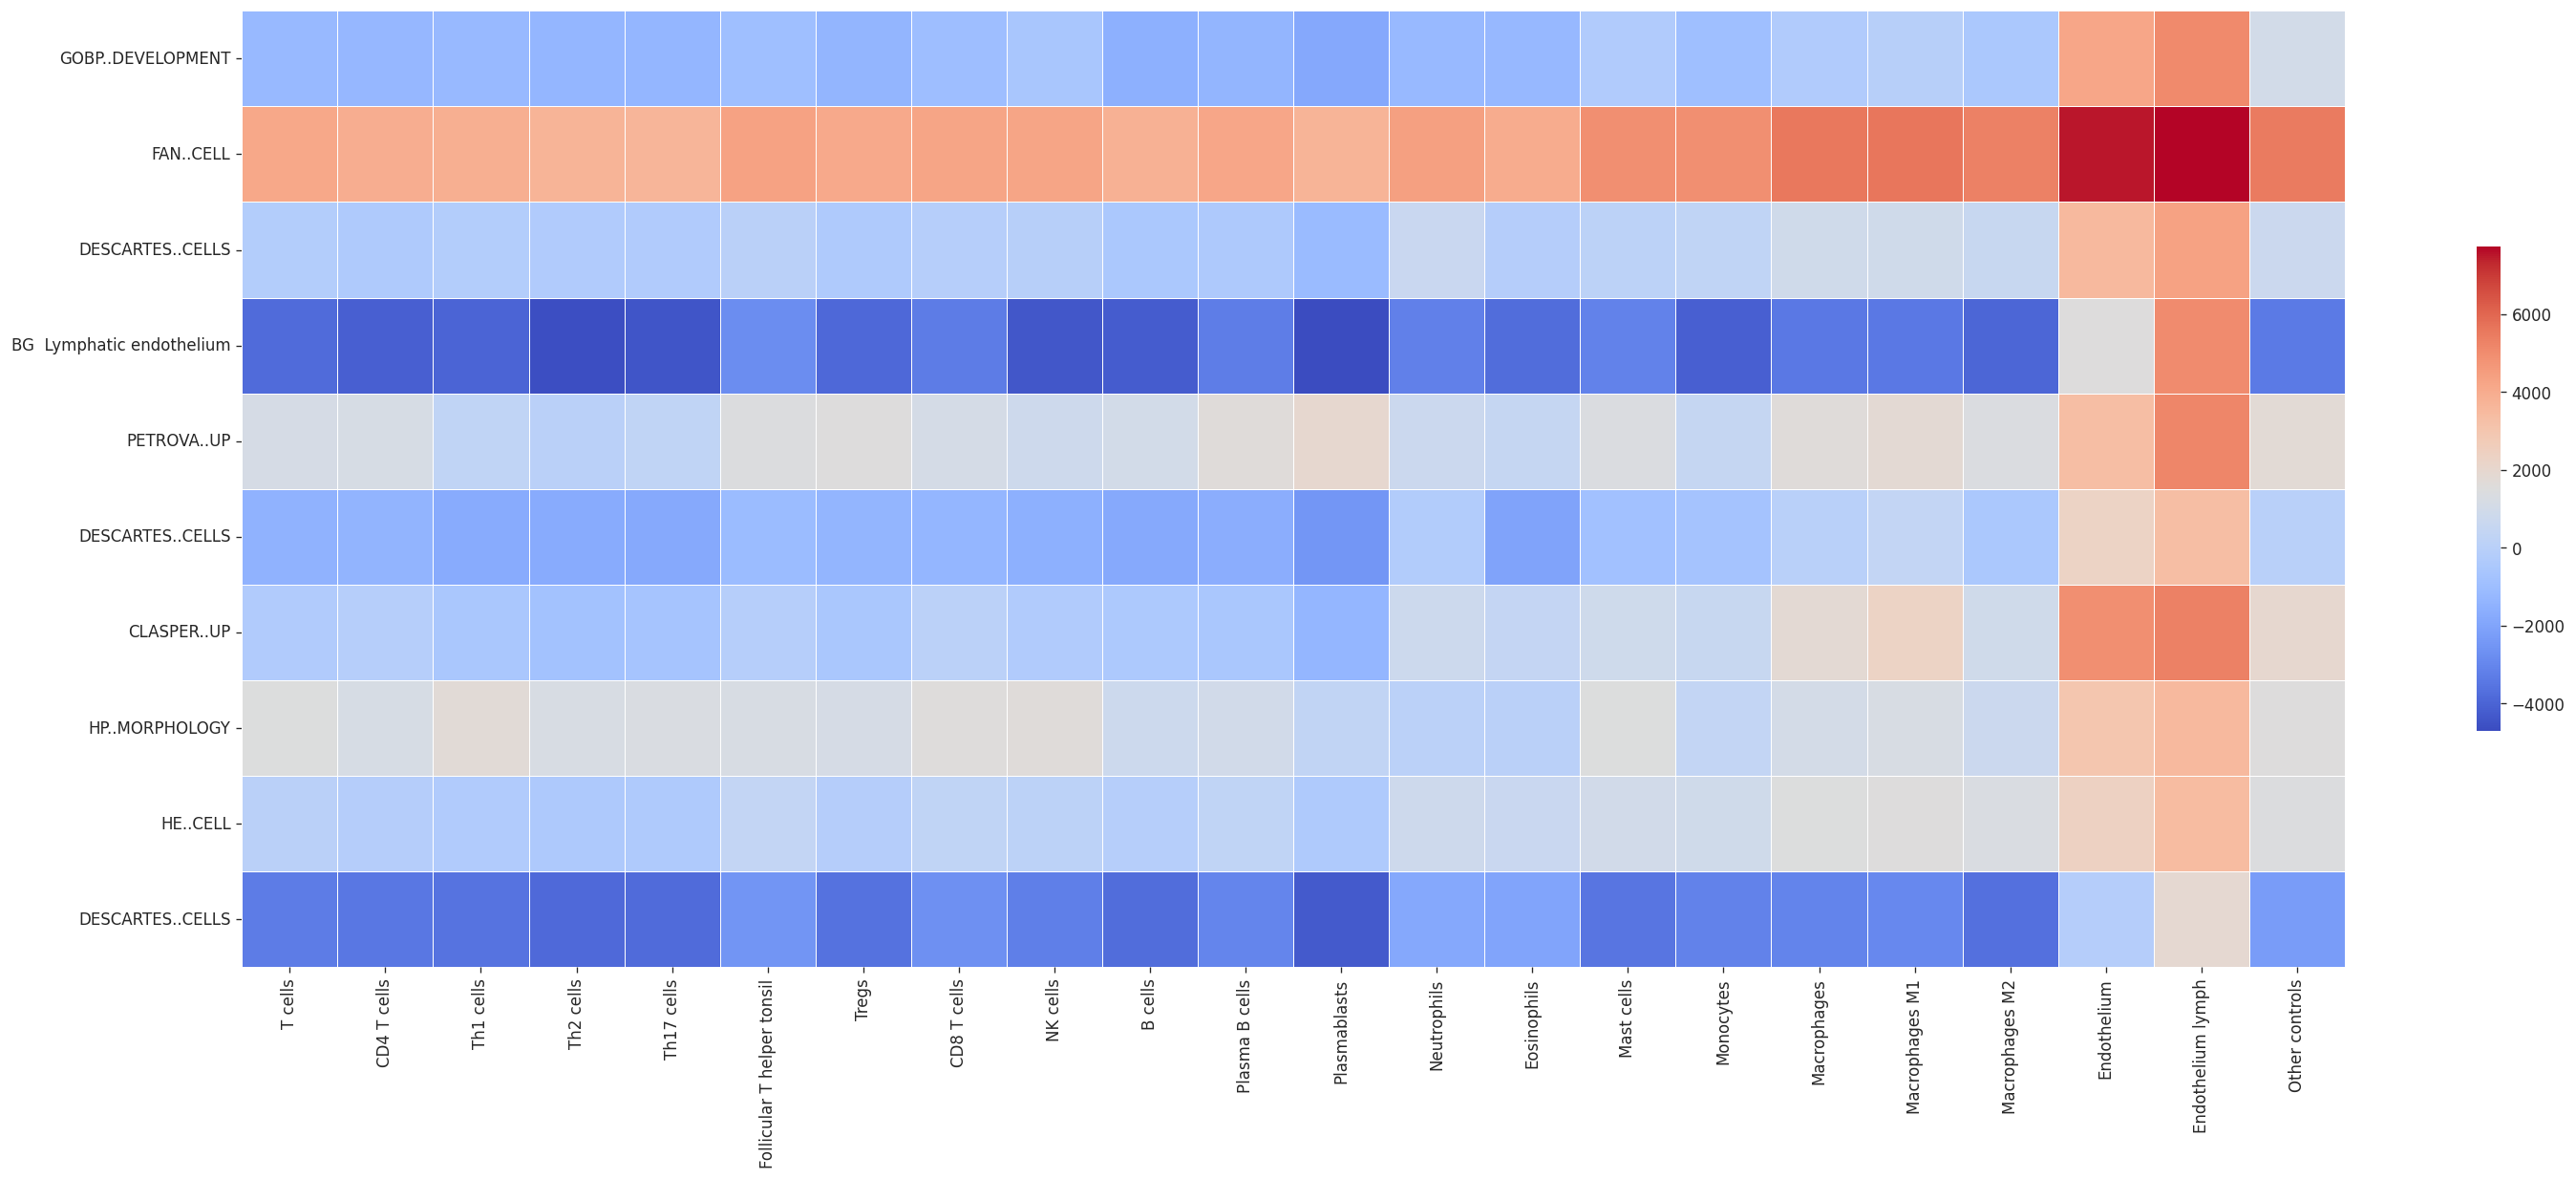

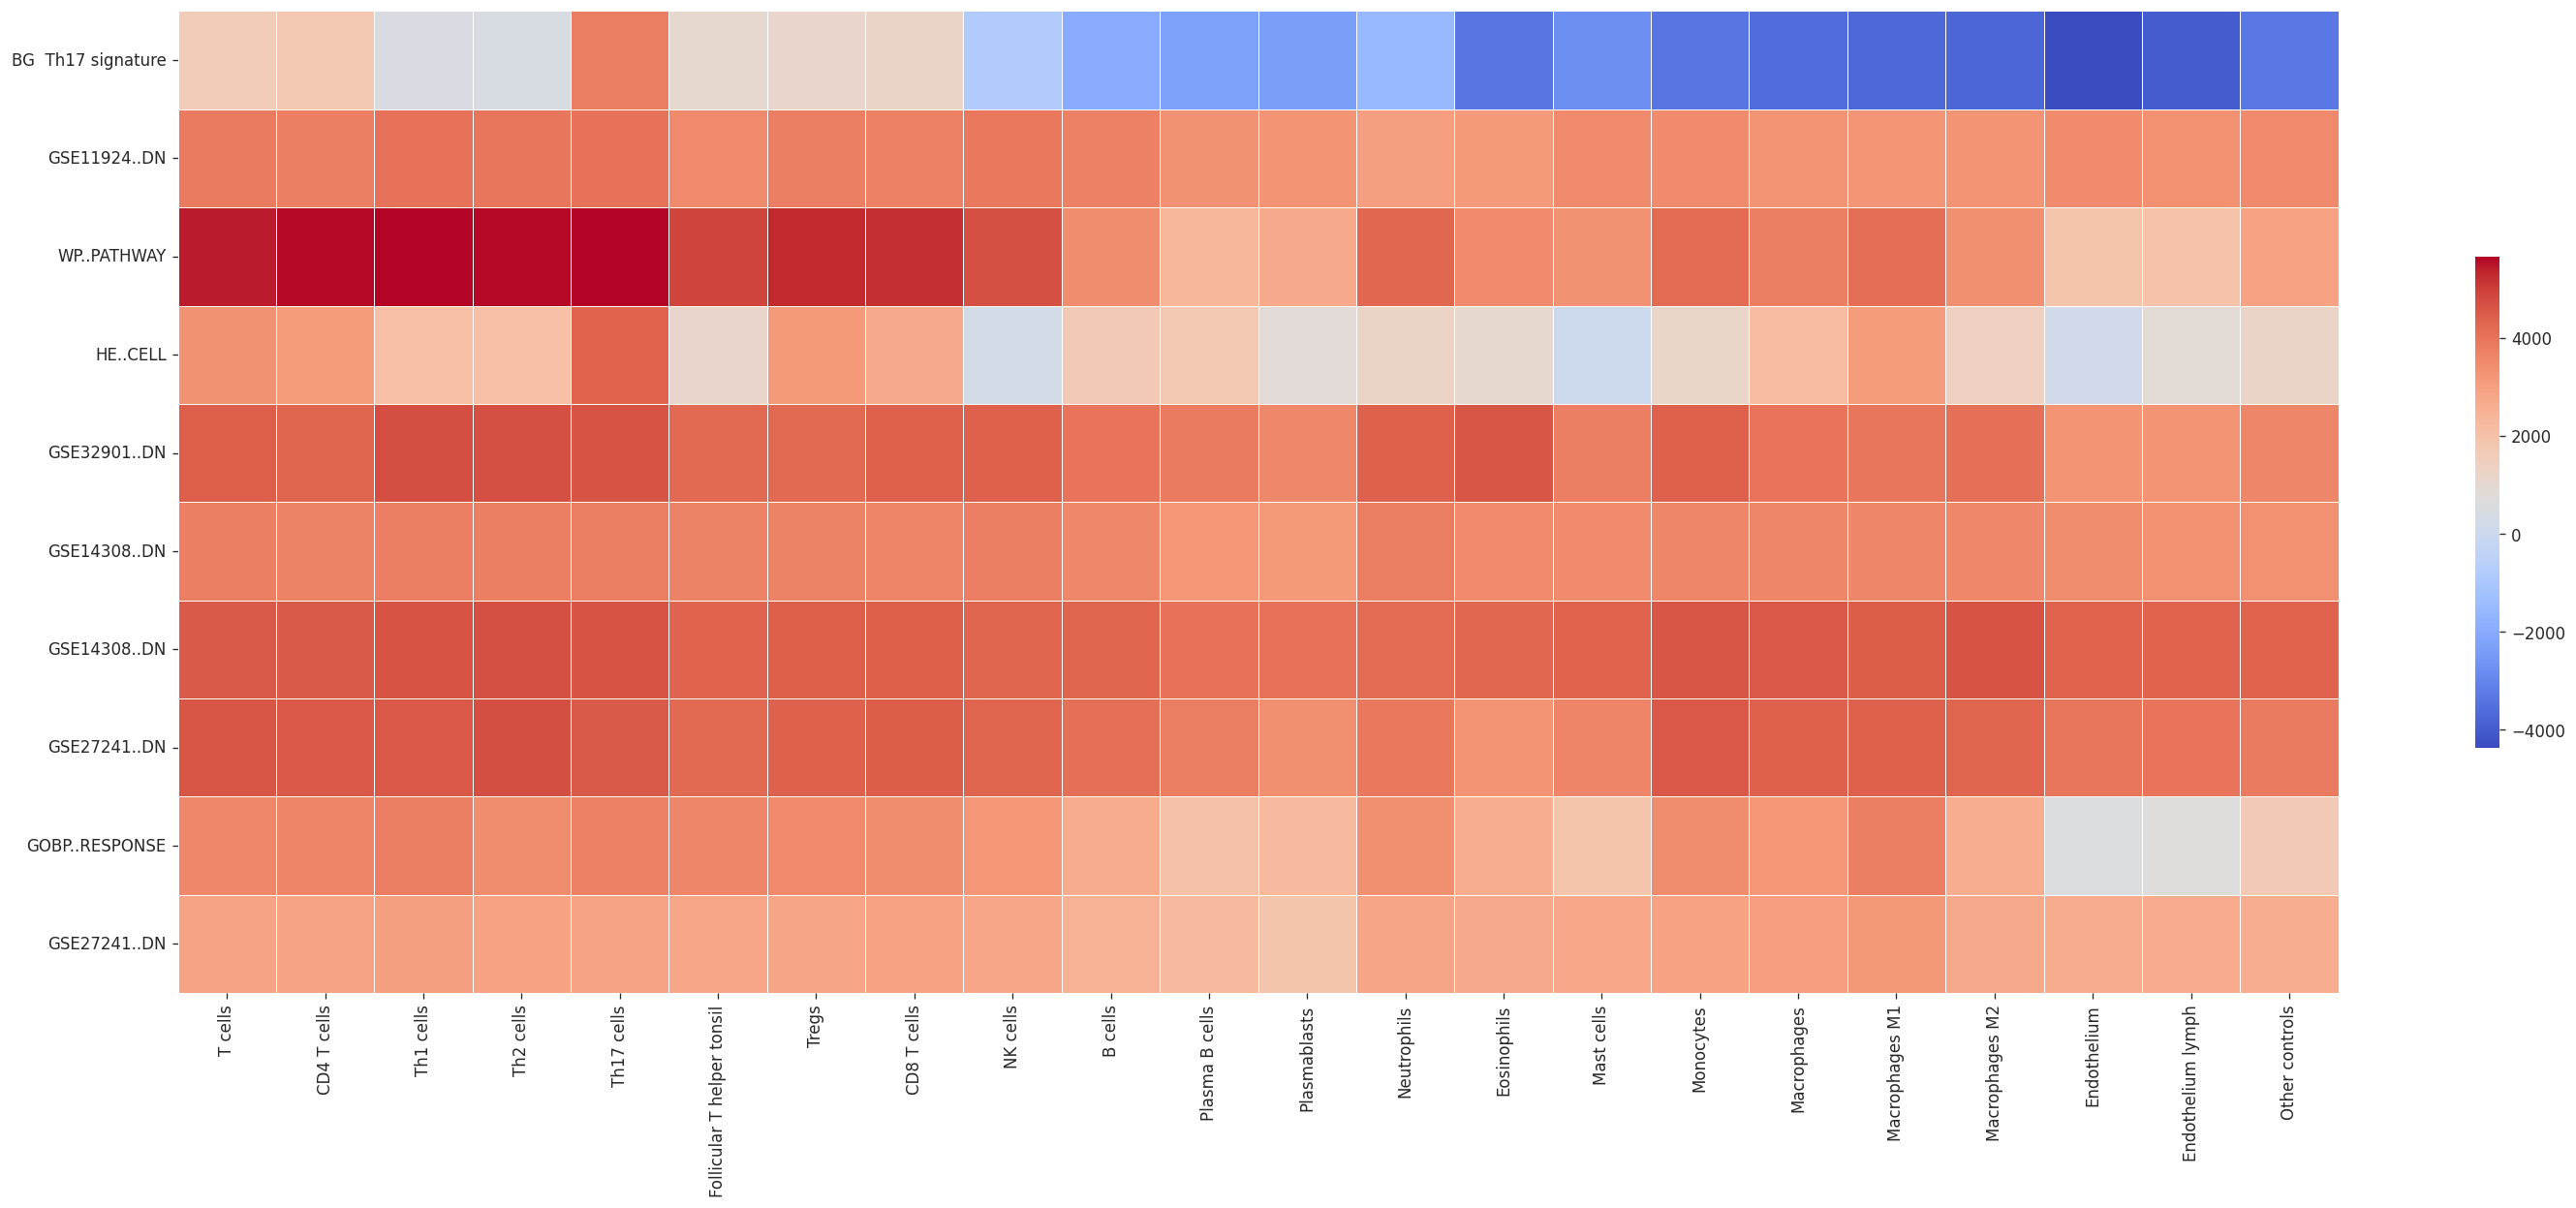

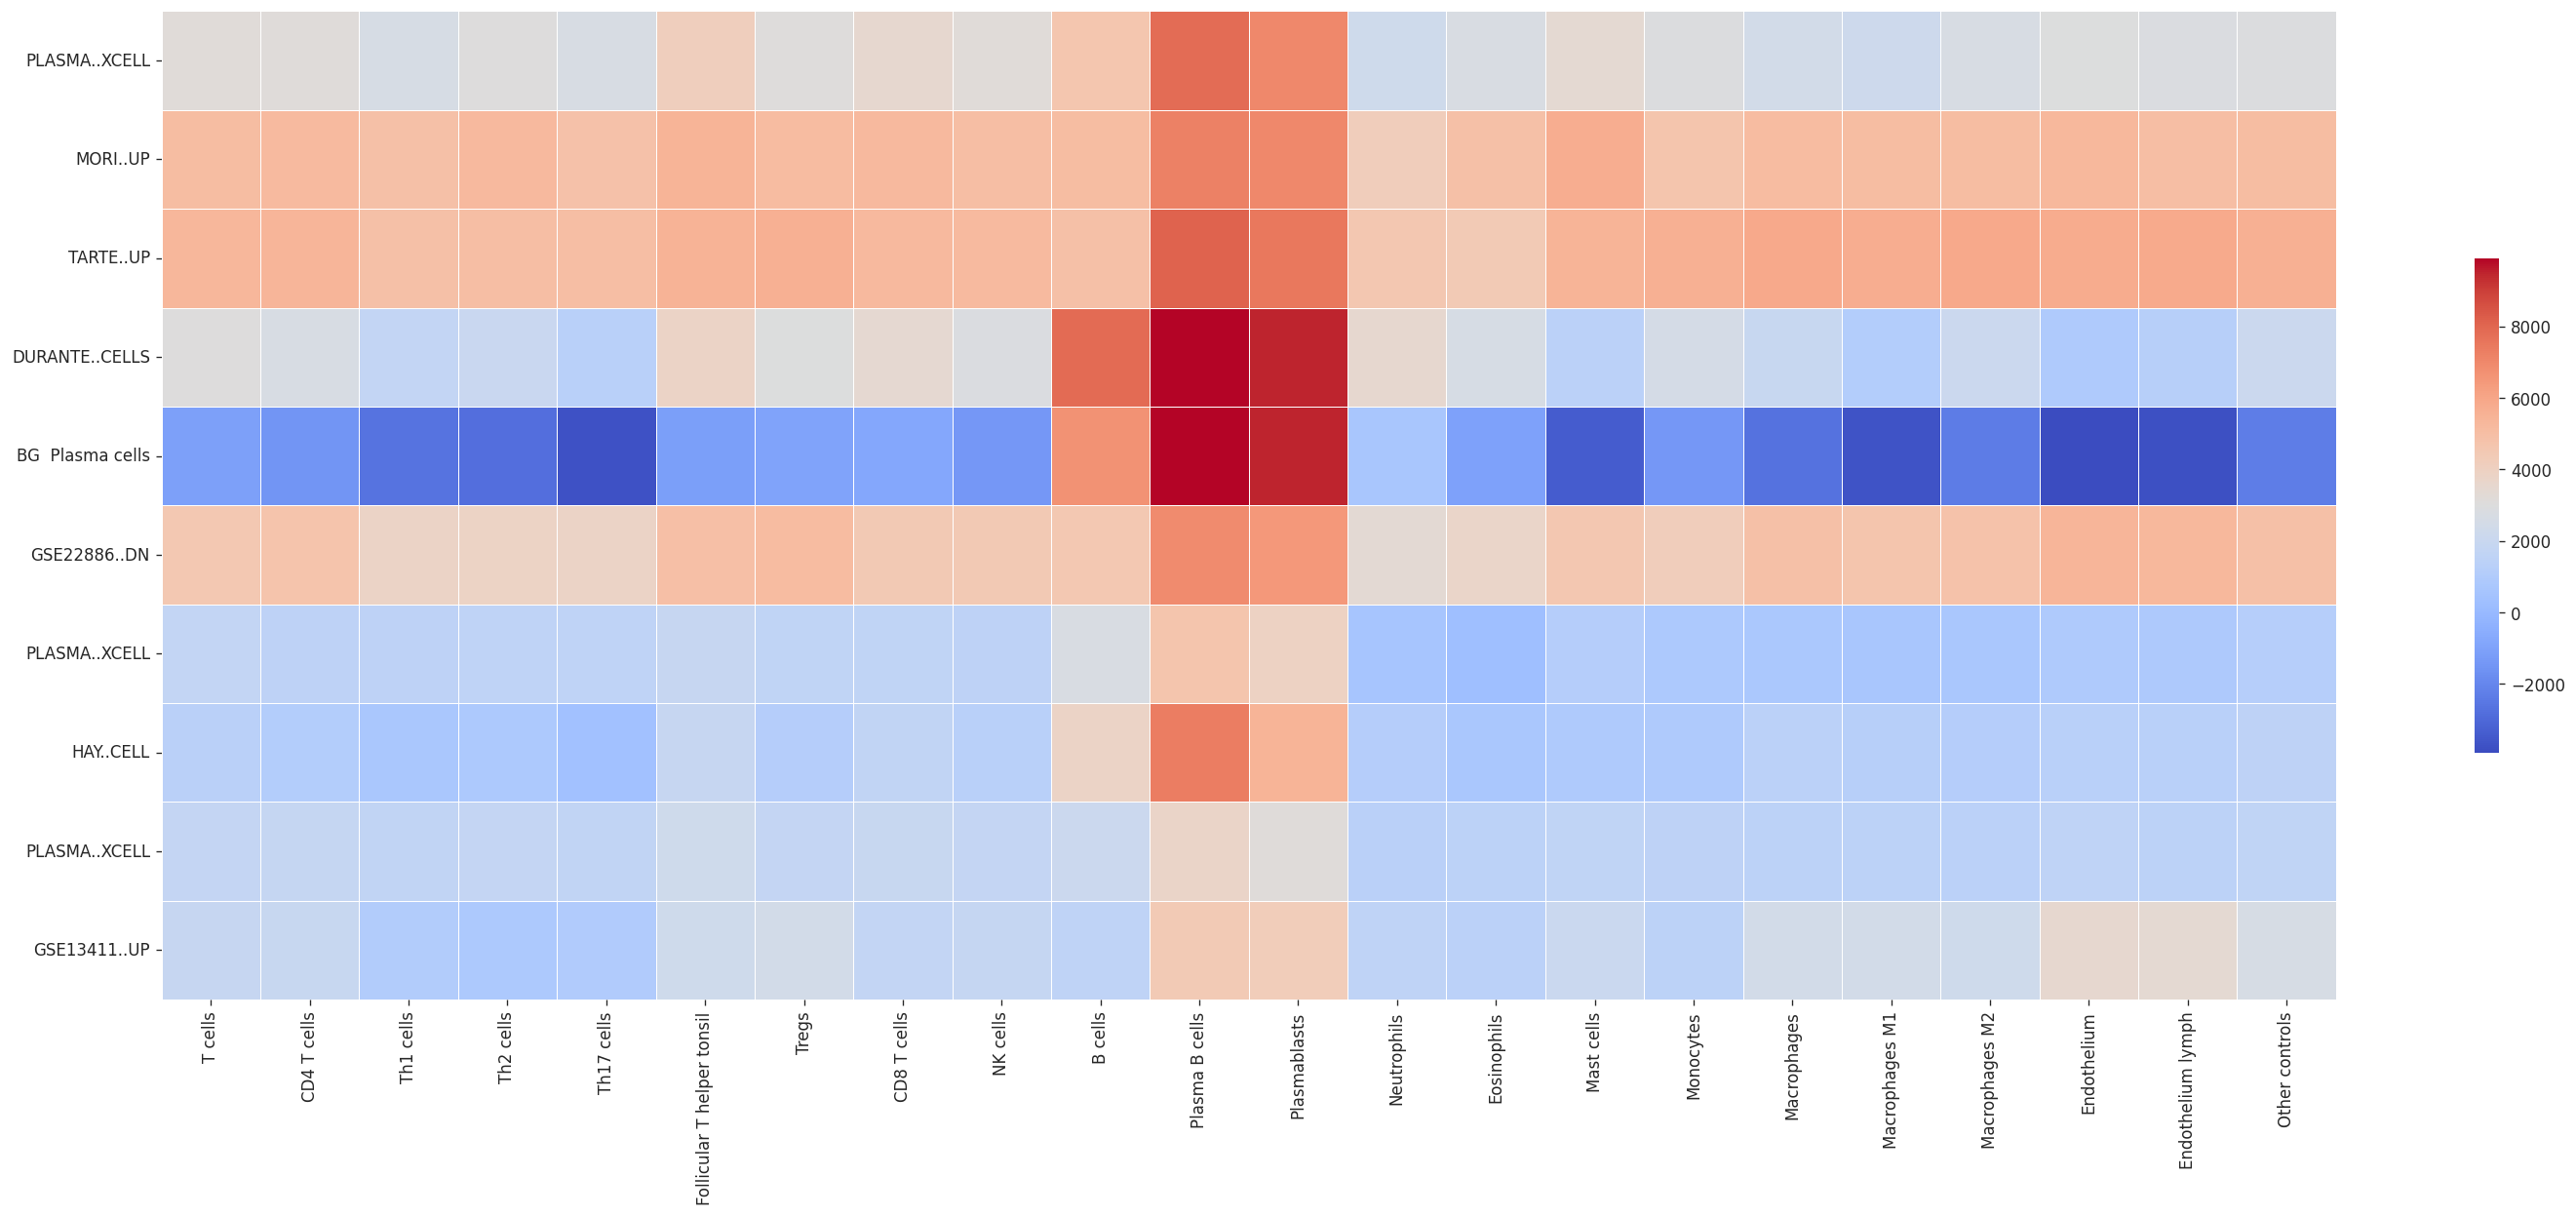

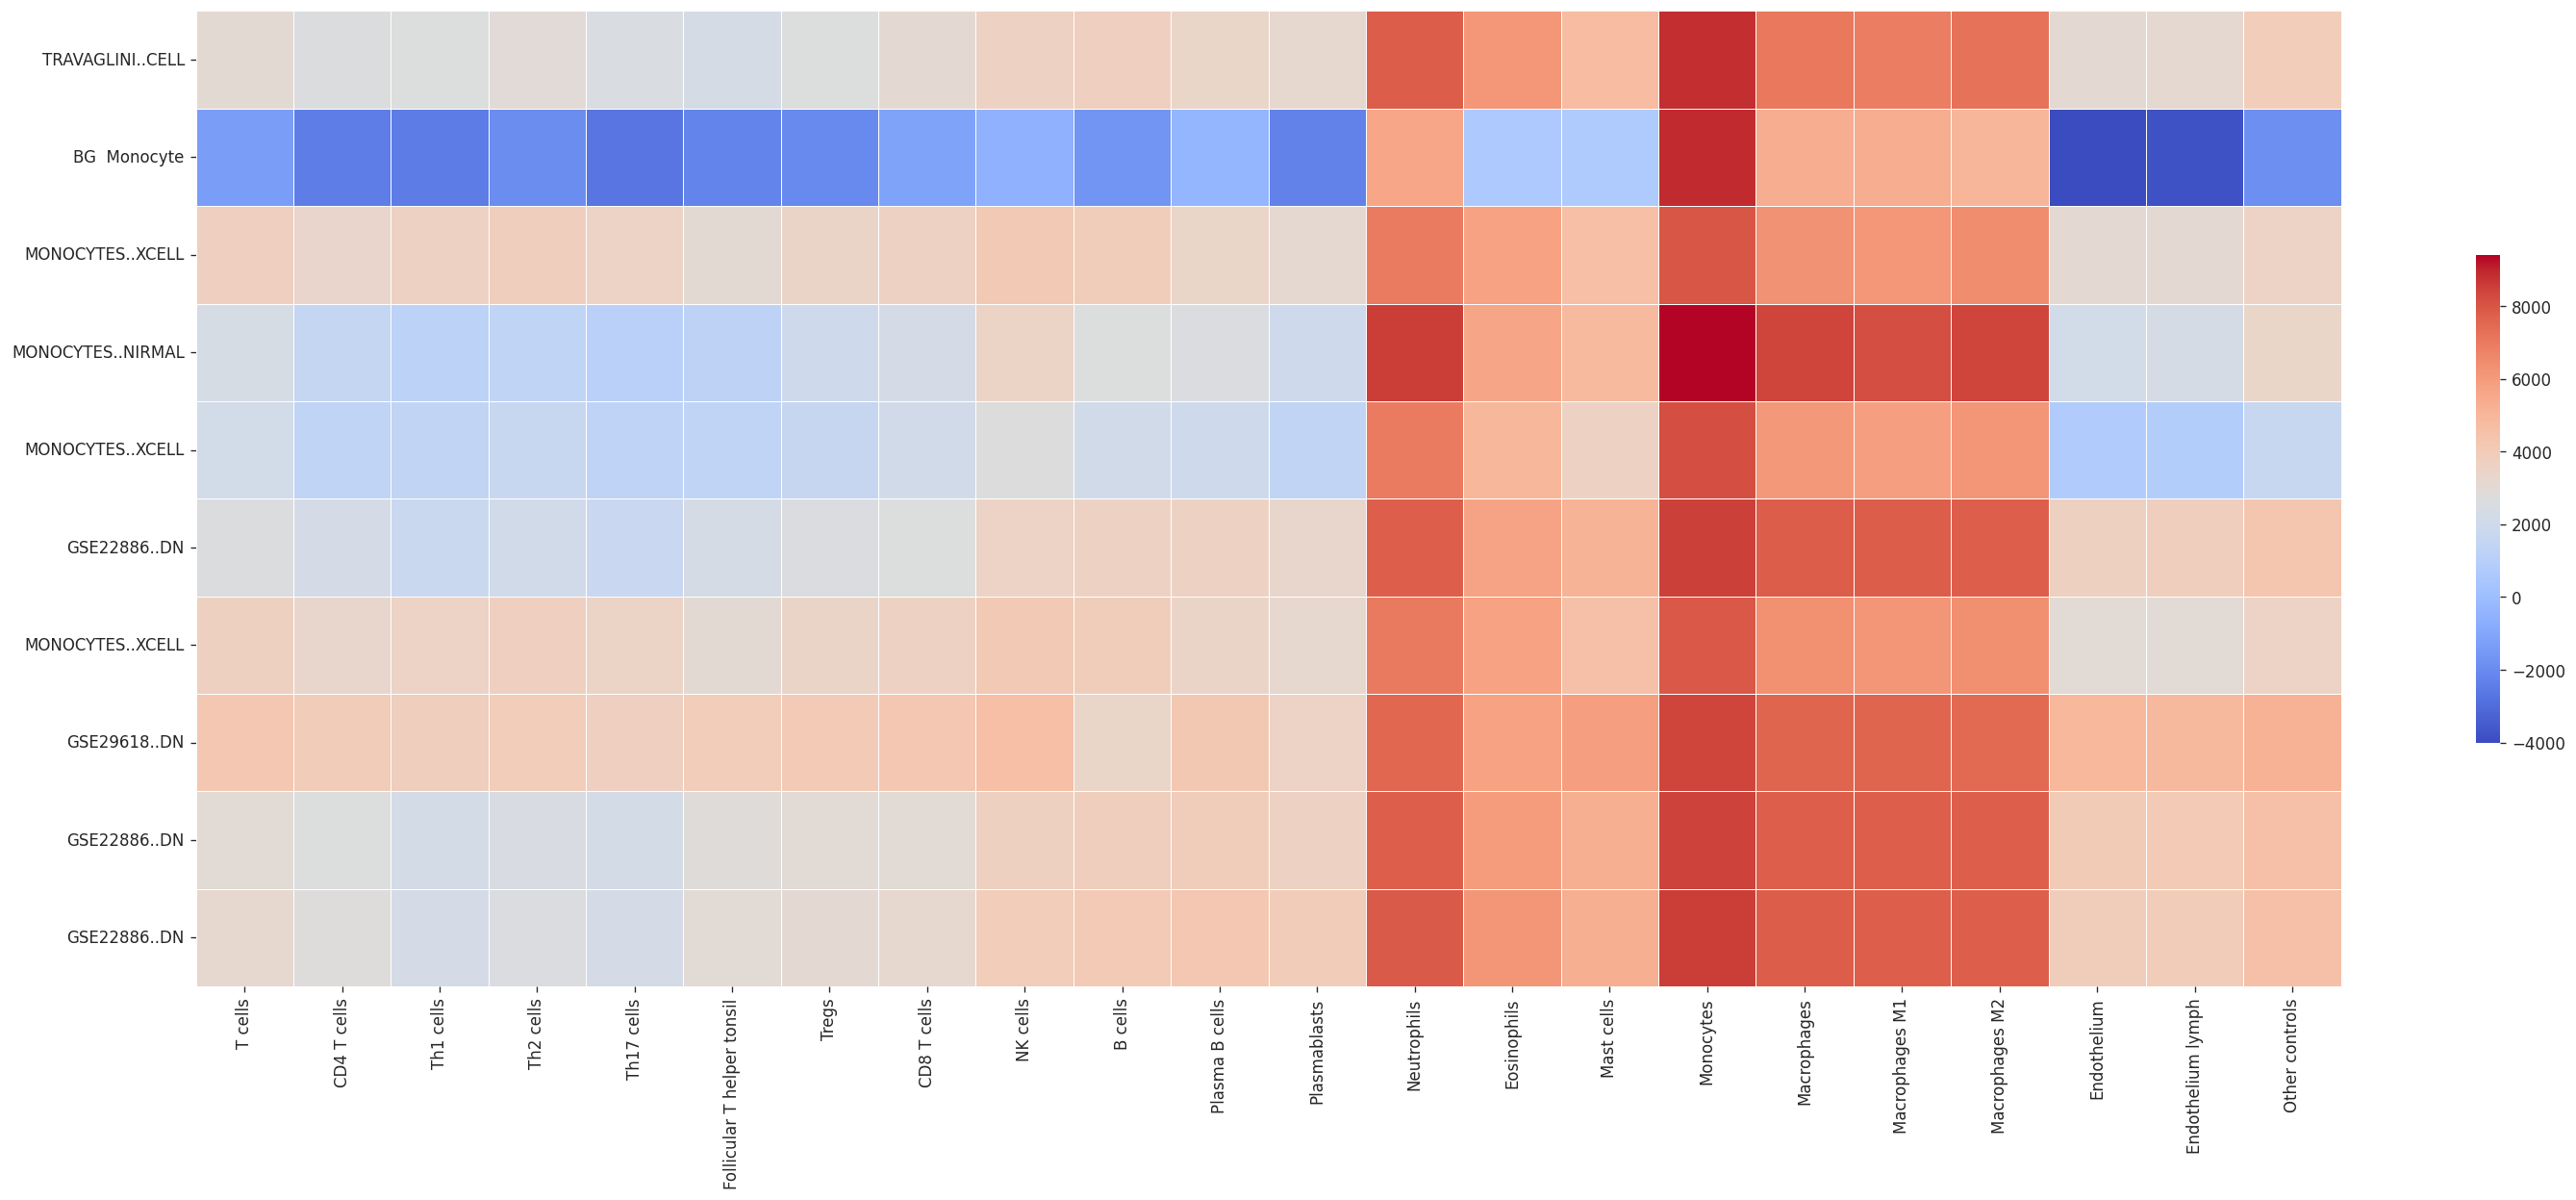

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
t = 10
for bg_sign in msigdb_gmt.keys():
    signs = msigdb_gmt[bg_sign].keys()
    scores = pd.Series(
        {s: pd.DataFrame(fges_metrics[s]).loc["F1"].mean() for s in signs}
    )
    ind = scores.sort_values(ascending=False).index
    ind = ind[~ind.duplicated()].to_list()
    ind = [i for i in ind if "RANDOM" not in i][:t]
    if bg_sign not in ind:
        ind = ind[: (t - 1)] + [bg_sign]
        print(bg_sign)
    data = df[ind].T
    data = data[~data.index.duplicated()]
    ls = labels.reindex(data.columns)
    data = data.T.groupby(ls).mean().T[controls_order_short]
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(
        data,
        cmap=default_cmap,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        cbar=True,
        annot=False,
        fmt=".1f",
        square=True,
        cbar_kws={"shrink": 0.5},
        linewidths=0.5,
    )
    ax.set_xticklabels([i.replace("_", " ") for i in controls_order_short], rotation=90)
    yticks = ind
    for i in range(len(yticks)):
        if yticks[i][:5] == "Main4":
            yticks[i] = "BG " + yticks[i].replace("Main4", "").replace("_", " ")
        else:
            yticks[i] = "{}..{}".format(
                yticks[i].split("_")[0], yticks[i].split("_")[-1]
            )
    ax.set_yticklabels(yticks)
    plt.tight_layout(pad=0.2)
    plt.savefig(
        p
        / f"svg_pictures_median_heatmaps_short_labels/top10_median_heatmap_for_{bg_sign}_short_labels.svg",
        format="svg",
    )

# BG Heatmap

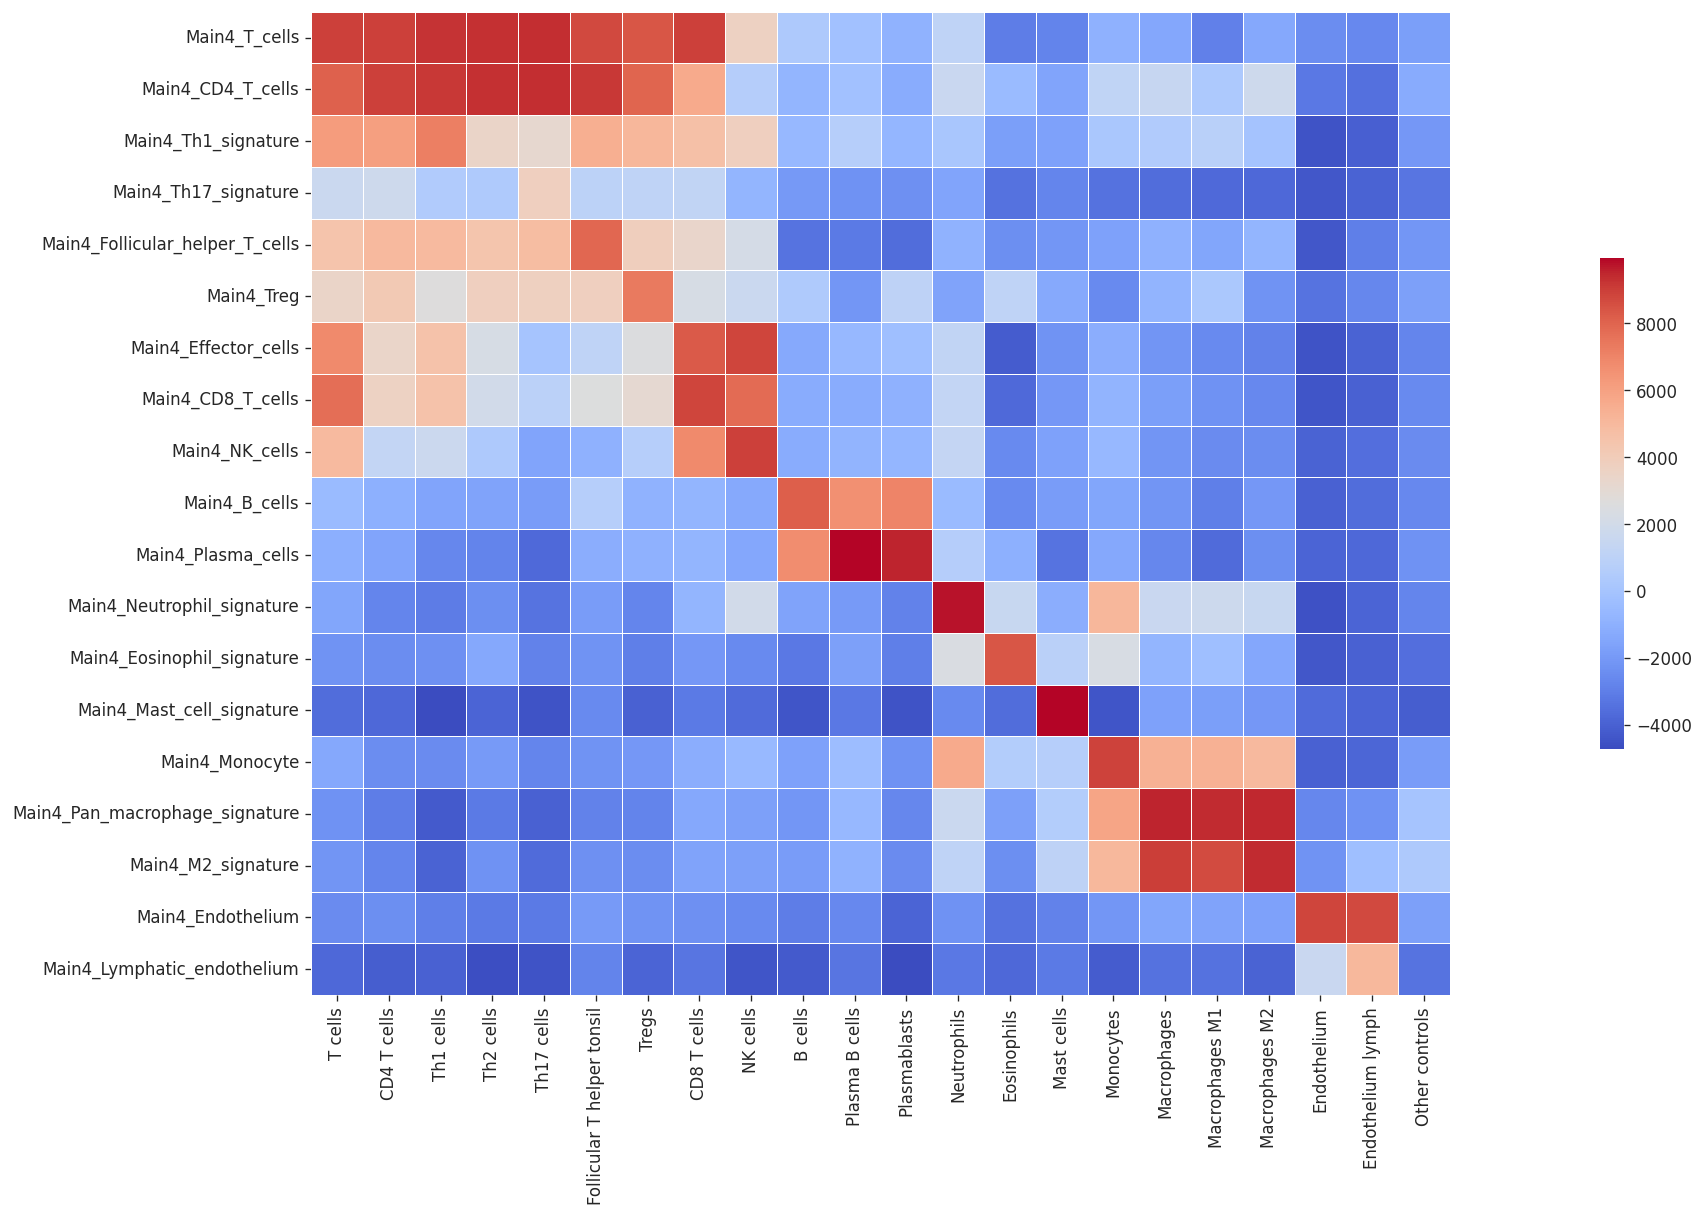

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
ind = [
    "Main4_T_cells",
    "Main4_CD4_T_cells",
    "Main4_Th1_signature",
    "Main4_Th17_signature",
    "Main4_Follicular_helper_T_cells",
    "Main4_Treg",
    "Main4_Effector_cells",
    "Main4_CD8_T_cells",
    "Main4_NK_cells",
    "Main4_B_cells",
    "Main4_Plasma_cells",
    "Main4_Neutrophil_signature",
    "Main4_Eosinophil_signature",
    "Main4_Mast_cell_signature",
    "Main4_Monocyte",
    "Main4_Pan_macrophage_signature",
    "Main4_M2_signature",
    "Main4_Endothelium",
    "Main4_Lymphatic_endothelium",
]
data = df[ind].T
ls = labels.reindex(data.columns)
data = data.T.groupby(ls).mean().T[controls_order_short]
fig, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(
    data,
    cmap=default_cmap,
    xticklabels=True,
    yticklabels=True,
    ax=ax,
    cbar=True,
    annot=False,
    fmt=".1f",
    square=True,
    cbar_kws={"shrink": 0.5},
    linewidths=0.5,
)
ax.set_xticklabels([i.replace("_", " ") for i in controls_order_short], rotation=90)
yticks = ind
ax.set_yticklabels(yticks)
plt.tight_layout(pad=0.2)
plt.savefig(p / f"top10_median_heatmap_for_bg_signs.svg", format="svg")